## 5.0 Capstone Project Two: All State Purchase Prediction - Modelling the Product Vectors<a id='2_Exploratory_Data_Analysis'></a>
**Submitted By:** Amit Kukreja

## Objectives<a id='2.2_EDA_Objectives'></a>

1) Predict the 7 product vector's final value based on shopping quotes 1 and 2

2) Test and evaluate the performance of different models

3) Tune hyperparameters to improve model performance




In [218]:
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sb_utils import save_file
from collections import defaultdict
from collections import Counter
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression


from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve, f1_score, auc

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score, log_loss


In [2]:
# Let's import the preprocessed and transformed feature matrix and target vectors

X = pd.read_csv('Transformed_data/pre_processed_training_data_with_quotes_1_2.csv')
y = pd.read_csv('Transformed_data/training_data_target_columns.csv')


X.shape, y.shape        

((77607, 94), (77607, 7))

In [3]:
X.head()

shopping_pt  car_age_2  age_oldest_2  age_youngest_2  duration_previous_2  \
0     1.072089  -0.901461     -0.003780        0.129103            -0.636138   
1     0.571683   0.824464     -1.209101       -1.073002             0.862673   
2     0.571683   2.032611     -0.061176       -1.359217            -0.636138   
3     0.571683  -0.211091     -0.692535       -0.615057            -0.636138   
4     1.572496   0.134094     -1.036912       -0.901272            -0.422023   

     cost_1    cost_2  changes_step_2  cost_diff_step_2  state_AR  ...  F_1_3  \
0  0.464913  0.467906       -0.871664         -0.043014         0  ...      0   
1 -0.677346 -1.614463        0.903450         -1.338349         0  ...      0   
2 -0.303158 -0.352421       -0.871664         -0.043014         0  ...      1   
3  0.287666  0.867553       -0.279959          0.841605         0  ...      0   
4  0.090725 -0.352421        0.311745         -0.674885         0  ...      0   

   F_2_1  F_2_2  F_2_3  G_1_2  G_1_3  G_1_4  G_2_2  G_2_3  G_2_4  
0      0      1      0      0      0      0      0      0      0  
1      0      0      0      0      1      0      0      1      0  
2      0      0      1      0      1      0      0      1      0  
3      0      1      0      0      0      1      0      1      0  
4      1      0      0      0      0      1      0      1      0  

[5 rows x 94 columns]

In [20]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77607 entries, 0 to 77606
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   A       77607 non-null  int64
 1   B       77607 non-null  int64
 2   C       77607 non-null  int64
 3   D       77607 non-null  int64
 4   E       77607 non-null  int64
 5   F       77607 non-null  int64
 6   G       77607 non-null  int64
dtypes: int64(7)
memory usage: 4.1 MB


In [4]:
# Split the features and target into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify = X['shopping_pt'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62085, 94), (15522, 94), (62085, 7), (15522, 7))

In [219]:
# Create functions based on different classifiers to predict the vectors and plot feature importances

plt.style.use("fivethirtyeight")

def rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, min_samples_split = 2, plot = False):
    
    clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf = min_samples_leaf, \
                             min_samples_split = min_samples_split, random_state = 1,n_jobs=-1)

    model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    rf_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'), 4)
    cm1= confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Random Forest Classifier results for Vector {vector}")
    print(f"Parameters: No. of Estimators = {n_estimators},  min_samples_leaf = {min_samples_leaf}, \
    min_samples_split = {min_samples_split}")
    print(f'Accuracy={ac:4.4}, f1-score={f1:4.4}')
    
    if plot == True:
        print("Confusion Matrix - normalized\n", cm)
        print("Confusion Matrix\n", cm1)
    
        cr = classification_report(y_test[vector].astype('int'), y_pred)
        print("\nClassification Report \n", cr)
    
        feature_importance = clf.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)[X_train.shape[1] - 30:]
        pos = np.arange(sorted_idx.shape[0]) + .5
        print(pos.size)
        sorted_idx.size
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(10,10))
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, X_train.columns[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title('Random Forest Model, Variable Importance for Vector '+vector)
        plt.show()
    
    return ac, f1, rf_probs

def xg_predict_plot(vector, n_estimators=200, max_depth = 1, learning_rate = 0.3, colsample_bytree = 1, plot = False):
    
    clf = xgb.XGBClassifier(max_depth=max_depth, objective='binary:logistic', n_estimators=n_estimators, \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),4)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"XGBoost Classifier results for Vector {vector}")
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")
    print(f'Accuracy={ac:4.4}, f1-score={f1:4.4}')
    
    if plot == True:
        print("Confusion Matrix - normalized\n", cm)
        print("Confusion Matrix\n", cm1)

        cr = classification_report(y_test[vector].astype('int'), y_pred)
        print("\nClassification Report \n", cr)

        feature_importance = clf.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)[X_train.shape[1] - 30:]

        pos = np.arange(sorted_idx.shape[0]) + .5
        print(pos.size)
        sorted_idx.size
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(10,10))
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, X_train.columns[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title('XG Boost Model, Variable Importance for Vector '+vector)
        plt.show()
        
    return ac, f1, xg_probs
    
def gb_predict_plot(vector, n_estimators=100, max_depth = 2, learning_rate = 0.3, max_features = 6, plot = False):
    
    clf = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimators, \
                       learning_rate = learning_rate, max_features = max_features, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    gb_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),4)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Gradient Boosting Classifier results for Vector {vector}")
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, max_features = {max_features}")
    print(f'Accuracy={ac:4.4}, f1-score={f1:4.4}')
    
    if plot == True:
        print("Confusion Matrix - normalized\n", cm)
        print("Confusion Matrix\n", cm1)

        cr = classification_report(y_test[vector].astype('int'), y_pred)
        print("\nClassification Report \n", cr)

        feature_importance = clf.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)[X_train.shape[1] - 30:]

        pos = np.arange(sorted_idx.shape[0]) + .5
        print(pos.size)
        sorted_idx.size
        plt.figure(figsize=(10,10))
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, X_train.columns[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
        plt.show()
        
    return ac, f1, gb_probs

def knn_predict(vector):
    
    logreg = LogisticRegression()
    logreg.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = logreg.predict(X_test.to_numpy())
    y_pred_prob = logreg.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),4)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f'Logistic Regression for vector {vector}')
    print(f'Accuracy = {ac:4.4}, f1-score = {f1:4.4}\n')
    print("Confusion Matrix - normalized\n", cm)
    print("Confusion Matrix\n", cm1)

    cr = classification_report(y_test[vector].astype('int'), y_pred)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test[vector].astype('int'), lr_probs)
    roc_auc2 = auc(fpr_2, tpr_2)
    print("\nClassification Report \n", cr)
    print("\nArea under ROC: \n", roc_auc2)
    
    return ac, f1, lr_probs

def lr_predict(vector):
    
    logreg = LogisticRegression()
    logreg.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = logreg.predict(X_test.to_numpy())
    y_pred_prob = logreg.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),4)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f'Logistic Regression for vector {vector}')
    print(f'Accuracy = {ac:4.4}, f1-score = {f1:4.4}\n')
    print("Confusion Matrix - normalized\n", cm)
    print("Confusion Matrix\n", cm1)

    cr = classification_report(y_test[vector].astype('int'), y_pred)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test[vector].astype('int'), lr_probs)
    roc_auc2 = auc(fpr_2, tpr_2)
    print("\nClassification Report \n", cr)
    print("\nArea under ROC: \n", roc_auc2)
    
    return ac, f1, lr_probs

from sklearn.model_selection import RandomizedSearchCV

def rf_randomsearch(vector, iterations = 10):

    param_grid = {'n_estimators' : np.arange(100,801,100), 'min_samples_split': np.arange(2,6), \
              'min_samples_leaf': np.arange(1,5)}

    rf = RandomForestClassifier(random_state = 1, n_jobs=-1)
    rf_cv = RandomizedSearchCV(rf, param_grid, n_iter = iterations, verbose = 3, cv=4)
    rf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

    print(f"Vector {vector} RandomizedSearchCV: Random Forest Model\nBest Score:" + str(rf_cv.best_score_))
    print("Best Parameters: " + str(rf_cv.best_params_))
    
    results = pd.DataFrame(rf_cv.cv_results_['params'])
    results['train_score'] = rf_cv.cv_results_['mean_test_score']
    results['train_rank'] = rf_cv.cv_results_['rank_test_score']
    
    return results

def xgb_randomsearch(vector, iterations = 10):
    
    param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

    clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)
    clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = iterations, verbose = 3, cv=4)
    clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

    print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
    print("\nBest Parameters: " + str(clf_cv.best_params_))

    results = pd.DataFrame(clf_cv.cv_results_['params'])
    results['train_score'] = clf_cv.cv_results_['mean_test_score']
    results['train_rank'] = clf_cv.cv_results_['rank_test_score']

    return results


In [ ]:
#class to contain performance record of different models for a product vector
class ModelPerformanceRecord:
    
    def initialize(self, vectors):
        # initialize the shopping_history object with customer data across all shopping points
        self.record = dict.fromkeys(vectors)
        for key in self.record():
            self.record[key] = pd.DataFrame({})
        
                    
    def update(self, vector, model, metric, value):
        if metric == 'overall':
            self.record[vector].loc[metric+"_accuracy", model] = value
        elif metric == 'customer_type':
            for i, row in value.iterrows():
                self.record[vector].loc["accuracy_"+i, model] = row["Pred_accuracy_%"]
                if i == 'cust_changed_vector':
                    self.record[vector].loc["accuracy_"+i, "no_model"] = 0
                elif i == 'cust_maintained_vector': 
                    self.record[vector].loc["accuracy_"+i, "no_model"] = 100
                    
        elif metric == 'shopping_pt':
            for i, row in value.iterrows():
                self.record[vector].loc["accuracy_shopping_pt_"+str(i), model] = row[0]
                self.record[vector].loc["accuracy_shopping_pt_"+str(i), "no_model"] = row[1]
    
    def compare(self, vector, model):
        self.record[vector][model+"_vs_no_model"] = self.record[vector][model] - self.record[vector]["no_model"]
        
        return self.record[vector]  

### Predicting Vector B

Let's use a Random Forest Classifier to predict Vector B.


Random Forest Classifier results for Vector B

Accuracy=0.835
f1-score=0.834
Confusion Matrix
 [[0.875 0.125]
 [0.209 0.791]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.87      0.85      8096
           1       0.85      0.79      0.82      7426

    accuracy                           0.83     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.84      0.83      0.83     15522

Area under ROC: 
 0.8793273140839419
30


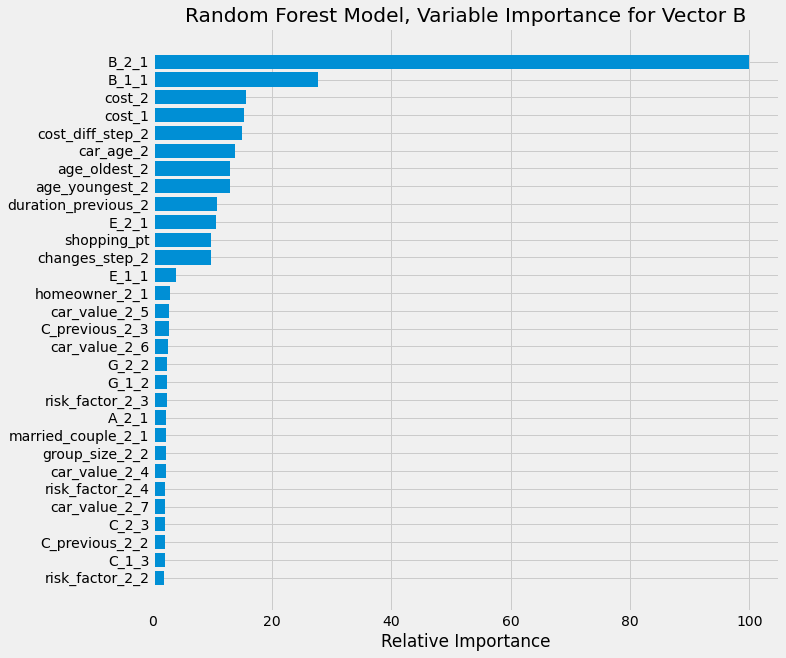

In [314]:
plt.style.use("fivethirtyeight")

vector = 'B'

rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, plot=True)
    

In [47]:
# LEt's find the accuracy if final Vector B was predicted simply as B_2

vector = 'B'
df_train_first2 = pd.read_csv('WIP_data/training_data_with_first2_quotes.csv')
test_set = df_train_first2.iloc[y_test.index,:]
x = pd.crosstab(test_set['B'], test_set['B_2'])
same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")

Accuracy based on simply predicting vector B = B_2 :  0.8334


In [9]:
x['total'] = x.sum(axis=1)
x['B0_%'] = np.around(x[0]*100 / x['total'], 2)
x['B1_%'] = np.around(x[1]*100 / x['total'], 2)
x

B_2     0     1  total   B0_%   B1_%
B                                   
0    7117   979   8096  87.91  12.09
1    1607  5819   7426  21.64  78.36

In [6]:
# Now let's try a Randomized Search CV to find the best Random Forest classifier for vector B

from sklearn.model_selection import RandomizedSearchCV

vector = 'B'
param_grid = {'n_estimators' : np.arange(100,801,100), 'min_samples_split': np.arange(2,6), \
              'min_samples_leaf': np.arange(1,5)}
rf = RandomForestClassifier(random_state = 1, n_jobs=-1)
rf_cv = RandomizedSearchCV(rf, param_grid, n_iter = 20, verbose = 3, cv=4)
rf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))
print("Random Forest Model\nBest Score:" + str(rf_cv.best_score_))
print("\nBest Parameters: " + str(rf_cv.best_params_)) 

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV 1/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.843 total time=  18.5s
[CV 2/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.841 total time=  16.3s
[CV 3/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.833 total time=  16.6s
[CV 4/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.838 total time=  16.2s
[CV 1/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=300;, score=0.844 total time=  15.4s
[CV 2/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=300;, score=0.840 total time=  15.1s
[CV 3/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=300;, score=0.832 total time=  15.0s
[CV 4/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=300;, score=0.837 total time=  14.9s
[CV 1/4] END min_samples_leaf=3, min_samples_split=3, n_estimators=700;, score=0.844 total time=  33.8s
[CV

[CV 4/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=700;, score=0.837 total time=  32.8s
Random Forest Model
Best Score:0.8389465246535858

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1}


Random Forest Classifier results for Vector B

Accuracy=0.835
f1-score=0.835
Confusion Matrix
 [[0.875 0.125]
 [0.208 0.792]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      8096
           1       0.85      0.79      0.82      7426

    accuracy                           0.84     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.84      0.84      0.83     15522

Area under ROC: 
 0.8791002798760683
30


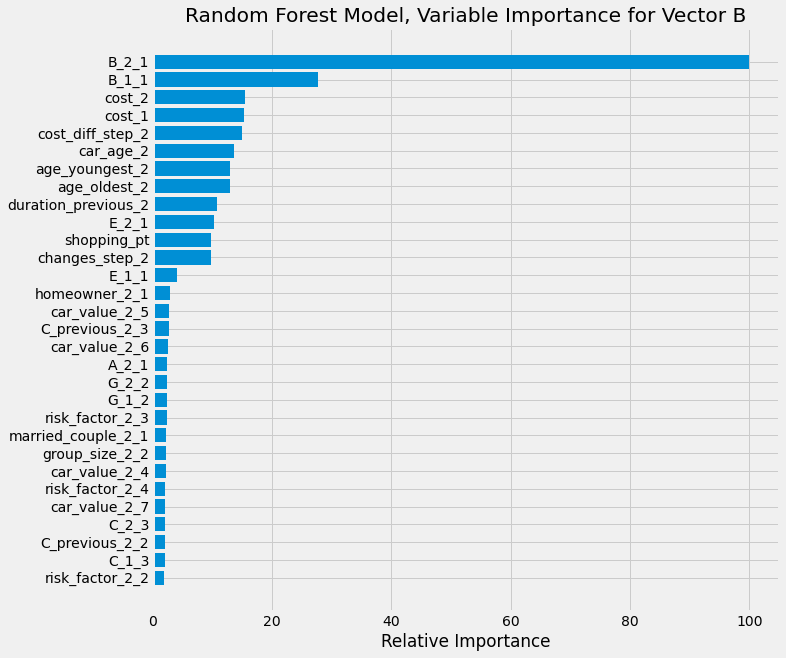

In [7]:

plt.style.use("fivethirtyeight")

vector = 'B'

rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=200, min_samples_leaf = 1, min_samples_split = 2, plot = True)


In [195]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test[vector].astype('int'), rf_probs)
thresholds_rf = np.append(thresholds_rf, 1.0)

In [219]:
# As B is a binary vector, let's predict it with a Logistic Regression model

vector = 'B'

lr_ac, lr_f1, lr_probs = lr_predict(vector)


Logistic Regression: Accuracy=0.834
Logistic Regression: f1-score=0.833
Confusion Matrix
 [[0.87858202 0.12141798]
 [0.21559386 0.78440614]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      8096
           1       0.86      0.78      0.82      7426

    accuracy                           0.83     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.84      0.83      0.83     15522



C:\Users\amite\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [187]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test[vector].astype('int'), lr_probs)
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test[vector].astype('int'), lr_probs)
roc_auc2 = auc(fpr_2, tpr_2)
roc_auc2

0.8707366237522474

In [163]:

# Now let's try a Grid Search CV to find the best GradientBoosting classifier

from sklearn.ensemble import GradientBoostingClassifier

param_grid = {'learning_rate' : [0.25, 0.5, 0.75, 1], 'n_estimators' : [20, 50, 100, 150], \
              'max_features': [2,4,6,8], 'max_depth' : [1,2,3]}

gb = GradientBoostingClassifier(random_state = 1)
gb_cv = GridSearchCV(gb, param_grid, cv=5)
gb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print("Gradient Boosting Model\nBest Score:" + str(gb_cv.best_score_))
print("\nBest Parameters: " + str(gb_cv.best_params_))
      

Gradient Boosting Model
Best Score:0.8385600386566804

Best Parameters: {'learning_rate': 0.25, 'max_depth': 3, 'max_features': 6, 'n_estimators': 150}


Gradient Boosting Classifier results for Vector B

Accuracy=0.833
f1-score=0.833
Confusion Matrix
 [[0.876 0.124]
 [0.213 0.787]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      8096
           1       0.85      0.79      0.82      7426

    accuracy                           0.83     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.83      0.83      0.83     15522



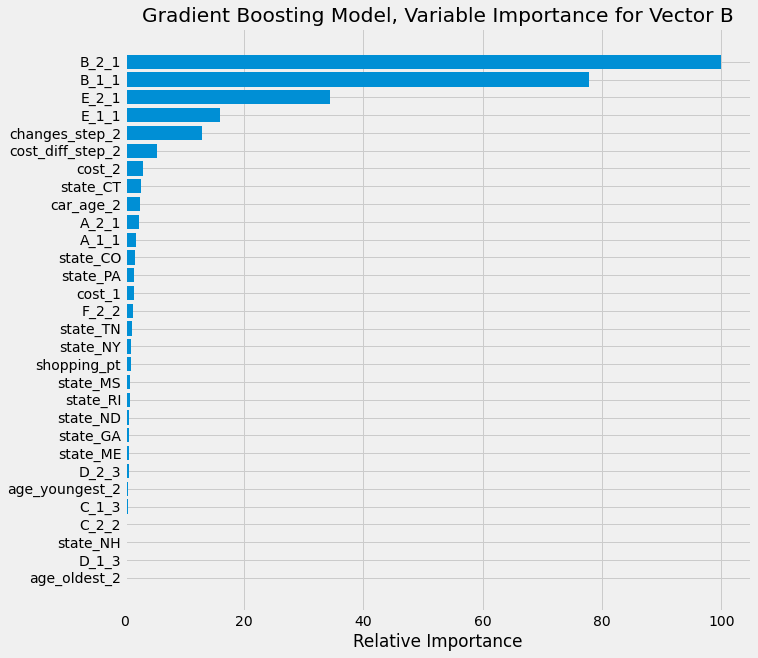

In [316]:
# Now let's train a GB model with above parameters and calculate the different metrics

vector = 'B'
gb_ac, gb_f1, gb_probs = gb_predict_plot(vector, n_estimators = 150, learning_rate = 0.25, max_depth = 3, max_features = 6, plot=True)


fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), gb_probs)


In [186]:
roc_auc3 = auc(fpr_3, tpr_3)
roc_auc3

0.8752734490184578

In [198]:
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test[vector].astype('int'), gb_probs)


In [167]:
# The fourth model that we test is a KNN classifier. Let's use Grid Search to find the best hyperparameter

from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(1, 50)}
knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print("KNN Model\nBest Score:" + str(knn_cv.best_score_))
print("\nBest Parameters: " + str(knn_cv.best_params_))


KNN Model
Best Score:0.7973584601755658

Best Parameters: {'n_neighbors': 49}


In [318]:
knn = KNeighborsClassifier(n_neighbors=49)

knn.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = knn.predict(X_test.to_numpy())
y_pred_prob = knn.predict_proba(X_test.to_numpy())
kn_probs = y_pred_prob[:,1]

ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'), 3)

print(f'KNN Model for Vector {vector}: No. of Neighbors = {knn_cv.best_params_}' )

print('Accuracy=%.3f' % (ac))
print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test['B'].astype('int'), y_pred)

print("\nClassification Report \n", cr)

fpr_4, tpr_4, thresholds_4 = roc_curve(y_test[vector].astype('int'), kn_probs)


KNN Model for Vector B: No. of Neighbors = {'n_neighbors': 49}
Accuracy=0.793
f1-score=0.793
Confusion Matrix
 [[0.845 0.155]
 [0.263 0.737]]

Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.85      0.81      8096
           1       0.81      0.74      0.77      7426

    accuracy                           0.79     15522
   macro avg       0.80      0.79      0.79     15522
weighted avg       0.80      0.79      0.79     15522



In [185]:
roc_auc4 = auc(fpr_4, tpr_4)
roc_auc4

0.841081327197785

In [200]:
precision_kn, recall_kn, thresholds_kn = precision_recall_curve(y_test[vector].astype('int'), kn_probs)

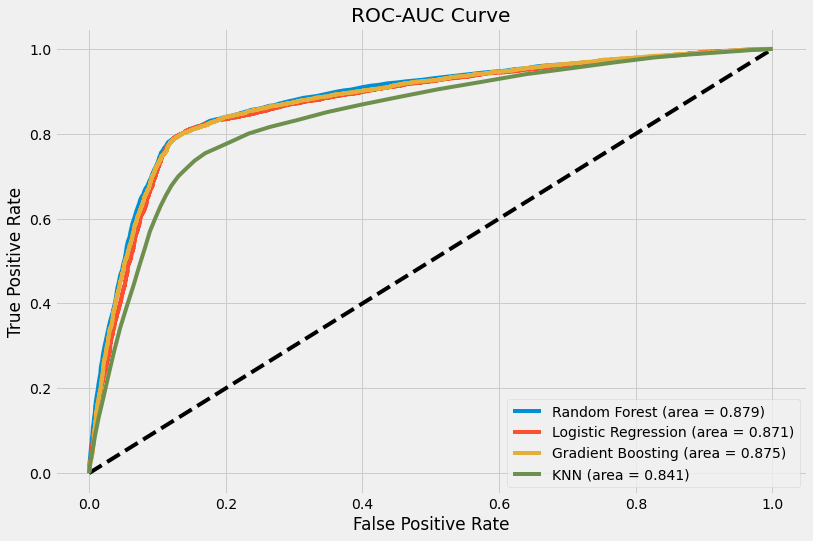

In [189]:

plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Random Forest (area = 0.879)')
plt.plot(fpr_2, tpr_2, label='Logistic Regression (area = 0.871)')
plt.plot(fpr_3, tpr_3, label='Gradient Boosting (area = 0.875)')
plt.plot(fpr_4, tpr_4, label='KNN (area = 0.841)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.show()


Best Threshold for Random Forest Model = 0.4925
At Best Threshold, tpr = 0.792, fpr = 0.126


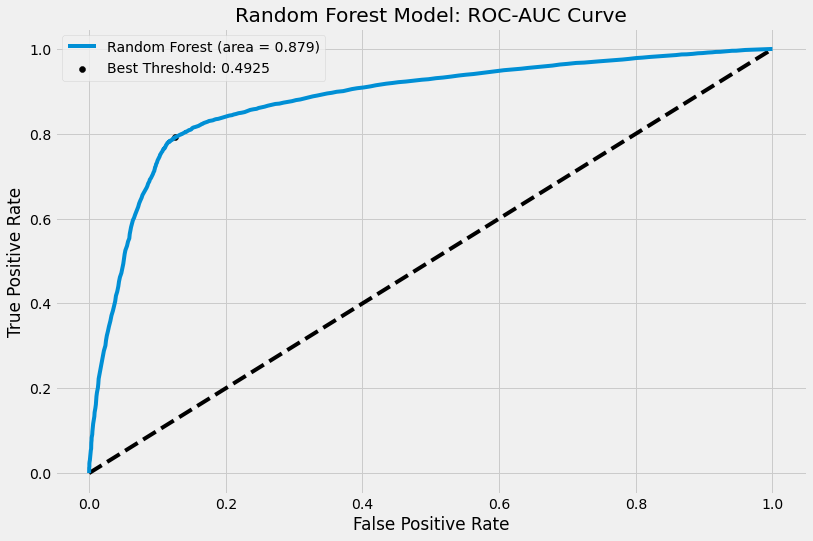

In [237]:
# Let's do thresholding to find the probability threshold that gives the best model performance

plt.figure(figsize=(12,8))

Q_means_rf = np.sqrt(tpr_1*(1-fpr_1))
idx = np.argmax(Q_means_rf)

print(f'Best Threshold for Random Forest Model = {thresholds_1[idx]}')
print(f'At Best Threshold, tpr = {tpr_1[idx]:4.3}, fpr = {fpr_1[idx]:4.3}')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Random Forest (area = 0.879)')
pyplot.scatter(fpr_1[idx], tpr_1[idx], marker='o', color='black', label='Best Threshold: '+str(thresholds_1[idx]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Model: ROC-AUC Curve')
plt.legend()
plt.show()


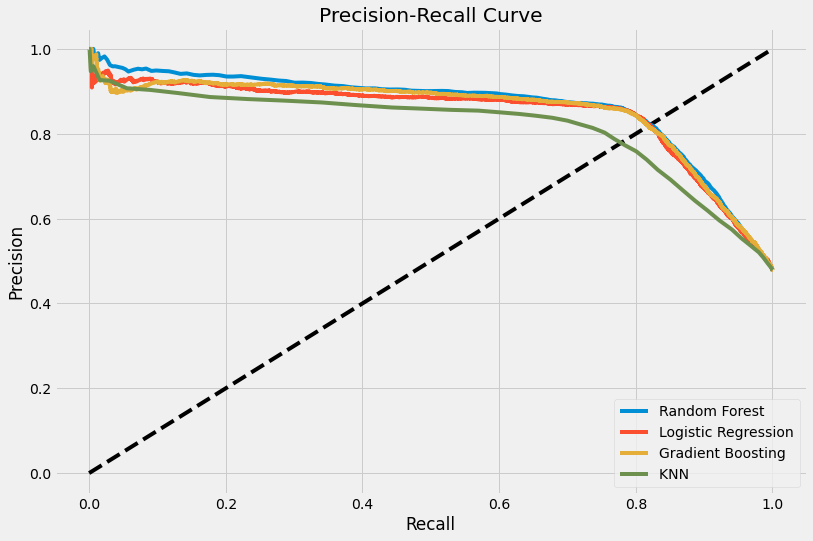

In [230]:
#Let's plot the precision-recall curves for all models

plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.plot(recall_lr, precision_lr, label='Logistic Regression')
plt.plot(recall_gb, precision_gb, label='Gradient Boosting')
plt.plot(recall_kn, precision_kn, label='KNN ')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


Best Accuracy score of 0.835 occurs for threshold = 0.491


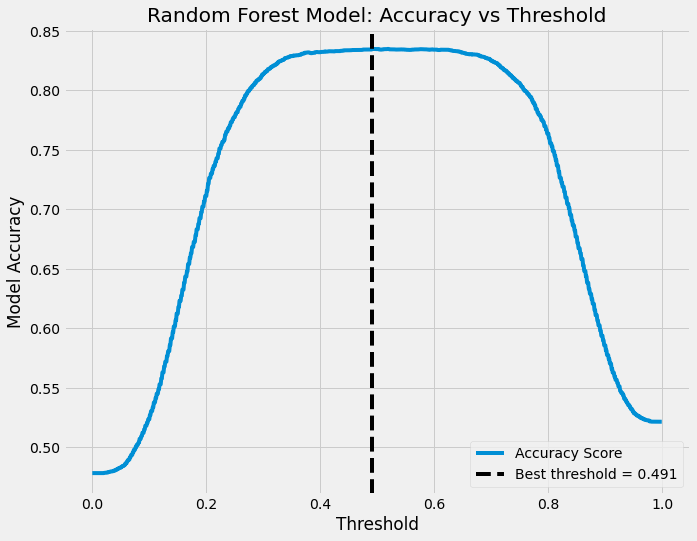

In [238]:
# We are concerned with accuracy of the model i.e. its ability to predict both the 0 and 1 labels correctly
# So we will calculate the accuracy score at different thresholds directly

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = np.arange(0, 1, 0.001)

ac_score = [accuracy_score(y_test[vector].astype('int'), to_labels(rf_probs, t)) for t in thresholds]

idx = np.argmax(ac_score)

print(f"Best Accuracy score of {ac_score[idx]:4.3} occurs for threshold = {thresholds[idx]:4.3}")

plt.figure(figsize=(10,8))
plt.plot(thresholds, ac_score, label='Accuracy Score')
plt.xlabel('Threshold')
plt.ylabel('Model Accuracy')
plt.title('Random Forest Model: Accuracy vs Threshold')
plt.axvline(thresholds[idx], color='black', linestyle="--", label = "Best threshold = "+str(thresholds[idx]))
plt.legend()
plt.show()


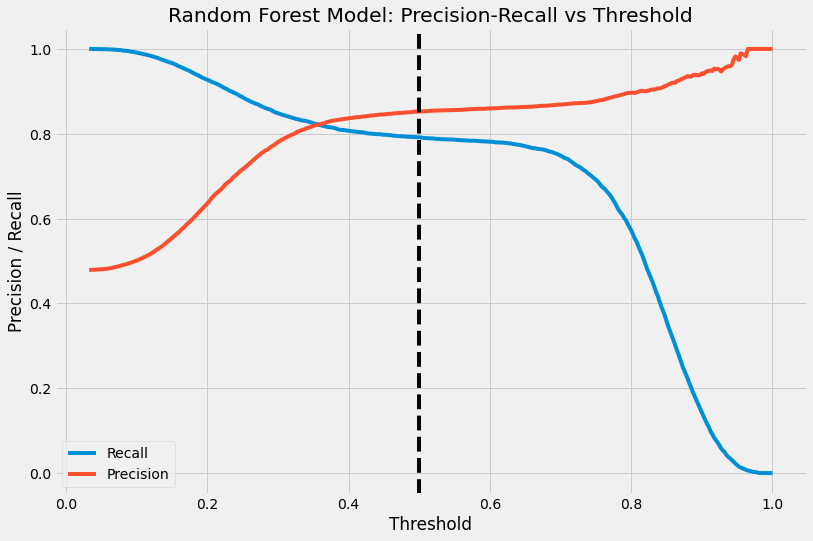

In [216]:
plt.figure(figsize=(12,8))

#plt.plot([0, 1], [0, 1], 'k--')
plt.plot(thresholds_rf, recall_rf, label='Recall')
plt.plot(thresholds_rf, precision_rf, label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Random Forest Model: Precision-Recall vs Threshold')
plt.axvline(0.5, color='black', linestyle="--")
plt.legend()
plt.show()


XGBoost Classifier results for Vector B

Parameters: No. of Estimators = 300,  max_depth = 3, learning_rate = 0.35, colsample_bytree = 1

Accuracy=0.834
f1-score=0.833
Confusion Matrix
 [[0.871 0.129]
 [0.207 0.793]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.87      0.85      8096
           1       0.85      0.79      0.82      7426

    accuracy                           0.83     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.83      0.83      0.83     15522

30


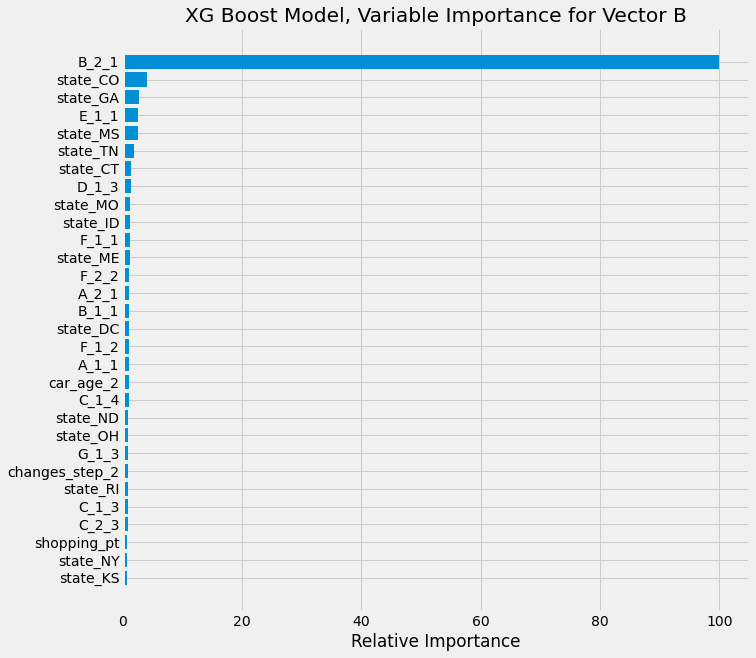

In [61]:
# model B with XGBoost classifier

import xgboost as xgb

vector = 'B'

#param_grid
n_estimators = 300
max_depth = 3
learning_rate = 0.35
colsample_bytree = 1
        
clf = xgb.XGBClassifier(max_depth=max_depth, objective='binary:logistic', n_estimators=n_estimators, \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree)

clf.fit(X_train.to_numpy(), y_train[vector])
y_pred = clf.predict(X_test.to_numpy())
y_pred_prob = clf.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)


print(f"XGBoost Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}\n")

print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('XG Boost Model, Variable Importance for Vector '+vector)
plt.show()

In [8]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector B 

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'B'

param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)

clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = 60, verbose = 3, cv=4)

clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.836 total time=  10.9s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.832 total time=  11.8s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.822 total time=  11.9s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.830 total time=  12.3s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=300;, score=0.838 total time=  10.1s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=300;, score=0.834 total time=  10.2s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=300;, score=0.827 total time=  10.1s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=300;, score=0.836 total tim

[CV 2/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.840 total time=   2.9s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.831 total time=   2.9s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.836 total time=   2.9s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.839 total time=   3.4s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.836 total time=   3.4s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.829 total time=   3.4s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.835 total time=   3.4s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=200;, score=0.845 total time=   2.5s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.

[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=400;, score=0.836 total time=   6.4s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=400;, score=0.844 total time=   7.8s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=400;, score=0.841 total time=   7.9s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=400;, score=0.831 total time=   7.8s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=400;, score=0.838 total time=   7.8s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.844 total time=   6.0s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.841 total time=   5.9s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.830 total time=   6.1s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.

[CV 2/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.840 total time=   3.6s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.832 total time=   3.6s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.837 total time=   3.6s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.839 total time=  11.9s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.837 total time=  12.5s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.827 total time=  13.0s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.836 total time=  13.9s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.844 total time=   6.1s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_d

In [14]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']


In [28]:
# model B with XGBoost classifier

# Parameters: No. of Estimators = 100,  max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.5 (0.834, 0.833)
# Parameters: No. of Estimators = 400,  max_depth = 3, learning_rate = 0.3, colsample_bytree = 0.15 (0.834, 0.834)

import xgboost as xgb

vector = 'B'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='binary:logistic', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    rf_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results.loc[i, 'test_score'] = ac
    results.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}\n")

    print('Accuracy=%.3f' % (ac))
    print('f1-score=%.3f' % (f1))

results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
results

XGBoost Classifier results for Vector B

Parameters: No. of Estimators = 500.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.15

Accuracy=0.829
f1-score=0.829
Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.35, colsample_bytree = 0.25

Accuracy=0.830
f1-score=0.830
Parameters: No. of Estimators = 100.0,  max_depth = 5.0,     learning_rate = 0.5, colsample_bytree = 0.5

Accuracy=0.833
f1-score=0.832
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.25

Accuracy=0.834
f1-score=0.833
Parameters: No. of Estimators = 200.0,  max_depth = 3.0,     learning_rate = 0.3, colsample_bytree = 0.25

Accuracy=0.834
f1-score=0.834
Parameters: No. of Estimators = 400.0,  max_depth = 3.0,     learning_rate = 0.35, colsample_bytree = 0.15

Accuracy=0.834
f1-score=0.834
Parameters: No. of Estimators = 500.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.15

Accuracy=0.833
f1-score=0.833

In [33]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            500          4           0.50              0.15     0.830055   
1            300          5           0.35              0.25     0.833518   
2            100          5           0.50              0.50     0.835178   
3            200          4           0.30              0.25     0.837851   
4            200          3           0.30              0.25     0.838512   
5            400          3           0.35              0.15     0.837658   
6            500          4           0.30              0.15     0.835757   
7            100          5           0.25              0.50     0.838447   
8            300          4           0.25              0.25     0.837722   
9            100          5           0.50              0.25     0.835145   
10           400          4           0.50              0.25     0.830974   
11           200          5           0.50              0.15     0.832230   
12           400          5           0.50              0.25     0.824112   
13           500          5           0.25              0.50     0.831988   
14           200          5           0.30              0.25     0.836820   
15           100          4           0.35              0.25     0.838399   
16           100          3           0.50              0.50     0.837787   
17           200          3           0.35              0.25     0.837867   
18           200          4           0.50              0.25     0.834839   
19           200          3           0.25              0.15     0.838802   
20           200          3           0.50              0.15     0.838302   
21           100          4           0.30              0.25     0.838737   
22           200          3           0.25              0.35     0.838753   
23           100          5           0.35              0.25     0.837722   
24           200          5           0.25              0.25     0.837465   
25           300          4           0.25              0.50     0.837755   
26           200          5           0.35              0.15     0.836160   
27           500          3           0.50              0.25     0.834726   
28           200          4           0.35              0.25     0.836933   
29           500          5           0.25              0.25     0.834614   
30           400          4           0.50              0.15     0.831892   
31           300          4           0.50              0.15     0.833921   
32           300          5           0.30              0.50     0.833470   
33           300          3           0.50              0.15     0.836837   
34           400          3           0.35              0.35     0.836885   
35           400          3           0.25              0.50     0.838447   
36           500          3           0.25              0.15     0.838189   
37           200          4           0.35              0.50     0.836708   
38           300          4           0.30              0.25     0.836837   
39           200          5           0.50              0.35     0.830072   
40           400          4           0.50              0.35     0.829717   
41           400          5           0.35              0.35     0.830925   
42           100          4           0.25              0.35     0.838850   
43           300          4           0.25              0.15     0.838045   
44           100          4           0.30              0.35     0.838898   
45           400          5           0.35              0.15     0.833712   
46           300          5           0.30              0.35     0.835081   
47           400          3           0.50              0.15     0.836579   
48           300          3           0.30              0.35     0.838077   
49           200          3           0.25              0.50     0.839075   
50           500          3           0.25              0.50     0.837964   


In [34]:
datapath = "Modelling_data"

save_file(results, 'xgboost_results_vectorB.csv', datapath)


Directory Modelling_data was created.
Writing file.  "Modelling_data\xgboost_results_vectorB.csv"


### Predicting Vector G

Random Forest Classifier results for Vector G

Accuracy=0.758
f1-score=0.758
Confusion Matrix
 [[0.717 0.231 0.038 0.014]
 [0.118 0.818 0.042 0.022]
 [0.054 0.136 0.767 0.043]
 [0.064 0.179 0.212 0.545]]

Classification Report 
               precision    recall  f1-score   support

           1       0.68      0.72      0.70      3188
           2       0.75      0.82      0.78      6097
           3       0.85      0.77      0.81      4947
           4       0.64      0.54      0.59      1290

    accuracy                           0.76     15522
   macro avg       0.73      0.71      0.72     15522
weighted avg       0.76      0.76      0.76     15522

30


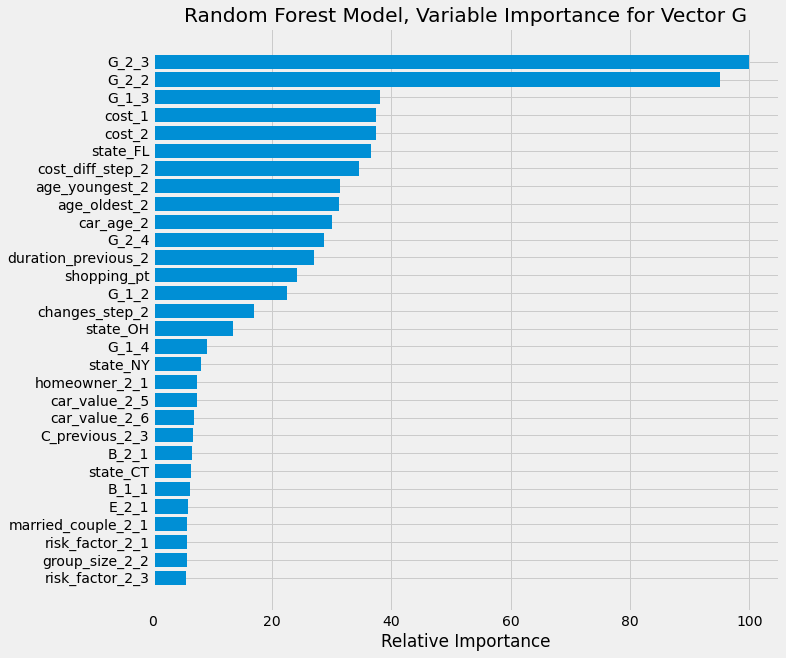

In [312]:
# Let's run A Random Forest model for vector G


plt.style.use("fivethirtyeight")

vector = 'G'

    
clf = RandomForestClassifier(n_estimators=300,  random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = model_res.predict(X_test.to_numpy())
y_pred_prob = model_res.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Random Forest Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Model, Variable Importance for Vector '+vector)
plt.show()

In [10]:
#test_set = df_train_first2.iloc[y_test.index,:]

vector = 'G'

x = pd.crosstab(test_set['G'], test_set['G_2'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")

Accuracy based on simply predicting vector G = G_2 :  0.7405


In [311]:
x['total'] = x.sum(axis=1)
x['G1_%'] = np.around(x[1]*100 / x['total'], 2)
x['G2_%'] = np.around(x[2]*100 / x['total'], 2)
x['G3_%'] = np.around(x[3]*100 / x['total'], 2)
x['G4_%'] = np.around(x[4]*100 / x['total'], 2)

x

G_2     1     2     3    4  total   G1_%   G2_%   G3_%   G4_%
G                                                            
1    2239   711   115  123   3188  70.23  22.30   3.61   3.86
2     717  4873   230  277   6097  11.76  79.92   3.77   4.54
3     271   778  3587  311   4947   5.48  15.73  72.51   6.29
4      78   200   217  795   1290   6.05  15.50  16.82  61.63

In [10]:
# Let's use Bayesian Optimization to find best parameters for Random Forest model for vector G
from bayes_opt import BayesianOptimization

vector = 'G'

def rf_eval(estimators, min_leaf, min_split):
    
    rf = RandomForestClassifier(n_estimators = round(estimators), min_samples_leaf = round(min_leaf), \
                                    min_samples_split = round(min_split), random_state = 1, n_jobs=-1)
    
    cv_result = cross_validate(rf, X_train.to_numpy(), y_train[vector].astype('int'), cv= 4)
    return np.mean(cv_result['test_score'])

rf_bo = BayesianOptimization(rf_eval, {'estimators': (20, 1000), 'min_leaf': (1, 5), 'min_split': (2, 6)})

rf_bo.maximize(n_iter=13, init_points=2)

|   iter    |  target   | estima... | min_leaf  | min_split |
-------------------------------------------------------------
|  1        |  0.7637   |  980.2    |  4.41     |  2.007    |
|  2        |  0.7635   |  813.3    |  4.254    |  5.076    |
|  3        |  0.7637   |  981.2    |  4.008    |  2.714    |
|  4        |  0.7637   |  969.2    |  4.237    |  2.307    |
|  5        |  0.7636   |  949.4    |  4.294    |  2.335    |
|  6        |  0.7628   |  49.93    |  3.636    |  4.438    |
|  7        |  0.7635   |  640.7    |  3.804    |  2.048    |
|  8        |  0.7639   |  540.6    |  1.258    |  5.379    |
|  9        |  0.7638   |  496.5    |  4.248    |  5.125    |
|  10       |  0.7636   |  578.9    |  4.287    |  3.231    |
|  11       |  0.7641   |  417.9    |  2.296    |  2.558    |
|  12       |  0.7639   |  379.6    |  1.503    |  4.101    |
|  13       |  0.7644   |  447.3    |  1.129    |  5.617    |
|  14       |  0.7635   |  298.6    |  2.63     |  5.993    |
|  15   

Random Forest Classifier results for Vector G

Parameters: No. of Estimators = 450,  min_samples_split = 6, min_samples_leaf = 1

Accuracy=0.757
f1-score=0.756
Confusion Matrix
 [[0.714 0.234 0.037 0.014]
 [0.117 0.818 0.042 0.023]
 [0.053 0.138 0.764 0.044]
 [0.067 0.18  0.209 0.544]]

Classification Report 
               precision    recall  f1-score   support

           1       0.68      0.71      0.70      3188
           2       0.75      0.82      0.78      6097
           3       0.85      0.76      0.81      4947
           4       0.63      0.54      0.59      1290

    accuracy                           0.76     15522
   macro avg       0.73      0.71      0.72     15522
weighted avg       0.76      0.76      0.76     15522

30


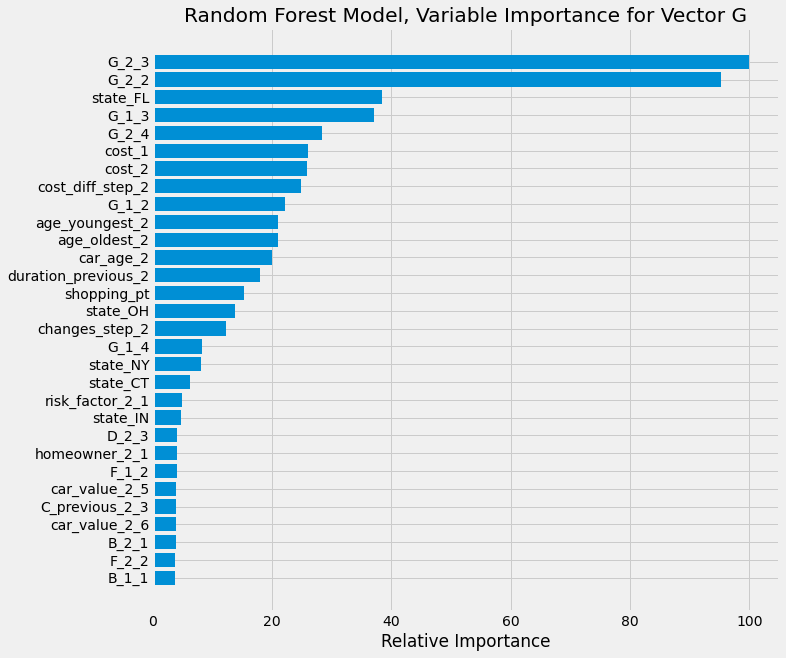

In [15]:
# Run the model with Best Parameters (iteration 13): n_estimators=450, min_samples_leaf = 1, min_samples_split = 6

vector = 'G'
# param_grid
n_estimators=450
min_samples_leaf = 1
min_samples_split = 6
    
clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf = min_samples_leaf, \
                             min_samples_split = min_samples_split, random_state = 1,n_jobs=-1)

model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = model_res.predict(X_test.to_numpy())
y_pred_prob = model_res.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)


print(f"Random Forest Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  min_samples_split = {min_samples_split}, min_samples_leaf = {min_samples_leaf}\n")

print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Model, Variable Importance for Vector '+vector)
plt.show()

Random Forest Classifier results for Vector G

Parameters: No. of Estimators = 420,  min_samples_split = 3, min_samples_leaf = 2

Accuracy=0.757
f1-score=0.757
Confusion Matrix
 [[0.715 0.234 0.037 0.014]
 [0.117 0.819 0.041 0.022]
 [0.053 0.138 0.765 0.044]
 [0.067 0.184 0.209 0.54 ]]

Classification Report 
               precision    recall  f1-score   support

           1       0.68      0.72      0.70      3188
           2       0.75      0.82      0.78      6097
           3       0.86      0.76      0.81      4947
           4       0.63      0.54      0.58      1290

    accuracy                           0.76     15522
   macro avg       0.73      0.71      0.72     15522
weighted avg       0.76      0.76      0.76     15522

30


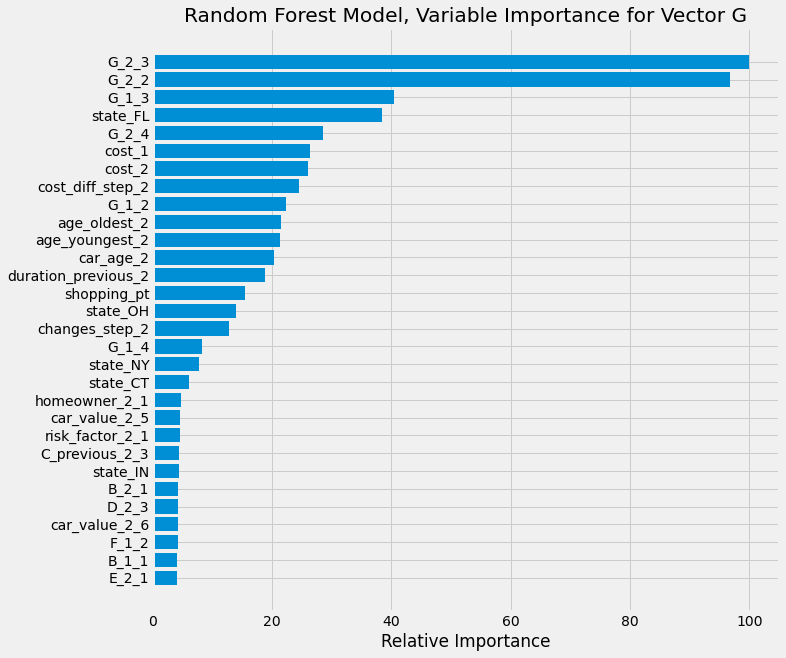

In [13]:
# Run the model with 2nd Best Parameters (iteration 11): n_estimators=420, min_samples_leaf = 2, min_samples_split = 3

vector = 'G'
# param_grid
n_estimators=420
min_samples_leaf = 2
min_samples_split = 3
    
clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf = min_samples_leaf, \
                             min_samples_split = min_samples_split, random_state = 1,n_jobs=-1)

model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = model_res.predict(X_test.to_numpy())
y_pred_prob = model_res.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)


print(f"Random Forest Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  min_samples_split = {min_samples_split}, min_samples_leaf = {min_samples_leaf}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Model, Variable Importance for Vector '+vector)
plt.show()

Random Forest Classifier results for Vector G

Parameters: No. of Estimators = 550,  min_samples_split = 5, min_samples_leaf = 1

Accuracy=0.758
f1-score=0.758
Confusion Matrix
 [[0.716 0.232 0.037 0.014]
 [0.117 0.82  0.041 0.022]
 [0.053 0.137 0.765 0.045]
 [0.068 0.178 0.209 0.545]]

Classification Report 
               precision    recall  f1-score   support

           1       0.68      0.72      0.70      3188
           2       0.75      0.82      0.78      6097
           3       0.86      0.77      0.81      4947
           4       0.64      0.54      0.59      1290

    accuracy                           0.76     15522
   macro avg       0.73      0.71      0.72     15522
weighted avg       0.76      0.76      0.76     15522

30


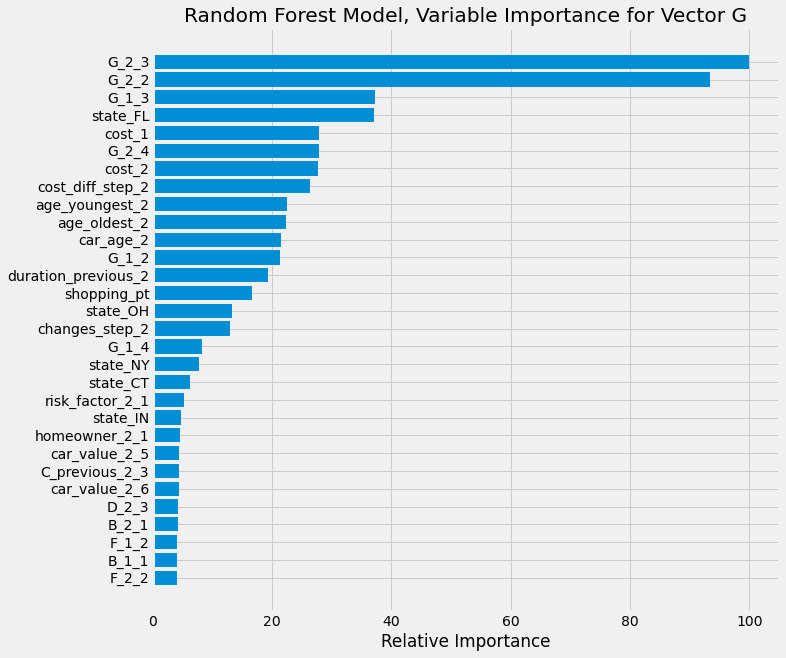

In [14]:
# Run the model with 3rd Best Parameters (iteration 8): n_estimators=550, min_samples_leaf = 1, min_samples_split = 5



plt.style.use("fivethirtyeight")

vector = 'G'
# param_grid
n_estimators=550
min_samples_leaf = 1
min_samples_split = 5
    
clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf = min_samples_leaf, \
                             min_samples_split = min_samples_split, random_state = 1,n_jobs=-1)

model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = model_res.predict(X_test.to_numpy())
y_pred_prob = model_res.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)


print(f"Random Forest Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  min_samples_split = {min_samples_split}, min_samples_leaf = {min_samples_leaf}\n")

print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Model, Variable Importance for Vector '+vector)
plt.show()

Using the hyperparameters from Bayesian Optimization, the best score (accuracy = 0.758, f1_score = 0.758) is still only as good as the base model with 300 estimators. So we shall keep the base model as it has lesser estimators and hence would use less computational resources. 

Now let's build a Gradient Boosting Classifier for Vector G.

Gradient Boosting Classifier results for Vector G

Accuracy=0.753
f1-score=0.752
Confusion Matrix
 [[0.705 0.24  0.039 0.017]
 [0.117 0.816 0.045 0.022]
 [0.054 0.136 0.766 0.043]
 [0.071 0.186 0.216 0.526]]

Classification Report 
               precision    recall  f1-score   support

           1       0.68      0.70      0.69      3188
           2       0.75      0.82      0.78      6097
           3       0.85      0.77      0.81      4947
           4       0.63      0.53      0.57      1290

    accuracy                           0.75     15522
   macro avg       0.73      0.70      0.71     15522
weighted avg       0.76      0.75      0.75     15522



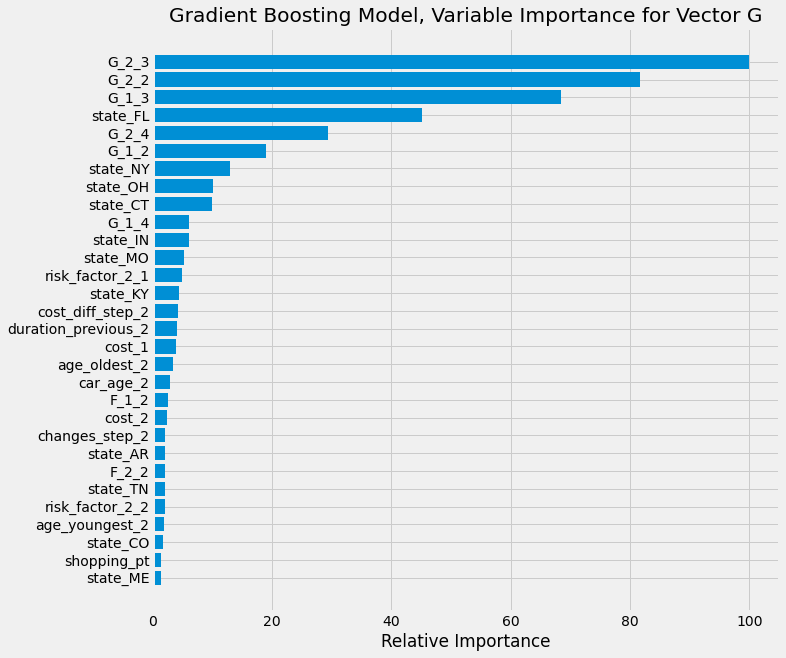

In [319]:
# model G with GradientBoosting classifier

vector = 'G'

gb = GradientBoostingClassifier(n_estimators = 150, learning_rate = 0.25, max_depth = 3, max_features = 6, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

In [320]:
# Let's use RandomizedSearchCV to find the best GradientBoosting classifier Hyperparamters for vector G 

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

vector = 'G'

param_grid = {'learning_rate' : [0.05, 0.1, 0.25, 0.5, 0.75, 1], 'n_estimators' : [20, 50, 100, 150, 200], \
              'max_features': [2,4,6,8], 'max_depth' : [1,2,3,4]}

gb = GradientBoostingClassifier(random_state = 1)

gb_cv = RandomizedSearchCV(gb, param_grid, n_iter = 60, verbose = 2, cv=5)

gb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: Gradient Boosting Model\nBest Score:" + str(gb_cv.best_score_))
print("\nBest Parameters: " + str(gb_cv.best_params_))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END learning_rate=0.25, max_depth=2, max_features=4, n_estimators=20; total time=   3.9s
[CV] END learning_rate=0.25, max_depth=2, max_features=4, n_estimators=20; total time=   3.4s
[CV] END learning_rate=0.25, max_depth=2, max_features=4, n_estimators=20; total time=   3.2s
[CV] END learning_rate=0.25, max_depth=2, max_features=4, n_estimators=20; total time=   3.3s
[CV] END learning_rate=0.25, max_depth=2, max_features=4, n_estimators=20; total time=   3.3s
[CV] END learning_rate=0.05, max_depth=3, max_features=4, n_estimators=20; total time=   3.9s
[CV] END learning_rate=0.05, max_depth=3, max_features=4, n_estimators=20; total time=   5.3s
[CV] END learning_rate=0.05, max_depth=3, max_features=4, n_estimators=20; total time=   4.0s
[CV] END learning_rate=0.05, max_depth=3, max_features=4, n_estimators=20; total time=   3.9s
[CV] END learning_rate=0.05, max_depth=3, max_features=4, n_estimators=20; total time=   4.2

[CV] END learning_rate=0.75, max_depth=4, max_features=2, n_estimators=50; total time=   9.0s
[CV] END learning_rate=0.75, max_depth=4, max_features=2, n_estimators=50; total time=   9.1s
[CV] END learning_rate=0.75, max_depth=4, max_features=2, n_estimators=50; total time=   8.8s
[CV] END learning_rate=0.75, max_depth=3, max_features=2, n_estimators=100; total time=  15.7s
[CV] END learning_rate=0.75, max_depth=3, max_features=2, n_estimators=100; total time=  15.6s
[CV] END learning_rate=0.75, max_depth=3, max_features=2, n_estimators=100; total time=  15.6s
[CV] END learning_rate=0.75, max_depth=3, max_features=2, n_estimators=100; total time=  15.7s
[CV] END learning_rate=0.75, max_depth=3, max_features=2, n_estimators=100; total time=  15.8s
[CV] END learning_rate=1, max_depth=3, max_features=6, n_estimators=50; total time=  11.9s
[CV] END learning_rate=1, max_depth=3, max_features=6, n_estimators=50; total time=  11.7s
[CV] END learning_rate=1, max_depth=3, max_features=6, n_esti

[CV] END learning_rate=0.5, max_depth=2, max_features=8, n_estimators=20; total time=   4.5s
[CV] END learning_rate=0.5, max_depth=2, max_features=8, n_estimators=20; total time=   4.3s
[CV] END learning_rate=0.5, max_depth=2, max_features=8, n_estimators=20; total time=   4.2s
[CV] END learning_rate=0.5, max_depth=2, max_features=8, n_estimators=20; total time=   4.3s
[CV] END learning_rate=0.5, max_depth=2, max_features=8, n_estimators=20; total time=   4.4s
[CV] END learning_rate=0.05, max_depth=4, max_features=8, n_estimators=100; total time=  33.5s
[CV] END learning_rate=0.05, max_depth=4, max_features=8, n_estimators=100; total time=  33.7s
[CV] END learning_rate=0.05, max_depth=4, max_features=8, n_estimators=100; total time=  33.5s
[CV] END learning_rate=0.05, max_depth=4, max_features=8, n_estimators=100; total time=  33.3s
[CV] END learning_rate=0.05, max_depth=4, max_features=8, n_estimators=100; total time=  33.8s
[CV] END learning_rate=0.05, max_depth=2, max_features=8, n_

[CV] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=100; total time=  23.8s
[CV] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=100; total time=  23.7s
[CV] END learning_rate=1, max_depth=2, max_features=6, n_estimators=50; total time=   9.5s
[CV] END learning_rate=1, max_depth=2, max_features=6, n_estimators=50; total time=   9.4s
[CV] END learning_rate=1, max_depth=2, max_features=6, n_estimators=50; total time=   9.4s
[CV] END learning_rate=1, max_depth=2, max_features=6, n_estimators=50; total time=   9.3s
[CV] END learning_rate=1, max_depth=2, max_features=6, n_estimators=50; total time=   9.4s
[CV] END learning_rate=0.5, max_depth=1, max_features=6, n_estimators=20; total time=   2.7s
[CV] END learning_rate=0.5, max_depth=1, max_features=6, n_estimators=20; total time=   2.7s
[CV] END learning_rate=0.5, max_depth=1, max_features=6, n_estimators=20; total time=   2.7s
[CV] END learning_rate=0.5, max_depth=1, max_features=6, n_estimators=20; to

Gradient Boosting Classifier results for Vector G

Accuracy=0.756
f1-score=0.755
Confusion Matrix
 [[0.713 0.234 0.038 0.014]
 [0.119 0.817 0.045 0.02 ]
 [0.053 0.136 0.771 0.04 ]
 [0.07  0.191 0.226 0.513]]

Classification Report 
               precision    recall  f1-score   support

           1       0.68      0.71      0.70      3188
           2       0.75      0.82      0.78      6097
           3       0.85      0.77      0.81      4947
           4       0.65      0.51      0.57      1290

    accuracy                           0.76     15522
   macro avg       0.73      0.70      0.71     15522
weighted avg       0.76      0.76      0.75     15522



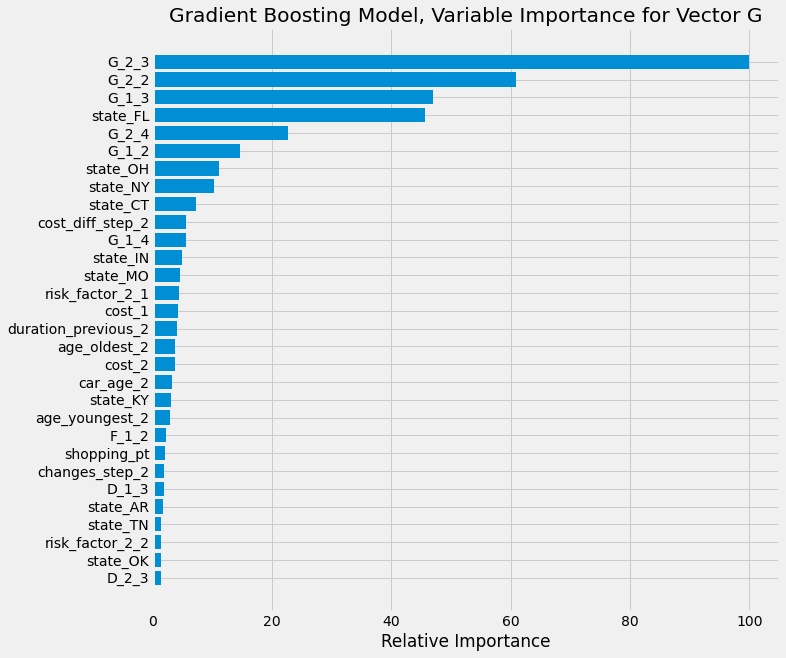

In [321]:
# GradientBoosting classifier for G with best Hyperparameters {'n_estimators': 200, 
# 'max_features': 6, 'max_depth': 4, 'learning_rate': 0.25}

vector = 'G'

gb = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.25, max_depth = 4, max_features = 6, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

This model improves performance over the base GB model, but is still not as good as the Random Forest model. Let's manually tweak a couple of parameters and check the performance.

Gradient Boosting Classifier results for Vector G

Parameters: No. of Estimators = 200,  learning_rate = 0.25, max_depth = 3, max_features = 8

Accuracy=0.757
f1-score=0.756
Confusion Matrix - Normalized
 [[0.71  0.235 0.039 0.016]
 [0.117 0.818 0.044 0.022]
 [0.053 0.137 0.77  0.04 ]
 [0.068 0.185 0.215 0.532]]
Confusion Matrix
 [[2265  748  124   51]
 [ 711 4987  267  132]
 [ 263  676 3808  200]
 [  88  239  277  686]]

Classification Report 
               precision    recall  f1-score   support

           1       0.68      0.71      0.70      3188
           2       0.75      0.82      0.78      6097
           3       0.85      0.77      0.81      4947
           4       0.64      0.53      0.58      1290

    accuracy                           0.76     15522
   macro avg       0.73      0.71      0.72     15522
weighted avg       0.76      0.76      0.76     15522



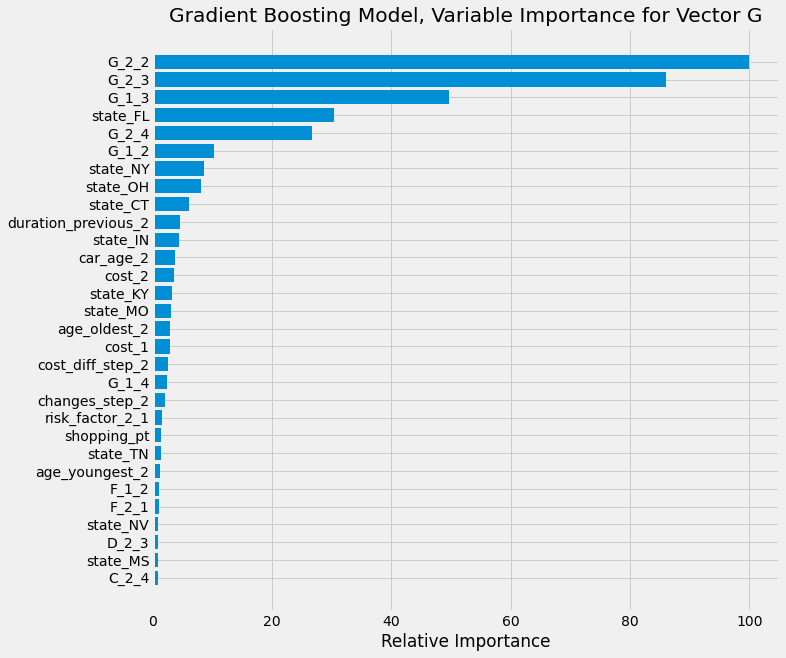

In [392]:
# model G with GradientBoosting classifier and best hyperparameters

vector = 'G'

#param_grid
n_estimators = 200
max_features = 8
max_depth = 3 
learning_rate = 0.25

    
gb = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, \
                                max_features = max_features, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  learning_rate = {learning_rate}, max_depth = {max_depth}, max_features = {max_features}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix - Normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

Notes for Vector G GB modelling:
* increasing max_features beyond 8 reduces score
* increasing max_depth to 4 doesn't change score much (reduces it marginally)

No GB model is not able to beat Random forest score of **0.758**.


In [54]:

y_train['G'].value_counts()

2    24161
3    19709
1    12918
4     5297
Name: G, dtype: int64

In [58]:
y_train['G'].value_counts()

1    24161
2    19709
0    12918
3     5297
Name: G, dtype: int64

In [55]:
y_test['G'].value_counts()

2    6097
3    4947
1    3188
4    1290
Name: G, dtype: int64

In [59]:
y_test['G'].value_counts()

1    6097
2    4947
0    3188
3    1290
Name: G, dtype: int64

In [56]:
mapping_G = {1:0, 2:1, 3:2, 4:3}

y_train['G'] = y_train['G'].map(lambda x: mapping_G[x] )
y_test['G'] = y_test['G'].map(lambda x: mapping_G[x] )

C:\Users\amite\AppData\Local\Temp/ipykernel_33952/4170161214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['G'] = y_train['G'].map(lambda x: mapping_G[x] )


In [60]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector B 

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'G'

param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)

clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = 60, verbose = 3, cv=4)

clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))


Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.760 total time=   8.2s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.765 total time=   8.0s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.753 total time=   9.7s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.762 total time=   9.8s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.760 total time=  18.6s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.764 total time=  19.5s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.755 total time=  20.0s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.764 total time=  18.6

[CV 2/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.766 total time=  18.1s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.758 total time=  18.0s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.764 total time=  18.9s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.763 total time=  15.7s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.766 total time=  15.6s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.758 total time=  15.1s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.764 total time=  15.1s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.764 total time=   6.1s
[CV 2/4] END colsample_bytree=0.25, learning_rat

[CV 4/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.758 total time=  19.7s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.753 total time=  30.2s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.757 total time=  30.5s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.747 total time=  30.7s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.755 total time=  30.2s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=400;, score=0.761 total time=  30.5s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=400;, score=0.764 total time=  31.1s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=400;, score=0.754 total time=  30.7s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.2

[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.767 total time=  18.2s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.758 total time=  18.5s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.766 total time=  18.5s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.762 total time=  23.6s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.766 total time=  23.6s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.757 total time=  23.3s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.764 total time=  23.3s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=5, n_estimators=300;, score=0.755 total time=  19.0s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.

In [62]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']
datapath = 'Modelling_data'
save_file(results, 'xgboost_results_vectorG.csv', datapath)
results

Writing file.  "Modelling_data\xgboost_results_vectorG.csv"


n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            100          5           0.50              0.50     0.759958   
1            300          5           0.30              0.25     0.760731   
2            500          5           0.30              0.35     0.755609   
3            100          3           0.30              0.50     0.762068   
4            400          5           0.50              0.50     0.748812   
5            100          5           0.25              0.35     0.764468   
6            300          4           0.30              0.50     0.761279   
7            300          5           0.50              0.50     0.751776   
8            400          4           0.30              0.15     0.761472   
9            200          5           0.30              0.25     0.762696   
10           100          3           0.30              0.15     0.761166   
11           400          3           0.30              0.50     0.762213   
12           200          3           0.35              0.50     0.762906   
13           400          3           0.35              0.35     0.762729   
14           300          4           0.25              0.25     0.763824   
15           500          5           0.35              0.35     0.754385   
16           100          3           0.50              0.35     0.762229   
17           300          5           0.25              0.25     0.762165   
18           500          3           0.35              0.15     0.762696   
19           100          5           0.35              0.25     0.763598   
20           500          4           0.30              0.15     0.760377   
21           200          3           0.25              0.35     0.763180   
22           500          5           0.35              0.50     0.752613   
23           200          4           0.30              0.25     0.763550   
24           500          3           0.50              0.50     0.758573   
25           100          4           0.30              0.25     0.763550   
26           100          4           0.35              0.25     0.763663   
27           300          4           0.25              0.35     0.763018   
28           500          5           0.35              0.15     0.756350   
29           300          5           0.35              0.35     0.758074   
30           400          4           0.35              0.35     0.759443   
31           200          4           0.35              0.50     0.762052   
32           400          3           0.50              0.35     0.760441   
33           300          4           0.50              0.35     0.757929   
34           500          4           0.50              0.15     0.756560   
35           500          4           0.50              0.35     0.753354   
36           400          5           0.25              0.35     0.760554   
37           300          5           0.30              0.50     0.758364   
38           100          3           0.35              0.15     0.761682   
39           300          5           0.35              0.50     0.756592   
40           300          4           0.35              0.50     0.760715   
41           500          3           0.25              0.25     0.763324   
42           200          3           0.30              0.50     0.763180   
43           500          3           0.50              0.15     0.759668   
44           200          5           0.35              0.35     0.761746   
45           400          5           0.30              0.15     0.759475   
46           200          4           0.50              0.15     0.761069   
47           400          4           0.50              0.35     0.756270   
48           200          4           0.30              0.50     0.762503   
49           100          5           0.30              0.15     0.762406   
50           200          3           0.25              0.15     0.762278   


In [63]:
import xgboost as xgb

vector = 'G'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='multi:softprob', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results.loc[i, 'test_score'] = ac
    results.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")

    print(f'Accuracy={ac:4.4}, f1_score={f1:4.4}')

results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
results

XGBoost Classifier results for Vector G

Parameters: No. of Estimators = 100.0,  max_depth = 5.0,     learning_rate = 0.5, colsample_bytree = 0.5
Accuracy=0.7572, f1_score=0.7561
Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.7553, f1_score=0.7542
Parameters: No. of Estimators = 500.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.7516, f1_score=0.7504
Parameters: No. of Estimators = 100.0,  max_depth = 3.0,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.7572, f1_score=0.7567
Parameters: No. of Estimators = 400.0,  max_depth = 5.0,     learning_rate = 0.5, colsample_bytree = 0.5
Accuracy=0.7447, f1_score=0.7431
Parameters: No. of Estimators = 100.0,  max_depth = 5.0,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.7592, f1_score=0.7585
Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.7584, f1_sc

Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.15
Accuracy=0.7559, f1_score=0.7548


n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            100          5           0.50              0.50     0.759958   
1            300          5           0.30              0.25     0.760731   
2            500          5           0.30              0.35     0.755609   
3            100          3           0.30              0.50     0.762068   
4            400          5           0.50              0.50     0.748812   
5            100          5           0.25              0.35     0.764468   
6            300          4           0.30              0.50     0.761279   
7            300          5           0.50              0.50     0.751776   
8            400          4           0.30              0.15     0.761472   
9            200          5           0.30              0.25     0.762696   
10           100          3           0.30              0.15     0.761166   
11           400          3           0.30              0.50     0.762213   
12           200          3           0.35              0.50     0.762906   
13           400          3           0.35              0.35     0.762729   
14           300          4           0.25              0.25     0.763824   
15           500          5           0.35              0.35     0.754385   
16           100          3           0.50              0.35     0.762229   
17           300          5           0.25              0.25     0.762165   
18           500          3           0.35              0.15     0.762696   
19           100          5           0.35              0.25     0.763598   
20           500          4           0.30              0.15     0.760377   
21           200          3           0.25              0.35     0.763180   
22           500          5           0.35              0.50     0.752613   
23           200          4           0.30              0.25     0.763550   
24           500          3           0.50              0.50     0.758573   
25           100          4           0.30              0.25     0.763550   
26           100          4           0.35              0.25     0.763663   
27           300          4           0.25              0.35     0.763018   
28           500          5           0.35              0.15     0.756350   
29           300          5           0.35              0.35     0.758074   
30           400          4           0.35              0.35     0.759443   
31           200          4           0.35              0.50     0.762052   
32           400          3           0.50              0.35     0.760441   
33           300          4           0.50              0.35     0.757929   
34           500          4           0.50              0.15     0.756560   
35           500          4           0.50              0.35     0.753354   
36           400          5           0.25              0.35     0.760554   
37           300          5           0.30              0.50     0.758364   
38           100          3           0.35              0.15     0.761682   
39           300          5           0.35              0.50     0.756592   
40           300          4           0.35              0.50     0.760715   
41           500          3           0.25              0.25     0.763324   
42           200          3           0.30              0.50     0.763180   
43           500          3           0.50              0.15     0.759668   
44           200          5           0.35              0.35     0.761746   
45           400          5           0.30              0.15     0.759475   
46           200          4           0.50              0.15     0.761069   
47           400          4           0.50              0.35     0.756270   
48           200          4           0.30              0.50     0.762503   
49           100          5           0.30              0.15     0.762406   
50           200          3           0.25              0.15     0.762278   


In [64]:
save_file(results,"xgboost_results_vectorG.csv",datapath)


A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "Modelling_data\xgboost_results_vectorG.csv"


XGBoost Classifier results for Vector G

Parameters: No. of Estimators = 200,  max_depth = 5, learning_rate = 0.25, colsample_bytree = 0.25

Accuracy=0.7601
f1-score=0.7592
Confusion Matrix
 [[0.722 0.226 0.039 0.013]
 [0.12  0.819 0.042 0.019]
 [0.053 0.133 0.774 0.04 ]
 [0.067 0.19  0.221 0.522]]

Classification Report 
               precision    recall  f1-score   support

           0       0.68      0.72      0.70      3188
           1       0.75      0.82      0.79      6097
           2       0.85      0.77      0.81      4947
           3       0.66      0.52      0.58      1290

    accuracy                           0.76     15522
   macro avg       0.74      0.71      0.72     15522
weighted avg       0.76      0.76      0.76     15522

30


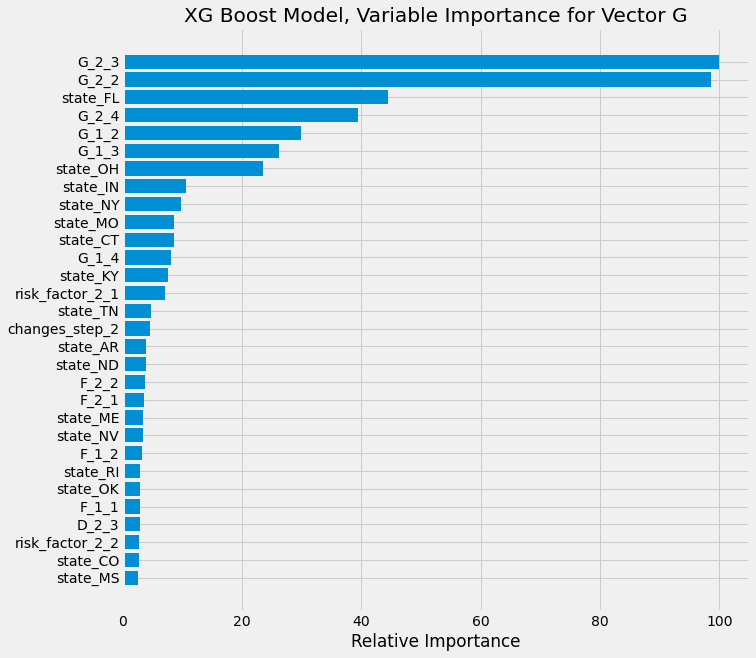

In [74]:
# model G with XGBoost classifier Best Parameters: (Overall 1st rank model)
#  No. of Estimators = 200,  max_depth = 5, learning_rate = 0.25, colsample_bytree = 0.25 : 0.7601, 0.7592

import xgboost as xgb

vector = 'G'

#param_grid
n_estimators = 200
max_depth = 5
learning_rate = 0.25
colsample_bytree = 0.25
        
clf = xgb.XGBClassifier(max_depth=max_depth, objective='multi:softproba', n_estimators=n_estimators, \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs = -1, random_state = 1)

clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = clf.predict(X_test.to_numpy())
y_pred_prob = clf.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)


print(f"XGBoost Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}\n")

print('Accuracy=%.4f' % (ac))

print('f1-score=%.4f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('XG Boost Model, Variable Importance for Vector '+vector)
plt.show()

Random Forest Classifier results for Vector A

Accuracy=0.846
f1-score=0.841
Confusion Matrix
 [[0.81 0.17 0.02]
 [0.04 0.93 0.03]
 [0.04 0.38 0.58]]

Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.81      0.83      3463
           1       0.85      0.93      0.89      9504
           2       0.80      0.58      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.84      0.77      0.80     15522
weighted avg       0.84      0.85      0.84     15522

30


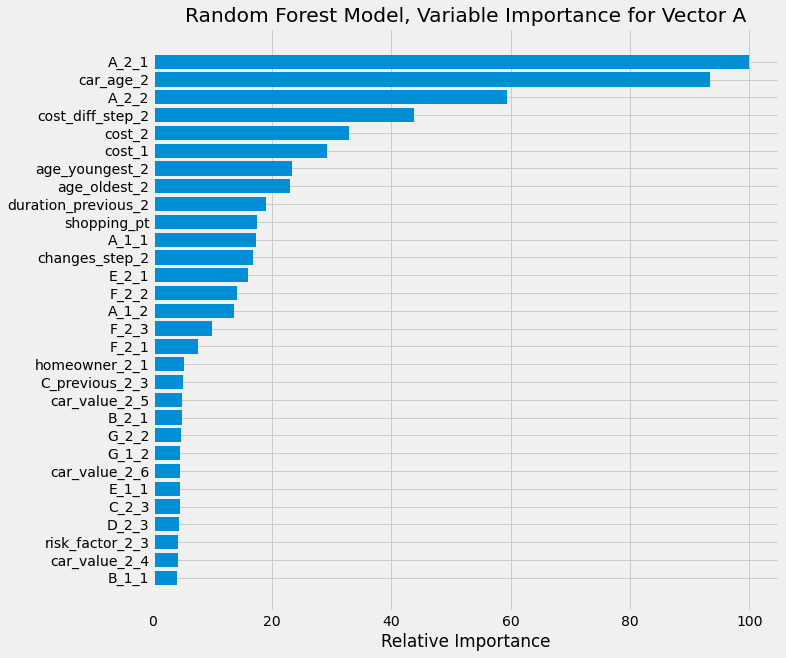

In [299]:
# Let's run a Random Forest model for vector A


vector = 'A'

    
clf = RandomForestClassifier(n_estimators=300,  random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = model_res.predict(X_test.to_numpy())
y_pred_prob = model_res.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),2)

print(f"Random Forest Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Model, Variable Importance for Vector '+vector)
plt.show()

In [304]:
test_set = df_train_first2.iloc[y_test.index,:]

x = pd.crosstab( test_set['A'], test_set['A_2'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")

Accuracy based on simply predicting vector A = A_2 :  0.8214


In [305]:
x['total'] = x.sum(axis=1)
x['A0_%'] = np.around(x[0]*100 / x['total'], 2)
x['A1_%'] = np.around(x[1]*100 / x['total'], 2)
x['A2_%'] = np.around(x[2]*100 / x['total'], 2)


In [306]:
x

A_2     0     1     2  total   A0_%   A1_%   A2_%
A                                                
0    2687   679    97   3463  77.59  19.61   2.80
1     632  8565   307   9504   6.65  90.12   3.23
2     190   867  1498   2555   7.44  33.93  58.63

In [297]:
# Now let's try a Grid Search CV to find the best Random Forest classifier for vector A

vector = 'A'
param_grid = {'n_estimators' : np.arange(100,801,100)}

rf = RandomForestClassifier(random_state = 1, n_jobs=-1)

rf_cv = GridSearchCV(rf, param_grid, cv=5)

rf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print("Random Forest Model\nBest Score:" + str(rf_cv.best_score_))
print("\nBest Parameters: " + str(rf_cv.best_params_)) 

Random Forest Model
Best Score:0.8449544978658292

Best Parameters: {'n_estimators': 800}


Random Forest Classifier results for Vector A

Accuracy=0.846
f1-score=0.841
Confusion Matrix
 [[0.8  0.17 0.02]
 [0.04 0.93 0.03]
 [0.04 0.38 0.59]]

Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      3463
           1       0.85      0.93      0.89      9504
           2       0.80      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.84      0.77      0.80     15522
weighted avg       0.84      0.85      0.84     15522

30


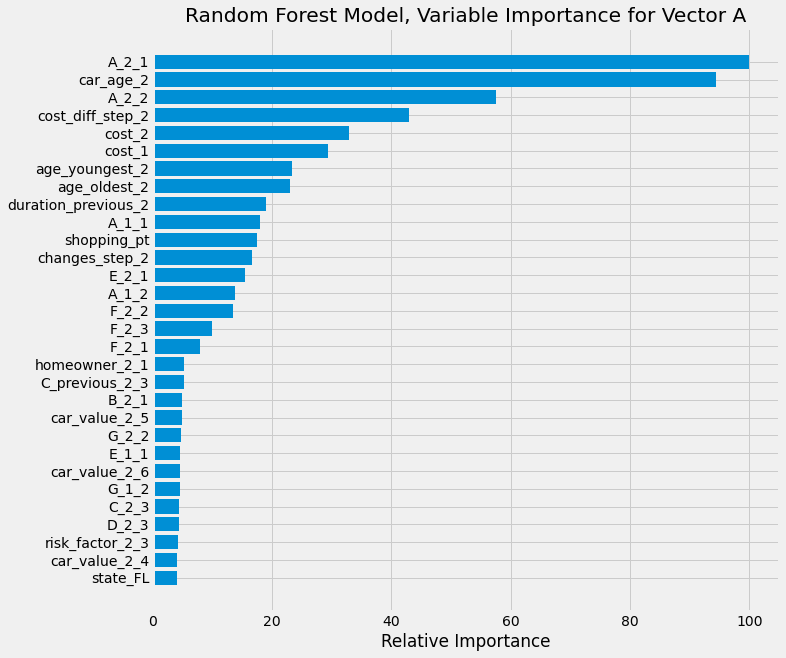

In [298]:
# Run the model with Best Parameters: {'n_estimators': 800}

plt.style.use("fivethirtyeight")

vector = 'A'

    
clf = RandomForestClassifier(n_estimators=800,  random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = model_res.predict(X_test.to_numpy())
y_pred_prob = model_res.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),2)

print(f"Random Forest Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Model, Variable Importance for Vector '+vector)
plt.show()

Gradient Boosting Classifier results for Vector A

Accuracy=0.844
f1-score=0.840
Confusion Matrix
 [[0.812 0.164 0.024]
 [0.042 0.926 0.033]
 [0.041 0.373 0.586]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      3463
           1       0.85      0.93      0.89      9504
           2       0.79      0.59      0.67      2555

    accuracy                           0.84     15522
   macro avg       0.83      0.77      0.80     15522
weighted avg       0.84      0.84      0.84     15522



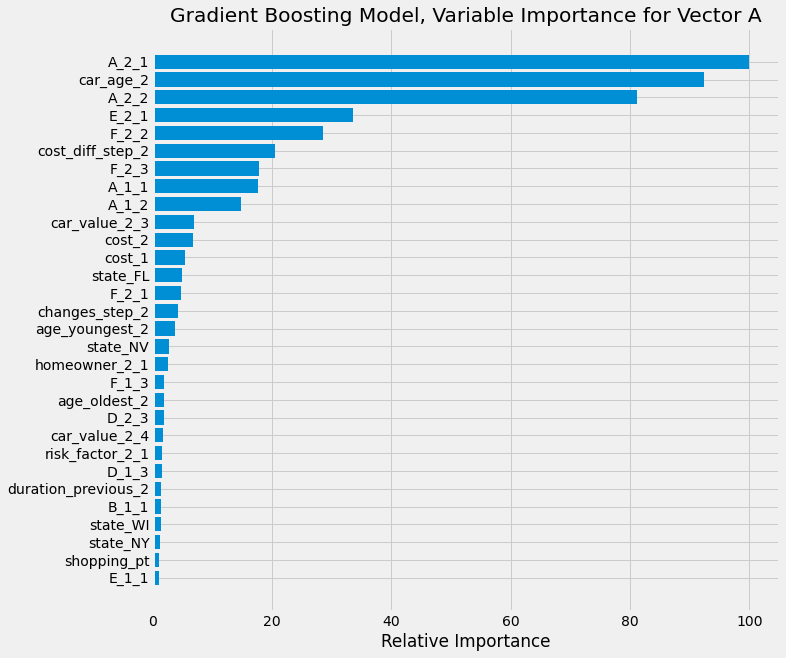

In [376]:
# model A with GradientBoosting classifier

vector = 'A'

gb = GradientBoostingClassifier(n_estimators = 150, learning_rate = 0.25, max_depth = 3, max_features = 6, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

In [377]:
# Let's use RandomizedSearchCV to find the best GradientBoosting classifier Hyperparamters for vector A 

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

vector = 'A'

param_grid = {'learning_rate' : [0.25, 0.5, 0.75, 1], 'n_estimators' : [50, 100, 150, 200], \
              'max_features': [2,4,6,8], 'max_depth' : [1,2,3]}

gb = GradientBoostingClassifier(random_state = 1)

gb_cv = RandomizedSearchCV(gb, param_grid, n_iter = 10, verbose = 3, cv=5)

gb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: Gradient Boosting Model\nBest Score:" + str(gb_cv.best_score_))
print("\nBest Parameters: " + str(gb_cv.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=200;, score=0.846 total time=  51.0s
[CV 2/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=200;, score=0.846 total time=  48.3s
[CV 3/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=200;, score=0.846 total time=  47.4s
[CV 4/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=200;, score=0.840 total time=  50.8s
[CV 5/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=200;, score=0.842 total time=  50.1s
[CV 1/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=150;, score=0.845 total time=  36.3s
[CV 2/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=150;, score=0.847 total time=  36.4s
[CV 3/5] END learning_rate=0.25, max_depth=3, max_features=8, n_estimators=150;, score=0.845 total time=  35.9s
[CV 4/5] END learning_rate=0.25, max_depth=

Gradient Boosting Classifier results for Vector A

Parameters: No. of Estimators = 200,  learning_rate = 0.25, max_depth = 3,                                 max_features = 8

Accuracy=0.846
f1-score=0.841
Confusion Matrix
 [[0.813 0.163 0.024]
 [0.04  0.926 0.034]
 [0.039 0.371 0.59 ]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      3463
           1       0.85      0.93      0.89      9504
           2       0.79      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.84      0.85      0.84     15522



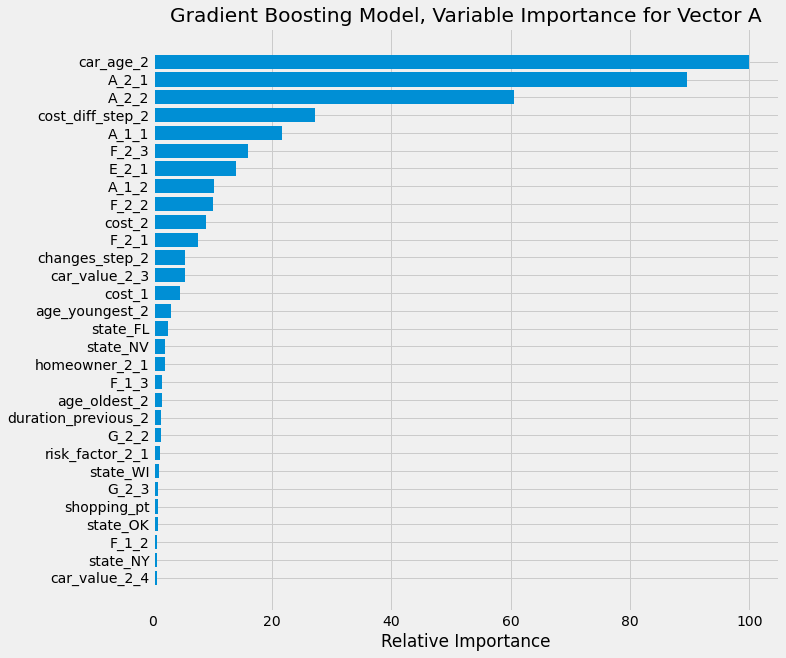

In [380]:
# model A with GradientBoosting classifier and best hyperparameters

vector = 'A'

#param_grid
n_estimators = 200
max_features = 8
max_depth = 3 
learning_rate = 0.25

    
gb = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, \
                                max_features = max_features, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  learning_rate = {learning_rate}, max_depth = {max_depth}, max_features = {max_features}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

Gradient Boosting Classifier results for Vector A

Parameters: No. of Estimators = 200,  learning_rate = 0.5, max_depth = 3, max_features = 8

Accuracy=0.846
f1-score=0.841
Confusion Matrix
 [[0.819 0.156 0.025]
 [0.041 0.926 0.033]
 [0.045 0.369 0.587]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      3463
           1       0.86      0.93      0.89      9504
           2       0.79      0.59      0.67      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.84      0.85      0.84     15522



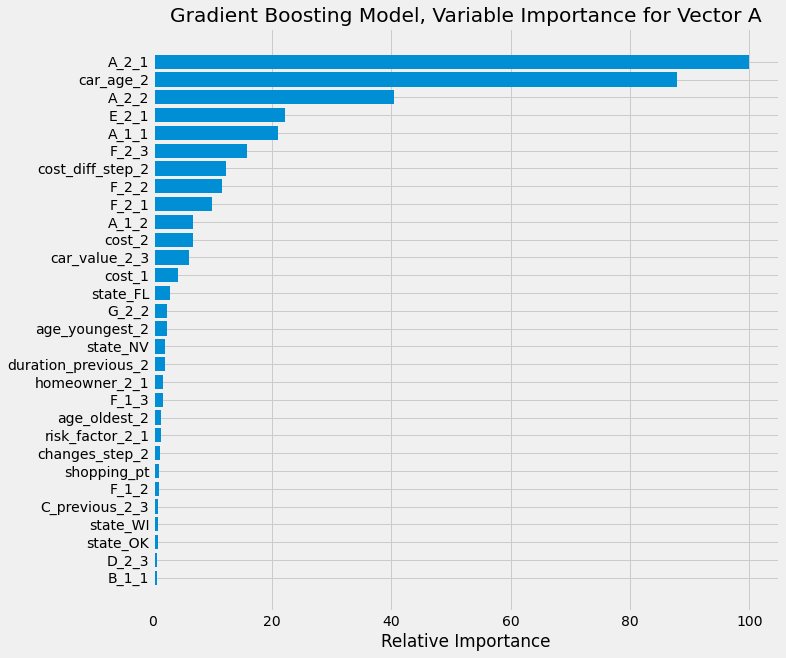

In [381]:
# model A with GradientBoosting classifier, increasing learning rate to 0.5

vector = 'A'

#param_grid
n_estimators = 200
max_features = 8
max_depth = 3 
learning_rate = 0.5

    
gb = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, \
                                max_features = max_features, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  learning_rate = {learning_rate}, max_depth = {max_depth}, max_features = {max_features}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

Gradient Boosting Classifier results for Vector A

Parameters: No. of Estimators = 200,  learning_rate = 0.5, max_depth = 3, max_features = 10

Accuracy=0.847
f1-score=0.842
Confusion Matrix
 [[0.821 0.156 0.023]
 [0.042 0.925 0.034]
 [0.041 0.367 0.592]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      3463
           1       0.86      0.92      0.89      9504
           2       0.79      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.84      0.85      0.84     15522



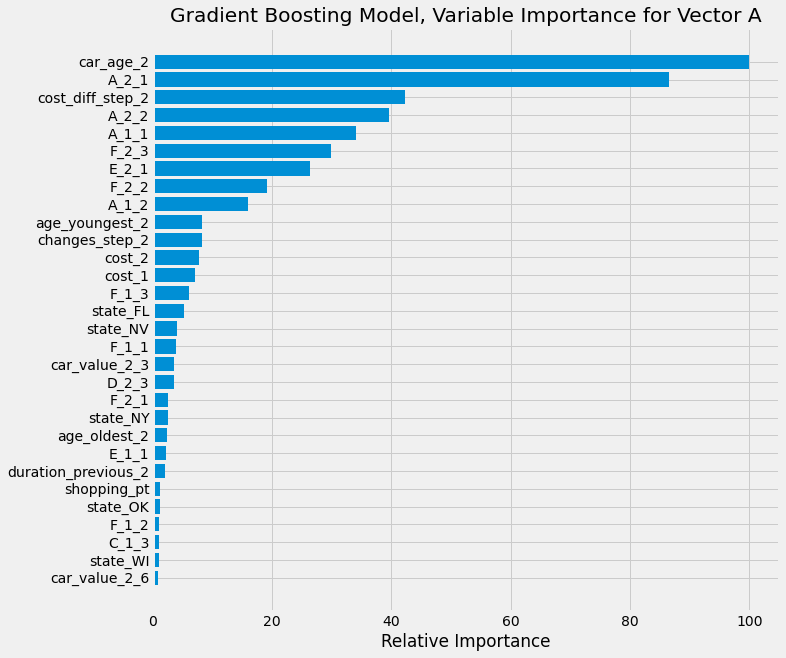

In [383]:
# model A with GradientBoosting classifier, increasing learning rate to 0.5, max _features = 10

vector = 'A'

#param_grid
n_estimators = 200
max_features = 10
max_depth = 3 
learning_rate = 0.5

    
gb = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, \
                                max_features = max_features, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  learning_rate = {learning_rate}, max_depth = {max_depth}, max_features = {max_features}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

Gradient Boosting Classifier results for Vector A

Parameters: No. of Estimators = 200,  learning_rate = 0.4, max_depth = 3, max_features = 10

Accuracy=0.848
f1-score=0.844
Confusion Matrix - Normalized
 [[0.824 0.152 0.023]
 [0.04  0.926 0.033]
 [0.042 0.368 0.59 ]]
Confusion Matrix
 [[2855  528   80]
 [ 384 8805  315]
 [ 108  939 1508]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      3463
           1       0.86      0.93      0.89      9504
           2       0.79      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.85      0.85      0.84     15522



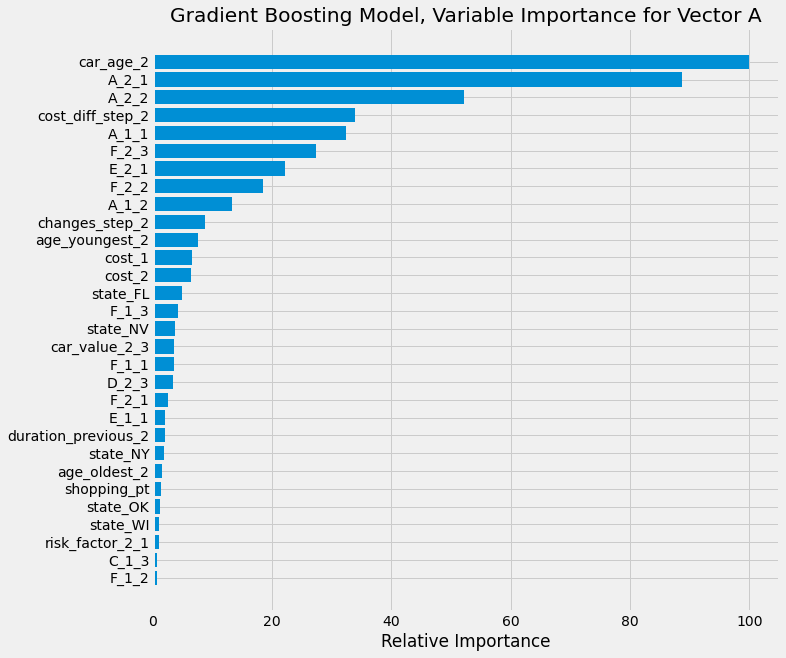

In [390]:
# BEST GB MODEL for A
# model A with GradientBoosting classifier, increasing learning rate to 0.5, max _features = 10

vector = 'A'

#param_grid
n_estimators = 200
max_features = 10
max_depth = 3 
learning_rate = 0.4

    
gb = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, \
                                max_features = max_features, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  learning_rate = {learning_rate}, max_depth = {max_depth}, max_features = {max_features}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix - Normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

Gradient Boosting Classifier results for Vector A

Parameters: No. of Estimators = 200,  learning_rate = 0.35, max_depth = 3, max_features = 10

Accuracy=0.848
f1-score=0.843
Confusion Matrix - Normalized
 [[0.82  0.158 0.022]
 [0.039 0.928 0.033]
 [0.042 0.371 0.587]]
Confusion Matrix
 [[2841  547   75]
 [ 369 8823  312]
 [ 108  947 1500]]

Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      3463
           1       0.86      0.93      0.89      9504
           2       0.79      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.84      0.78      0.80     15522
weighted avg       0.85      0.85      0.84     15522



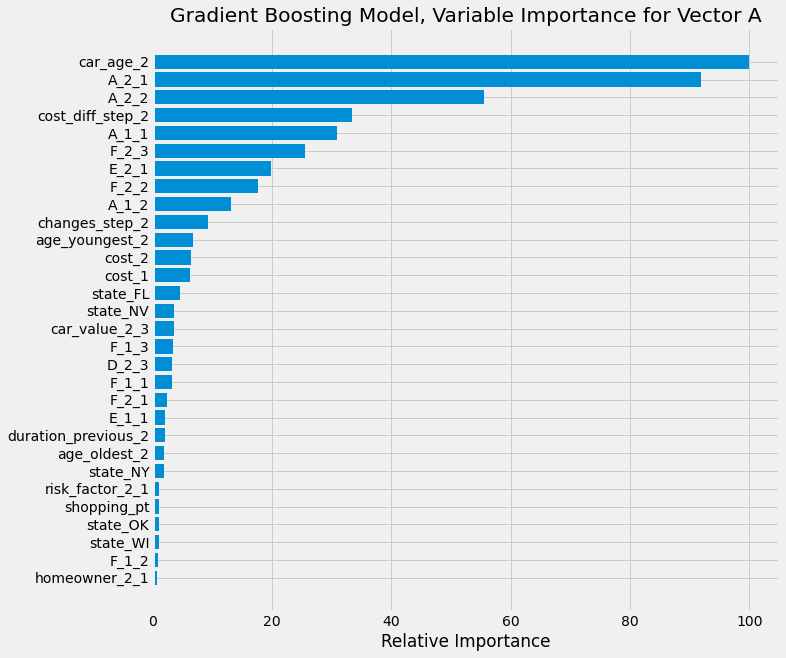

In [389]:
# model A with GradientBoosting classifier, increasing learning rate to 0.35, max _features = 10

vector = 'A'

#param_grid
n_estimators = 200
max_features = 10
max_depth = 3 
learning_rate = 0.35

    
gb = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, \
                                max_features = max_features, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  learning_rate = {learning_rate}, max_depth = {max_depth}, max_features = {max_features}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix - Normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

Notes for Vector A GB modelling:
* increasing l_rate beyond 0.5 reduces score
* increasing max_depth beyond 3 reduces score

Best Model HyperParameters: No. of Estimators = 200,  learning_rate = 0.4, max_depth = 3, max_features = 10



XGBoost Classifier results for Vector A

Parameters: No. of Estimators = 300,  max_depth = 3

Accuracy=0.848
f1-score=0.843
Confusion Matrix
 [[0.825 0.152 0.023]
 [0.041 0.926 0.033]
 [0.042 0.369 0.589]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      3463
           1       0.86      0.93      0.89      9504
           2       0.79      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.85      0.85      0.84     15522

30


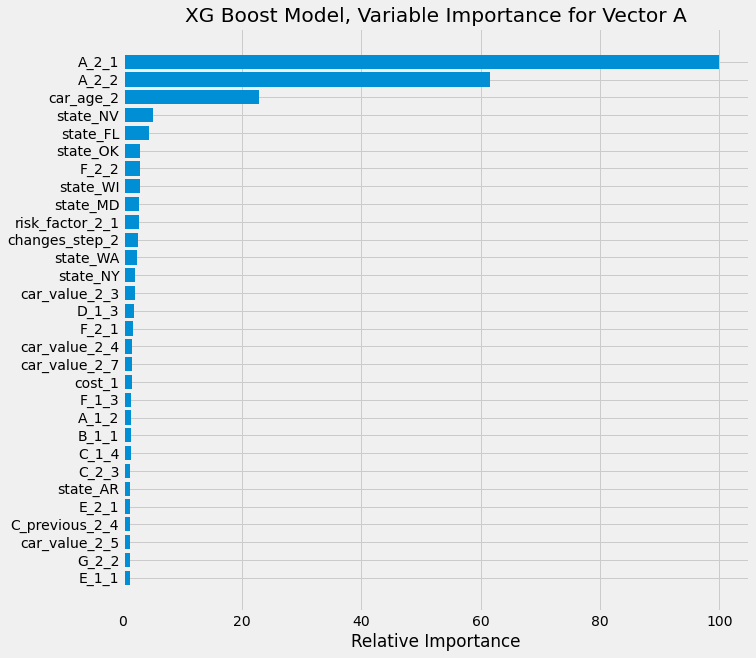

In [27]:
# model A with XGBoost classifier

import xgboost as xgb

vector = 'A'

#param_grid
n_estimators = 300
max_depth = 3

clf = xgb.XGBClassifier(max_depth=max_depth, objective='multi:softproba', n_estimators=n_estimators)

clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = clf.predict(X_test.to_numpy())
y_pred_prob = clf.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)


print(f"XGBoost Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}\n")

print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('XG Boost Model, Variable Importance for Vector '+vector)
plt.show()

In [38]:

# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector A 

from sklearn.model_selection import RandomizedSearchCV

vector = 'A'

param_grid = {'learning_rate' : [0.25, 0.35, 0.5, 0.75], 'n_estimators' : np.arange(100,701,100), \
              'colsample_bytree': [0.1,0.3,0.5,0.8,1], 'max_depth' : [1,2,3]}

xgb = xgb.XGBClassifier(objective='multi:softprob', random_state=1)

xgb_cv = RandomizedSearchCV(xgb, param_grid, n_iter = 20, verbose = 3, cv=4)

xgb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))



Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV 1/4] END colsample_bytree=0.8, learning_rate=0.35, max_depth=1, n_estimators=600;, score=0.844 total time=  27.3s
[CV 2/4] END colsample_bytree=0.8, learning_rate=0.35, max_depth=1, n_estimators=600;, score=0.844 total time=  26.9s
[CV 3/4] END colsample_bytree=0.8, learning_rate=0.35, max_depth=1, n_estimators=600;, score=0.841 total time=  26.3s
[CV 4/4] END colsample_bytree=0.8, learning_rate=0.35, max_depth=1, n_estimators=600;, score=0.838 total time=  27.5s
[CV 1/4] END colsample_bytree=0.3, learning_rate=0.75, max_depth=2, n_estimators=300;, score=0.846 total time=  11.9s
[CV 2/4] END colsample_bytree=0.3, learning_rate=0.75, max_depth=2, n_estimators=300;, score=0.846 total time=  14.2s
[CV 3/4] END colsample_bytree=0.3, learning_rate=0.75, max_depth=2, n_estimators=300;, score=0.843 total time=  13.3s
[CV 4/4] END colsample_bytree=0.3, learning_rate=0.75, max_depth=2, n_estimators=300;, score=0.840 total time=  1

[CV 3/4] END colsample_bytree=0.1, learning_rate=0.25, max_depth=2, n_estimators=200;, score=0.840 total time=   4.0s
[CV 4/4] END colsample_bytree=0.1, learning_rate=0.25, max_depth=2, n_estimators=200;, score=0.838 total time=   3.9s
[CV 1/4] END colsample_bytree=0.1, learning_rate=0.75, max_depth=3, n_estimators=200;, score=0.846 total time=   5.8s
[CV 2/4] END colsample_bytree=0.1, learning_rate=0.75, max_depth=3, n_estimators=200;, score=0.846 total time=   5.0s
[CV 3/4] END colsample_bytree=0.1, learning_rate=0.75, max_depth=3, n_estimators=200;, score=0.843 total time=   4.8s
[CV 4/4] END colsample_bytree=0.1, learning_rate=0.75, max_depth=3, n_estimators=200;, score=0.841 total time=   4.9s
[CV 1/4] END colsample_bytree=0.8, learning_rate=0.75, max_depth=3, n_estimators=400;, score=0.841 total time=  29.0s
[CV 2/4] END colsample_bytree=0.8, learning_rate=0.75, max_depth=3, n_estimators=400;, score=0.840 total time=  29.2s
[CV 3/4] END colsample_bytree=0.8, learning_rate=0.75, m

NameError: name 'gb_cv' is not defined

In [39]:
print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(xgb_cv.best_score_))
print("\nBest Parameters: " + str(xgb_cv.best_params_))

Vector A RandomizedSearchCV: XG Boosting Model
Best Score:0.8455504224729515

Best Parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.25, 'colsample_bytree': 0.5}


XGBoost Classifier results for Vector A

Parameters: No. of Estimators = 500,  max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.5

Accuracy=0.847
f1-score=0.842
Confusion Matrix
 [[0.824 0.153 0.023]
 [0.041 0.925 0.033]
 [0.043 0.37  0.587]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      3463
           1       0.86      0.93      0.89      9504
           2       0.79      0.59      0.67      2555

    accuracy                           0.85     15522
   macro avg       0.83      0.78      0.80     15522
weighted avg       0.84      0.85      0.84     15522

30


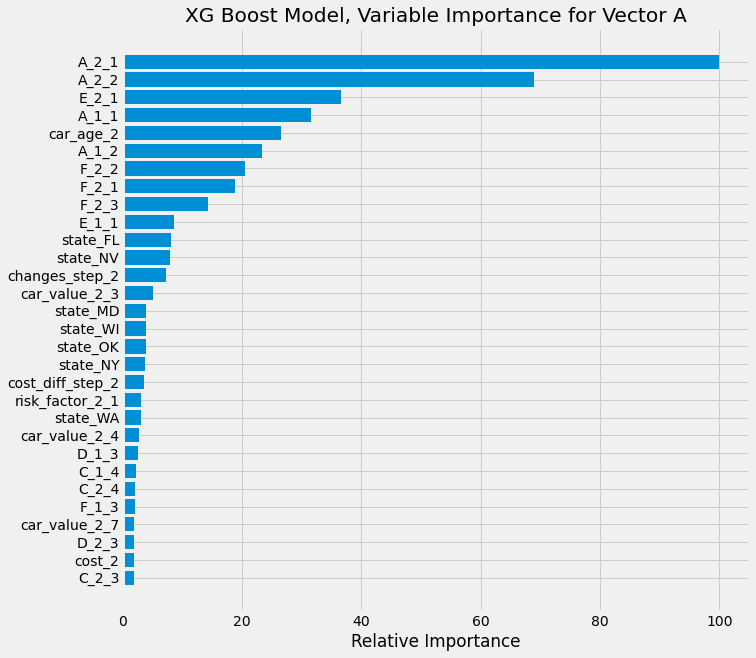

In [40]:
# model A with XGBoost classifier Best Parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.25, 'colsample_bytree': 0.5}

import xgboost as xgb

vector = 'A'

#param_grid
n_estimators = 500
max_depth = 3
learning_rate = 0.25
colsample_bytree = 0.5
        
clf = xgb.XGBClassifier(max_depth=max_depth, objective='multi:softproba', n_estimators=n_estimators, \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree)

clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = clf.predict(X_test.to_numpy())
y_pred_prob = clf.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)


print(f"XGBoost Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}\n")

print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('XG Boost Model, Variable Importance for Vector '+vector)
plt.show()

XGBoost Classifier results for Vector A

Parameters: No. of Estimators = 200,  max_depth = 4, learning_rate = 0.3, colsample_bytree = 0.35

Accuracy=0.849
f1-score=0.844
Confusion Matrix - Normalized
 [[0.826 0.152 0.022]
 [0.041 0.926 0.032]
 [0.043 0.366 0.591]]
Confusion Matrix
 [[2859  528   76]
 [ 394 8804  306]
 [ 111  935 1509]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      3463
           1       0.86      0.93      0.89      9504
           2       0.80      0.59      0.68      2555

    accuracy                           0.85     15522
   macro avg       0.84      0.78      0.80     15522
weighted avg       0.85      0.85      0.84     15522

30


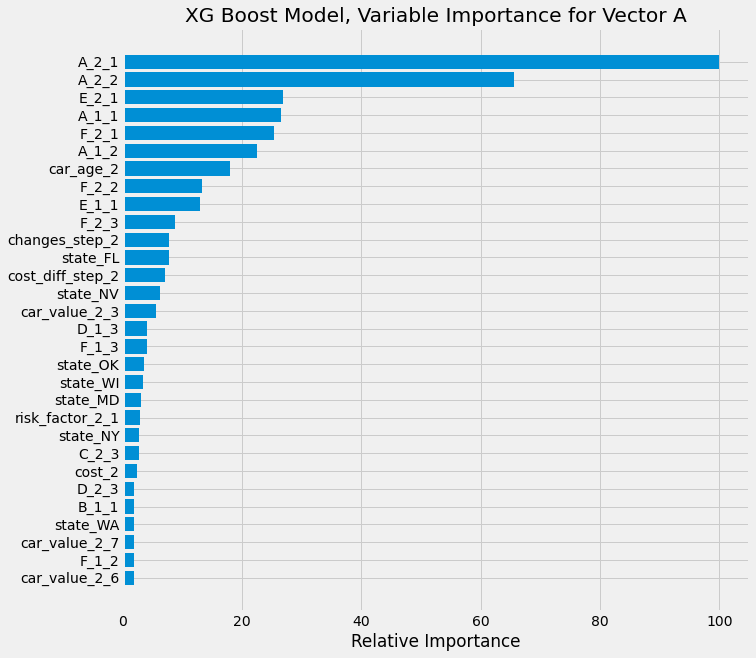

In [77]:
# model A with XGBoost classifier
# Parameters: No. of Estimators = 300,  max_depth = 3, learning_rate = 0.35, colsample_bytree = 0.5 (0.848, .843)
# Parameters: No. of Estimators = 200,  max_depth = 3, learning_rate = 0.4, colsample_bytree = 0.15 (0.848, .843)
# Parameters: No. of Estimators = 200,  max_depth = 5, learning_rate = 0.4, colsample_bytree = 0.25 (0.846, .842)
# Parameters: No. of Estimators = 200,  max_depth = 4, learning_rate = 0.3, colsample_bytree = 0.25 (0.848, .843)
# Parameters: No. of Estimators = 200,  max_depth = 4, learning_rate = 0.3, colsample_bytree = 0.35 (0.849, .844)
# Parameters: No. of Estimators = 200,  max_depth = 4, learning_rate = 0.3, colsample_bytree = 0.4 (0.848, .843)
# Parameters: No. of Estimators = 200,  max_depth = 4, learning_rate = 0.35, colsample_bytree = 0.35 (0.848, .843)
# Parameters: No. of Estimators = 300,  max_depth = 4, learning_rate = 0.3, colsample_bytree = 0.35 (0.847, .843)
# Parameters: No. of Estimators = 200,  max_depth = 4, learning_rate = 0.4, colsample_bytree = 0.25 (0.848, .844)
# Parameters: No. of Estimators = 200,  max_depth = 4, learning_rate = 0.4, colsample_bytree = 0.35 (0.848, .844)
# Parameters: No. of Estimators = 200,  max_depth = 4, learning_rate = 0.5, colsample_bytree = 0.35 (0.845, .840)
# Parameters: No. of Estimators = 150,  max_depth = 4, learning_rate = 0.3, colsample_bytree = 0.35 (0.847, .843)
# Parameters: No. of Estimators = 220,  max_depth = 4, learning_rate = 0.3, colsample_bytree = 0.35 (0.848, .844)

import xgboost as xgb

vector = 'A'

#param_grid
n_estimators = 200
max_depth = 4
learning_rate = 0.3
colsample_bytree = 0.35
        
clf = xgb.XGBClassifier(max_depth=max_depth, objective='multi:softproba', n_estimators=n_estimators, \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree)

clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = clf.predict(X_test.to_numpy())
y_pred_prob = clf.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)


print(f"XGBoost Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}\n")

print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix - Normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('XG Boost Model, Variable Importance for Vector '+vector)
plt.show()

Random Forest Classifier results for Vector E

Accuracy=0.839
f1-score=0.838
Confusion Matrix
 [[0.886 0.114]
 [0.216 0.784]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8425
           1       0.85      0.78      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.83      0.84     15522
weighted avg       0.84      0.84      0.84     15522

Area under ROC: 
 0.8959355083374135
30


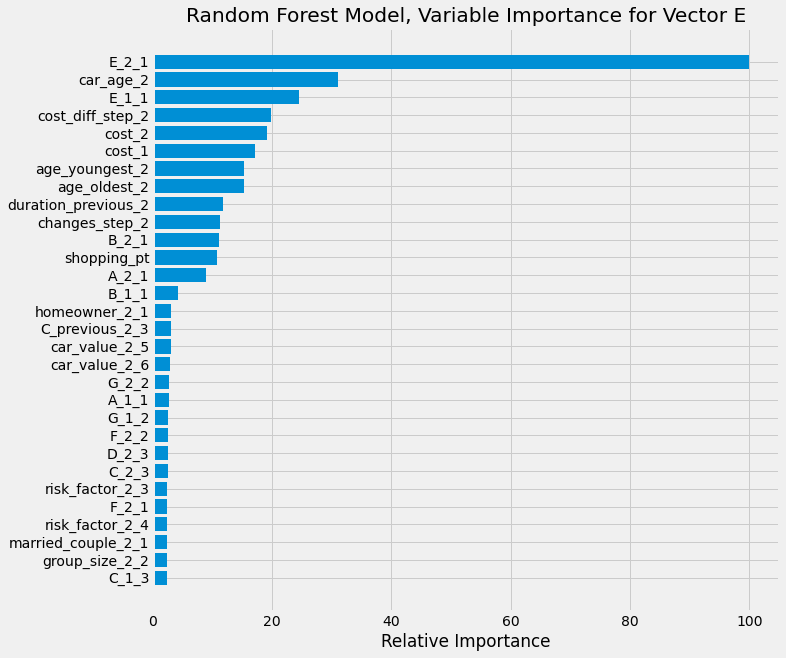

In [325]:
# Let's run the Random Forest model for vector E


vector = 'E'

    
clf = RandomForestClassifier(n_estimators=300,  random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = model_res.predict(X_test.to_numpy())
y_pred_prob = model_res.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Random Forest Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test[vector].astype('int'), rf_probs)
roc_auc1 = auc(fpr_1, tpr_1)
    
print("\nClassification Report \n", cr)
print("Area under ROC: \n", roc_auc1)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Model, Variable Importance for Vector '+vector)
plt.show()

Random Forest Classifier results for Vector E, min_samples_leaf = 1

Accuracy=0.839
f1-score=0.838
Confusion Matrix
 [[7442  983]
 [1521 5576]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      8425
           1       0.85      0.79      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.83      0.84     15522
weighted avg       0.84      0.84      0.84     15522

37


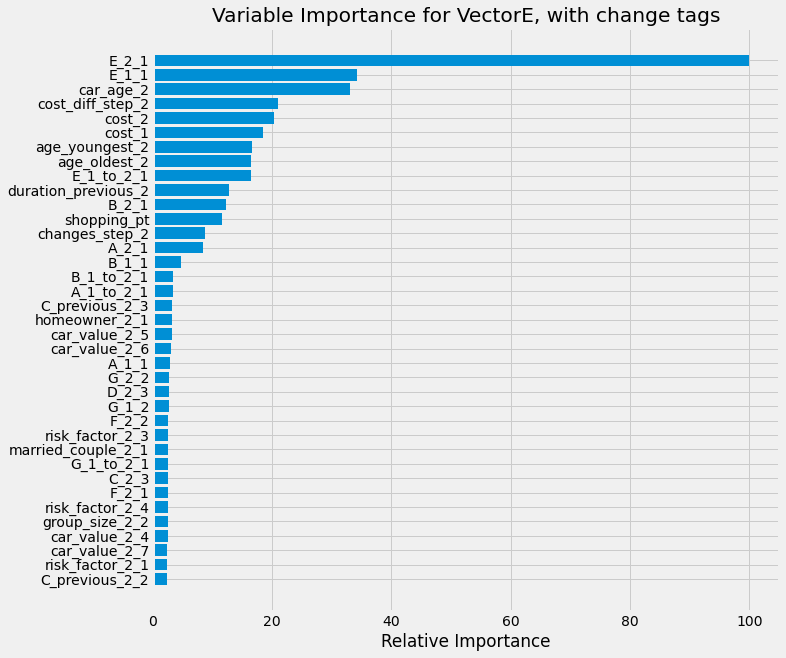

Random Forest Classifier results for Vector E, min_samples_leaf = 2

Accuracy=0.839
f1-score=0.839
Confusion Matrix
 [[7449  976]
 [1520 5577]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      8425
           1       0.85      0.79      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.83      0.84     15522
weighted avg       0.84      0.84      0.84     15522

37


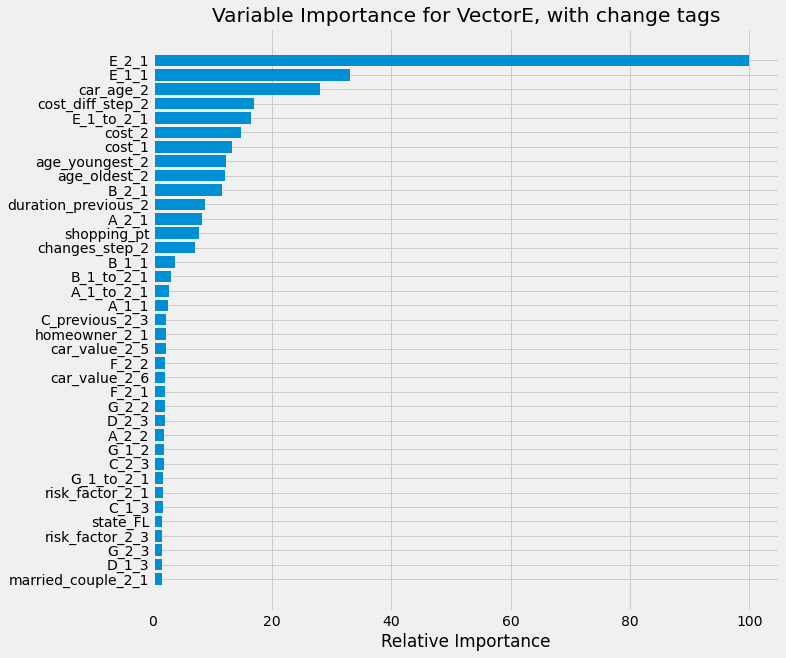

In [275]:
# with change tags


plt.style.use("fivethirtyeight")

vector = 'E'

for min_leaf in range(1,3):
    
    clf = RandomForestClassifier(n_estimators=300,  min_samples_leaf=min_leaf, random_state = 1,n_jobs=-1)
    model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Random Forest Classifier results for Vector {vector}, min_samples_leaf = {min_leaf}\n")
    print('Accuracy=%.3f' % (ac))

    print('f1-score=%.3f' % (f1))

    print("Confusion Matrix\n", cm)

    cr = classification_report(y_test[vector].astype('int'), y_pred)

    print("\nClassification Report \n", cr)

    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[64:]

    pos = np.arange(sorted_idx.shape[0]) + .5
    print(pos.size)
    sorted_idx.size
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance for Vector'+vector+', with change tags')
    plt.show()

In [323]:
#test_set = df_train_first2.iloc[y_test.index,:]

x = pd.crosstab(test_set['E'], test_set['E_2'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")

Accuracy based on simply predicting vector E = E_2 :  0.8319


In [324]:
x['total'] = x.sum(axis=1)
x['E_%'] = np.around(x[0]*100 / x['total'], 2)
x['E1_%'] = np.around(x[1]*100 / x['total'], 2)

x

E_2     0     1  total    E_%   E1_%
E                                   
0    7382  1043   8425  87.62  12.38
1    1567  5530   7097  22.08  77.92

In [280]:
# Now let's try a Grid Search CV to find the best Random Forest classifier

vector = 'E'

param_grid = {'n_estimators' : np.arange(100,801,100)}

rf = RandomForestClassifier(random_state = 1, n_jobs=-1)

rf_cv = GridSearchCV(rf, param_grid, cv=5)

rf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print("Random Forest Model\nBest Score:" + str(rf_cv.best_score_))
print("\nBest Parameters: " + str(rf_cv.best_params_)) 

Random Forest Model
Best Score:0.8429572360473545

Best Parameters: {'n_estimators': 100}


Random Forest Classifier results for Vector E, n_estimators = 100

Accuracy=0.840
f1-score=0.8389
Confusion Matrix - normalized
 [[0.886 0.114]
 [0.215 0.785]]
Confusion Matrix
 [[7462  963]
 [1527 5570]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8425
           1       0.85      0.78      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522


Area under ROC: 
 0.8936697287983514


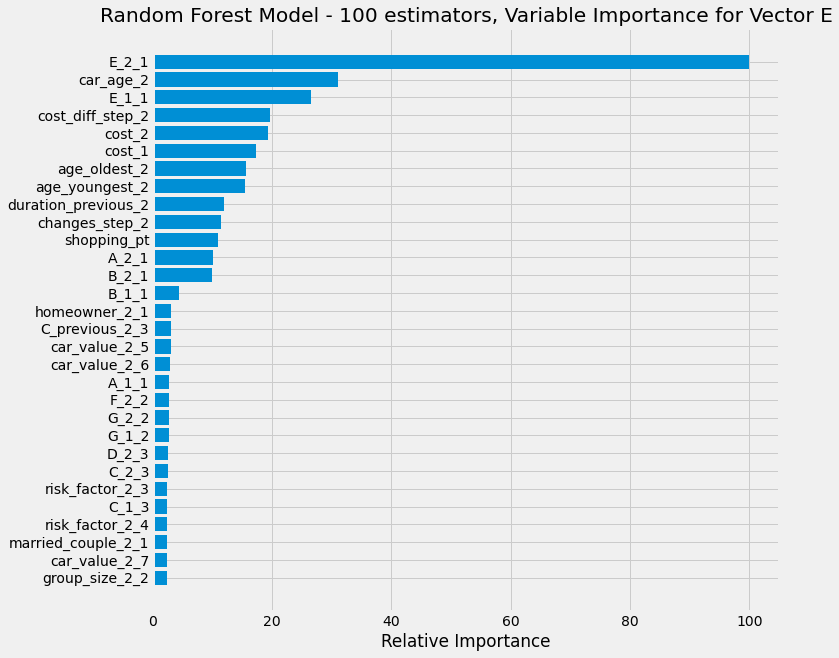

In [52]:
#Let's run the model with Best Parameters: {'n_estimators': 100}

vector = 'E'

clf = RandomForestClassifier(n_estimators=100,  random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = model_res.predict(X_test.to_numpy())
y_pred_prob = model_res.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

print(f"Random Forest Classifier results for Vector {vector}, n_estimators = 100\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.4f' % (f1))

print("Confusion Matrix - normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test[vector].astype('int'), rf_probs)

roc_auc1 = auc(fpr_1, tpr_1)

print("\nClassification Report \n", cr)
print("\nArea under ROC: \n", roc_auc1)

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Model - 100 estimators, Variable Importance for Vector '+vector)
plt.show()


C:\Users\amite\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy=0.835
Logistic Regression: f1-score=0.835
Confusion Matrix
 [[0.878 0.122]
 [0.216 0.784]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      8425
           1       0.84      0.78      0.81      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.83      0.83     15522
weighted avg       0.84      0.84      0.83     15522


Area under ROC: 
 0.8907563316133494


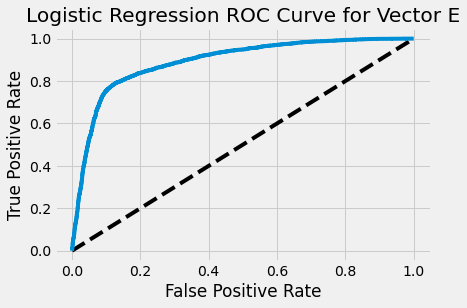

In [328]:
# model with Logistic Regression classifier

vector = 'E'

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = logreg.predict(X_test.to_numpy())
y_pred_prob = logreg.predict_proba(X_test.to_numpy())
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print('Logistic Regression: Accuracy=%.3f' % (ac))

print('Logistic Regression: f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test[vector].astype('int'), lr_probs)
roc_auc2 = auc(fpr_2, tpr_2)
print("\nClassification Report \n", cr)
print("\nArea under ROC: \n", roc_auc2)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_2, tpr_2, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve for Vector '+vector)
plt.show()


Gradient Boosting Classifier results for Vector E

Accuracy=0.840
f1-score=0.839
Confusion Matrix
 [[0.89 0.11]
 [0.22 0.78]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8425
           1       0.86      0.78      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522


Area under ROC: 
 0.8962893921408678


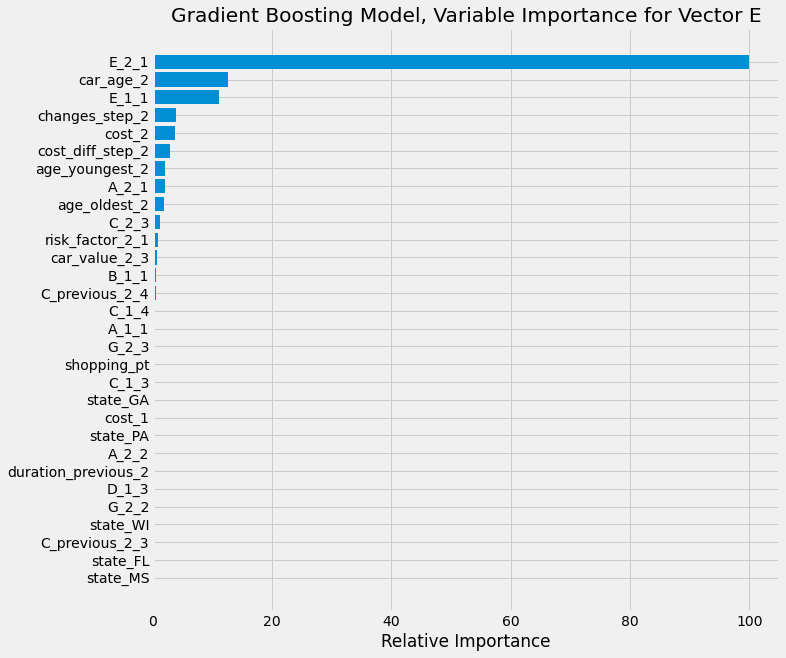

In [330]:
# model E with GradientBoosting classifier

vector = 'E'

gb = GradientBoostingClassifier(n_estimators = 150, learning_rate = 0.25, max_depth = 3, max_features = 6, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), gb_probs)
roc_auc3 = auc(fpr_3, tpr_3)

print("\nClassification Report \n", cr)
print("\nArea under ROC: \n", roc_auc3)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

In [341]:
from bayes_opt import BayesianOptimization

vector = 'E'

def gbm_eval(estimators, lrng_rate, max_d, max_f):
    
    gb = GradientBoostingClassifier(n_estimators = round(estimators), learning_rate = lrng_rate, \
                                    max_depth = round(max_d), max_features = round(max_f), random_state = 1)
    
    cv_result = cross_validate(gb, X_train.to_numpy(), y_train[vector].astype('int'), cv= 5)
    return np.mean(cv_result['test_score'])

gb_bo = BayesianOptimization(gbm_eval, {'estimators': (20, 200), 'lrng_rate': (0.05, 1), \
                                                'max_d': (1, 4), 'max_f': (2,8) })

gb_bo.maximize(n_iter=15, init_points=2)

|   iter    |  target   | estima... | lrng_rate |   max_d   |   max_f   |
-------------------------------------------------------------------------
|  1        |  0.8403   |  120.1    |  0.8081   |  2.958    |  4.365    |
|  2        |  0.837    |  103.2    |  0.2      |  1.02     |  6.092    |
|  3        |  0.838    |  58.13    |  0.982    |  1.263    |  4.659    |
|  4        |  0.8424   |  169.3    |  0.1971   |  3.306    |  6.265    |
|  5        |  0.8391   |  143.0    |  0.5588   |  3.987    |  7.719    |
|  6        |  0.8385   |  99.19    |  0.836    |  2.086    |  2.744    |
|  7        |  0.839    |  173.7    |  0.8416   |  2.963    |  4.689    |
|  8        |  0.8407   |  57.25    |  0.7485   |  1.549    |  7.205    |
|  9        |  0.832    |  144.5    |  0.932    |  3.894    |  5.983    |
|  10       |  0.8361   |  85.45    |  0.1008   |  1.892    |  4.504    |
|  11       |  0.8394   |  155.1    |  0.1585   |  2.443    |  6.269    |
|  12       |  0.8428   |  193.5    | 

So we got two models with very similar test_scores: 

* Test_Score: 0.8424, n_estimators = 169, learning_rate = 0.1971, max_depth = 3, max_features = 6
* Test_Score: 0.8428, n_estimators = 194, learning_rate = 0.7093, max_depth = 2, max_features = 6

Let's try both model to make predictions on the test set.


Gradient Boosting Classifier results for Vector E

Accuracy=0.839
f1-score=0.839
Confusion Matrix
 [[0.882 0.118]
 [0.211 0.789]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      8425
           1       0.85      0.79      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522


Area under ROC: 
 0.8961560135954131


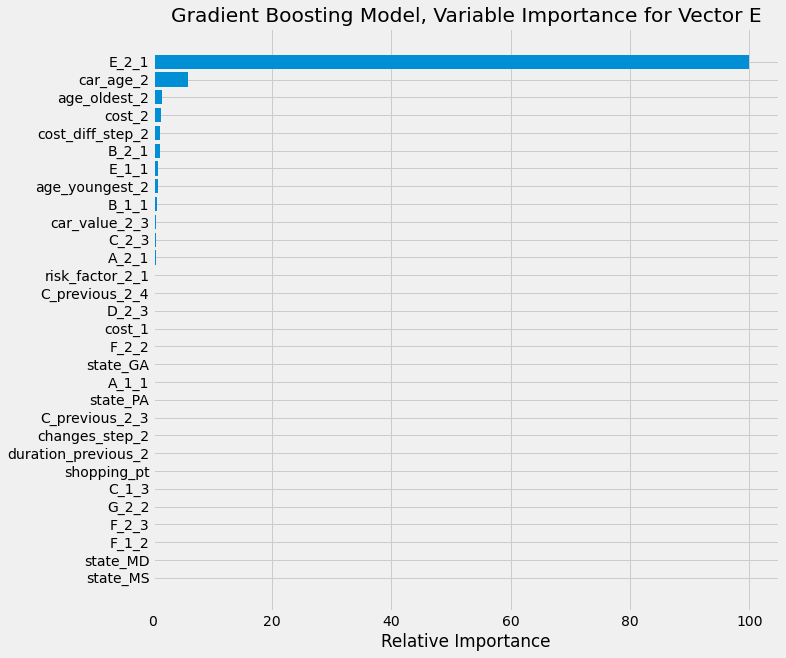

In [342]:
# Best GradientBoosting classifier for vector E

vector = 'E'

gb = GradientBoostingClassifier(n_estimators = 194, learning_rate = 0.7093, max_depth = 2, max_features = 6, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), gb_probs)
roc_auc3 = auc(fpr_3, tpr_3)

print("\nClassification Report \n", cr)
print("\nArea under ROC: \n", roc_auc3)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

The above model has a slightly lower accuracy score (0.839) vs the accuracy score (0.84) that we got in our base GB model.
Now let's try the second set of hyperparamters.

Gradient Boosting Classifier results for Vector E

Accuracy=0.839
f1-score=0.839
Confusion Matrix
 [[0.889 0.111]
 [0.22  0.78 ]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8425
           1       0.86      0.78      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.83      0.84     15522
weighted avg       0.84      0.84      0.84     15522


Area under ROC: 
 0.8961449586463791


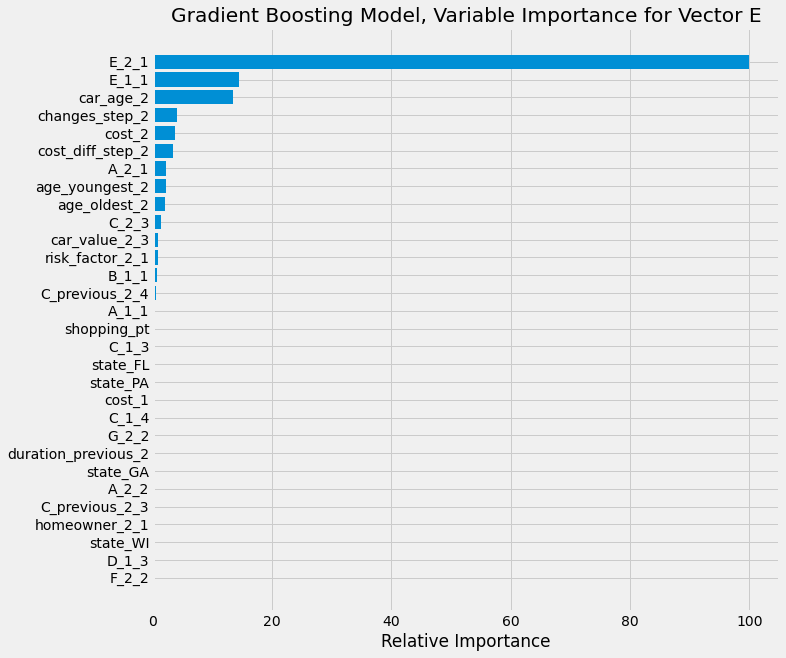

In [343]:
# 2nd Best GradientBoosting classifier (based on Bayesian Optimization) for vector E

vector = 'E'

gb = GradientBoostingClassifier(n_estimators = 169, learning_rate = 0.1971, max_depth = 3, max_features = 6, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), gb_probs)
roc_auc3 = auc(fpr_3, tpr_3)

print("\nClassification Report \n", cr)
print("\nArea under ROC: \n", roc_auc3)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

Both models based on Bayesian Optimization hyperparameters have slightly lower accuracy score (0.839) vs the accuracy score (0.84) that we got in our base GB model. Let's try couple of more hyperparamters setting - the hunch is to use base model, but only increase estimators from 150 to 200.

Gradient Boosting Classifier results for Vector E

Accuracy=0.840
f1-score=0.839
Confusion Matrix
 [[0.889 0.111]
 [0.218 0.782]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8425
           1       0.86      0.78      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522


Area under ROC: 
 0.8972704059766969


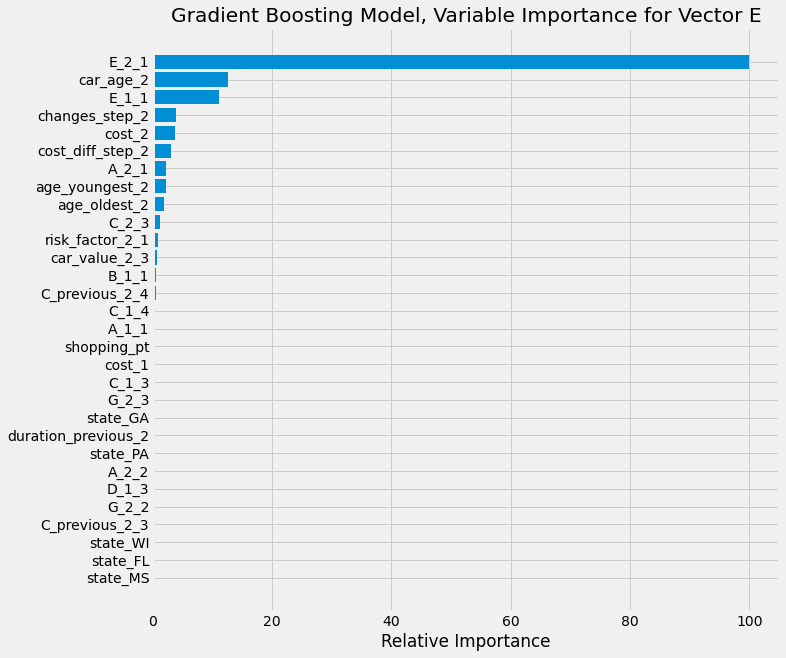

In [344]:
# Let's try another model based on our base model, and increase n_estimators from 150 to 200.
vector = 'E'

gb = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.25, max_depth = 3, max_features = 6, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), gb_probs)
roc_auc3 = auc(fpr_3, tpr_3)

print("\nClassification Report \n", cr)
print("\nArea under ROC: \n", roc_auc3)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

This model gives a slightly better auc of 0.8973 vs 0.8963 of base model. Now let's try to increase learning rate to 0.5 and check accuracy scores and auc.

Gradient Boosting Classifier results for Vector E

Accuracy=0.841
f1-score=0.840
Confusion Matrix - normalized
 [[0.886 0.114]
 [0.212 0.788]]
Confusion Matrix
 [[7463  962]
 [1506 5591]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      8425
           1       0.85      0.79      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522


Area under ROC: 
 0.8975530012472358


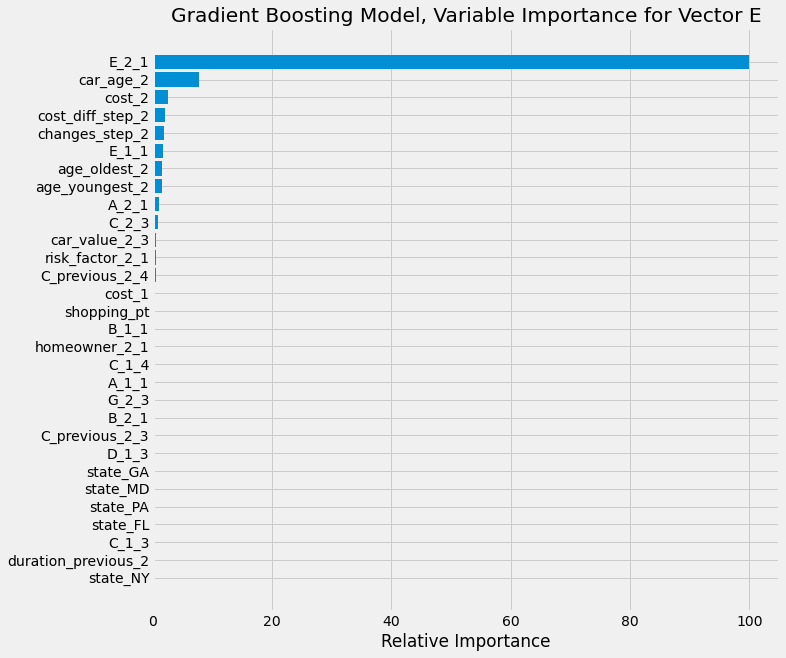

In [51]:
#Let's increase learning rate to 0.5 (BEST MODEL)

from sklearn.ensemble import GradientBoostingClassifier

vector = 'E'
gb = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.5, max_depth = 3, max_features = 6, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix - normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), gb_probs)
roc_auc3 = auc(fpr_3, tpr_3)

print("\nClassification Report \n", cr)
print("\nArea under ROC: \n", roc_auc3)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

The accuracy score went up from 0.84 to 0.841! And a marginal increase in auc as well (0.89755).
LEt's try to go for 250 estimators and check the results.



Gradient Boosting Classifier results for Vector E

Accuracy=0.840
f1-score=0.839
Confusion Matrix
 [[0.884 0.116]
 [0.212 0.788]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      8425
           1       0.85      0.79      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522


Area under ROC: 
 0.8973613208071787


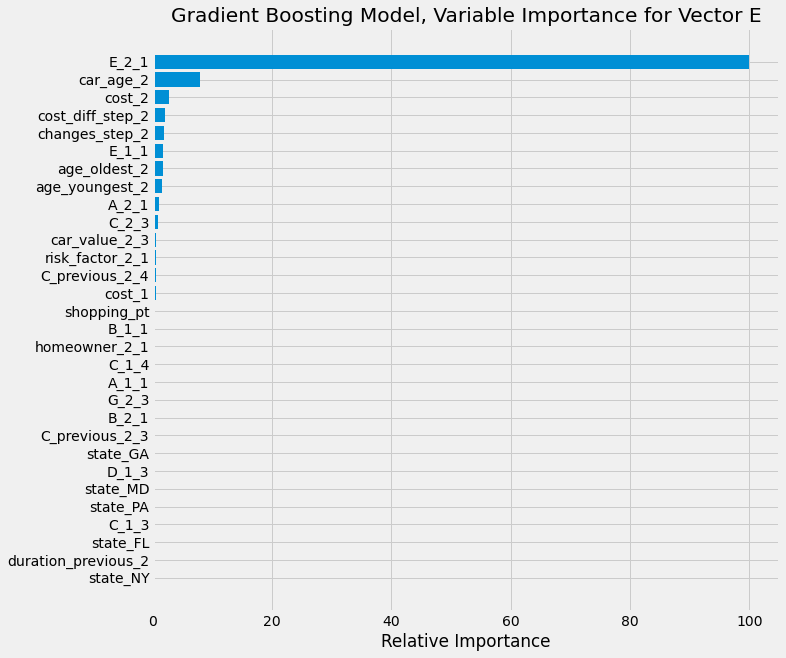

In [351]:
#Increase estimators to 250

vector = 'E'
gb = GradientBoostingClassifier(n_estimators = 250, learning_rate = 0.5, max_depth = 3, max_features = 6, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), gb_probs)
roc_auc3 = auc(fpr_3, tpr_3)

print("\nClassification Report \n", cr)
print("\nArea under ROC: \n", roc_auc3)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

Gradient Boosting Classifier results for Vector E

Accuracy=0.839
f1-score=0.838
Confusion Matrix
 [[0.885 0.115]
 [0.216 0.784]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      8425
           1       0.85      0.78      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.83      0.84     15522
weighted avg       0.84      0.84      0.84     15522


Area under ROC: 
 0.8959567234703175


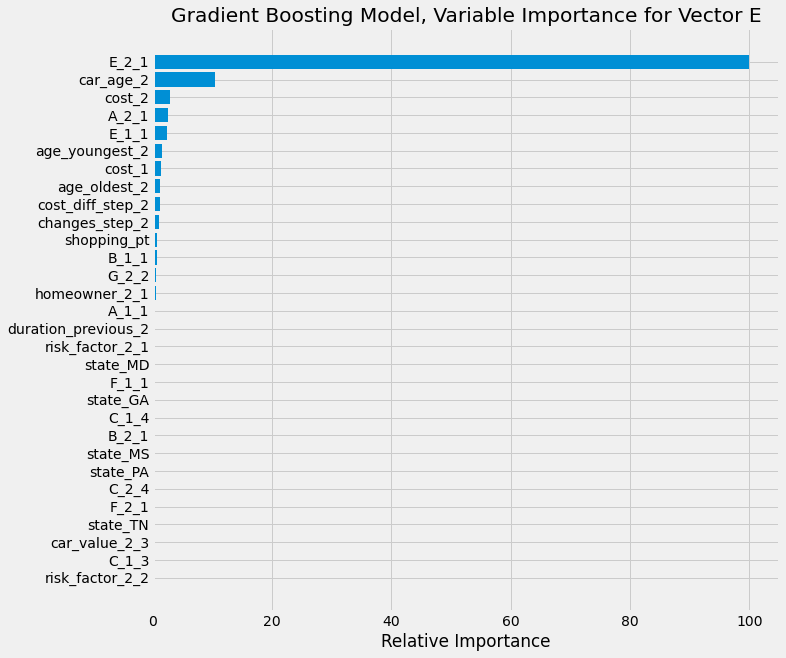

In [346]:
#Let's increase max_features to 8

vector = 'E'
gb = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.5, max_depth = 3, max_features = 8, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix\n", cm)

cr = classification_report(y_test[vector].astype('int'), y_pred)
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), gb_probs)
roc_auc3 = auc(fpr_3, tpr_3)

print("\nClassification Report \n", cr)
print("\nArea under ROC: \n", roc_auc3)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

In [353]:
#Let's run a base knn model for vector E

vector = 'E'
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = knn.predict(X_test.to_numpy())
y_pred_prob = knn.predict_proba(X_test.to_numpy())
kn_probs = y_pred_prob[:,1]

ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'), 3)

print(f'KNN Model for Vector {vector}: No. of Neighbors = 5' )

print('Accuracy=%.3f' % (ac))
print('f1-score=%.3f' % (f1))
print("Confusion Matrix\n", cm)

fpr_4, tpr_4, thresholds_4 = roc_curve(y_test[vector].astype('int'), kn_probs)
roc_auc4 = auc(fpr_4, tpr_4)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)
print("\nArea under ROC: \n", roc_auc4)




KNN Model for Vector E: No. of Neighbors = 5
Accuracy=0.779
f1-score=0.779
Confusion Matrix
 [[0.79  0.21 ]
 [0.233 0.767]]

Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.79      0.80      8425
           1       0.75      0.77      0.76      7097

    accuracy                           0.78     15522
   macro avg       0.78      0.78      0.78     15522
weighted avg       0.78      0.78      0.78     15522


Area under ROC: 
 0.8386927062841364


In [354]:
#Let's use Bayesian Optimization to find the best n_neighbors parameter

from bayes_opt import BayesianOptimization

vector = 'E'

def knn_eval(no_of_neighbors):
    
    knn = KNeighborsClassifier(n_neighbors= round(no_of_neighbors))
    
    cv_result = cross_validate(knn, X_train.to_numpy(), y_train[vector].astype('int'), cv= 5)
    return np.mean(cv_result['test_score'])

knn_bo = BayesianOptimization(knn_eval, {'no_of_neighbors': (1, 50)})

knn_bo.maximize(n_iter=10, init_points=2)

|   iter    |  target   | no_of_... |
-------------------------------------
|  1        |  0.8104   |  43.9     |
|  2        |  0.7203   |  1.628    |
|  3        |  0.8095   |  45.22    |
|  4        |  0.8086   |  27.66    |
|  5        |  0.8083   |  34.51    |
|  6        |  0.8044   |  20.52    |
|  7        |  0.8098   |  50.0     |
|  8        |  0.8087   |  39.32    |
|  9        |  0.8078   |  24.19    |
|  10       |  0.8077   |  31.12    |
|  11       |  0.8101   |  42.12    |
|  12       |  0.8092   |  43.17    |


In [355]:

knn_bo = BayesianOptimization(knn_eval, {'no_of_neighbors': (51, 100)})

knn_bo.maximize(n_iter=5, init_points=1)

|   iter    |  target   | no_of_... |
-------------------------------------
|  1        |  0.81     |  79.68    |
|  2        |  0.8085   |  97.24    |
|  3        |  0.81     |  86.41    |
|  4        |  0.8101   |  70.08    |
|  5        |  0.81     |  71.68    |
|  6        |  0.8105   |  59.86    |


Based on Bayesian Optimization, the best n_neighbors value is 60. Let's use this to train a model and predict vector E.

In [356]:
# knn model for vector E with n_neighbors = 60

vector = 'E'
knn = KNeighborsClassifier(n_neighbors=60)

knn.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = knn.predict(X_test.to_numpy())
y_pred_prob = knn.predict_proba(X_test.to_numpy())
kn_probs = y_pred_prob[:,1]

ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'), 3)

print(f'KNN Model for Vector {vector}: No. of Neighbors = 60' )

print('Accuracy=%.3f' % (ac))
print('f1-score=%.3f' % (f1))
print("Confusion Matrix\n", cm)

fpr_4, tpr_4, thresholds_4 = roc_curve(y_test[vector].astype('int'), kn_probs)
roc_auc4 = auc(fpr_4, tpr_4)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)
print("\nArea under ROC: \n", roc_auc4)

KNN Model for Vector E: No. of Neighbors = 60
Accuracy=0.809
f1-score=0.809
Confusion Matrix
 [[0.837 0.163]
 [0.224 0.776]]

Classification Report 
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      8425
           1       0.80      0.78      0.79      7097

    accuracy                           0.81     15522
   macro avg       0.81      0.81      0.81     15522
weighted avg       0.81      0.81      0.81     15522


Area under ROC: 
 0.8715034354383031


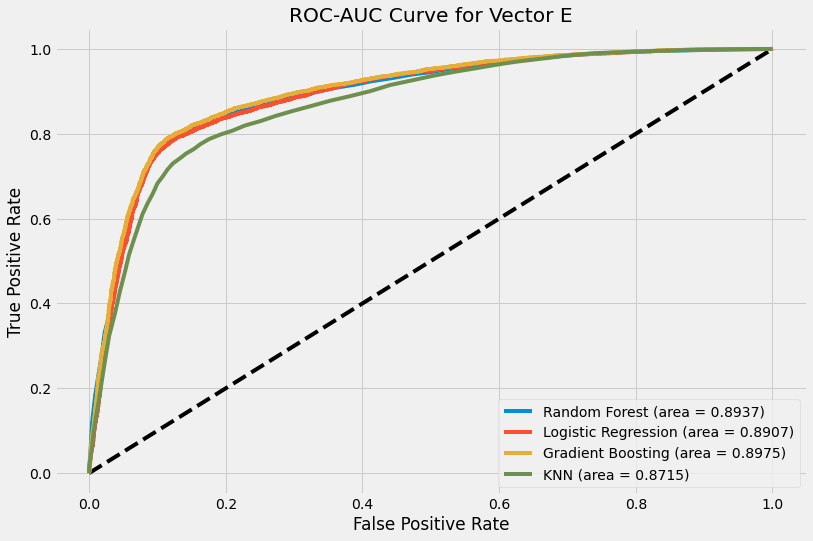

In [359]:
# Let's plot the ROC curve for all the models for vector E
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Random Forest (area = 0.8937)')
plt.plot(fpr_2, tpr_2, label='Logistic Regression (area = 0.8907)')
plt.plot(fpr_3, tpr_3, label='Gradient Boosting (area = 0.8975)')
plt.plot(fpr_4, tpr_4, label='KNN (area = 0.8715)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Vector '+vector)
plt.legend()
plt.show()


Best Threshold for Gradient Boost Model for Vector E = 0.4546
At Best Threshold, tpr =  0.8, fpr = 0.126


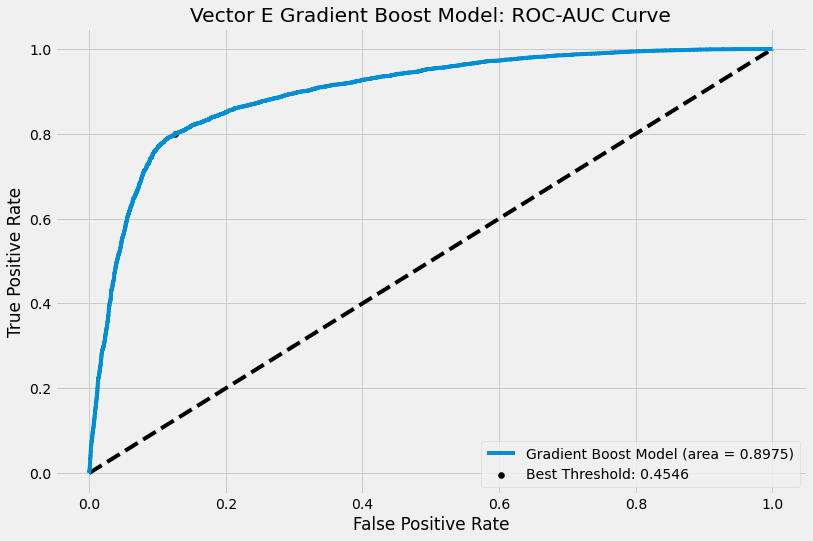

In [367]:
# Let's do thresholding for the best Model for vector E: Gradient Boost

plt.figure(figsize=(12,8))

Q_means_gb = np.sqrt(tpr_3*(1-fpr_3))
idx = np.argmax(Q_means_gb)

print(f'Best Threshold for Gradient Boost Model for Vector E = {thresholds_3[idx]:5.4}')
print(f'At Best Threshold, tpr = {tpr_3[idx]:4.3}, fpr = {fpr_3[idx]:4.3}')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_3, tpr_3, label='Gradient Boost Model (area = 0.8975)')
pyplot.scatter(fpr_3[idx], tpr_3[idx], marker='o', color='black', label='Best Threshold: '+str(np.round(thresholds_3[idx],4)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Vector E Gradient Boost Model: ROC-AUC Curve')
plt.legend()
plt.show()

Vector E Gradient Boost Model
Best Accuracy score of 0.8416 occurs for threshold = 0.493
Vector E Random Forest Model
Best Accuracy score of 0.8396 occurs for threshold = 0.501
Vector E XG Boost Model
Best Accuracy score of 0.8424 occurs for threshold = 0.505


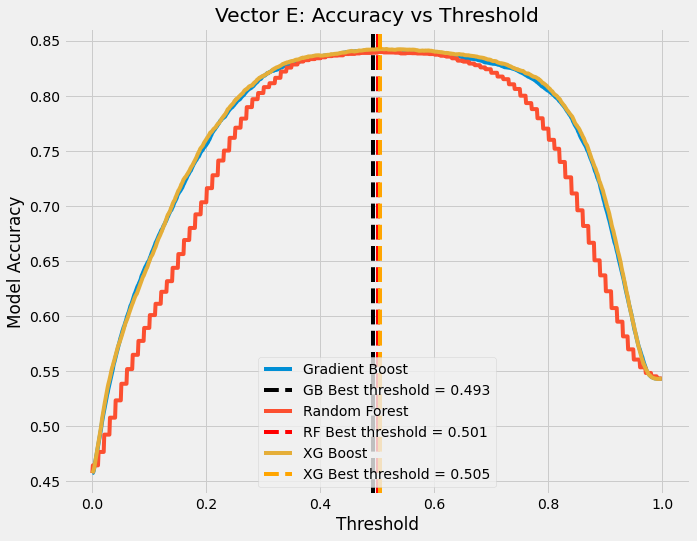

In [53]:
# We are concerned with accuracy of the model i.e. its ability to predict both the 0 and 1 labels correctly
# So we will calculate the accuracy score at different thresholds directly


plt.figure(figsize=(10,8))

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = np.arange(0, 1, 0.001)

# for gradient boost model
ac_score_gb = [accuracy_score(y_test[vector].astype('int'), to_labels(gb_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_gb)
print(f"Vector E Gradient Boost Model\nBest Accuracy score of {ac_score_gb[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_gb, label='Gradient Boost')
plt.axvline(thresholds[idx], color='black', linestyle="--", label = "GB Best threshold = "+str(np.round(thresholds[idx],4)))

# for random forest
thresholds = np.arange(0, 1, 0.001)
ac_score_rf = [accuracy_score(y_test[vector].astype('int'), to_labels(rf_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_rf)
print(f"Vector E Random Forest Model\nBest Accuracy score of {ac_score_rf[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_rf, label='Random Forest')
plt.axvline(thresholds[idx], color='red', linestyle="--", label = "RF Best threshold = "+str(np.round(thresholds[idx],4)))

# for XG Boost
thresholds = np.arange(0, 1, 0.001)
ac_score_xg = [accuracy_score(y_test[vector].astype('int'), to_labels(xg_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_xg)
print(f"Vector E XG Boost Model\nBest Accuracy score of {ac_score_xg[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_xg, label='XG Boost')
plt.axvline(thresholds[idx], color='orange', linestyle="--", label = "XG Best threshold = "+str(np.round(thresholds[idx],4)))

plt.xlabel('Threshold')
plt.ylabel('Model Accuracy')
plt.title('Vector E: Accuracy vs Threshold')

plt.legend()
plt.show()

In [ ]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector E

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'E'

param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)

clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = 60, verbose = 3, cv=4)

clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.841 total time=  14.9s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.840 total time=  15.9s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.839 total time=  16.2s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.839 total time=  16.2s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.840 total time=  11.8s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.841 total time=  11.4s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.840 total time=  12.3s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=300;, score=0.838 total time=  

In [ ]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']
results = pd.read_csv('Modelling_data/xgboost_results_vectorE.csv')

In [6]:
import xgboost as xgb

vector = 'E'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='binary:logistic', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results.loc[i, 'test_score'] = ac
    results.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")

    print(f'Accuracy={ac:4.4}, f1_score={f1:4.4}')

results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data"
save_file(results,"xgboost_results_vectorE.csv",datapath)
results

XGBoost Classifier results for Vector E

Parameters: No. of Estimators = 400.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.8382, f1_score=0.8377
Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.839, f1_score=0.8384
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.8404, f1_score=0.8398
Parameters: No. of Estimators = 400.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.25
Accuracy=0.8359, f1_score=0.8354
Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.8387, f1_score=0.8382
Parameters: No. of Estimators = 400.0,  max_depth = 3.0,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.842, f1_score=0.8414
Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.15
Accuracy=0.8408, f1

Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8388, f1_score=0.8383


In [8]:
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            400          4           0.30              0.50     0.839671   
1            300          5           0.25              0.35     0.839849   
2            200          4           0.30              0.35     0.842410   
3            400          4           0.50              0.25     0.834678   
4            300          5           0.25              0.25     0.841169   
5            400          3           0.25              0.50     0.843054   
6            300          4           0.25              0.15     0.842893   
7            200          4           0.50              0.25     0.839092   
8            100          5           0.50              0.35     0.838157   
9            400          3           0.50              0.35     0.838963   
10           200          3           0.35              0.25     0.842844   
11           100          3           0.25              0.25     0.841942   
12           100          3           0.50              0.50     0.842796   
13           400          5           0.25              0.50     0.837980   
14           500          5           0.35              0.25     0.834437   
15           200          5           0.50              0.35     0.833744   
16           400          5           0.35              0.50     0.833970   
17           400          3           0.35              0.35     0.841991   
18           200          3           0.30              0.50     0.843489   
19           500          4           0.30              0.50     0.838335   
20           500          3           0.50              0.25     0.839188   
21           400          4           0.25              0.25     0.841830   
22           200          3           0.35              0.50     0.842683   
23           500          3           0.30              0.25     0.842136   
24           400          4           0.35              0.35     0.839591   
25           400          5           0.50              0.25     0.828558   
26           500          4           0.50              0.50     0.830748   
27           500          4           0.30              0.25     0.839349   
28           100          5           0.30              0.50     0.842442   
29           200          5           0.35              0.50     0.838415   
30           300          4           0.30              0.50     0.841105   
31           500          4           0.30              0.35     0.840074   
32           300          3           0.50              0.35     0.839945   
33           500          4           0.25              0.25     0.841282   
34           500          4           0.35              0.50     0.836047   
35           100          3           0.25              0.35     0.842989   
36           300          3           0.30              0.35     0.843134   
37           500          5           0.25              0.35     0.836611   
38           100          3           0.50              0.25     0.842571   
39           500          4           0.25              0.50     0.839897   
40           100          5           0.35              0.35     0.842184   
41           300          4           0.30              0.15     0.842345   
42           200          5           0.25              0.15     0.842361   
43           400          5           0.35              0.15     0.837368   
44           100          3           0.25              0.15     0.839526   
45           500          5           0.30              0.35     0.835661   
46           400          4           0.35              0.15     0.840573   
47           300          4           0.35              0.25     0.840557   
48           300          5           0.50              0.50     0.829556   
49           400          3           0.30              0.35     0.842571   
50           500          3           0.35              0.25     0.841733   


In [10]:
datapath="Modelling_data"
save_file(results,"xgboost_results_vectorE.csv",datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "Modelling_data\xgboost_results_vectorE.csv"


XGBoost Classifier results for Vector E

Parameters: No. of Estimators = 400,  max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.5

Accuracy=0.8420
f1-score=0.8414
Confusion Matrix - normalized
 [[0.884 0.116]
 [0.208 0.792]]
Confusion Matrix
 [[7450  975]
 [1477 5620]]

Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      8425
           1       0.85      0.79      0.82      7097

    accuracy                           0.84     15522
   macro avg       0.84      0.84      0.84     15522
weighted avg       0.84      0.84      0.84     15522

30


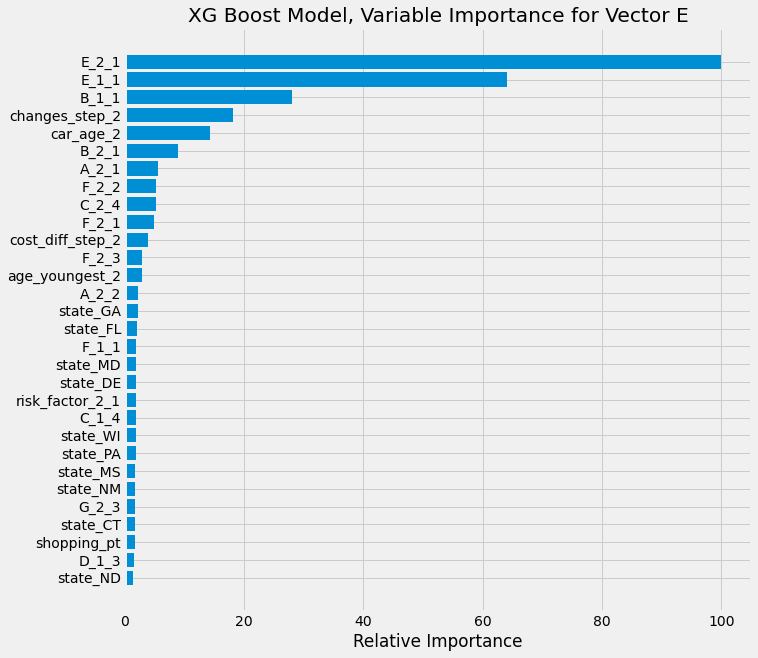

In [50]:
# model E with XGBoost classifier Best Parameters: Iteration 5 (above)

import xgboost as xgb

plt.style.use('fivethirtyeight')
vector = 'E'

#param_grid
n_estimators = 400
max_depth = 3
learning_rate = 0.25
colsample_bytree = 0.5
        
clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='binary:logistic', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = clf.predict(X_test.to_numpy())
y_pred_prob = clf.predict_proba(X_test.to_numpy())
xg_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)


print(f"XGBoost Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}\n")

print('Accuracy=%.4f' % (ac))

print('f1-score=%.4f' % (f1))

print("Confusion Matrix - normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('XG Boost Model, Variable Importance for Vector '+vector)
plt.show()

Random Forest Classifier results for Vector C

Accuracy=0.832
f1-score=0.831
Confusion Matrix - Normalized
 [[0.842 0.074 0.08  0.005]
 [0.122 0.75  0.12  0.008]
 [0.045 0.046 0.882 0.027]
 [0.037 0.016 0.171 0.776]]
Confusion Matrix
 [[3959  346  376   22]
 [ 395 2427  387   26]
 [ 273  279 5336  162]
 [  56   25  263 1190]]

Classification Report 
               precision    recall  f1-score   support

           1       0.85      0.84      0.84      4703
           2       0.79      0.75      0.77      3235
           3       0.84      0.88      0.86      6050
           4       0.85      0.78      0.81      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.81      0.82     15522
weighted avg       0.83      0.83      0.83     15522

30


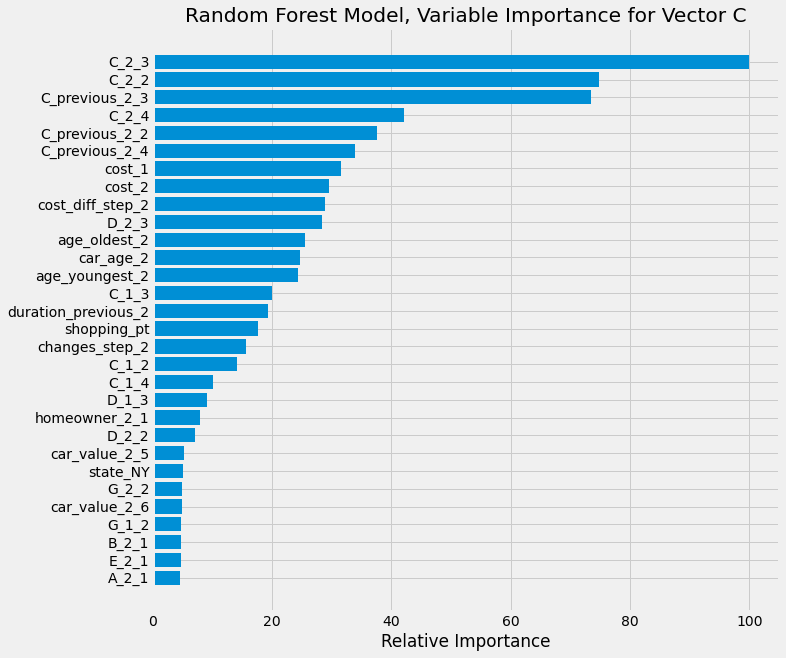

In [401]:
# Let's run the model for vector C
 
vector = 'C'

    
clf = RandomForestClassifier(n_estimators=300,  random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = model_res.predict(X_test.to_numpy())
y_pred_prob = model_res.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

print(f"Random Forest Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix - Normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Model, Variable Importance for Vector '+vector)
plt.show()

In [399]:
#test_set = df_train_first2.iloc[y_test.index,:]

vector = 'C'

x = pd.crosstab(test_set['C'], test_set['C_2'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")

Accuracy based on simply predicting vector C = C_2 :  0.804


In [400]:

x['total'] = x.sum(axis=1)
x['C1_%'] = np.around(x[1]*100 / x['total'], 2)
x['C2_%'] = np.around(x[2]*100 / x['total'], 2)
x['C3_%'] = np.around(x[3]*100 / x['total'], 2)
x['C4_%'] = np.around(x[4]*100 / x['total'], 2)

x


C_2     1     2     3     4  total   C1_%   C2_%   C3_%   C4_%
C                                                             
1    3826   348   513    16   4703  81.35   7.40  10.91   0.34
2     422  2309   480    24   3235  13.04  71.38  14.84   0.74
3     386   286  5257   121   6050   6.38   4.73  86.89   2.00
4      97    36   314  1087   1534   6.32   2.35  20.47  70.86

In [413]:
vector = 'C'

def rf_eval(estimators, min_leaf, min_split):
    
    rf = RandomForestClassifier(n_estimators = round(estimators), min_samples_leaf = round(min_leaf), \
                                    min_samples_split = round(min_split), random_state = 1, n_jobs=-1)
    
    cv_result = cross_validate(rf, X_train.to_numpy(), y_train[vector].astype('int'), cv= 4)
    return np.mean(cv_result['test_score'])

rf_bo = BayesianOptimization(rf_eval, {'estimators': (100, 1000), 'min_leaf': (1, 5), 'min_split': (2, 6)})

rf_bo.maximize(n_iter=10, init_points=2)


|   iter    |  target   | estima... | min_leaf  | min_split |
-------------------------------------------------------------
|  1        |  0.8316   |  239.3    |  2.743    |  3.575    |
|  2        |  0.832    |  598.0    |  3.308    |  4.555    |
|  3        |  0.8309   |  599.0    |  3.973    |  4.056    |
|  4        |  0.8333   |  418.0    |  1.617    |  4.883    |
|  5        |  0.8327   |  817.0    |  2.423    |  5.577    |
|  6        |  0.8333   |  418.1    |  2.153    |  4.554    |
|  7        |  0.8331   |  416.7    |  2.439    |  5.695    |
|  8        |  0.8338   |  416.9    |  1.45     |  2.981    |
|  9        |  0.832    |  415.3    |  3.379    |  2.351    |
|  10       |  0.8338   |  418.8    |  1.31     |  2.379    |
|  11       |  0.8331   |  421.4    |  2.5      |  2.588    |
|  12       |  0.8336   |  593.7    |  1.942    |  5.29     |


Random Forest Classifier results for Vector C

Accuracy=0.832
f1-score=0.832
Confusion Matrix - Normalized
 [[0.842 0.073 0.08  0.005]
 [0.122 0.752 0.118 0.008]
 [0.045 0.045 0.882 0.027]
 [0.035 0.016 0.171 0.777]]
Confusion Matrix
 [[3958  345  378   22]
 [ 394 2432  382   27]
 [ 273  275 5337  165]
 [  54   25  263 1192]]

Classification Report 
               precision    recall  f1-score   support

           1       0.85      0.84      0.84      4703
           2       0.79      0.75      0.77      3235
           3       0.84      0.88      0.86      6050
           4       0.85      0.78      0.81      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.81      0.82     15522
weighted avg       0.83      0.83      0.83     15522

30


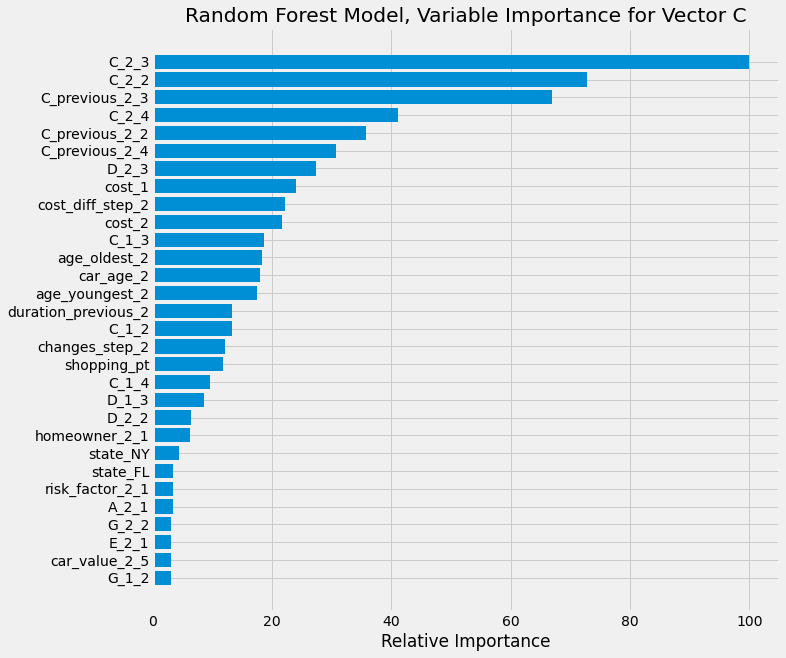

In [423]:
vector = 'C'

# param_grid
n_estimators=300
min_samples_leaf = 1
min_samples_split = 5
    
clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf = min_samples_leaf, \
                             min_samples_split = min_samples_split, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = model_res.predict(X_test.to_numpy())
y_pred_prob = model_res.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

print(f"Random Forest Classifier results for Vector {vector}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix - Normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Model, Variable Importance for Vector '+vector)
plt.show()

Gradient Boosting Classifier results for Vector C

Parameters: No. of Estimators = 150,  learning_rate = 0.25, max_depth = 3, max_features = 6

Accuracy=0.829
f1-score=0.828
Confusion Matrix - Normalized
 [[0.843 0.07  0.081 0.005]
 [0.124 0.737 0.129 0.009]
 [0.044 0.047 0.878 0.031]
 [0.029 0.016 0.172 0.783]]
Confusion Matrix
 [[3966  331  383   23]
 [ 402 2385  418   30]
 [ 268  284 5311  187]
 [  44   25  264 1201]]

Classification Report 
               precision    recall  f1-score   support

           1       0.85      0.84      0.85      4703
           2       0.79      0.74      0.76      3235
           3       0.83      0.88      0.85      6050
           4       0.83      0.78      0.81      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.81      0.82     15522
weighted avg       0.83      0.83      0.83     15522



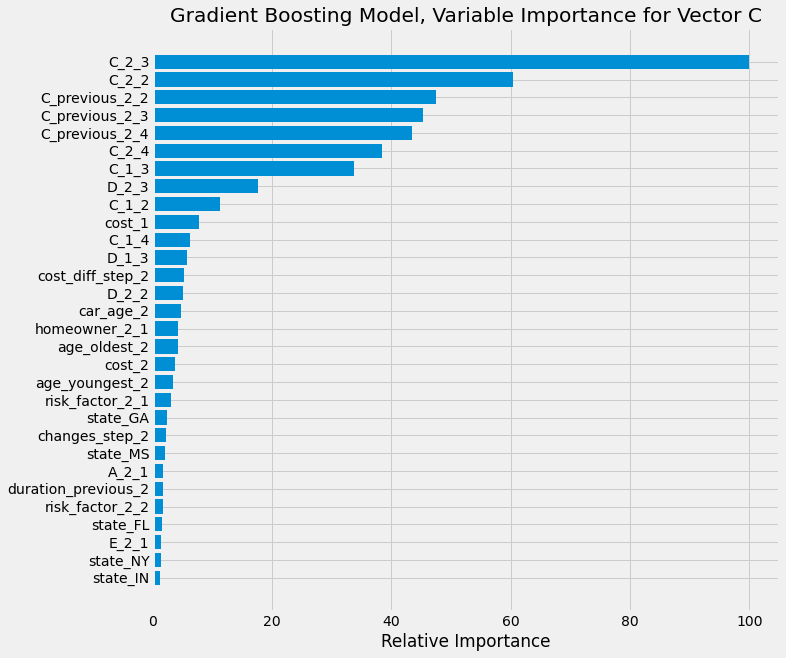

In [407]:
# model C with GradientBoosting classifier

vector = 'C'

#param_grid
n_estimators = 150
max_features = 6
max_depth = 3 
learning_rate = 0.25

    
gb = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, \
                                max_features = max_features, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  learning_rate = {learning_rate}, max_depth = {max_depth}, max_features = {max_features}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix - Normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

In [403]:
# Let's use RandomizedSearchCV to find the best GradientBoosting classifier Hyperparamters for vector C

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

vector = 'C'

param_grid = {'learning_rate' : [0.25, 0.5, 0.75, 1], 'n_estimators' : [50, 100, 150, 200], \
              'max_features': [2,4,6,8], 'max_depth' : [1,2,3]}

gb = GradientBoostingClassifier(random_state = 1, n_jobs=-1)

gb_cv = RandomizedSearchCV(gb, param_grid, n_iter = 10, verbose = 3, cv=5)

gb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: Gradient Boosting Model\nBest Score:" + str(gb_cv.best_score_))
print("\nBest Parameters: " + str(gb_cv.best_params_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.5, max_depth=2, max_features=4, n_estimators=150;, score=0.830 total time=  30.7s
[CV 2/5] END learning_rate=0.5, max_depth=2, max_features=4, n_estimators=150;, score=0.828 total time=  30.1s
[CV 3/5] END learning_rate=0.5, max_depth=2, max_features=4, n_estimators=150;, score=0.829 total time=  31.7s
[CV 4/5] END learning_rate=0.5, max_depth=2, max_features=4, n_estimators=150;, score=0.828 total time=  30.8s
[CV 5/5] END learning_rate=0.5, max_depth=2, max_features=4, n_estimators=150;, score=0.825 total time=  30.3s
[CV 1/5] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=150;, score=0.831 total time=  44.6s
[CV 2/5] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=150;, score=0.833 total time=  43.2s
[CV 3/5] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=150;, score=0.831 total time=  42.9s
[CV 4/5] END learning_rate=0.25, max_depth=3, ma

In [404]:
vector = 'C'

param_grid = {'learning_rate' : [0.25, 0.4, 0.5], 'n_estimators' : [150, 200], \
              'max_features': [6,8,10], 'max_depth' : [3, 4]}

gb = GradientBoostingClassifier(random_state = 1)

gb_cv = RandomizedSearchCV(gb, param_grid, n_iter = 10, verbose = 3, cv=4)

gb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: Gradient Boosting Model\nBest Score:" + str(gb_cv.best_score_))
print("\nBest Parameters: " + str(gb_cv.best_params_))


Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=200;, score=0.833 total time=  45.7s
[CV 2/4] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=200;, score=0.836 total time=  47.8s
[CV 3/4] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=200;, score=0.830 total time=  47.2s
[CV 4/4] END learning_rate=0.25, max_depth=3, max_features=6, n_estimators=200;, score=0.832 total time=  47.6s
[CV 1/4] END learning_rate=0.4, max_depth=3, max_features=8, n_estimators=150;, score=0.832 total time=  40.9s
[CV 2/4] END learning_rate=0.4, max_depth=3, max_features=8, n_estimators=150;, score=0.834 total time=  40.2s
[CV 3/4] END learning_rate=0.4, max_depth=3, max_features=8, n_estimators=150;, score=0.829 total time=  40.5s
[CV 4/4] END learning_rate=0.4, max_depth=3, max_features=8, n_estimators=150;, score=0.830 total time=  40.7s
[CV 1/4] END learning_rate=0.25, max_depth=4, m

In [406]:
vector = 'C'

param_grid = {'learning_rate' : [0.2, 0.25, 0.3], 'n_estimators' : [200], \
              'max_features': [6,8], 'max_depth' : [3]}

gb = GradientBoostingClassifier(random_state = 1)

gb_cv = RandomizedSearchCV(gb, param_grid, n_iter = 6, verbose = 3, cv=4)

gb_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: Gradient Boosting Model\nBest Score:" + str(gb_cv.best_score_))
print("\nBest Parameters: " + str(gb_cv.best_params_))

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4] END learning_rate=0.2, max_depth=3, max_features=6, n_estimators=200;, score=0.834 total time=  45.4s
[CV 2/4] END learning_rate=0.2, max_depth=3, max_features=6, n_estimators=200;, score=0.834 total time=  47.5s
[CV 3/4] END learning_rate=0.2, max_depth=3, max_features=6, n_estimators=200;, score=0.828 total time=  48.3s
[CV 4/4] END learning_rate=0.2, max_depth=3, max_features=6, n_estimators=200;, score=0.831 total time=  48.3s
[CV 1/4] END learning_rate=0.2, max_depth=3, max_features=8, n_estimators=200;, score=0.832 total time=  54.0s
[CV 2/4] END learning_rate=0.2, max_depth=3, max_features=8, n_estimators=200;, score=0.835 total time=  52.8s
[CV 3/4] END learning_rate=0.2, max_depth=3, max_features=8, n_estimators=200;, score=0.830 total time=  55.9s
[CV 4/4] END learning_rate=0.2, max_depth=3, max_features=8, n_estimators=200;, score=0.834 total time=  53.9s
[CV 1/4] END learning_rate=0.25, max_depth=3, max_fe

Gradient Boosting Classifier results for Vector C

Parameters: No. of Estimators = 200,  learning_rate = 0.25, max_depth = 3, max_features = 6

Accuracy=0.830
f1-score=0.829
Confusion Matrix - Normalized
 [[0.842 0.072 0.081 0.005]
 [0.124 0.742 0.125 0.009]
 [0.043 0.048 0.879 0.031]
 [0.025 0.016 0.171 0.788]]
Confusion Matrix
 [[3961  339  379   24]
 [ 400 2401  405   29]
 [ 259  289 5315  187]
 [  39   24  262 1209]]

Classification Report 
               precision    recall  f1-score   support

           1       0.85      0.84      0.85      4703
           2       0.79      0.74      0.76      3235
           3       0.84      0.88      0.86      6050
           4       0.83      0.79      0.81      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.81      0.82     15522
weighted avg       0.83      0.83      0.83     15522



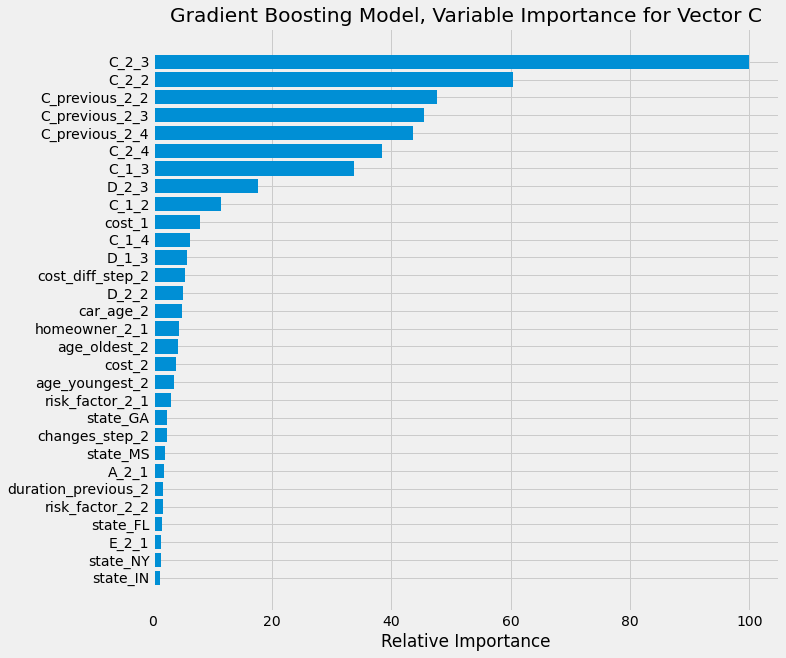

In [408]:
# model C with GradientBoosting classifier
# Best Parameters: {'n_estimators': 200, 'max_features': 6, 'max_depth': 3, 'learning_rate': 0.25}

vector = 'C'

#param_grid
n_estimators = 200
max_features = 6
max_depth = 3 
learning_rate = 0.25

    
gb = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, \
                                max_features = max_features, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  learning_rate = {learning_rate}, max_depth = {max_depth}, max_features = {max_features}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix - Normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

Gradient Boosting Classifier results for Vector C

Parameters: No. of Estimators = 200,  learning_rate = 0.25, max_depth = 3, max_features = 8

Accuracy=0.832
f1-score=0.831
Confusion Matrix - Normalized
 [[0.848 0.07  0.077 0.005]
 [0.126 0.741 0.125 0.009]
 [0.044 0.045 0.88  0.031]
 [0.025 0.016 0.169 0.789]]
Confusion Matrix
 [[3986  328  364   25]
 [ 406 2397  403   29]
 [ 264  274 5323  189]
 [  39   25  259 1211]]

Classification Report 
               precision    recall  f1-score   support

           1       0.85      0.85      0.85      4703
           2       0.79      0.74      0.77      3235
           3       0.84      0.88      0.86      6050
           4       0.83      0.79      0.81      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.81      0.82     15522
weighted avg       0.83      0.83      0.83     15522



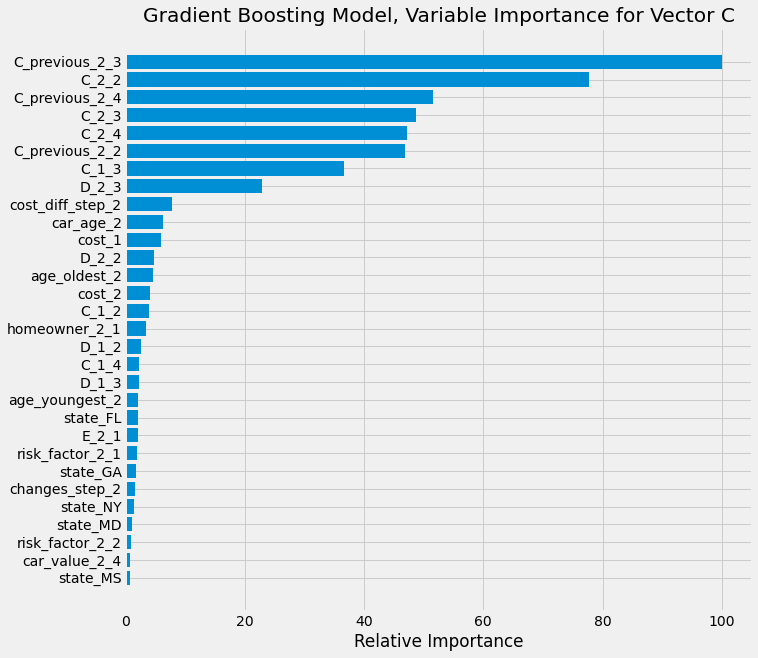

In [409]:
# model C with GradientBoosting classifier
# Best Parameters: {'n_estimators': 200, 'max_features': 6, 'max_depth': 3, 'learning_rate': 0.25}

vector = 'C'

#param_grid
n_estimators = 200
max_features = 8
max_depth = 3 
learning_rate = 0.25

    
gb = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, \
                                max_features = max_features, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  learning_rate = {learning_rate}, max_depth = {max_depth}, max_features = {max_features}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix - Normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

Gradient Boosting Classifier results for Vector C

Parameters: No. of Estimators = 200,  learning_rate = 0.2, max_depth = 3, max_features = 8

Accuracy=0.832
f1-score=0.831
Confusion Matrix - Normalized
 [[0.848 0.071 0.076 0.006]
 [0.123 0.743 0.124 0.01 ]
 [0.044 0.047 0.879 0.03 ]
 [0.031 0.015 0.169 0.786]]
Confusion Matrix
 [[3988  332  356   27]
 [ 399 2403  401   32]
 [ 267  284 5319  180]
 [  47   23  259 1205]]

Classification Report 
               precision    recall  f1-score   support

           1       0.85      0.85      0.85      4703
           2       0.79      0.74      0.77      3235
           3       0.84      0.88      0.86      6050
           4       0.83      0.79      0.81      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.81      0.82     15522
weighted avg       0.83      0.83      0.83     15522



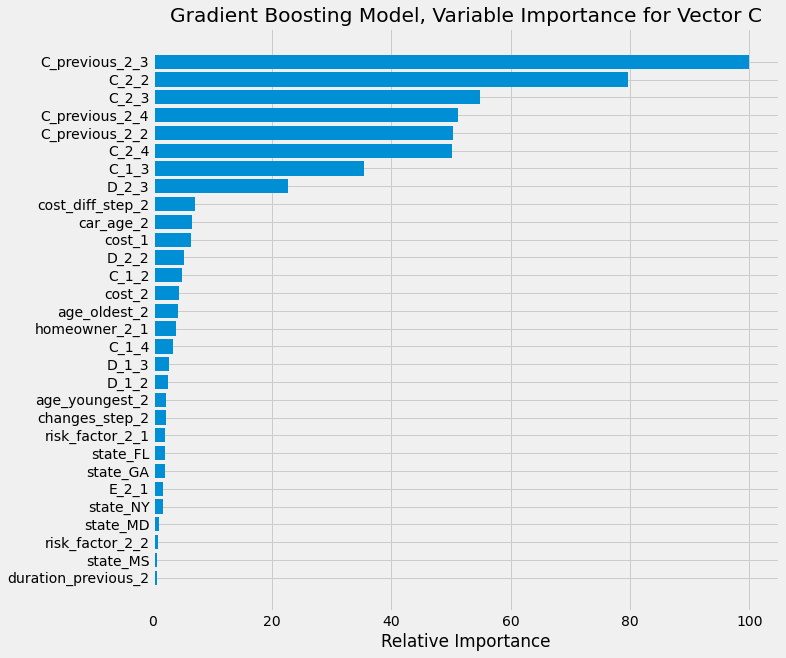

In [412]:
# model C with GradientBoosting classifier
# Best Parameters: {'n_estimators': 200, 'max_features': 6, 'max_depth': 3, 'learning_rate': 0.25}

vector = 'C'

#param_grid
n_estimators = 200
max_features = 8
max_depth = 3 
learning_rate = 0.2

    
gb = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, \
                                max_features = max_features, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  learning_rate = {learning_rate}, max_depth = {max_depth}, max_features = {max_features}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix - Normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

Notes for Vector C:
* changing l_rate from 0.25 to 0.2/0.3/0.4 reduced score marginally


In [75]:
y_train['C'].value_counts()

3    24363
1    18451
2    13020
4     6251
Name: C, dtype: int64

In [ ]:
y_test['C'].value_counts()

In [76]:
mapping_C = {1:0, 2:1, 3:2, 4:3}

y_train['C'] = y_train['C'].map(lambda x: mapping_C[x] )
y_test['C'] = y_test['C'].map(lambda x: mapping_C[x] )
y_train['C'].value_counts()


C:\Users\amite\AppData\Local\Temp/ipykernel_33952/1911054288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['C'] = y_train['C'].map(lambda x: mapping_C[x] )
C:\Users\amite\AppData\Local\Temp/ipykernel_33952/1911054288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['C'] = y_test['C'].map(lambda x: mapping_C[x] )


2    24363
0    18451
1    13020
3     6251
Name: C, dtype: int64

In [77]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector C

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'C'

param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)

clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = 60, verbose = 3, cv=4)

clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))


Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.835 total time=   5.3s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.837 total time=   5.0s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.831 total time=   5.0s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.833 total time=   5.3s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.834 total time=  28.2s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.835 total time=  30.0s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.830 total time=  30.5s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.831 total time=  

[CV 2/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.836 total time=  10.3s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.831 total time=  10.2s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.833 total time=  10.0s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=4, n_estimators=500;, score=0.835 total time=  30.3s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=4, n_estimators=500;, score=0.834 total time=  37.1s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=4, n_estimators=500;, score=0.831 total time=  54.5s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=4, n_estimators=500;, score=0.832 total time=  51.4s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=300;, score=0.826 total time=  33.9s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.

[CV 4/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.830 total time=  31.4s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.836 total time=  15.4s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.836 total time=  15.8s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.832 total time=  16.0s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.832 total time=  16.3s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.834 total time=  12.4s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.838 total time=  12.3s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.832 total time=  12.3s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.3, m

[CV 2/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=200;, score=0.837 total time=  15.6s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=200;, score=0.833 total time=  15.0s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=200;, score=0.834 total time=  15.9s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.834 total time=  25.7s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.836 total time=  23.7s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.829 total time=  24.7s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.830 total time=  23.3s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=4, n_estimators=100;, score=0.833 total time=   4.0s
[CV 2/4] END colsample_bytree=0.15, learning_rate

In [78]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']

save_file(results, 'xgboost_results_vectorC.csv', datapath)

Writing file.  "Modelling_data\xgboost_results_vectorC.csv"


In [79]:
import xgboost as xgb

vector = 'C'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='multi:softprob', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results.loc[i, 'test_score'] = ac
    results.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")

    print(f'Accuracy={ac:4.4}, f1_score={f1:4.4}')

results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data"
save_file(results,"xgboost_results_vectorC_2.csv",datapath)


XGBoost Classifier results for Vector C

Parameters: No. of Estimators = 100.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.35
Accuracy=0.832, f1_score=0.8313
Parameters: No. of Estimators = 500.0,  max_depth = 3.0,     learning_rate = 0.35, colsample_bytree = 0.5
Accuracy=0.8311, f1_score=0.8304
Parameters: No. of Estimators = 400.0,  max_depth = 3.0,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.8306, f1_score=0.8299
Parameters: No. of Estimators = 100.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.5
Accuracy=0.8339, f1_score=0.8331
Parameters: No. of Estimators = 400.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.8328, f1_score=0.8321
Parameters: No. of Estimators = 100.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.8322, f1_score=0.8315
Parameters: No. of Estimators = 200.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.8332, f1_

Parameters: No. of Estimators = 200.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8313, f1_score=0.8306
Writing file.  "Modelling_data\xgboost_results_vectorC_2.csv"


In [80]:
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            100          4           0.50              0.35     0.833889   
1            500          3           0.35              0.50     0.832552   
2            400          3           0.30              0.35     0.833905   
3            100          4           0.50              0.50     0.833003   
4            400          4           0.25              0.35     0.834517   
5            100          5           0.30              0.35     0.835065   
6            200          5           0.30              0.25     0.834115   
7            300          3           0.50              0.15     0.832713   
8            400          5           0.50              0.50     0.825691   
9            300          4           0.25              0.35     0.834807   
10           400          3           0.35              0.50     0.833519   
11           100          3           0.25              0.50     0.832874   
12           200          3           0.30              0.35     0.834421   
13           500          4           0.50              0.15     0.827720   
14           400          4           0.25              0.50     0.833680   
15           200          4           0.25              0.15     0.834195   
16           200          3           0.25              0.35     0.834549   
17           100          5           0.35              0.50     0.833647   
18           500          4           0.25              0.35     0.833068   
19           300          5           0.50              0.35     0.826705   
20           500          5           0.25              0.50     0.830329   
21           300          3           0.25              0.35     0.835097   
22           100          4           0.35              0.35     0.833760   
23           200          4           0.25              0.25     0.834839   
24           200          3           0.35              0.15     0.833309   
25           400          5           0.25              0.50     0.831586   
26           200          3           0.30              0.15     0.833341   
27           200          3           0.50              0.35     0.832617   
28           500          3           0.30              0.35     0.833631   
29           300          4           0.30              0.35     0.834388   
30           500          3           0.25              0.15     0.834453   
31           200          5           0.35              0.25     0.833213   
32           500          3           0.30              0.25     0.833212   
33           300          3           0.30              0.50     0.835049   
34           400          4           0.35              0.50     0.830313   
35           400          3           0.30              0.25     0.833841   
36           400          3           0.30              0.15     0.834388   
37           300          3           0.50              0.35     0.832327   
38           200          4           0.35              0.15     0.833486   
39           100          3           0.25              0.15     0.827575   
40           400          3           0.50              0.35     0.831505   
41           300          3           0.50              0.25     0.832037   
42           400          5           0.50              0.25     0.825836   
43           400          5           0.35              0.35     0.830023   
44           500          3           0.30              0.15     0.834211   
45           200          4           0.35              0.50     0.833357   
46           300          5           0.35              0.25     0.831022   
47           400          4           0.30              0.35     0.833277   
48           500          5           0.35              0.15     0.828606   
49           300          3           0.35              0.15     0.833647   
50           500          4           0.25              0.50     0.832278   


XGBoost Classifier results for Vector C

Parameters: No. of Estimators = 200,  max_depth = 5, learning_rate = 0.25, colsample_bytree = 0.35

Accuracy=0.8343
f1-score=0.8336
Confusion Matrix - normalized
 [[0.85  0.071 0.074 0.005]
 [0.124 0.741 0.126 0.009]
 [0.042 0.046 0.882 0.03 ]
 [0.024 0.016 0.165 0.795]]
Confusion Matrix
 [[3997  333  350   23]
 [ 400 2398  408   29]
 [ 253  279 5335  183]
 [  37   24  253 1220]]

Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      4703
           1       0.79      0.74      0.77      3235
           2       0.84      0.88      0.86      6050
           3       0.84      0.80      0.82      1534

    accuracy                           0.83     15522
   macro avg       0.83      0.82      0.82     15522
weighted avg       0.83      0.83      0.83     15522

30


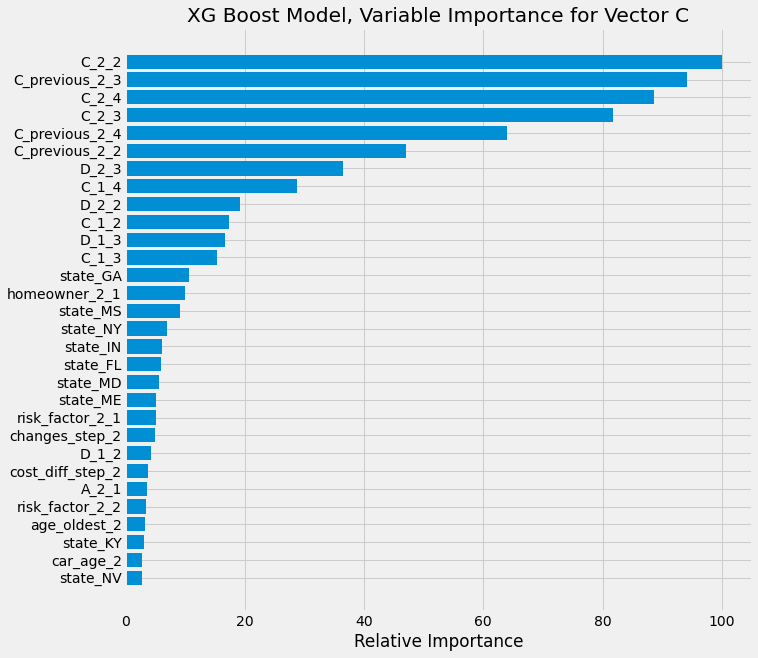

In [93]:
# model C with XGBoost classifier Best Parameters: (Overall 2nd rank model)
#  No. of Estimators = 200,  max_depth = 5, learning_rate = 0.25, colsample_bytree = 0.35 : 0.7601, 0.7592


import xgboost as xgb

vector = 'C'

#param_grid
n_estimators = 200
max_depth = 5
learning_rate = 0.25
colsample_bytree = 0.35
        
clf = xgb.XGBClassifier(max_depth=max_depth, objective='multi:softproba', n_estimators=n_estimators, \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs = -1, random_state = 1)

clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = clf.predict(X_test.to_numpy())
y_pred_prob = clf.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)


print(f"XGBoost Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}\n")

print('Accuracy=%.4f' % (ac))

print('f1-score=%.4f' % (f1))

print("Confusion Matrix - normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('XG Boost Model, Variable Importance for Vector '+vector)
plt.show()

Random Forest Classifier results for Vector D, min_samples_leaf = 1

Accuracy=0.862
f1-score=0.863
Confusion Matrix- normalized
 [[0.81   0.064  0.126 ]
 [0.0925 0.7608 0.1467]
 [0.0325 0.0608 0.9066]]
Confusion Matrix
 [[1633  129  254]
 [ 317 2608  503]
 [ 328  613 9137]]

Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.81      0.76      2016
           1       0.78      0.76      0.77      3428
           2       0.92      0.91      0.91     10078

    accuracy                           0.86     15522
   macro avg       0.81      0.83      0.82     15522
weighted avg       0.86      0.86      0.86     15522

30


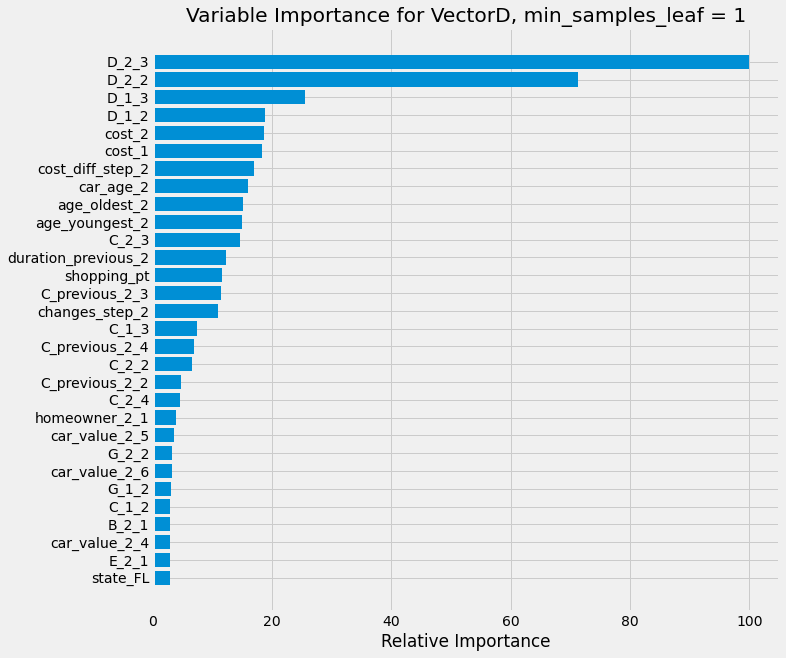

Random Forest Classifier results for Vector D, min_samples_leaf = 2

Accuracy=0.862
f1-score=0.863
Confusion Matrix- normalized
 [[0.8115 0.0635 0.125 ]
 [0.0928 0.7628 0.1444]
 [0.0325 0.0615 0.9059]]
Confusion Matrix
 [[1636  128  252]
 [ 318 2615  495]
 [ 328  620 9130]]

Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.81      0.76      2016
           1       0.78      0.76      0.77      3428
           2       0.92      0.91      0.92     10078

    accuracy                           0.86     15522
   macro avg       0.81      0.83      0.82     15522
weighted avg       0.87      0.86      0.86     15522

30


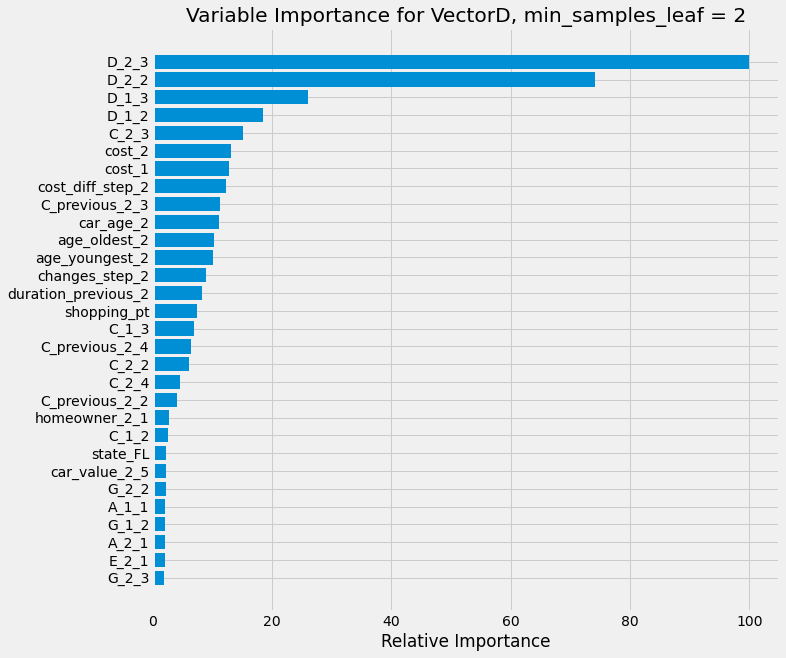

In [90]:
# Let's run the model for vector D


plt.style.use("fivethirtyeight")

vector = 'D'

for min_leaf in range(1,3):
    
    clf = RandomForestClassifier(n_estimators=300,  min_samples_leaf=min_leaf, random_state = 1,n_jobs=-1)
    model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize='true'),4)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Random Forest Classifier results for Vector {vector}, min_samples_leaf = {min_leaf}\n")
    print('Accuracy=%.3f' % (ac))

    print('f1-score=%.3f' % (f1))

    print("Confusion Matrix- normalized\n", cm)
    print("Confusion Matrix\n", cm1)

    cr = classification_report(y_test[vector].astype('int'), y_pred)

    print("\nClassification Report \n", cr)

    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[64:]

    pos = np.arange(sorted_idx.shape[0]) + .5
    print(pos.size)
    sorted_idx.size
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance for Vector'+vector+', min_samples_leaf = %d'%min_leaf)
    plt.show()

In [87]:
#test_set = df_train_first2.iloc[y_test.index,:]

x = pd.crosstab(test_set['D'], test_set['D_2'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")

Accuracy based on simply predicting vector D = D_2 :  0.8465


In [89]:
#x['total'] = x.sum(axis=1)
x['D1_%'] = np.around(x[1]*100 / x['total'], 3) 
x['D2_%'] = np.around(x[2]*100 / x['total'], 3) 
x['D3_%'] = np.around(x[3]*100 / x['total'], 3) 
x

D_2     1     2     3  total    D1_%    D2_%    D3_%
D                                                   
1    1725   123   168   2016  85.565   6.101   8.333
2     408  2618   402   3428  11.902  76.371  11.727
3     605   677  8796  10078   6.003   6.718  87.279

Gradient Boosting Classifier results for Vector D

Parameters: No. of Estimators = 200,  learning_rate = 0.5, max_depth = 3, max_features = 8

Accuracy=0.861
f1-score=0.862
Confusion Matrix - Normalized
 [[0.795 0.071 0.134]
 [0.087 0.753 0.16 ]
 [0.029 0.059 0.912]]
Confusion Matrix
 [[1602  143  271]
 [ 297 2581  550]
 [ 293  596 9189]]

Classification Report 
               precision    recall  f1-score   support

           1       0.73      0.79      0.76      2016
           2       0.78      0.75      0.76      3428
           3       0.92      0.91      0.91     10078

    accuracy                           0.86     15522
   macro avg       0.81      0.82      0.81     15522
weighted avg       0.86      0.86      0.86     15522



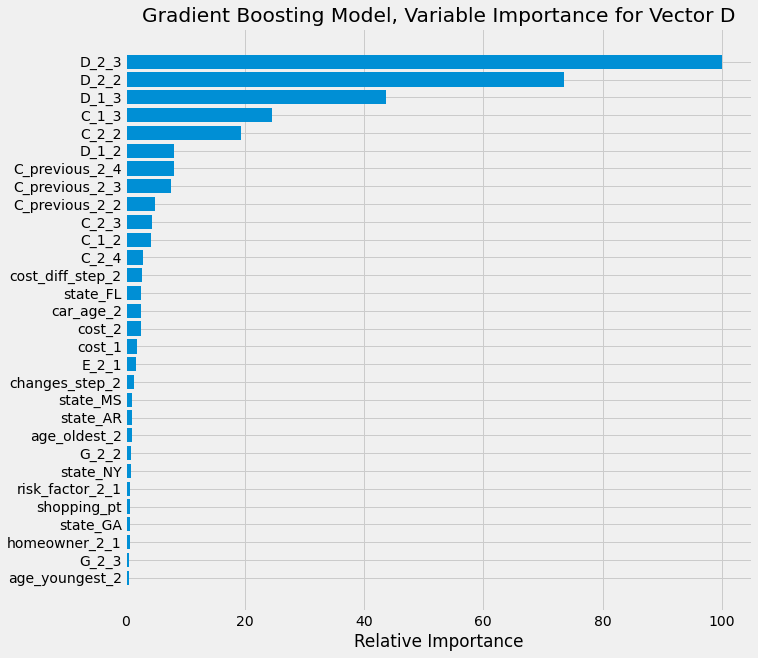

In [50]:
# model D with GradientBoosting classifier
from sklearn.ensemble import GradientBoostingClassifier

vector = 'D'

#param_grid
n_estimators = 200
max_features = 8
max_depth = 3 
learning_rate = 0.5

    
gb = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, \
                                max_features = max_features, random_state = 1)

gb.fit(X_train.to_numpy(), y_train[vector].astype('int'))

y_pred = gb.predict(X_test.to_numpy())
y_pred_prob = gb.predict_proba(X_test.to_numpy())
gb_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

print(f"Gradient Boosting Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  learning_rate = {learning_rate}, max_depth = {max_depth}, max_features = {max_features}\n")
print('Accuracy=%.3f' % (ac))

print('f1-score=%.3f' % (f1))

print("Confusion Matrix - Normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)

print("\nClassification Report \n", cr)

feature_importance = gb.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Model, Variable Importance for Vector '+vector)
plt.show()

In [81]:
y_train['D'].value_counts()

3    40134
2    13910
1     8041
Name: D, dtype: int64

In [82]:
mapping_D = {1:0, 2:1, 3:2}

y_train['D'] = y_train['D'].map(lambda x: mapping_D[x] )
y_test['D'] = y_test['D'].map(lambda x: mapping_D[x] )
y_train['D'].value_counts()

C:\Users\amite\AppData\Local\Temp/ipykernel_33952/2042145492.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['D'] = y_train['D'].map(lambda x: mapping_D[x] )
C:\Users\amite\AppData\Local\Temp/ipykernel_33952/2042145492.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['D'] = y_test['D'].map(lambda x: mapping_D[x] )


2    40134
1    13910
0     8041
Name: D, dtype: int64

In [83]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector D

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'D'

param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)

clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = 60, verbose = 3, cv=4)

clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))


Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=200;, score=0.871 total time=  11.6s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=200;, score=0.867 total time=  12.1s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=200;, score=0.865 total time=  12.1s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=200;, score=0.864 total time=  11.9s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.869 total time=   3.1s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.867 total time=   3.1s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.864 total time=   3.1s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.865 total time=  

[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.866 total time=  12.2s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.865 total time=  12.2s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.865 total time=  12.6s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.871 total time=   9.5s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.866 total time=   9.5s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.865 total time=   9.5s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.866 total time=   9.5s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.870 total time=   3.8s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.5, max_d

[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.866 total time=   6.5s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=4, n_estimators=100;, score=0.869 total time=   3.1s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=4, n_estimators=100;, score=0.866 total time=   3.1s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=4, n_estimators=100;, score=0.863 total time=   3.2s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=4, n_estimators=100;, score=0.864 total time=   3.2s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, n_estimators=200;, score=0.869 total time=   9.6s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, n_estimators=200;, score=0.866 total time=   9.5s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, n_estimators=200;, score=0.865 total time=   9.7s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.5, 

[CV 2/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, n_estimators=300;, score=0.866 total time=  14.1s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, n_estimators=300;, score=0.864 total time=  14.0s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=3, n_estimators=300;, score=0.864 total time=  14.1s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.867 total time=   9.0s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.865 total time=   9.0s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.862 total time=   9.0s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.863 total time=   9.0s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.871 total time=   7.7s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.3, max_

In [84]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']

save_file(results, 'xgboost_results_vectorD.csv', datapath)

Writing file.  "Modelling_data\xgboost_results_vectorD.csv"


In [85]:
import xgboost as xgb

vector = 'D'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='multi:softprob', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results.loc[i, 'test_score'] = ac
    results.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")

    print(f'Accuracy={ac:4.4}, f1_score={f1:4.4}')

results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data"
save_file(results,"xgboost_results_vectorD_2.csv",datapath)

XGBoost Classifier results for Vector D

Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.35, colsample_bytree = 0.5
Accuracy=0.8639, f1_score=0.8643
Parameters: No. of Estimators = 100.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.15
Accuracy=0.8646, f1_score=0.8652
Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.35, colsample_bytree = 0.35
Accuracy=0.8643, f1_score=0.8646
Parameters: No. of Estimators = 200.0,  max_depth = 5.0,     learning_rate = 0.5, colsample_bytree = 0.5
Accuracy=0.8603, f1_score=0.8605
Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8639, f1_score=0.8644
Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.15
Accuracy=0.8646, f1_score=0.8651
Parameters: No. of Estimators = 300.0,  max_depth = 5.0,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.8629, f

Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.8638, f1_score=0.864
Writing file.  "Modelling_data\xgboost_results_vectorD_2.csv"


In [86]:
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            200          4           0.35              0.50     0.866731   
1            100          4           0.50              0.15     0.866312   
2            300          4           0.35              0.35     0.865362   
3            200          5           0.50              0.50     0.862414   
4            300          5           0.30              0.15     0.866119   
5            300          4           0.25              0.15     0.867488   
6            300          5           0.25              0.50     0.865298   
7            400          3           0.50              0.15     0.866602   
8            200          5           0.25              0.35     0.867134   
9            100          4           0.30              0.35     0.867375   
10           100          5           0.25              0.25     0.867359   
11           100          3           0.30              0.25     0.866989   
12           400          3           0.30              0.25     0.866957   
13           500          3           0.25              0.25     0.867424   
14           400          4           0.35              0.35     0.864218   
15           300          5           0.30              0.50     0.864347   
16           500          5           0.35              0.35     0.861400   
17           200          4           0.25              0.50     0.867085   
18           200          3           0.30              0.50     0.866876   
19           100          3           0.50              0.35     0.867102   
20           400          5           0.50              0.25     0.859837   
21           300          3           0.50              0.35     0.865732   
22           500          4           0.35              0.15     0.864573   
23           400          5           0.30              0.50     0.863429   
24           100          4           0.30              0.15     0.865845   
25           100          5           0.35              0.25     0.866940   
26           400          4           0.25              0.50     0.865829   
27           100          4           0.30              0.50     0.867359   
28           500          4           0.50              0.35     0.859918   
29           300          5           0.30              0.35     0.865072   
30           100          4           0.50              0.35     0.866667   
31           200          5           0.50              0.15     0.865169   
32           400          4           0.25              0.15     0.867569   
33           200          5           0.30              0.15     0.866908   
34           100          5           0.35              0.35     0.867166   
35           100          4           0.25              0.15     0.865442   
36           200          3           0.50              0.50     0.866328   
37           200          5           0.50              0.35     0.862269   
38           400          5           0.30              0.15     0.865620   
39           200          3           0.35              0.15     0.867504   
40           100          5           0.25              0.50     0.867907   
41           100          3           0.30              0.50     0.866747   
42           200          4           0.50              0.15     0.865732   
43           500          3           0.25              0.15     0.867649   
44           300          4           0.50              0.35     0.862881   
45           500          3           0.50              0.50     0.863574   
46           200          4           0.50              0.25     0.865201   
47           100          5           0.30              0.35     0.867295   
48           200          3           0.25              0.50     0.867408   
49           100          3           0.50              0.15     0.866731   
50           200          4           0.50              0.50     0.864412   


XGBoost Classifier results for Vector D

Parameters: No. of Estimators = 500,  max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.25

Accuracy=0.8648
f1-score=0.8653
Confusion Matrix - normalized
 [[0.802 0.071 0.127]
 [0.088 0.76  0.152]
 [0.029 0.057 0.913]]
Confusion Matrix
 [[1617  143  256]
 [ 302 2604  522]
 [ 297  578 9203]]

Classification Report 
               precision    recall  f1-score   support

           0       0.73      0.80      0.76      2016
           1       0.78      0.76      0.77      3428
           2       0.92      0.91      0.92     10078

    accuracy                           0.86     15522
   macro avg       0.81      0.82      0.82     15522
weighted avg       0.87      0.86      0.87     15522

30


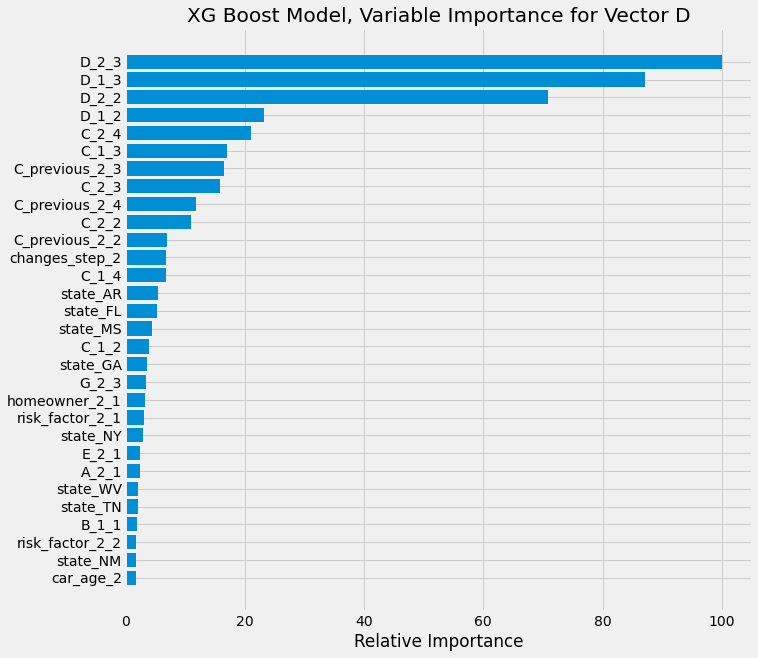

In [92]:
# model D with XGBoost classifier Best Parameters: (Overall 1st rank model)
#  No. of Estimators = 500,  max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.25 : 0.7601, 0.7592


import xgboost as xgb

vector = 'D'

#param_grid
n_estimators = 500
max_depth = 3
learning_rate = 0.25
colsample_bytree = 0.25
        
clf = xgb.XGBClassifier(max_depth=max_depth, objective='multi:softproba', n_estimators=n_estimators, \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs = -1, random_state = 1)

clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = clf.predict(X_test.to_numpy())
y_pred_prob = clf.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)


print(f"XGBoost Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}\n")

print('Accuracy=%.4f' % (ac))

print('f1-score=%.4f' % (f1))

print("Confusion Matrix - normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('XG Boost Model, Variable Importance for Vector '+vector)
plt.show()

Random Forest Classifier results for Vector F, min_samples_leaf = 1

Accuracy=0.832
f1-score=0.831
Confusion Matrix
 [[4464  169  332   36]
 [ 156 2979  624   43]
 [ 272  417 5021  130]
 [  50   76  297  456]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      5001
           1       0.82      0.78      0.80      3802
           2       0.80      0.86      0.83      5840
           3       0.69      0.52      0.59       879

    accuracy                           0.83     15522
   macro avg       0.80      0.76      0.78     15522
weighted avg       0.83      0.83      0.83     15522

30


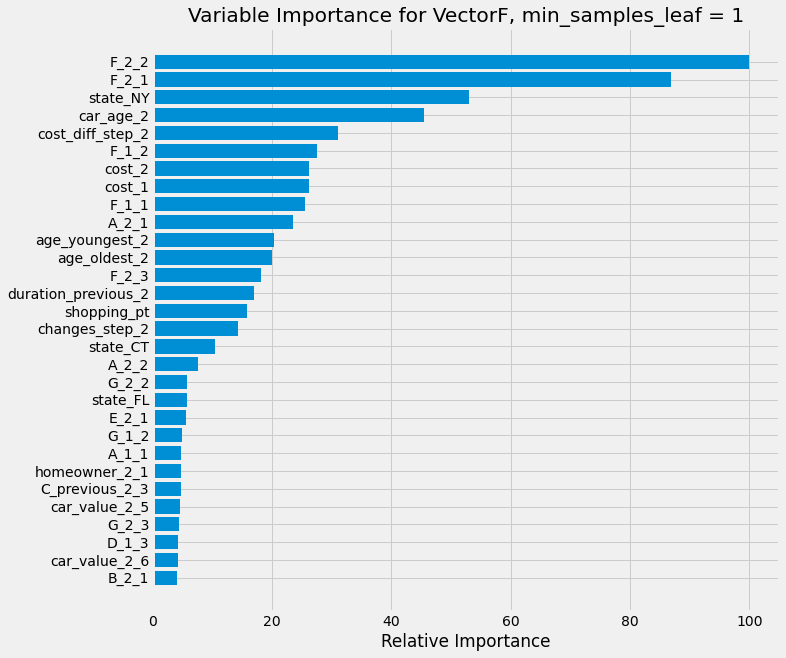

Random Forest Classifier results for Vector F, min_samples_leaf = 2

Accuracy=0.832
f1-score=0.831
Confusion Matrix
 [[4459  166  340   36]
 [ 149 2980  631   42]
 [ 265  418 5021  136]
 [  53   74  294  458]]

Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      5001
           1       0.82      0.78      0.80      3802
           2       0.80      0.86      0.83      5840
           3       0.68      0.52      0.59       879

    accuracy                           0.83     15522
   macro avg       0.80      0.76      0.78     15522
weighted avg       0.83      0.83      0.83     15522

30


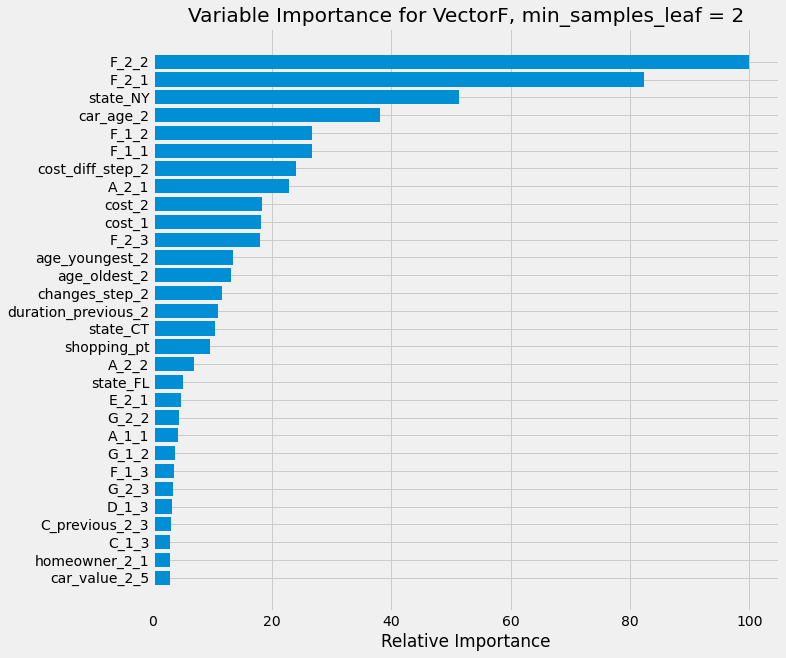

In [57]:
# Let's run the model for vector F


plt.style.use("fivethirtyeight")

vector = 'F'

for min_leaf in range(1,3):
    
    clf = RandomForestClassifier(n_estimators=300,  min_samples_leaf=min_leaf, random_state = 1,n_jobs=-1)
    model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Random Forest Classifier results for Vector {vector}, min_samples_leaf = {min_leaf}\n")
    print('Accuracy=%.3f' % (ac))

    print('f1-score=%.3f' % (f1))

    print("Confusion Matrix\n", cm)

    cr = classification_report(y_test[vector].astype('int'), y_pred)

    print("\nClassification Report \n", cr)

    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[64:]

    pos = np.arange(sorted_idx.shape[0]) + .5
    print(pos.size)
    sorted_idx.size
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance for Vector'+vector+', min_samples_leaf = %d'%min_leaf)
    plt.show()

In [48]:
vector = 'F'

df_train_first2 = pd.read_csv('WIP_data/training_data_with_first2_quotes.csv')
test_set = df_train_first2.iloc[y_test.index,:]

x = pd.crosstab(test_set['F'], test_set['F_2'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_2 : {(np.sum(same_as_2)/y_test.shape[0]): 4.4}")


Accuracy based on simply predicting vector F = F_2 :  0.8171


In [49]:

x['total'] = x.sum(axis=1)
x['F0_%'] = np.around(x[0]*100 / x['total'], 2)
x['F1_%'] = np.around(x[1]*100 / x['total'], 2)
x['F2_%'] = np.around(x[2]*100 / x['total'], 2)
x['F3_%'] = np.around(x[3]*100 / x['total'], 2)
x

F_2     0     1     2    3  total   F0_%   F1_%   F2_%   F3_%
F                                                            
0    4436   182   345   38   5001  88.70   3.64   6.90   0.76
1     250  2973   533   46   3802   6.58  78.20  14.02   1.21
2     477   410  4809  144   5840   8.17   7.02  82.35   2.47
3      93    72   249  465    879  10.58   8.19  28.33  52.90

XGBoost Classifier results for Vector F

Parameters: No. of Estimators = 200,  max_depth = 4, learning_rate = 0.25, colsample_bytree = 0.25

Accuracy=0.8333
f1-score=0.8316
Confusion Matrix - normalized
 [[0.9   0.03  0.064 0.006]
 [0.041 0.786 0.163 0.011]
 [0.047 0.074 0.855 0.024]
 [0.05  0.089 0.345 0.516]]
Confusion Matrix
 [[4500  151  320   30]
 [ 155 2987  619   41]
 [ 276  430 4993  141]
 [  44   78  303  454]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      5001
           1       0.82      0.79      0.80      3802
           2       0.80      0.85      0.83      5840
           3       0.68      0.52      0.59       879

    accuracy                           0.83     15522
   macro avg       0.80      0.76      0.78     15522
weighted avg       0.83      0.83      0.83     15522

30


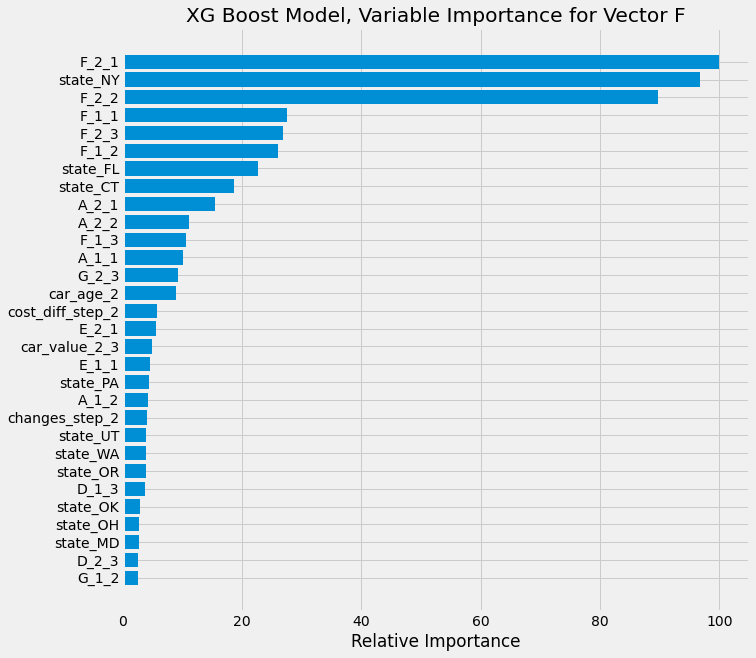

In [46]:
# model F with XGBoost classifier (BEST MODEL) n_estimators = 200, max_depth = 4, learning_rate = 0.25, 
# colsample_bytree = 0.25

plt.style.use('fivethirtyeight')
import xgboost as xgb

vector = 'F'

#param_grid
n_estimators = 200
max_depth = 4
learning_rate = 0.25
colsample_bytree = 0.25
        
clf = xgb.XGBClassifier(max_depth=max_depth, objective='multi:softproba', n_estimators=n_estimators, \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
y_pred = clf.predict(X_test.to_numpy())
y_pred_prob = clf.predict_proba(X_test.to_numpy())
rf_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test[vector].astype('int'), y_pred)

f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)


print(f"XGBoost Classifier results for Vector {vector}\n")
print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}\n")

print('Accuracy=%.4f' % (ac))

print('f1-score=%.4f' % (f1))

print("Confusion Matrix - normalized\n", cm)
print("Confusion Matrix\n", cm1)

cr = classification_report(y_test[vector].astype('int'), y_pred)
 
print("\nClassification Report \n", cr)

feature_importance = clf.feature_importances_
    # make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[64:]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('XG Boost Model, Variable Importance for Vector '+vector)
plt.show()

In [28]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector F

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'F'

param_grid = {'learning_rate' : [0.25, 0.3, 0.35], 'n_estimators' : [200], \
              'colsample_bytree': [0.25,0.35,0.5], 'max_depth' : [4]}

clf = xgb.XGBClassifier(objective='multi:softprob', random_state=1, n_jobs=-1)

clf_cv = GridSearchCV(clf, param_grid, verbose = 3, cv=4)

clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.834 total time=  15.9s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.834 total time=  17.0s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.822 total time=  16.7s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.827 total time=  16.7s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.835 total time=  16.8s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.833 total time=  16.3s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.821 total time=  16.0s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.826 total time=

In [29]:
results_2 = pd.DataFrame(clf_cv.cv_results_['params'])
results_2['train_score'] = clf_cv.cv_results_['mean_test_score']
results_2['train_rank'] = clf_cv.cv_results_['rank_test_score']
datapath="Modelling_data"
save_file(results_2,"xgboost_results_vectorF_2pass.csv",datapath)


Writing file.  "Modelling_data\xgboost_results_vectorF_2pass.csv"


In [31]:
import xgboost as xgb

vector = 'F'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results_2.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='multi:softprob', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results_2.loc[i, 'test_score'] = ac
    results_2.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")

    print(f'Accuracy={ac:4.4}, f1_score={f1:4.4}')

results_2['test_rank']= results_2['test_score'].rank(method='dense', ascending=False)
results_2['tr_te_avg_score'] = (results_2['test_score']+results['train_score'])/2
results_2['overall_rank']= results_2['tr_te_avg_score'].rank(method='dense', ascending=False)


XGBoost Classifier results for Vector F

Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.8333, f1_score=0.8316
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.8339, f1_score=0.8321
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.35, colsample_bytree = 0.25
Accuracy=0.8332, f1_score=0.8314
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.8328, f1_score=0.831
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.833, f1_score=0.8312
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.35, colsample_bytree = 0.35
Accuracy=0.8328, f1_score=0.831
Parameters: No. of Estimators = 200.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.8331, f

In [36]:
results_2['tr_te_avg_score'] = (results_2['test_score']+results_2['train_score'])/2
results_2['overall_rank']= results_2['tr_te_avg_score'].rank(method='dense', ascending=False)

results_2

colsample_bytree  learning_rate  max_depth  n_estimators  train_score  \
0              0.25           0.25          4           200     0.829427   
1              0.25           0.30          4           200     0.828831   
3              0.35           0.25          4           200     0.829798   
4              0.35           0.30          4           200     0.828880   
5              0.35           0.35          4           200     0.828509   
6              0.50           0.25          4           200     0.828944   
7              0.50           0.30          4           200     0.827994   
8              0.50           0.35          4           200     0.828171   

   train_rank  test_score  f1_score  test_rank  tr_te_avg_score  overall_rank  
0           2    0.833269  0.831565        2.0         0.831348           2.0  
1           5    0.833913  0.832136        1.0         0.831372           1.0  
3           1    0.832754  0.831008        7.0         0.831276           3.0  
4           4    0.833011  0.831194        5.0         0.830945           5.0  
5           7    0.832818  0.831020        6.0         0.830664           6.0  
6           3    0.833076  0.831424        4.0         0.831010           4.0  
7           9    0.831272  0.829523        9.0         0.829633           8.0  
8           8    0.832303  0.830512        8.0         0.830237           7.0

In [33]:
datapath="Modelling_data"
save_file(results_2,"xgboost_results_vectorF_2pass.csv",datapath)


A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "Modelling_data\xgboost_results_vectorF_2pass.csv"


In [8]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector F

import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

vector = 'F'

param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

clf = xgb.XGBClassifier(objective='multi:softprob', random_state=1, n_jobs=-1)

clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = 60, verbose = 3, cv=4)

clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
print("\nBest Parameters: " + str(clf_cv.best_params_))

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.835 total time=   9.9s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.833 total time=   9.9s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.823 total time=  11.3s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.827 total time=  12.6s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=200;, score=0.830 total time=  16.1s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=200;, score=0.826 total time=  14.6s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=200;, score=0.818 total time=  14.9s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=200;, score=0.823 total time=  

[CV 2/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=500;, score=0.830 total time=  30.7s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=500;, score=0.819 total time=  30.4s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=500;, score=0.824 total time=  30.1s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=100;, score=0.834 total time=   6.1s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=100;, score=0.832 total time=   6.2s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=100;, score=0.822 total time=   6.4s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=100;, score=0.826 total time=   6.4s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=300;, score=0.833 total time=  14.0s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.

[CV 4/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=4, n_estimators=100;, score=0.827 total time=   6.0s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=5, n_estimators=500;, score=0.824 total time=  31.1s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=5, n_estimators=500;, score=0.823 total time=  30.1s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=5, n_estimators=500;, score=0.813 total time=  30.0s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=5, n_estimators=500;, score=0.815 total time=  29.8s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.835 total time=  10.1s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.833 total time=   9.9s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.823 total time=   9.7s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, 

[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=400;, score=0.829 total time=  29.3s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=400;, score=0.818 total time=  29.3s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=400;, score=0.823 total time=  30.1s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.834 total time=  15.4s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.833 total time=  15.5s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.823 total time=  15.4s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.826 total time=  15.6s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.836 total time=   9.2s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.3

In [10]:
results = pd.DataFrame(clf_cv.cv_results_['params'])
results['train_score'] = clf_cv.cv_results_['mean_test_score']
results['train_rank'] = clf_cv.cv_results_['rank_test_score']
datapath="Modelling_data"
save_file(results,"xgboost_results_vectorF.csv",datapath)


Writing file.  "Modelling_data\xgboost_results_vectorF.csv"


In [12]:
import xgboost as xgb

vector = 'F'

print(f"XGBoost Classifier results for Vector {vector}\n")
#param_grid
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
        
    clf = xgb.XGBClassifier(max_depth=int(max_depth), objective='multi:softprob', n_estimators=int(n_estimators), \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),3)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    results.loc[i, 'test_score'] = ac
    results.loc[i, 'f1_score'] = f1
    
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")

    print(f'Accuracy={ac:4.4}, f1_score={f1:4.4}')

results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)


XGBoost Classifier results for Vector F

Parameters: No. of Estimators = 200.0,  max_depth = 3.0,     learning_rate = 0.35, colsample_bytree = 0.5
Accuracy=0.8315, f1_score=0.8299
Parameters: No. of Estimators = 200.0,  max_depth = 5.0,     learning_rate = 0.5, colsample_bytree = 0.35
Accuracy=0.8281, f1_score=0.826
Parameters: No. of Estimators = 400.0,  max_depth = 4.0,     learning_rate = 0.25, colsample_bytree = 0.15
Accuracy=0.8324, f1_score=0.8306
Parameters: No. of Estimators = 400.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8319, f1_score=0.83
Parameters: No. of Estimators = 500.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8319, f1_score=0.8301
Parameters: No. of Estimators = 500.0,  max_depth = 4.0,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.8304, f1_score=0.8284
Parameters: No. of Estimators = 200.0,  max_depth = 5.0,     learning_rate = 0.5, colsample_bytree = 0.25
Accuracy=0.8292, f1_s

Parameters: No. of Estimators = 300.0,  max_depth = 4.0,     learning_rate = 0.5, colsample_bytree = 0.5
Accuracy=0.8282, f1_score=0.8264


In [40]:
results_3['train_rank']= results_3['train_score'].rank(method='dense', ascending=False)
results_3['test_rank']= results_3['test_score'].rank(method='dense', ascending=False)
results_3['overall_rank']= results_3['tr_te_avg_score'].rank(method='dense', ascending=False)



n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            200          3           0.35              0.50     0.829250   
1            200          5           0.50              0.35     0.824370   
2            400          4           0.25              0.15     0.828413   
3            400          4           0.30              0.15     0.828284   
4            500          4           0.30              0.15     0.827752   
..           ...        ...            ...               ...          ...   
62           200          4           0.25              0.35     0.829798   
63           200          4           0.30              0.35     0.828880   
64           200          4           0.35              0.35     0.828509   
65           200          4           0.30              0.50     0.827994   
66           200          4           0.35              0.50     0.828171   

    train_rank  test_score  f1_score  test_rank  tr_te_avg_score  overall_rank  
0         10.0    0.831529  0.829926       23.0         0.830390          24.0  
1         59.0    0.828051  0.826017       42.0         0.826210          63.0  
2         26.0    0.832367  0.830643       12.0         0.830390          25.0  
3         29.0    0.831852  0.830035       19.0         0.830068          33.0  
4         40.0    0.831916  0.830125       18.0         0.829834          36.0  
..         ...         ...       ...        ...              ...           ...  
62         2.0    0.832754  0.831008        9.0         0.831276           4.0  
63        15.0    0.833011  0.831194        7.0         0.830945           9.0  
64        22.0    0.832818  0.831020        8.0         0.830664          18.0  
65        35.0    0.831272  0.829523       26.0         0.829633          41.0  
66        32.0    0.832303  0.830512       13.0         0.830237          29.0  

[67 rows x 11 columns]

In [43]:
results_3.head(37)

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            200          3           0.35              0.50     0.829250   
1            200          5           0.50              0.35     0.824370   
2            400          4           0.25              0.15     0.828413   
3            400          4           0.30              0.15     0.828284   
4            500          4           0.30              0.15     0.827752   
5            500          4           0.30              0.25     0.826496   
6            200          5           0.50              0.25     0.824338   
7            300          3           0.35              0.50     0.827849   
8            500          4           0.35              0.35     0.825256   
9            400          3           0.50              0.25     0.826802   
10           400          3           0.25              0.35     0.829009   
11           100          5           0.35              0.35     0.828960   
12           400          5           0.25              0.15     0.827253   
13           100          5           0.30              0.15     0.827801   
14           200          3           0.35              0.35     0.829250   
15           200          5           0.30              0.25     0.828413   
16           300          4           0.35              0.35     0.827414   
17           500          5           0.25              0.25     0.826206   
18           100          3           0.25              0.50     0.828799   
19           300          3           0.35              0.35     0.828477   
20           400          4           0.35              0.15     0.827446   
21           300          4           0.25              0.25     0.828783   
22           400          5           0.25              0.25     0.827430   
23           500          4           0.50              0.15     0.822856   
24           100          3           0.35              0.35     0.829379   
25           400          3           0.25              0.15     0.829105   
26           200          3           0.30              0.25     0.829637   
27           400          5           0.35              0.15     0.824708   
28           400          3           0.50              0.35     0.826593   
29           200          5           0.30              0.35     0.828090   
30           100          4           0.35              0.15     0.828300   
31           300          3           0.50              0.25     0.827398   
32           500          5           0.35              0.50     0.821728   
33           200          5           0.35              0.15     0.826657   
34           100          4           0.25              0.35     0.829878   
35           500          5           0.50              0.25     0.818748   
36           100          5           0.25              0.50     0.829540   

    train_rank  test_score  f1_score  test_rank  tr_te_avg_score  overall_rank  
0         10.0    0.831529  0.829926       23.0         0.830390          24.0  
1         59.0    0.828051  0.826017       42.0         0.826210          63.0  
2         26.0    0.832367  0.830643       12.0         0.830390          25.0  
3         29.0    0.831852  0.830035       19.0         0.830068          33.0  
4         40.0    0.831916  0.830125       18.0         0.829834          36.0  
5         51.0    0.830370  0.828421       32.0         0.828433          53.0  
6         60.0    0.829210  0.827193       38.0         0.826774          58.0  
7         37.0    0.833011  0.831337        7.0         0.830430          23.0  
8         54.0    0.830627  0.828753       30.0         0.827942          54.0  
9         48.0    0.830241  0.828487       33.0         0.828521          52.0  
10        12.0    0.832818  0.831086        8.0         0.830913          12.0  
11        13.0    0.831980  0.830154       17.0         0.830470          21.0  
12        46.0    0.8320

In [44]:
results_3.tail(30)

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
37           200          3           0.25              0.50     0.829411   
38           400          5           0.50              0.25     0.820375   
39           100          3           0.35              0.15     0.827494   
40           300          4           0.30              0.25     0.828058   
41           400          5           0.30              0.50     0.824321   
42           400          5           0.35              0.25     0.825240   
43           200          4           0.35              0.25     0.828783   
44           500          3           0.50              0.35     0.824756   
45           400          3           0.25              0.50     0.828203   
46           300          5           0.35              0.15     0.825932   
47           500          3           0.25              0.25     0.828284   
48           100          5           0.50              0.50     0.827897   
49           500          3           0.25              0.35     0.828751   
50           400          3           0.30              0.25     0.828493   
51           100          3           0.50              0.15     0.828219   
52           400          5           0.35              0.35     0.824466   
53           200          4           0.25              0.50     0.828944   
54           200          3           0.30              0.35     0.829733   
55           300          3           0.30              0.35     0.828622   
56           500          5           0.35              0.35     0.823500   
57           300          5           0.25              0.35     0.827784   
58           300          5           0.30              0.35     0.826882   
59           300          4           0.50              0.50     0.824273   
60           200          4           0.25              0.25     0.829427   
61           200          4           0.30              0.25     0.828831   
62           200          4           0.25              0.35     0.829798   
63           200          4           0.30              0.35     0.828880   
64           200          4           0.35              0.35     0.828509   
65           200          4           0.30              0.50     0.827994   
66           200          4           0.35              0.50     0.828171   

    train_rank  test_score  f1_score  test_rank  tr_te_avg_score  overall_rank  
37         7.0    0.830950  0.829389       28.0         0.830180          30.0  
38        66.0    0.824700  0.822643       45.0         0.822538          66.0  
39        41.0    0.830241  0.828556       33.0         0.828868          46.0  
40        34.0    0.832496  0.830677       11.0         0.830277          28.0  
41        61.0    0.828437  0.826536       40.0         0.826379          60.0  
42        55.0    0.829726  0.827664       36.0         0.827483          55.0  
43        19.0    0.833204  0.831365        4.0         0.830994           8.0  
44        56.0    0.829210  0.827321       38.0         0.826983          57.0  
45        31.0    0.831723  0.830079       20.0         0.829963          34.0  
46        53.0    0.831207  0.829235       27.0         0.828570          50.0  
47        28.0    0.831916  0.830248       18.0         0.830100          32.0  
48        36.0    0.833398  0.831543        2.0         0.830647          19.0  
49        20.0    0.832625  0.830828       10.0         0.830688          17.0  
50        23.0    0.833204  0.831569        4.0         0.830849          14.0  
51        30.0    0.831594  0.829952       22.0         0.829907          35.0  
52        58.0    0.828501  0.826501       39.0         0.826484          59.0  
53        14.0    0.833076  0.831424        6.0         0.831010           7.0  
54         3.0    0.832109  0.830430       15.0         0.830921          11.0  
55        21.0    0.832045  0.830354       16.0         0.830333          26.

In [ ]:
# Final slection is iteration 60: n_estimators = 200, max_depth = 2, learning_rate = 0.25, colsample_bytree = 0.25

In [45]:
datapath="Modelling_data"
save_file(results_3,"xgboost_results_vectorF_round3.csv",datapath)


Writing file.  "Modelling_data\xgboost_results_vectorF_round3.csv"


In [57]:

modelling_summary = pd.DataFrame({'vector' : ['A', 'B', 'C', 'D', 'E', 'F', 'G'], \
                                 'vector_options': [3,2,4,3,2,4,4], \
                                 'acc_if_final_equals_quote2' : [0.821,0.833,0.804,0.847,0.832,0.817,0.741],\
                                 'best_model_score': [0.848,0.835,0.832,0.862,0.842,0.834,0.758], \
                                 'best_model' : ['gb / xbg', 'rf', 'rf/gb', 'rf', 'gb', 'xgb', 'rf'], \
                                 'Improvement_%': [2.7,0.2,2.8,1.5,1.0,1.7,1.7], \
                                 'best_acc_score_random forest' : [0.846,0.835,0.832,0.862,0.84,0.832,0.758], \
                                 'best_acc_score_gradient boost' : [0.848,0.833,0.832,0.861,0.842,0,0.757], \
                                 'best_acc_score_XG Boost' : [0.848,0,0,0,0,0.834,0], \
                                 'best_acc_score_Logistic Regression' : [0,0.834,0,0,0.835,0,0], \
                                 'best_acc_score_KNN' : [0,0.793,0,0,0.809,0,0], \
                                                                   
                                 })


# Summary

Models were developed for each of the 7 vectors based on Quotes 1 and 2. The classifier used for modelling were:

1) Random Forest

2) Gradient Boost

3) XG Boost (for vector A and F only)

Additionally for the binary vectors Logistic Regression and KNN classifers were also used. 

After creating a base set of models, hyperparameters tuning was done using GridSearch CV, Randomized CV and Bayesian Optimization.
The model performance metrics used was primarily **accuracy_score** as our objective was to predict the correct vector selections across all possible vector classes. In addition for binary vectors, the **ROC_AUC** metrics was studied and thresholding was done to find the best threshold that improved model metrics.

The below table summarizes the model performances across all the vectors:



In [58]:
modelling_summary

vector  vector_options  acc_if_final_equals_quote2  best_model_score  \
0      A               3                       0.821             0.848   
1      B               2                       0.833             0.835   
2      C               4                       0.804             0.832   
3      D               3                       0.847             0.862   
4      E               2                       0.832             0.842   
5      F               4                       0.817             0.834   
6      G               4                       0.741             0.758   

  best_model  Improvement_%  best_acc_score_random forest  \
0   gb / xbg            2.7                         0.846   
1         rf            0.2                         0.835   
2      rf/gb            2.8                         0.832   
3         rf            1.5                         0.862   
4         gb            1.0                         0.840   
5        xgb            1.7                         0.832   
6         rf            1.7                         0.758   

   best_acc_score_gradient boost  best_acc_score_XG Boost  \
0                          0.848                    0.848   
1                          0.833                    0.000   
2                          0.832                    0.000   
3                          0.861                    0.000   
4                          0.842                    0.000   
5                          0.000                    0.834   
6                          0.757                    0.000   

   best_acc_score_Logistic Regression  best_acc_score_KNN  
0                               0.000               0.000  
1                               0.834               0.793  
2                               0.000               0.000  
3                               0.000               0.000  
4                               0.835               0.809  
5                               0.000               0.000  
6                               0.000               0.000

The improvement in prediction over base model (predict final choice = quote 2 choice) ranges from **0.2%** for vector B to **2.8%** for vector C. The average improvement is **1.66%**.


# Next Steps

1) Model all other vectors using XG Boost

2) Model final vector using quotes 2 and 3 (for customers who go beyond quote 3) and check predictive power over base model (final = quote 3).



# Predicting with Quotes 2 and 3

In [94]:
X2 = pd.read_csv("Transformed_data/pre_processed_training_data_with_quotes_2_3.csv")
y2 = pd.read_csv("Transformed_data/training_data_target_columns_quotes_2_3.csv")
X2.shape, y2.shape 

((73152, 94), (73152, 7))

In [95]:
X2.head()      

shopping_pt  car_age_3  age_oldest_3  age_youngest_3  duration_previous_3  \
0     1.054006  -0.897173     -0.000878        0.134046            -0.639141   
1     0.501449   0.826906     -1.207892       -1.069244             0.858809   
2     0.501449   2.033761     -0.058355       -1.355742            -0.639141   
3     0.501449  -0.207541     -0.690600       -0.610848            -0.639141   
4     1.606563   0.137274     -1.035461       -0.897345            -0.425148   

     cost_2    cost_3  changes_step_3  cost_diff_step_3  state_AR  ...  F_2_3  \
0  0.459097  0.443265       -0.531869         -0.072856         0  ...      0   
1 -1.622300 -1.564636       -0.531869          0.261214         0  ...      0   
2 -0.360847 -0.407910       -0.531869         -0.072856         0  ...      1   
3  0.858557  0.857941       -0.531869         -0.072856         0  ...      0   
4 -0.360847 -0.407910       -0.531869         -0.072856         0  ...      0   

   F_3_1  F_3_2  F_3_3  G_2_2  G_2_3  G_2_4  G_3_2  G_3_3  G_3_4  
0      0      1      0      0      0      0      0      0      0  
1      0      0      0      0      1      0      0      1      0  
2      0      0      1      0      1      0      0      1      0  
3      0      1      0      0      1      0      0      1      0  
4      1      0      0      0      1      0      0      1      0  

[5 rows x 94 columns]

In [96]:
y2.head()

A  B  C  D  E  F  G
0  1  1  3  3  0  2  1
1  0  0  1  3  0  0  3
2  1  1  2  3  0  2  3
3  1  1  2  2  1  2  3
4  1  1  1  3  1  1  3

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.2, random_state = 123, stratify = X2['shopping_pt'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((58521, 94), (14631, 94), (58521, 7), (14631, 7))

In [153]:
plt.style.use("fivethirtyeight")

def rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, min_samples_split = 2, plot = False):
    
    clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf = min_samples_leaf, \
                             min_samples_split = min_samples_split, random_state = 1,n_jobs=-1)

    model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    rf_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'), 4)
    cm1= confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Random Forest Classifier results for Vector {vector}")
    print(f"Parameters: No. of Estimators = {n_estimators},  min_samples_leaf = {min_samples_leaf}, \
    min_samples_split = {min_samples_split}")
    print(f'Accuracy={ac:4.4}, f1-score={f1:4.4}')
    
    if plot == True:
        print("Confusion Matrix - normalized\n", cm)
        print("Confusion Matrix\n", cm1)
    
        cr = classification_report(y_test[vector].astype('int'), y_pred)
        print("\nClassification Report \n", cr)
    
        feature_importance = clf.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)[X_train.shape[1] - 30:]
        pos = np.arange(sorted_idx.shape[0]) + .5
        print(pos.size)
        sorted_idx.size
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(10,10))
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, X_train.columns[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title('Random Forest Model, Variable Importance for Vector '+vector)
        plt.show()
    
    return ac, f1, rf_probs

def xg_predict_plot(vector, n_estimators=200, max_depth = 1, learning_rate = 0.3, colsample_bytree = 1, plot = False):
    
    clf = xgb.XGBClassifier(max_depth=max_depth, objective='binary:logistic', n_estimators=n_estimators, \
                       learning_rate = learning_rate, colsample_bytree = colsample_bytree, n_jobs=-1, random_state=1)

    clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = clf.predict(X_test.to_numpy())
    y_pred_prob = clf.predict_proba(X_test.to_numpy())
    xg_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),4)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"XGBoost Classifier results for Vector {vector}")
    print(f"Parameters: No. of Estimators = {n_estimators},  max_depth = {max_depth}, \
    learning_rate = {learning_rate}, colsample_bytree = {colsample_bytree}")
    print(f'Accuracy={ac:4.4}, f1-score={f1:4.4}')
    
    if plot == True:
        print("Confusion Matrix - normalized\n", cm)
        print("Confusion Matrix\n", cm1)

        cr = classification_report(y_test[vector].astype('int'), y_pred)
        print("\nClassification Report \n", cr)

        feature_importance = clf.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)[X_train.shape[1] - 30:]

        pos = np.arange(sorted_idx.shape[0]) + .5
        print(pos.size)
        sorted_idx.size
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(10,10))
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, X_train.columns[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title('XG Boost Model, Variable Importance for Vector '+vector)
        plt.show()
        
    return ac, f1, xg_probs
    

from sklearn.linear_model import LogisticRegression

def lr_predict_plot(vector):
    
    logreg = LogisticRegression()
    logreg.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = logreg.predict(X_test.to_numpy())
    y_pred_prob = logreg.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = np.around(confusion_matrix(y_test[vector].astype('int'), y_pred, normalize = 'true'),4)
    cm1 = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f'Logistic Regression for vector {vector}')
    print(f'Accuracy = {ac:4.4}, f1-score = {f1:4.4}\n')
    print("Confusion Matrix - normalized\n", cm)
    print("Confusion Matrix\n", cm1)

    cr = classification_report(y_test[vector].astype('int'), y_pred)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test[vector].astype('int'), lr_probs)
    roc_auc2 = auc(fpr_2, tpr_2)
    print("\nClassification Report \n", cr)
    print("\nArea under ROC: \n", roc_auc2)
    
    return ac, f1, lr_probs

from sklearn.model_selection import RandomizedSearchCV

def rf_randomsearch(vector, iterations = 10):

    param_grid = {'n_estimators' : np.arange(100,801,100), 'min_samples_split': np.arange(2,6), \
              'min_samples_leaf': np.arange(1,5)}

    rf = RandomForestClassifier(random_state = 1, n_jobs=-1)
    rf_cv = RandomizedSearchCV(rf, param_grid, n_iter = iterations, verbose = 3, cv=4)
    rf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

    print(f"Vector {vector} RandomizedSearchCV: Random Forest Model\nBest Score:" + str(rf_cv.best_score_))
    print("Best Parameters: " + str(rf_cv.best_params_))
    
    results = pd.DataFrame(rf_cv.cv_results_['params'])
    results['train_score'] = rf_cv.cv_results_['mean_test_score']
    results['train_rank'] = rf_cv.cv_results_['rank_test_score']
    
    return results

def xgb_randomsearch(vector, iterations = 10):
    
    param_grid = {'learning_rate' : [0.25, 0.3, 0.35, 0.5], 'n_estimators' : np.arange(100,501,100), \
              'colsample_bytree': [0.15,0.25,0.35,0.5], 'max_depth' : [3,4,5]}

    clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1, n_jobs=-1)
    clf_cv = RandomizedSearchCV(clf, param_grid, n_iter = iterations, verbose = 3, cv=4)
    clf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

    print(f"Vector {vector} RandomizedSearchCV: XG Boosting Model\nBest Score:" + str(clf_cv.best_score_))
    print("\nBest Parameters: " + str(clf_cv.best_params_))

    results = pd.DataFrame(clf_cv.cv_results_['params'])
    results['train_score'] = clf_cv.cv_results_['mean_test_score']
    results['train_rank'] = clf_cv.cv_results_['rank_test_score']

    return results


In [126]:
#df_hist_2_3 = pd.read_csv("WIP_data/training_data_with_quotes_2_3.csv")

test_set = df_hist_2_3.iloc[y_test.index,:]

x = pd.crosstab(test_set['A'], test_set['A_3'], )

same_as_3 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_3 : {(np.sum(same_as_3)/y_test.shape[0]): 4.4}")
x['total'] = x.sum(axis=1)
x['A0_%'] = np.around(x[0]*100 / x['total'], 2)
x['A1_%'] = np.around(x[1]*100 / x['total'], 2)
x['A2_%'] = np.around(x[2]*100 / x['total'], 2)
x

Accuracy based on simply predicting vector A = A_3 :  0.8788


A_3     0     1     2  total   A0_%   A1_%   A2_%
A                                                
0    2792   388    80   3260  85.64  11.90   2.45
1     297  8366   242   8905   3.34  93.95   2.72
2     106   660  1700   2466   4.30  26.76  68.94

In [185]:
vector = 'A'
last_quote = 3
test_set2 = df_hist_2_3.iloc[y_train.index,:]
x2 = pd.crosstab(test_set2[vector], test_set2[vector+'_'+str(last_quote)])
same_as_3 = [x2.iloc[idx,idx] for idx in range(x2.shape[0])] 
print(f"TRAINING Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_train.shape[0]): 4.4}")
print(f"Confusion_Matrix - TRAINING")
x2['total'] = x2.sum(axis=1)
x2['A0_%'] = np.around(x2[0]/ x2['total'], 4)
x2['A1_%'] = np.around(x2[1]/ x2['total'], 4)
x2['A2_%'] = np.around(x2[2]/ x2['total'], 4)
x2

TRAINING Accuracy based on simply predicting vector A = A_3 :  0.8802
Confusion_Matrix - TRAINING


A_3      0      1     2  total    A0_%    A1_%    A2_%
A                                                     
0    11006   1567   321  12894  0.8536  0.1215  0.0249
1     1212  33758   961  35931  0.0337  0.9395  0.0267
2      401   2547  6748   9696  0.0414  0.2627  0.6960

Random Forest Classifier results for Vector A, min_samples_leaf = 2

Accuracy=0.8825
f1-score=0.8799
Confusion Matrix - normalized
 [[0.8555 0.1202 0.0242]
 [0.0267 0.9461 0.0272]
 [0.0389 0.2725 0.6886]]
Confusion Matrix
 [[2789  392   79]
 [ 238 8425  242]
 [  96  672 1698]]

Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.86      0.87      3260
           1       0.89      0.95      0.92      8905
           2       0.84      0.69      0.76      2466

    accuracy                           0.88     14631
   macro avg       0.87      0.83      0.85     14631
weighted avg       0.88      0.88      0.88     14631

30


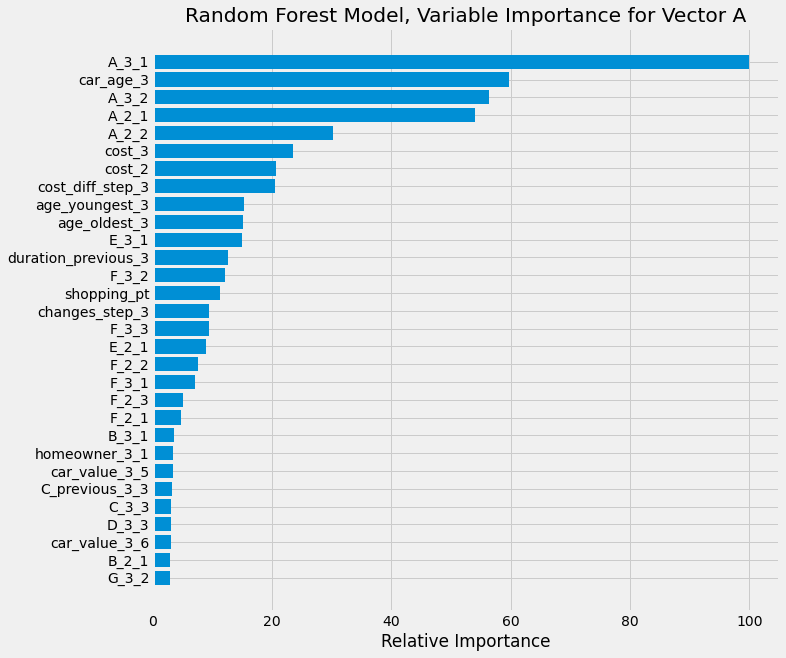

(0.8825097395940127, 0.879885431305879)

In [107]:
# Predict A using quotes 2 and 3

rf_ac, rf_f1, rf_probs = rf_predict_plot('A', n_estimators=300, min_samples_leaf = 1, min_samples_split = 2, plot=True)


In [102]:
# Now let's try a Randomized Search CV to find the best Random Forest classifier for vector A

from sklearn.model_selection import RandomizedSearchCV

vector = 'A'

param_grid = {'n_estimators' : np.arange(100,801,100), 'min_samples_split': np.arange(2,6), \
              'min_samples_leaf': np.arange(1,5)}

rf = RandomForestClassifier(random_state = 1, n_jobs=-1)

rf_cv = RandomizedSearchCV(rf, param_grid, n_iter = 60, verbose = 3, cv=4)

rf_cv.fit(X_train.to_numpy(), y_train[vector].astype('int'))

print("Random Forest Model\nBest Score:" + str(rf_cv.best_score_))
print("\nBest Parameters: " + str(rf_cv.best_params_)) 

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=0.881 total time=  12.9s
[CV 2/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=0.885 total time=  11.1s
[CV 3/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=0.878 total time=  10.0s
[CV 4/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=0.886 total time=  11.0s
[CV 1/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.882 total time=  18.3s
[CV 2/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.885 total time=  18.2s
[CV 3/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.879 total time=  18.4s
[CV 4/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.886 total time=  19.3s
[CV 1/4] END min_samples_leaf=2, min_samples_split=3, n_estimators=400;, score=0.882 total time=  14.2s
[C

[CV 4/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=500;, score=0.885 total time=  16.9s
[CV 1/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=0.882 total time=  26.1s
[CV 2/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=0.885 total time=  26.5s
[CV 3/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=0.879 total time=  27.1s
[CV 4/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=0.885 total time=  27.4s
[CV 1/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.882 total time=   7.7s
[CV 2/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.885 total time=   7.0s
[CV 3/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.879 total time=   7.0s
[CV 4/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.885 total time=   6.9s
[CV 1/4] END min_samples_leaf=1, min_samples_split=2, n_estimato

[CV 3/4] END min_samples_leaf=4, min_samples_split=3, n_estimators=700;, score=0.879 total time=  29.8s
[CV 4/4] END min_samples_leaf=4, min_samples_split=3, n_estimators=700;, score=0.886 total time=  27.8s
[CV 1/4] END min_samples_leaf=4, min_samples_split=3, n_estimators=200;, score=0.881 total time=   8.0s
[CV 2/4] END min_samples_leaf=4, min_samples_split=3, n_estimators=200;, score=0.885 total time=   9.1s
[CV 3/4] END min_samples_leaf=4, min_samples_split=3, n_estimators=200;, score=0.878 total time=   8.5s
[CV 4/4] END min_samples_leaf=4, min_samples_split=3, n_estimators=200;, score=0.885 total time=   7.9s
[CV 1/4] END min_samples_leaf=1, min_samples_split=4, n_estimators=700;, score=0.882 total time=  29.9s
[CV 2/4] END min_samples_leaf=1, min_samples_split=4, n_estimators=700;, score=0.885 total time=  29.8s
[CV 3/4] END min_samples_leaf=1, min_samples_split=4, n_estimators=700;, score=0.879 total time=  28.5s
[CV 4/4] END min_samples_leaf=1, min_samples_split=4, n_estimato

[CV 2/4] END min_samples_leaf=1, min_samples_split=3, n_estimators=200;, score=0.885 total time=   6.9s
[CV 3/4] END min_samples_leaf=1, min_samples_split=3, n_estimators=200;, score=0.879 total time=   6.9s
[CV 4/4] END min_samples_leaf=1, min_samples_split=3, n_estimators=200;, score=0.886 total time=   7.0s
Random Forest Model
Best Score:0.8834093921216074

Best Parameters: {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [104]:
results = pd.DataFrame(rf_cv.cv_results_['params'])
results['train_score'] = rf_cv.cv_results_['mean_test_score']
results['train_rank'] = rf_cv.cv_results_['rank_test_score']
datapath="Modelling_data/quotes_2_3"
save_file(results, 'rf_results_q2_q3_vectorA.csv', datapath)

Directory Modelling_data/quotes_2_3 was created.
Writing file.  "Modelling_data/quotes_2_3\rf_results_q2_q3_vectorA.csv"


In [113]:

vector = 'A'

for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    min_samples_leaf = row['min_samples_leaf']
    min_samples_split = row['min_samples_split']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], rf_probs = rf_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                min_samples_leaf = int(min_samples_leaf), \
                                                                min_samples_split = int(min_samples_split), plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
save_file(results, 'rf_results_q2_q3_vectorA_final.csv', datapath)


Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 300,  min_samples_leaf = 4,     min_samples_split = 5
Accuracy=0.8822, f1-score=0.8796
Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 500,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8827, f1-score=0.8801
Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 400,  min_samples_leaf = 2,     min_samples_split = 3
Accuracy=0.8821, f1-score=0.8795
Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 400,  min_samples_leaf = 3,     min_samples_split = 5
Accuracy=0.8825, f1-score=0.8799
Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 400,  min_samples_leaf = 4,     min_samples_split = 4
Accuracy=0.8822, f1-score=0.8796
Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 700,  min_samples_leaf = 3,     min_samples_split = 5
Accuracy=0.8824, f1-score=0.8798
Random For

Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 700,  min_samples_leaf = 2,     min_samples_split = 5
Accuracy=0.8824, f1-score=0.8798
Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 300,  min_samples_leaf = 3,     min_samples_split = 5
Accuracy=0.8824, f1-score=0.8798
Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 100,  min_samples_leaf = 3,     min_samples_split = 4
Accuracy=0.8824, f1-score=0.8798
Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 300,  min_samples_leaf = 3,     min_samples_split = 3
Accuracy=0.8824, f1-score=0.8798
Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 600,  min_samples_leaf = 4,     min_samples_split = 4
Accuracy=0.8821, f1-score=0.8795
Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 100,  min_samples_leaf = 4,     min_samples_split = 2
Accuracy=0.8824, f1-score=0.8798
Random For

In [115]:
results

n_estimators  min_samples_split  min_samples_leaf  train_score  \
0            300                  5                 4     0.882572   
1            500                  2                 1     0.883239   
2            400                  3                 2     0.882965   
3            400                  5                 3     0.882709   
4            400                  4                 4     0.882606   
5            700                  5                 3     0.882794   
6            100                  2                 3     0.882675   
7            500                  2                 3     0.882692   
8            300                  4                 2     0.883068   
9            800                  3                 4     0.882658   
10           400                  2                 4     0.882606   
11           600                  4                 3     0.882692   
12           100                  4                 2     0.882948   
13           200                  5                 2     0.882811   
14           600                  2                 2     0.882999   
15           500                  4                 2     0.883102   
16           600                  3                 1     0.883153   
17           300                  3                 2     0.883068   
18           300                  2                 4     0.882572   
19           500                  4                 3     0.882692   
20           800                  5                 4     0.882658   
21           200                  2                 2     0.882948   
22           300                  2                 1     0.882965   
23           400                  3                 4     0.882606   
24           200                  2                 3     0.882623   
25           100                  2                 1     0.882931   
26           800                  2                 3     0.882726   
27           500                  5                 2     0.883051   
28           700                  3                 3     0.882794   
29           500                  2                 4     0.882675   
30           500                  3                 3     0.882692   
31           700                  3                 2     0.883016   
32           500                  3                 4     0.882675   
33           700                  2                 1     0.883409   
34           400                  3                 1     0.883307   
35           200                  2                 4     0.882504   
36           100                  5                 1     0.883170   
37           600                  4                 1     0.883221   
38           200                  4                 2     0.882948   
39           700                  3                 4     0.882743   
40           200                  3                 4     0.882504   
41           700                  4                 1     0.883290   
42           400                  4                 3     0.882709   
43           600                  3                 3     0.882692   
44           100                  2                 2     0.882948   
45           700                  4                 2     0.883016   
46           200                  4                 3     0.882623   
47           800                  4                 1     0.883256   
48           700                  5                 1     0.883170   
49           400                  3                 3     0.882709   
50           700                  5                 2     0.882982   
51           300                  5                 3     0.882658   
52           100                  4                 3     0.882675   
53           300                  3                 3     0.882658   
54           600                  4                 4     0.882709   
55           100                  2                 4     0.882470   
56           1

Random Forest Classifier results for Vector A
Parameters: No. of Estimators = 400,  min_samples_leaf = 1,     min_samples_split = 3
Accuracy=0.8826, f1-score=0.88
Confusion Matrix - normalized
 [[0.8555 0.1206 0.0239]
 [0.0267 0.9461 0.0272]
 [0.0385 0.2721 0.6894]]
Confusion Matrix
 [[2789  393   78]
 [ 238 8425  242]
 [  95  671 1700]]

Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.86      0.87      3260
           1       0.89      0.95      0.92      8905
           2       0.84      0.69      0.76      2466

    accuracy                           0.88     14631
   macro avg       0.87      0.83      0.85     14631
weighted avg       0.88      0.88      0.88     14631

30


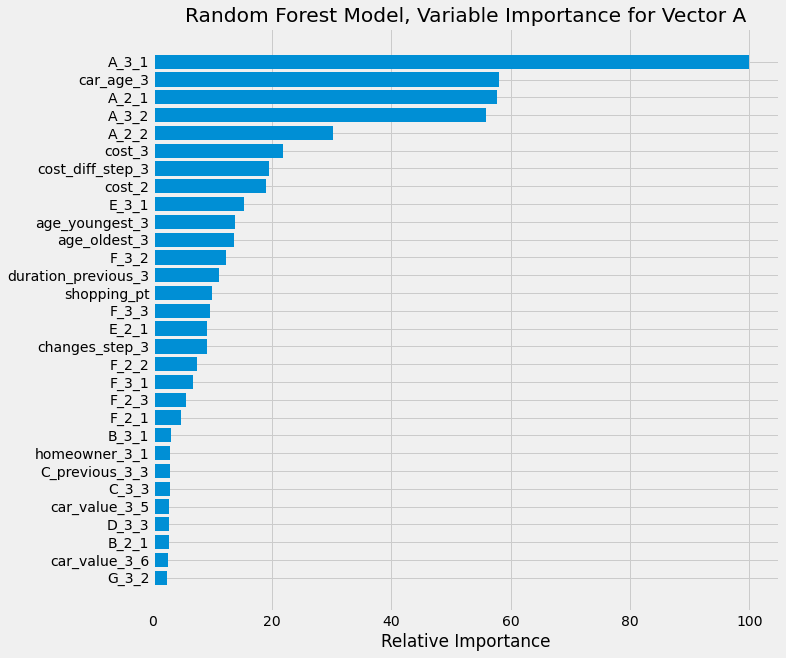

(0.8826464356503315, 0.8800377787479019)

In [116]:
# Vector A random forest Running the best model: overall rank = 1 (Iteration 34)
rf_ac, rf_f1, rf_probs = rf_predict_plot('A', n_estimators=400, min_samples_leaf = 1, min_samples_split = 3, plot=True)


XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 200,  max_depth = 1,     learning_rate = 0.3, colsample_bytree = 1
Accuracy=0.8824, f1-score=0.8798
Confusion Matrix - normalized
 [[0.855 0.121 0.024]
 [0.027 0.946 0.028]
 [0.036 0.274 0.69 ]]
Confusion Matrix
 [[2787  396   77]
 [ 236 8422  247]
 [  89  676 1701]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.85      0.87      3260
           1       0.89      0.95      0.92      8905
           2       0.84      0.69      0.76      2466

    accuracy                           0.88     14631
   macro avg       0.87      0.83      0.85     14631
weighted avg       0.88      0.88      0.88     14631

30


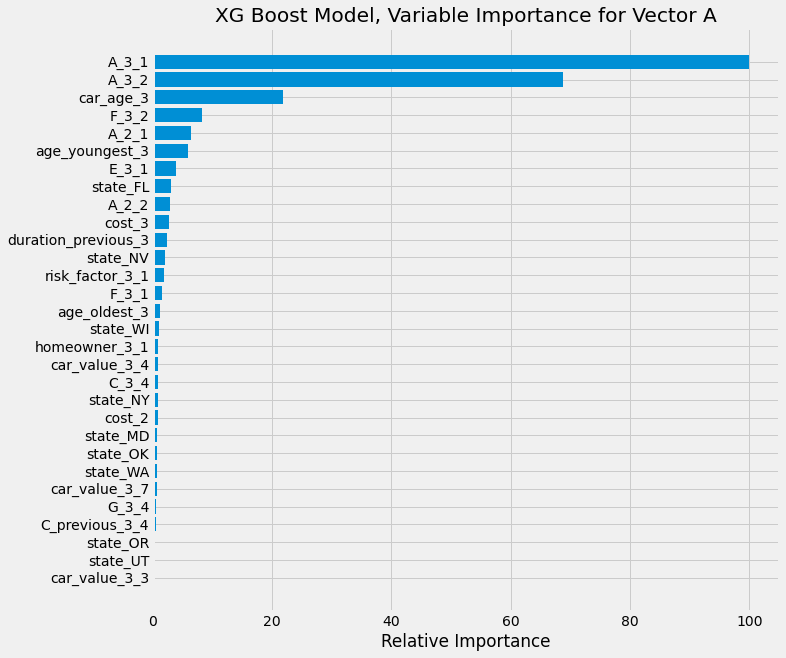

(0.882373043537694, 0.8797863746811294)

In [117]:
#Let's predict A using XG Boost Classifier

vector = 'A'
xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=200, max_depth = 1, learning_rate = 0.3, colsample_bytree = 1, plot = True)



In [119]:
# Let's use RandomizedSearchCV to find the best XGB classifier Hyperparamters for vector A

results = xgb_randomsearch("A", 60)

datapath="Modelling_data/quotes_2_3"
save_file(results, 'xgboost_results_q2_q3_vectorA.csv', datapath)


Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.879 total time=   3.7s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.885 total time=   3.6s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.878 total time=   4.4s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.885 total time=   5.1s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=5, n_estimators=200;, score=0.881 total time=   7.5s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=5, n_estimators=200;, score=0.886 total time=   7.2s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=5, n_estimators=200;, score=0.876 total time=   7.8s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=5, n_estimators=200;, score=0.885 total

[CV 2/4] END colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.881 total time=  26.6s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.873 total time=  24.1s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.884 total time=  23.6s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.880 total time=  20.3s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.882 total time=  19.5s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.875 total time=  18.7s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=500;, score=0.884 total time=  18.6s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=4, n_estimators=500;, score=0.879 total time=  19.9s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0

[CV 4/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.884 total time=   6.8s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=4, n_estimators=200;, score=0.880 total time=  10.4s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=4, n_estimators=200;, score=0.884 total time=   9.4s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=4, n_estimators=200;, score=0.876 total time=   9.2s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=4, n_estimators=200;, score=0.884 total time=   9.1s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.881 total time=   7.1s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.884 total time=   7.3s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.878 total time=   7.2s
[CV 4/4] END colsample_bytree=0.35, learning_rat

[CV 2/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.883 total time=  20.3s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.874 total time=  19.8s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.883 total time=  20.7s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=4, n_estimators=300;, score=0.880 total time=  12.5s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=4, n_estimators=300;, score=0.884 total time=  11.8s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=4, n_estimators=300;, score=0.875 total time=  11.7s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=4, n_estimators=300;, score=0.885 total time=  12.0s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.880 total time=  12.3s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.3,

In [123]:
vector = 'A'

for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], xg_probs = xg_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                max_depth = int(max_depth), learning_rate = learning_rate, \
                                                                colsample_bytree = colsample_bytree, plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
save_file(results, 'xgboost_results_q2_q3_vectorA_final.csv', datapath)


XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 100,  max_depth = 5,     learning_rate = 0.35, colsample_bytree = 0.25
Accuracy=0.8808, f1-score=0.8782
XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 200,  max_depth = 5,     learning_rate = 0.25, colsample_bytree = 0.15
Accuracy=0.8816, f1-score=0.879
XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 300,  max_depth = 3,     learning_rate = 0.5, colsample_bytree = 0.15
Accuracy=0.8813, f1-score=0.8787
XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 300,  max_depth = 4,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.8811, f1-score=0.8786
XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 100,  max_depth = 5,     learning_rate = 0.35, colsample_bytree = 0.5
Accuracy=0.8818, f1-score=0.8792
XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 200,  max_depth = 4,     learning_rate = 0.3, colsam

XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 300,  max_depth = 3,     learning_rate = 0.5, colsample_bytree = 0.25
Accuracy=0.8809, f1-score=0.8783
XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.8824, f1-score=0.8798
XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 500,  max_depth = 5,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.8803, f1-score=0.8777
XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 500,  max_depth = 5,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.879, f1-score=0.8764
XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 400,  max_depth = 4,     learning_rate = 0.5, colsample_bytree = 0.35
Accuracy=0.8777, f1-score=0.8751
XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 500,  max_depth = 4,     learning_rate = 0.3, colsamp

In [124]:
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            100          5           0.35              0.25     0.881666   
1            200          5           0.25              0.15     0.882042   
2            300          3           0.50              0.15     0.880573   
3            300          4           0.25              0.50     0.881068   
4            100          5           0.35              0.50     0.881427   
5            200          4           0.30              0.25     0.881820   
6            300          5           0.30              0.35     0.879889   
7            100          5           0.30              0.25     0.882162   
8            500          4           0.25              0.50     0.879872   
9            300          5           0.30              0.25     0.880573   
10           300          5           0.35              0.25     0.879821   
11           400          3           0.35              0.35     0.880590   
12           500          3           0.50              0.25     0.879069   
13           400          5           0.30              0.50     0.878505   
14           400          5           0.35              0.15     0.879155   
15           100          3           0.25              0.15     0.881820   
16           500          3           0.30              0.50     0.880265   
17           500          4           0.30              0.35     0.879018   
18           500          3           0.35              0.35     0.880077   
19           500          4           0.35              0.25     0.879052   
20           100          4           0.35              0.15     0.882196   
21           400          3           0.25              0.15     0.882128   
22           400          3           0.30              0.25     0.881632   
23           300          3           0.25              0.25     0.881957   
24           100          5           0.35              0.15     0.881752   
25           400          3           0.25              0.50     0.881461   
26           100          4           0.25              0.25     0.882367   
27           300          4           0.30              0.25     0.881137   
28           300          3           0.35              0.50     0.881017   
29           200          4           0.50              0.25     0.879941   
30           100          4           0.25              0.50     0.882982   
31           300          3           0.35              0.15     0.882008   
32           200          5           0.35              0.50     0.879975   
33           400          3           0.25              0.25     0.881769   
34           100          5           0.25              0.35     0.881752   
35           200          4           0.35              0.35     0.880744   
36           200          3           0.35              0.35     0.881991   
37           500          3           0.30              0.35     0.880607   
38           400          3           0.50              0.25     0.880094   
39           200          5           0.35              0.35     0.879565   
40           300          4           0.30              0.15     0.881376   
41           400          4           0.35              0.35     0.879462   
42           500          5           0.50              0.15     0.874934   
43           500          5           0.25              0.25     0.879770   
44           200          5           0.30              0.35     0.880624   
45           300          4           0.35              0.15     0.881051   
46           200          3           0.50              0.25     0.881085   
47           300          3           0.50              0.25     0.880624   
48           200          3           0.25              0.50     0.882435   
49           500          5           0.25              0.35     0.879428   
50           500          5           0.25              0.50     0.879052   


XGBoost Classifier results for Vector A
Parameters: No. of Estimators = 100,  max_depth = 4,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.8831, f1-score=0.8805
Confusion Matrix - normalized
 [[0.859 0.118 0.023]
 [0.027 0.946 0.027]
 [0.036 0.275 0.688]]
Confusion Matrix
 [[2799  386   75]
 [ 236 8425  244]
 [  90  679 1697]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      3260
           1       0.89      0.95      0.92      8905
           2       0.84      0.69      0.76      2466

    accuracy                           0.88     14631
   macro avg       0.88      0.83      0.85     14631
weighted avg       0.88      0.88      0.88     14631

30


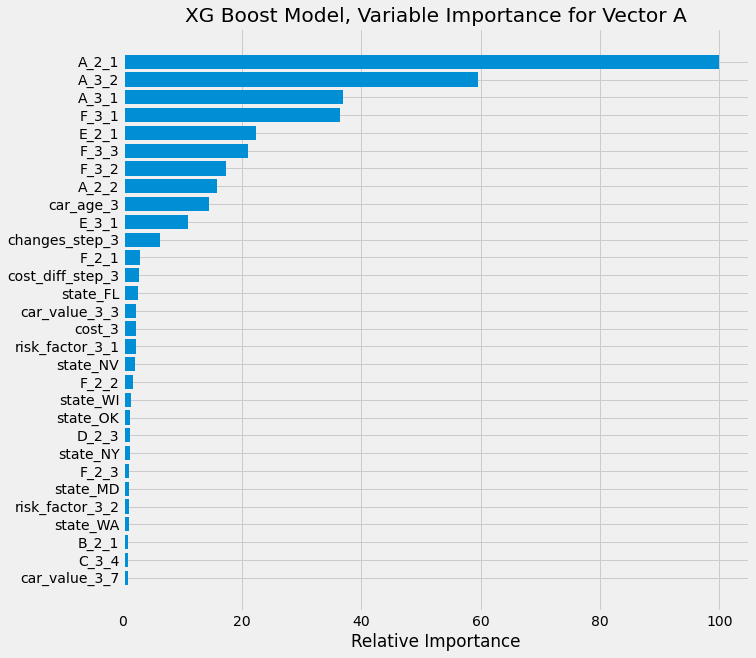

(0.8831248718474471, 0.8805022741812286)

In [125]:
#Let's plot the best model for A using XG Boost Classifier (Iteration 30)

xg_ac, xg_f1, xg_probs = xg_predict_plot('A', n_estimators=100, max_depth = 4, learning_rate = 0.25, colsample_bytree = 0.5, plot = True)


# Quote 2 & 3: Predict B

In [128]:
vector = 'B'
last_quote = 3

test_set = df_hist_2_3.iloc[y_test.index,:]

x = pd.crosstab(test_set[vector], test_set[vector+'_'+str(last_quote)])

same_as_3 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_test.shape[0]): 4.4}")
print(f"Confusion_Matrix")

x['total'] = x.sum(axis=1)
x['B0_%'] = np.around(x[0]/ x['total'], 4)
x['B1_%'] = np.around(x[1]/ x['total'], 4)
x


Accuracy based on simply predicting vector B = B_3 :  0.8842
Confusion_Matrix


B_3     0     1  total    B0_%    B1_%
B                                     
0    6960   686   7646  0.9103  0.0897
1    1008  5977   6985  0.1443  0.8557

In [186]:
vector = 'B'
last_quote = 3
test_set2 = df_hist_2_3.iloc[y_train.index,:]
x2 = pd.crosstab(test_set2[vector], test_set2[vector+'_'+str(last_quote)])
same_as_3 = [x2.iloc[idx,idx] for idx in range(x2.shape[0])] 
print(f"TRAINING Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_train.shape[0]): 4.4}")
print(f"Confusion_Matrix - TRAINING")
x2['total'] = x2.sum(axis=1)
x2['B0_%'] = np.around(x2[0]/ x2['total'], 4)
x2['B1_%'] = np.around(x2[1]/ x2['total'], 4)
x2

TRAINING Accuracy based on simply predicting vector B = B_3 :  0.8867
Confusion_Matrix - TRAINING


B_3      0      1  total    B0_%    B1_%
B                                       
0    27846   2760  30606  0.9098  0.0902
1     3868  24047  27915  0.1386  0.8614

Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8842, f1-score=0.884
Confusion Matrix - normalized
 [[0.91   0.09  ]
 [0.1442 0.8558]]
Confusion Matrix
 [[6958  688]
 [1007 5978]]

Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      7646
           1       0.90      0.86      0.88      6985

    accuracy                           0.88     14631
   macro avg       0.89      0.88      0.88     14631
weighted avg       0.88      0.88      0.88     14631

30


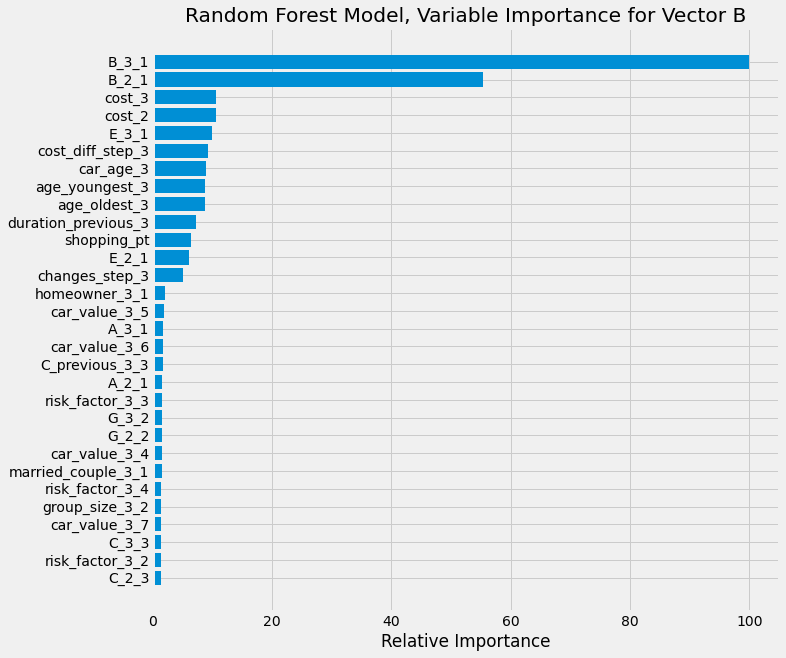

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=800;, score=0.883 total time=  41.7s
[CV 2/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=800;, score=0.890 total time=  27.2s
[CV 3/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=800;, score=0.886 total time=  27.5s
[CV 4/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=800;, score=0.888 total time=  26.7s
[CV 1/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=0.883 total time=  10.2s
[CV 2/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=0.890 total time=  10.2s
[CV 3/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=0.886 total time=  11.3s
[CV 4/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=0.888 total time=  13.2s
[CV 1/4] END min_samples_leaf=1, min_samples_split=4, n_estimators=800;, score=0.883 total time=  36.8s
[C

[CV 4/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=0.888 total time=  21.6s
[CV 1/4] END min_samples_leaf=3, min_samples_split=2, n_estimators=700;, score=0.883 total time=  23.7s
[CV 2/4] END min_samples_leaf=3, min_samples_split=2, n_estimators=700;, score=0.890 total time=  24.2s
[CV 3/4] END min_samples_leaf=3, min_samples_split=2, n_estimators=700;, score=0.886 total time=  23.3s
[CV 4/4] END min_samples_leaf=3, min_samples_split=2, n_estimators=700;, score=0.888 total time=  23.5s
[CV 1/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=0.883 total time=  27.7s
[CV 2/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=0.890 total time=  27.2s
[CV 3/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=0.886 total time=  26.9s
[CV 4/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=0.888 total time=  27.0s
[CV 1/4] END min_samples_leaf=2, min_samples_split=5, n_estimato

[CV 3/4] END min_samples_leaf=3, min_samples_split=3, n_estimators=600;, score=0.886 total time=  22.5s
[CV 4/4] END min_samples_leaf=3, min_samples_split=3, n_estimators=600;, score=0.888 total time=  23.5s
[CV 1/4] END min_samples_leaf=2, min_samples_split=3, n_estimators=700;, score=0.883 total time=  26.6s
[CV 2/4] END min_samples_leaf=2, min_samples_split=3, n_estimators=700;, score=0.890 total time=  27.6s
[CV 3/4] END min_samples_leaf=2, min_samples_split=3, n_estimators=700;, score=0.886 total time=  29.6s
[CV 4/4] END min_samples_leaf=2, min_samples_split=3, n_estimators=700;, score=0.888 total time=  26.9s
[CV 1/4] END min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.883 total time=   3.8s
[CV 2/4] END min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.890 total time=   3.8s
[CV 3/4] END min_samples_leaf=3, min_samples_split=3, n_estimators=100;, score=0.886 total time=   3.8s
[CV 4/4] END min_samples_leaf=3, min_samples_split=3, n_estimato

[CV 2/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=600;, score=0.890 total time=  22.0s
[CV 3/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=600;, score=0.886 total time=  22.4s
[CV 4/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=600;, score=0.888 total time=  23.0s
Vector B RandomizedSearchCV: Random Forest Model
Best Score:0.8867586639067705
Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1}
Writing file.  "Modelling_data/quotes_2_3\rf_results_q2_q3_vectorB.csv"


In [129]:
# RF Classifier Predict B using quotes 2 and 3 and then RandomizedSearchCV to find best hyperparameters

vector = 'B'

rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, min_samples_split = 2, plot=True)

results = rf_randomsearch(vector, 60)

datapath="Modelling_data/quotes_2_3"
filename1 = 'rf_results_q2_q3_vector'+vector+'.csv'
save_file(results, filename1, datapath)


In [131]:
vector = 'B'

for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    min_samples_leaf = row['min_samples_leaf']
    min_samples_split = row['min_samples_split']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], rf_probs = rf_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                min_samples_leaf = int(min_samples_leaf), \
                                                                min_samples_split = int(min_samples_split), plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
filename2 = 'rf_results_q2_q3_vector'+vector+'_final.csv'
save_file(results, filename2, datapath)


Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 800,  min_samples_leaf = 4,     min_samples_split = 4
Accuracy=0.8842, f1-score=0.884
Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 300,  min_samples_leaf = 3,     min_samples_split = 5
Accuracy=0.8842, f1-score=0.884
Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 800,  min_samples_leaf = 1,     min_samples_split = 4
Accuracy=0.884, f1-score=0.8838
Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 300,  min_samples_leaf = 4,     min_samples_split = 4
Accuracy=0.8842, f1-score=0.884
Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 700,  min_samples_leaf = 3,     min_samples_split = 5
Accuracy=0.8842, f1-score=0.884
Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 500,  min_samples_leaf = 4,     min_samples_split = 4
Accuracy=0.8842, f1-score=0.884
Random Forest Cl

Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 700,  min_samples_leaf = 1,     min_samples_split = 5
Accuracy=0.8841, f1-score=0.8839
Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 600,  min_samples_leaf = 2,     min_samples_split = 3
Accuracy=0.8842, f1-score=0.884
Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 600,  min_samples_leaf = 1,     min_samples_split = 3
Accuracy=0.8842, f1-score=0.884
Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 3
Accuracy=0.8844, f1-score=0.8842
Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 200,  min_samples_leaf = 3,     min_samples_split = 5
Accuracy=0.8842, f1-score=0.884
Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 300,  min_samples_leaf = 3,     min_samples_split = 4
Accuracy=0.8842, f1-score=0.884
Random Forest 

In [132]:
results

n_estimators  min_samples_split  min_samples_leaf  train_score  \
0            800                  4                 4     0.886742   
1            300                  5                 3     0.886707   
2            800                  4                 1     0.886673   
3            300                  4                 4     0.886742   
4            700                  5                 3     0.886707   
5            500                  4                 4     0.886742   
6            500                  4                 1     0.886724   
7            600                  2                 2     0.886724   
8            300                  3                 3     0.886707   
9            500                  3                 1     0.886724   
10           400                  4                 4     0.886742   
11           100                  4                 2     0.886639   
12           200                  3                 3     0.886707   
13           800                  4                 3     0.886707   
14           400                  3                 1     0.886673   
15           100                  3                 4     0.886742   
16           500                  3                 2     0.886724   
17           100                  3                 2     0.886639   
18           600                  5                 2     0.886707   
19           600                  2                 1     0.886759   
20           700                  2                 3     0.886707   
21           800                  2                 2     0.886724   
22           800                  5                 2     0.886707   
23           600                  5                 1     0.886742   
24           500                  5                 4     0.886742   
25           700                  2                 2     0.886707   
26           500                  3                 4     0.886742   
27           100                  4                 3     0.886724   
28           200                  4                 2     0.886673   
29           100                  2                 4     0.886742   
30           300                  2                 2     0.886690   
31           700                  3                 3     0.886707   
32           100                  2                 2     0.886639   
33           200                  3                 4     0.886742   
34           800                  3                 3     0.886707   
35           700                  3                 4     0.886724   
36           200                  2                 4     0.886742   
37           200                  3                 1     0.886673   
38           800                  2                 1     0.886759   
39           600                  3                 3     0.886707   
40           700                  3                 2     0.886707   
41           100                  3                 3     0.886724   
42           600                  2                 4     0.886742   
43           400                  3                 2     0.886707   
44           100                  2                 1     0.886724   
45           700                  4                 1     0.886673   
46           200                  4                 4     0.886742   
47           500                  5                 1     0.886759   
48           400                  2                 2     0.886707   
49           400                  5                 1     0.886724   
50           700                  5                 1     0.886742   
51           600                  3                 2     0.886724   
52           600                  3                 1     0.886673   
53           300                  3                 1     0.886673   
54           200                  5                 3     0.886707   
55           300                  4                 3     0.886707   
56           3

Random Forest Classifier results for Vector B
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 3
Accuracy=0.8844, f1-score=0.8842
Confusion Matrix - normalized
 [[0.9103 0.0897]
 [0.144  0.856 ]]
Confusion Matrix
 [[6960  686]
 [1006 5979]]

Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      7646
           1       0.90      0.86      0.88      6985

    accuracy                           0.88     14631
   macro avg       0.89      0.88      0.88     14631
weighted avg       0.88      0.88      0.88     14631

30


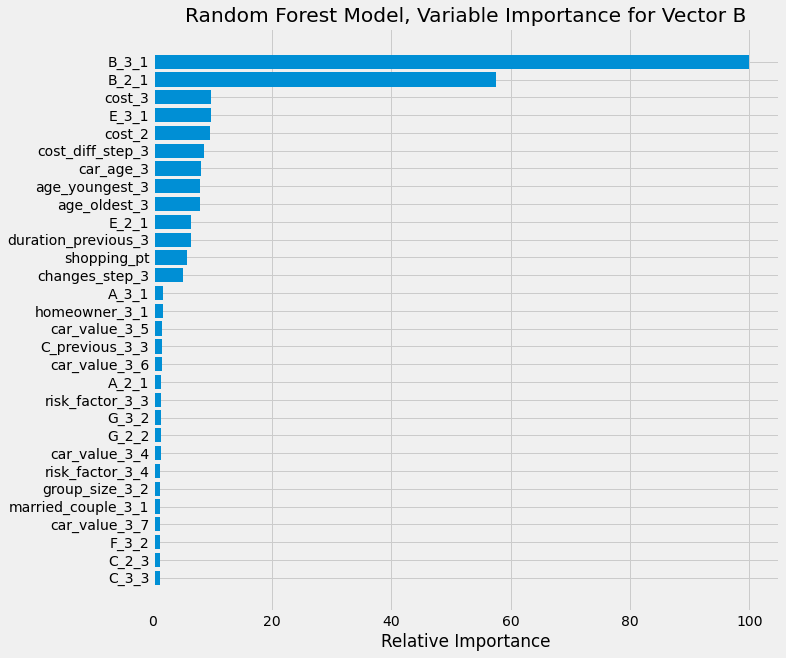

In [189]:
# Predict and plot B using best RF Model using quotes 2 and 3 (Iteration 53)
vector = 'B'
rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, min_samples_split = 3, plot=True)


XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 200,  max_depth = 1,     learning_rate = 0.3, colsample_bytree = 1
Accuracy=0.8842, f1-score=0.884
Confusion Matrix - normalized
 [[0.9103 0.0897]
 [0.1443 0.8557]]
Confusion Matrix
 [[6960  686]
 [1008 5977]]

Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      7646
           1       0.90      0.86      0.88      6985

    accuracy                           0.88     14631
   macro avg       0.89      0.88      0.88     14631
weighted avg       0.88      0.88      0.88     14631

30


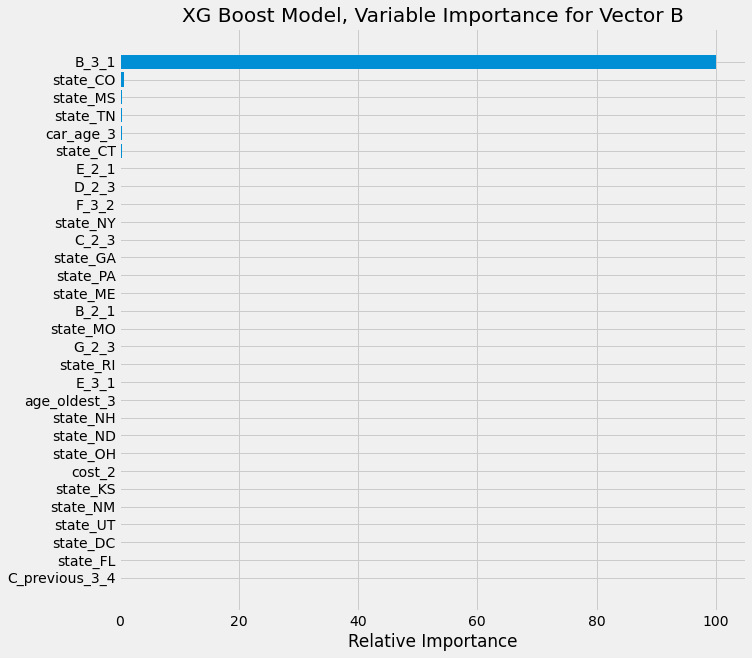

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.883 total time=   3.0s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.890 total time=   2.6s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.885 total time=   2.3s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.887 total time=   3.3s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=100;, score=0.883 total time=   3.7s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=100;, score=0.890 total time=   3.8s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=100;, score=0.885 total time=   2.8s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=100;, score=0.888 total time=  

[CV 2/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=400;, score=0.880 total time=  11.2s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=400;, score=0.873 total time=  10.1s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=400;, score=0.877 total time=  12.7s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=200;, score=0.883 total time=   4.9s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=200;, score=0.890 total time=   6.2s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=200;, score=0.885 total time=   3.8s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=3, n_estimators=200;, score=0.888 total time=   4.4s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.881 total time=   4.6s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.5, m

[CV 4/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500;, score=0.883 total time=  20.8s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.882 total time=   7.0s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.889 total time=   7.1s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.885 total time=   7.0s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=200;, score=0.887 total time=   6.9s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.879 total time=  11.6s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.888 total time=  12.2s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.882 total time=  13.1s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, ma

[CV 2/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.888 total time=   4.6s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.884 total time=   4.7s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=5, n_estimators=300;, score=0.886 total time=   4.7s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.880 total time=   3.3s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.886 total time=   3.2s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.883 total time=   2.8s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.885 total time=   2.9s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.881 total time=   5.6s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.3, max_d

In [135]:
#Let's predict B using XG Boost Classifier and use RandomizedSearchCV to find the best XGB classifier Hyperparamters 

xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=200, max_depth = 1, learning_rate = 0.3, colsample_bytree = 1, plot = True)

results = xgb_randomsearch(vector, 60)

datapath="Modelling_data/quotes_2_3"
filename3 = 'xgboost_results_q2_q3_vector'+vector+'.csv'
save_file(results, filename3, datapath)


In [137]:
# Calculate scores for the test set
vector = 'B'
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], xg_probs = xg_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                max_depth = int(max_depth), learning_rate = learning_rate, \
                                                                colsample_bytree = colsample_bytree, plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
filename4 = 'xgboost_results_q2_q3_vector'+vector+'_final.csv'
save_file(results, filename4, datapath)

XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.35, colsample_bytree = 0.35
Accuracy=0.8836, f1-score=0.8834
XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 100,  max_depth = 4,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.8841, f1-score=0.8839
XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 400,  max_depth = 5,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.8805, f1-score=0.8803
XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 300,  max_depth = 5,     learning_rate = 0.35, colsample_bytree = 0.15
Accuracy=0.8822, f1-score=0.882
XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 300,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.8837, f1-score=0.8836
XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 300,  max_depth = 4,     learning_rate = 0.35, colsam

XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 300,  max_depth = 4,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.883, f1-score=0.8828
XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 400,  max_depth = 3,     learning_rate = 0.5, colsample_bytree = 0.15
Accuracy=0.8825, f1-score=0.8823
XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 100,  max_depth = 4,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.8838, f1-score=0.8836
XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 400,  max_depth = 5,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.882, f1-score=0.8818
XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 100,  max_depth = 4,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.8842, f1-score=0.884
XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 300,  max_depth = 5,     learning_rate = 0.3, colsample

In [138]:
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            200          3           0.35              0.35     0.886280   
1            100          4           0.30              0.50     0.886366   
2            400          5           0.30              0.35     0.882863   
3            300          5           0.35              0.15     0.883478   
4            300          3           0.25              0.50     0.886468   
5            300          4           0.35              0.25     0.884281   
6            200          5           0.25              0.15     0.885631   
7            300          4           0.25              0.50     0.885648   
8            100          4           0.25              0.50     0.886588   
9            500          5           0.50              0.15     0.876421   
10           100          5           0.35              0.25     0.885665   
11           400          4           0.25              0.35     0.885340   
12           100          3           0.25              0.25     0.886690   
13           300          5           0.30              0.35     0.884008   
14           300          5           0.30              0.25     0.884110   
15           400          4           0.30              0.50     0.884298   
16           200          5           0.30              0.15     0.885050   
17           400          5           0.50              0.35     0.875446   
18           200          3           0.25              0.50     0.886639   
19           200          4           0.50              0.15     0.884554   
20           300          3           0.30              0.15     0.886349   
21           200          3           0.30              0.50     0.886314   
22           500          5           0.50              0.35     0.873174   
23           400          5           0.35              0.50     0.879787   
24           500          5           0.50              0.25     0.873618   
25           200          4           0.30              0.15     0.886041   
26           100          4           0.50              0.25     0.885392   
27           200          4           0.50              0.35     0.884281   
28           500          4           0.25              0.25     0.885118   
29           300          3           0.25              0.15     0.886554   
30           100          3           0.25              0.15     0.886605   
31           200          4           0.30              0.25     0.885853   
32           500          3           0.25              0.15     0.886126   
33           300          5           0.35              0.35     0.882572   
34           500          5           0.30              0.50     0.881325   
35           200          4           0.30              0.50     0.885614   
36           400          4           0.35              0.35     0.883495   
37           500          4           0.25              0.35     0.885084   
38           100          4           0.50              0.50     0.885118   
39           500          3           0.25              0.35     0.885938   
40           100          3           0.35              0.50     0.886554   
41           400          5           0.25              0.25     0.884571   
42           100          3           0.50              0.25     0.886109   
43           400          5           0.25              0.15     0.884640   
44           400          3           0.35              0.25     0.885460   
45           200          4           0.35              0.25     0.885050   
46           500          5           0.35              0.50     0.878915   
47           300          4           0.25              0.25     0.885990   
48           400          3           0.50              0.15     0.884982   
49           100          4           0.30              0.35     0.886366   
50           400          5           0.30              0.25     0.882572   


XGBoost Classifier results for Vector B
Parameters: No. of Estimators = 100,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.15
Accuracy=0.8842, f1-score=0.884
Confusion Matrix - normalized
 [[0.9103 0.0897]
 [0.1443 0.8557]]
Confusion Matrix
 [[6960  686]
 [1008 5977]]

Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      7646
           1       0.90      0.86      0.88      6985

    accuracy                           0.88     14631
   macro avg       0.89      0.88      0.88     14631
weighted avg       0.88      0.88      0.88     14631

30


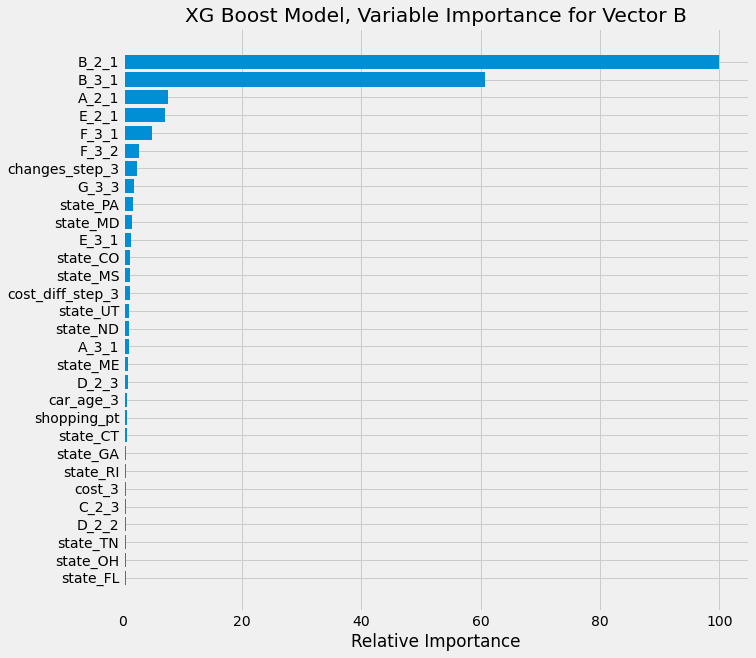

In [151]:
#Let's plot the best model for B using XG Boost Classifier (Iteration 30)
vector = 'B'

xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=100, max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.15, plot = True)


In [154]:
# Let's use Logistics Regression to predict vector B

vector = 'B'
lr_ac, lr_f1, lr_probs = lr_predict_plot(vector)


Logistic Regression for vector B
Accuracy = 0.8842, f1-score = 0.884

Confusion Matrix - normalized
 [[0.9103 0.0897]
 [0.1443 0.8557]]
Confusion Matrix
 [[6960  686]
 [1008 5977]]

Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      7646
           1       0.90      0.86      0.88      6985

    accuracy                           0.88     14631
   macro avg       0.89      0.88      0.88     14631
weighted avg       0.88      0.88      0.88     14631


Area under ROC: 
 0.9061388600174771


C:\Users\amite\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [155]:
vector = 'B'

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test[vector].astype('int'), rf_probs)
roc_auc1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test[vector].astype('int'), xg_probs)
roc_auc2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), lr_probs)
roc_auc3 = auc(fpr_3, tpr_3)

roc_auc1, roc_auc2, roc_auc3

(0.9085450100370156, 0.9092382578339933, 0.9061388600174771)

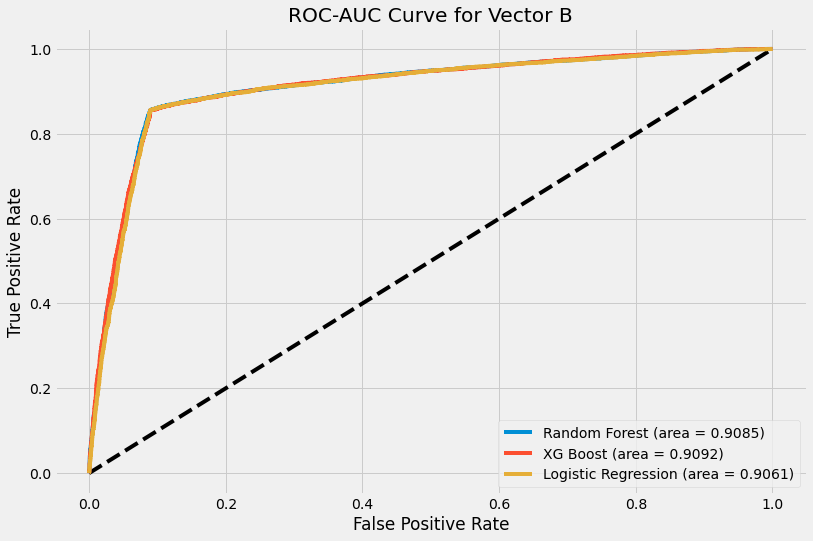

In [156]:
# Let's plot the ROC curve for all the models for vector B
vector = 'B'
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Random Forest (area = 0.9085)')
plt.plot(fpr_2, tpr_2, label='XG Boost (area = 0.9092)')
plt.plot(fpr_3, tpr_3, label='Logistic Regression (area = 0.9061)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Vector '+vector)
plt.legend()
plt.show()


Vector B Logistic Regression Model
Best Accuracy score of 0.8843 occurs for threshold = 0.315
Vector B Random Forest Model
Best Accuracy score of 0.8844 occurs for threshold = 0.498
Vector B XG Boost Model
Best Accuracy score of 0.8843 occurs for threshold = 0.49


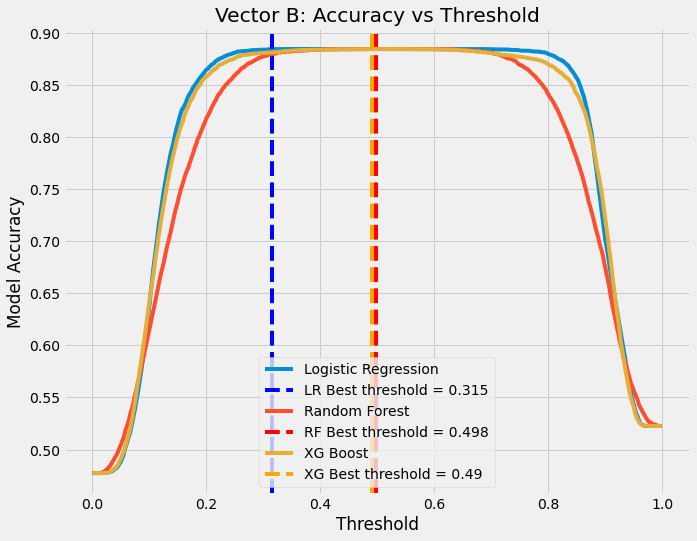

In [158]:
# We are concerned with accuracy of the model i.e. its ability to predict both the 0 and 1 labels correctly
# So we will calculate the accuracy score at different thresholds directly
vector = 'B'
plt.figure(figsize=(10,8))

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = np.arange(0, 1, 0.001)

# for LR model
ac_score_lr = [accuracy_score(y_test[vector].astype('int'), to_labels(lr_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_lr)
print(f"Vector {vector} Logistic Regression Model\nBest Accuracy score of {ac_score_lr[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_lr, label='Logistic Regression')
plt.axvline(thresholds[idx], color='blue', linestyle="--", label = "LR Best threshold = "+str(np.round(thresholds[idx],4)))

# for random forest
thresholds = np.arange(0, 1, 0.001)
ac_score_rf = [accuracy_score(y_test[vector].astype('int'), to_labels(rf_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_rf)
print(f"Vector {vector} Random Forest Model\nBest Accuracy score of {ac_score_rf[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_rf, label='Random Forest')
plt.axvline(thresholds[idx], color='red', linestyle="--", label = "RF Best threshold = "+str(np.round(thresholds[idx],4)))

# for XG Boost
thresholds = np.arange(0, 1, 0.001)
ac_score_xg = [accuracy_score(y_test[vector].astype('int'), to_labels(xg_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_xg)
print(f"Vector {vector} XG Boost Model\nBest Accuracy score of {ac_score_xg[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_xg, label='XG Boost')
plt.axvline(thresholds[idx], color='orange', linestyle="--", label = "XG Best threshold = "+str(np.round(thresholds[idx],4)))

plt.xlabel('Threshold')
plt.ylabel('Model Accuracy')
plt.title('Vector B: Accuracy vs Threshold')

plt.legend()
plt.show()

# Quote 2 & 3: Predict C

In [139]:
y_train['C'].value_counts()

3    22926
1    17602
2    12238
4     5755
Name: C, dtype: int64

In [140]:
mapping_C = {1:0, 2:1, 3:2, 4:3}

y_train['C'] = y_train['C'].map(lambda x: mapping_C[x] )
y_test['C'] = y_test['C'].map(lambda x: mapping_C[x] )
y_train['C'].value_counts()


C:\Users\amite\AppData\Local\Temp/ipykernel_33952/1911054288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['C'] = y_train['C'].map(lambda x: mapping_C[x] )
C:\Users\amite\AppData\Local\Temp/ipykernel_33952/1911054288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['C'] = y_test['C'].map(lambda x: mapping_C[x] )


2    22926
0    17602
1    12238
3     5755
Name: C, dtype: int64

In [141]:
vector = 'C'
last_quote = 3

test_set = df_hist_2_3.iloc[y_test.index,:]

x = pd.crosstab(test_set[vector], test_set[vector+'_'+str(last_quote)])

same_as_3 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_test.shape[0]): 4.4}")
print(f"Confusion_Matrix")

x['total'] = x.sum(axis=1)
x['C1_%'] = np.around(x[1]/ x['total'], 4)
x['C2_%'] = np.around(x[2]/ x['total'], 4)
x['C3_%'] = np.around(x[3]/ x['total'], 4)
x['C4_%'] = np.around(x[4]/ x['total'], 4)
x


Accuracy based on simply predicting vector C = C_3 :  0.8749
Confusion_Matrix


C_3     1     2     3     4  total    C1_%    C2_%    C3_%    C4_%
C                                                                 
1    3972   258   205    12   4447  0.8932  0.0580  0.0461  0.0027
2     269  2534   322    24   3149  0.0854  0.8047  0.1023  0.0076
3     168   202  5101   110   5581  0.0301  0.0362  0.9140  0.0197
4      34    22   204  1194   1454  0.0234  0.0151  0.1403  0.8212

In [190]:
vector = 'C'
last_quote = 3
test_set2 = df_hist_2_3.iloc[y_train.index,:]
x2 = pd.crosstab(test_set2[vector], test_set2[vector+'_'+str(last_quote)])
same_as_3 = [x2.iloc[idx,idx] for idx in range(x2.shape[0])] 
print(f"TRAINING Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_train.shape[0]): 4.4}")
print(f"Confusion_Matrix - TRAINING")
x2['total'] = x2.sum(axis=1)
x2['C1_%'] = np.around(x2[1]/ x2['total'], 4)
x2['C2_%'] = np.around(x2[2]/ x2['total'], 4)
x2['C3_%'] = np.around(x2[3]/ x2['total'], 4)
x2['C4_%'] = np.around(x2[4]/ x2['total'], 4)
x2

TRAINING Accuracy based on simply predicting vector C = C_3 :  0.876
Confusion_Matrix - TRAINING


C_3      1     2      3     4  total    C1_%    C2_%    C3_%    C4_%
C                                                                   
1    15619   999    934    50  17602  0.8873  0.0568  0.0531  0.0028
2     1000  9876   1288    74  12238  0.0817  0.8070  0.1052  0.0060
3      761   781  20992   392  22926  0.0332  0.0341  0.9156  0.0171
4      119   109    749  4778   5755  0.0207  0.0189  0.1301  0.8302

Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.877, f1-score=0.8765
Confusion Matrix - normalized
 [[0.8934 0.0578 0.0461 0.0027]
 [0.0845 0.8082 0.0997 0.0076]
 [0.0287 0.0349 0.9165 0.0199]
 [0.0234 0.0138 0.1389 0.8239]]
Confusion Matrix
 [[3973  257  205   12]
 [ 266 2545  314   24]
 [ 160  195 5115  111]
 [  34   20  202 1198]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      4447
           1       0.84      0.81      0.83      3149
           2       0.88      0.92      0.90      5581
           3       0.89      0.82      0.86      1454

    accuracy                           0.88     14631
   macro avg       0.88      0.86      0.87     14631
weighted avg       0.88      0.88      0.88     14631

30


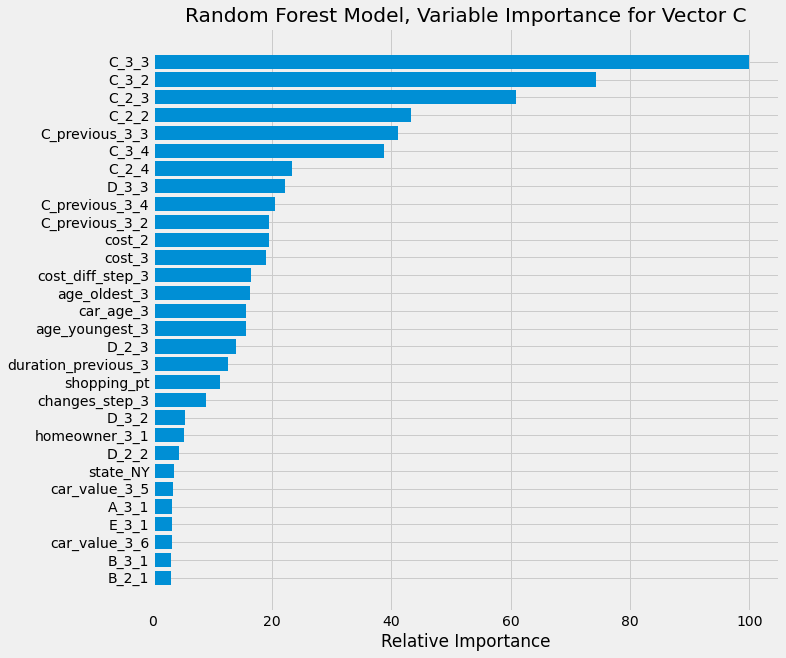

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.875 total time=  16.9s
[CV 2/4] END min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.879 total time=   7.1s
[CV 3/4] END min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.877 total time=   7.0s
[CV 4/4] END min_samples_leaf=3, min_samples_split=2, n_estimators=200;, score=0.877 total time=   7.2s
[CV 1/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=500;, score=0.875 total time=  16.1s
[CV 2/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=500;, score=0.879 total time=  16.2s
[CV 3/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=500;, score=0.876 total time=  16.2s
[CV 4/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=500;, score=0.877 total time=  16.2s
[CV 1/4] END min_samples_leaf=3, min_samples_split=3, n_estimators=500;, score=0.875 total time=  15.9s
[C

[CV 4/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=0.877 total time=   3.6s
[CV 1/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=600;, score=0.875 total time=  18.5s
[CV 2/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=600;, score=0.879 total time=  18.4s
[CV 3/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=600;, score=0.876 total time=  18.4s
[CV 4/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=600;, score=0.877 total time=  18.4s
[CV 1/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.876 total time=  13.9s
[CV 2/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.880 total time=  14.1s
[CV 3/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.877 total time=  15.4s
[CV 4/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.877 total time=  14.5s
[CV 1/4] END min_samples_leaf=2, min_samples_split=2, n_estimato

[CV 3/4] END min_samples_leaf=1, min_samples_split=4, n_estimators=700;, score=0.877 total time=  25.7s
[CV 4/4] END min_samples_leaf=1, min_samples_split=4, n_estimators=700;, score=0.877 total time=  25.6s
[CV 1/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.875 total time=   3.6s
[CV 2/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.879 total time=   3.4s
[CV 3/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.876 total time=   3.4s
[CV 4/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.876 total time=   3.4s
[CV 1/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.875 total time=  13.4s
[CV 2/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.879 total time=  14.0s
[CV 3/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.877 total time=  13.2s
[CV 4/4] END min_samples_leaf=2, min_samples_split=5, n_estimato

[CV 2/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.880 total time=   8.0s
[CV 3/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.877 total time=   8.0s
[CV 4/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.877 total time=   8.3s
Vector C RandomizedSearchCV: Random Forest Model
Best Score:0.8774799075250711
Best Parameters: {'n_estimators': 700, 'min_samples_split': 3, 'min_samples_leaf': 1}
Writing file.  "Modelling_data/quotes_2_3\rf_results_q2_q3_vectorC.csv"


In [142]:
# RF Classifier: Predict C using quotes 2 and 3 and then RandomizedSearchCV to find best hyperparameters

vector = 'C'

rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, min_samples_split = 2, plot=True)

results = rf_randomsearch(vector, 60)

datapath="Modelling_data/quotes_2_3" 
filename1 = 'rf_results_q2_q3_vector'+vector+'.csv'
save_file(results, filename1, datapath)

In [147]:
vector = 'C'

for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    min_samples_leaf = row['min_samples_leaf']
    min_samples_split = row['min_samples_split']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], rf_probs = rf_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                min_samples_leaf = int(min_samples_leaf), \
                                                                min_samples_split = int(min_samples_split), plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
filename2 = 'rf_results_q2_q3_vector'+vector+'_final.csv'
save_file(results, filename2, datapath)

Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 200,  min_samples_leaf = 3,     min_samples_split = 2
Accuracy=0.876, f1-score=0.8755
Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 500,  min_samples_leaf = 3,     min_samples_split = 5
Accuracy=0.876, f1-score=0.8755
Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 500,  min_samples_leaf = 3,     min_samples_split = 3
Accuracy=0.876, f1-score=0.8755
Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 400,  min_samples_leaf = 4,     min_samples_split = 4
Accuracy=0.8759, f1-score=0.8754
Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 600,  min_samples_leaf = 1,     min_samples_split = 4
Accuracy=0.8768, f1-score=0.8763
Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 800,  min_samples_leaf = 1,     min_samples_split = 3
Accuracy=0.8766, f1-score=0.8762
Random Forest

Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 200,  min_samples_leaf = 4,     min_samples_split = 4
Accuracy=0.8757, f1-score=0.8753
Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 600,  min_samples_leaf = 4,     min_samples_split = 2
Accuracy=0.8759, f1-score=0.8755
Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 700,  min_samples_leaf = 2,     min_samples_split = 2
Accuracy=0.8762, f1-score=0.8757
Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 200,  min_samples_leaf = 4,     min_samples_split = 3
Accuracy=0.8757, f1-score=0.8753
Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 500,  min_samples_leaf = 4,     min_samples_split = 3
Accuracy=0.8759, f1-score=0.8755
Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 100,  min_samples_leaf = 2,     min_samples_split = 5
Accuracy=0.8766, f1-score=0.8761
Random For

In [148]:
results

n_estimators  min_samples_split  min_samples_leaf  train_score  \
0            200                  2                 3     0.876899   
1            500                  5                 3     0.876813   
2            500                  3                 3     0.876813   
3            400                  4                 4     0.876506   
4            600                  4                 1     0.877343   
5            800                  3                 1     0.877463   
6            600                  5                 1     0.877394   
7            300                  2                 4     0.876506   
8            700                  3                 4     0.876591   
9            400                  2                 4     0.876506   
10           800                  2                 4     0.876557   
11           500                  2                 2     0.876984   
12           400                  5                 4     0.876506   
13           500                  3                 1     0.877446   
14           400                  3                 1     0.877463   
15           400                  3                 4     0.876506   
16           700                  3                 3     0.876848   
17           600                  3                 2     0.877053   
18           100                  3                 3     0.876933   
19           100                  4                 2     0.877138   
20           600                  4                 3     0.876813   
21           400                  2                 1     0.877343   
22           100                  2                 2     0.877138   
23           500                  4                 1     0.877377   
24           400                  5                 3     0.876831   
25           700                  4                 2     0.877036   
26           400                  4                 3     0.876831   
27           100                  2                 1     0.877343   
28           500                  4                 2     0.876984   
29           200                  5                 3     0.876899   
30           700                  3                 1     0.877480   
31           500                  2                 1     0.877360   
32           100                  4                 4     0.876626   
33           100                  5                 4     0.876626   
34           300                  5                 2     0.877019   
35           800                  3                 4     0.876557   
36           300                  2                 2     0.876933   
37           600                  4                 4     0.876523   
38           700                  5                 4     0.876591   
39           700                  4                 1     0.877377   
40           100                  2                 4     0.876626   
41           400                  5                 2     0.877036   
42           600                  2                 3     0.876813   
43           800                  5                 3     0.876848   
44           100                  3                 2     0.877138   
45           400                  4                 1     0.877377   
46           700                  2                 4     0.876591   
47           200                  3                 3     0.876899   
48           700                  2                 3     0.876848   
49           100                  4                 3     0.876933   
50           200                  4                 4     0.876574   
51           600                  2                 4     0.876523   
52           700                  2                 2     0.877036   
53           200                  3                 4     0.876574   
54           500                  3                 4     0.876506   
55           100                  5                 2     0.876984   
56           5

Random Forest Classifier results for Vector C
Parameters: No. of Estimators = 100,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8771, f1-score=0.8766
Confusion Matrix - normalized
 [[0.8939 0.0573 0.0461 0.0027]
 [0.0842 0.8095 0.0988 0.0076]
 [0.0288 0.0348 0.9161 0.0202]
 [0.0234 0.0138 0.1403 0.8226]]
Confusion Matrix
 [[3975  255  205   12]
 [ 265 2549  311   24]
 [ 161  194 5113  113]
 [  34   20  204 1196]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      4447
           1       0.84      0.81      0.83      3149
           2       0.88      0.92      0.90      5581
           3       0.89      0.82      0.85      1454

    accuracy                           0.88     14631
   macro avg       0.88      0.86      0.87     14631
weighted avg       0.88      0.88      0.88     14631

30


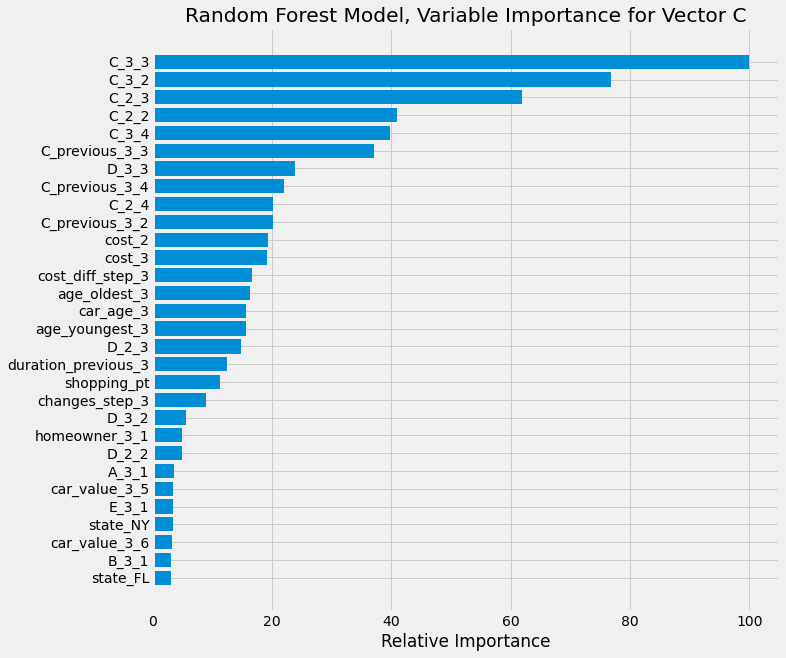

In [160]:
#Let's plot the best model for C using Random Forest Classifier (Iteration 27)
vector = 'C'
rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=100, min_samples_leaf = 1, min_samples_split = 2, plot=True)


XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 200,  max_depth = 1,     learning_rate = 0.3, colsample_bytree = 1
Accuracy=0.8755, f1-score=0.8751
Confusion Matrix - normalized
 [[0.8936 0.058  0.0454 0.0029]
 [0.0842 0.8082 0.1007 0.007 ]
 [0.0301 0.0364 0.9144 0.0192]
 [0.0213 0.0158 0.1458 0.8171]]
Confusion Matrix
 [[3974  258  202   13]
 [ 265 2545  317   22]
 [ 168  203 5103  107]
 [  31   23  212 1188]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      4447
           1       0.84      0.81      0.82      3149
           2       0.87      0.91      0.89      5581
           3       0.89      0.82      0.85      1454

    accuracy                           0.88     14631
   macro avg       0.88      0.86      0.87     14631
weighted avg       0.88      0.88      0.88     14631

30


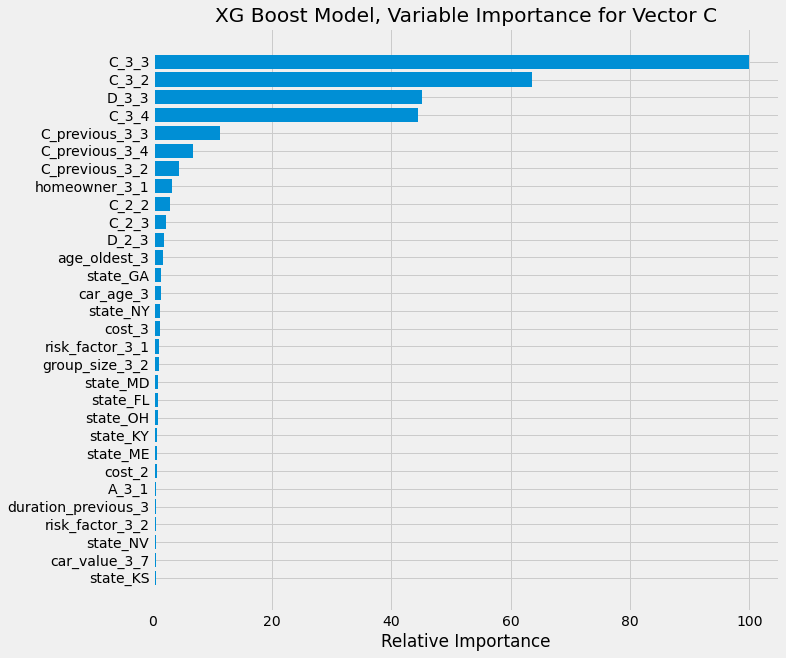

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.876 total time=  18.5s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.880 total time=  17.2s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.876 total time=  17.1s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.877 total time=  16.0s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.872 total time=  37.0s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.876 total time=  38.8s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.874 total time=  36.0s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.874 total tim

[CV 2/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500;, score=0.875 total time=  47.0s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500;, score=0.871 total time=  49.4s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=500;, score=0.873 total time=  48.7s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=3, n_estimators=100;, score=0.876 total time=   3.9s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=3, n_estimators=100;, score=0.880 total time=   3.9s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=3, n_estimators=100;, score=0.877 total time=   4.3s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=3, n_estimators=100;, score=0.876 total time=   4.1s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.35, max_depth=4, n_estimators=300;, score=0.873 total time=  23.3s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.35, 

[CV 4/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=4, n_estimators=300;, score=0.876 total time=  14.3s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=300;, score=0.869 total time=  27.7s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=300;, score=0.875 total time=  28.1s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=300;, score=0.872 total time=  27.8s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=300;, score=0.872 total time=  27.7s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.875 total time=  18.0s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.879 total time=  18.2s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.876 total time=  18.0s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.25, m

[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=200;, score=0.879 total time=  14.5s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=200;, score=0.874 total time=  14.0s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=200;, score=0.876 total time=  14.0s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.876 total time=   5.8s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.878 total time=   5.8s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.876 total time=   5.8s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.877 total time=   5.8s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.875 total time=   3.7s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.5

In [161]:
#Let's predict C using XG Boost Classifier and use RandomizedSearchCV to find the best XGB classifier Hyperparamters 
vector = 'C'
xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=200, max_depth = 1, learning_rate = 0.3, colsample_bytree = 1, plot = True)

results = xgb_randomsearch(vector, 60)

datapath="Modelling_data/quotes_2_3"
filename3 = 'xgboost_results_q2_q3_vector'+vector+'.csv'
save_file(results, filename3, datapath)


In [162]:
# Find scores for the test set
vector = 'C'
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], xg_probs = xg_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                max_depth = int(max_depth), learning_rate = learning_rate, \
                                                                colsample_bytree = colsample_bytree, plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
filename4 = 'xgboost_results_q2_q3_vector'+vector+'_final.csv'
save_file(results, filename4, datapath)

XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 300,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.8754, f1-score=0.8749
XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 400,  max_depth = 4,     learning_rate = 0.35, colsample_bytree = 0.5
Accuracy=0.8733, f1-score=0.8727
XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 300,  max_depth = 5,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.8742, f1-score=0.8737
XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 300,  max_depth = 5,     learning_rate = 0.35, colsample_bytree = 0.5
Accuracy=0.8721, f1-score=0.8715
XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 100,  max_depth = 3,     learning_rate = 0.5, colsample_bytree = 0.15
Accuracy=0.8745, f1-score=0.874
XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 200,  max_depth = 4,     learning_rate = 0.5, colsam

XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 300,  max_depth = 5,     learning_rate = 0.5, colsample_bytree = 0.35
Accuracy=0.8688, f1-score=0.8682
XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 500,  max_depth = 5,     learning_rate = 0.5, colsample_bytree = 0.5
Accuracy=0.8662, f1-score=0.8656
XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 500,  max_depth = 5,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.871, f1-score=0.8704
XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 300,  max_depth = 4,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.8753, f1-score=0.8747
XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 100,  max_depth = 4,     learning_rate = 0.5, colsample_bytree = 0.35
Accuracy=0.8749, f1-score=0.8744
XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 200,  max_depth = 5,     learning_rate = 0.35, colsampl

In [191]:
results_C_xg = pd.read_csv("Modelling_data/quotes_2_3/xgboost_results_q2_q3_vectorC_final.csv")
results_C_xg

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            300          3           0.25              0.35     0.877138   
1            400          4           0.35              0.50     0.874011   
2            300          5           0.25              0.35     0.875857   
3            300          5           0.35              0.50     0.873208   
4            100          3           0.50              0.15     0.877172   
5            200          4           0.50              0.35     0.874541   
6            500          4           0.25              0.25     0.875532   
7            400          3           0.50              0.35     0.874626   
8            300          3           0.50              0.15     0.875669   
9            400          3           0.50              0.50     0.873601   
10           300          4           0.35              0.15     0.875703   
11           400          4           0.30              0.35     0.874780   
12           300          4           0.35              0.35     0.875412   
13           400          3           0.35              0.15     0.876198   
14           200          3           0.35              0.15     0.877394   
15           500          3           0.35              0.35     0.875310   
16           500          3           0.25              0.15     0.876796   
17           500          5           0.30              0.50     0.872815   
18           100          3           0.35              0.25     0.877224   
19           300          4           0.35              0.50     0.875190   
20           300          4           0.35              0.25     0.875976   
21           400          3           0.25              0.35     0.876728   
22           400          3           0.30              0.25     0.876335   
23           400          5           0.25              0.35     0.875224   
24           200          5           0.35              0.50     0.874490   
25           300          3           0.25              0.15     0.877548   
26           100          3           0.35              0.15     0.876950   
27           500          4           0.50              0.35     0.870474   
28           400          5           0.25              0.25     0.875617   
29           500          4           0.25              0.35     0.875874   
30           100          3           0.30              0.50     0.877480   
31           200          4           0.25              0.25     0.877617   
32           200          5           0.50              0.50     0.873037   
33           300          3           0.35              0.15     0.876899   
34           300          4           0.30              0.25     0.876455   
35           300          5           0.50              0.50     0.871943   
36           500          3           0.25              0.25     0.876352   
37           500          3           0.50              0.25     0.873806   
38           500          3           0.30              0.15     0.876489   
39           100          3           0.35              0.50     0.877787   
40           300          4           0.25              0.25     0.876694   
41           100          3           0.35              0.35     0.877753   
42           500          5           0.25              0.15     0.875241   
43           400          5           0.25              0.50     0.874524   
44           100          4           0.25              0.35     0.877753   
45           200          5           0.35              0.15     0.875959   
46           200          3           0.30              0.35     0.877326   
47           300          5           0.50              0.35     0.871380   
48           500          5           0.50              0.50     0.868526   
49           500          5           0.30              0.35     0.873396   
50           300          4           0.25              0.50     0.875993   


XGBoost Classifier results for Vector C
Parameters: No. of Estimators = 300,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.15
Accuracy=0.8759, f1-score=0.8754
Confusion Matrix - normalized
 [[0.8921 0.0571 0.0472 0.0036]
 [0.0861 0.8063 0.1007 0.007 ]
 [0.0296 0.0348 0.9154 0.0202]
 [0.0199 0.0165 0.1382 0.8253]]
Confusion Matrix
 [[3967  254  210   16]
 [ 271 2539  317   22]
 [ 165  194 5109  113]
 [  29   24  201 1200]]

Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      4447
           1       0.84      0.81      0.82      3149
           2       0.88      0.92      0.89      5581
           3       0.89      0.83      0.86      1454

    accuracy                           0.88     14631
   macro avg       0.88      0.86      0.87     14631
weighted avg       0.88      0.88      0.88     14631

30


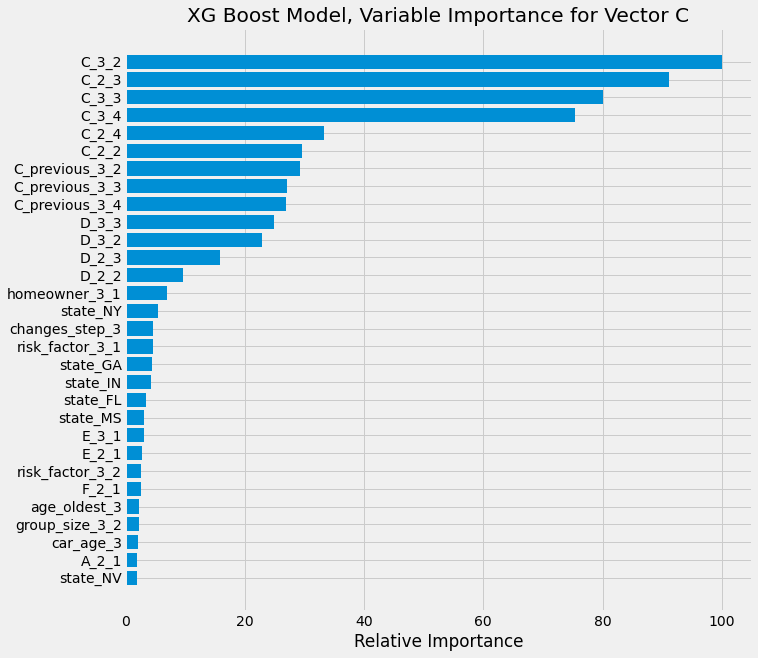

In [192]:
#Let's plot the best model for C using XG Boost Classifier (Iteration 25)

xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=300, max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.15, plot = True)


# Quote 2 & 3: Predict D

In [163]:
y_train['D'].value_counts()


3    37774
2    13107
1     7640
Name: D, dtype: int64

In [164]:
mapping_D = {1:0, 2:1, 3:2}

y_train['D'] = y_train['D'].map(lambda x: mapping_D[x] )
y_test['D'] = y_test['D'].map(lambda x: mapping_D[x] )
y_train['D'].value_counts()


C:\Users\amite\AppData\Local\Temp/ipykernel_33952/2807440063.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['D'] = y_train['D'].map(lambda x: mapping_D[x] )
C:\Users\amite\AppData\Local\Temp/ipykernel_33952/2807440063.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['D'] = y_test['D'].map(lambda x: mapping_D[x] )


2    37774
1    13107
0     7640
Name: D, dtype: int64

In [165]:
vector = 'D'
last_quote = 3

test_set = df_hist_2_3.iloc[y_test.index,:]

x = pd.crosstab(test_set[vector], test_set[vector+'_'+str(last_quote)])

same_as_3 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_test.shape[0]): 4.4}")
print(f"Confusion_Matrix")

x['total'] = x.sum(axis=1)
x['D1_%'] = np.around(x[1]/ x['total'], 4)
x['D2_%'] = np.around(x[2]/ x['total'], 4)
x['D3_%'] = np.around(x[3]/ x['total'], 4)
x

Accuracy based on simply predicting vector D = D_3 :  0.906
Confusion_Matrix


D_3     1     2     3  total    D1_%    D2_%    D3_%
D                                                   
1    1757    92    75   1924  0.9132  0.0478  0.0390
2     243  2866   266   3375  0.0720  0.8492  0.0788
3     280   420  8632   9332  0.0300  0.0450  0.9250

In [193]:
vector = 'D'
last_quote = 3
test_set2 = df_hist_2_3.iloc[y_train.index,:]
x2 = pd.crosstab(test_set2[vector], test_set2[vector+'_'+str(last_quote)])
same_as_3 = [x2.iloc[idx,idx] for idx in range(x2.shape[0])] 
print(f"TRAINING Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_train.shape[0]): 4.4}")
print(f"Confusion_Matrix - TRAINING")
x2['total'] = x2.sum(axis=1)
x2['D1_%'] = np.around(x2[1]/ x2['total'], 4)
x2['D2_%'] = np.around(x2[2]/ x2['total'], 4)
x2['D3_%'] = np.around(x2[3]/ x2['total'], 4)
x2

TRAINING Accuracy based on simply predicting vector D = D_3 :  0.9063
Confusion_Matrix - TRAINING


D_3     1      2      3  total    D1_%    D2_%    D3_%
D                                                     
1    6887    398    355   7640  0.9014  0.0521  0.0465
2     978  11205    924  13107  0.0746  0.8549  0.0705
3    1104   1726  34944  37774  0.0292  0.0457  0.9251

Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.9079, f1-score=0.9089
Confusion Matrix - normalized
 [[0.9023 0.0478 0.0499]
 [0.067  0.8489 0.0841]
 [0.0242 0.0453 0.9305]]
Confusion Matrix
 [[1736   92   96]
 [ 226 2865  284]
 [ 226  423 8683]]

Classification Report 
               precision    recall  f1-score   support

           0       0.79      0.90      0.84      1924
           1       0.85      0.85      0.85      3375
           2       0.96      0.93      0.94      9332

    accuracy                           0.91     14631
   macro avg       0.87      0.89      0.88     14631
weighted avg       0.91      0.91      0.91     14631

30


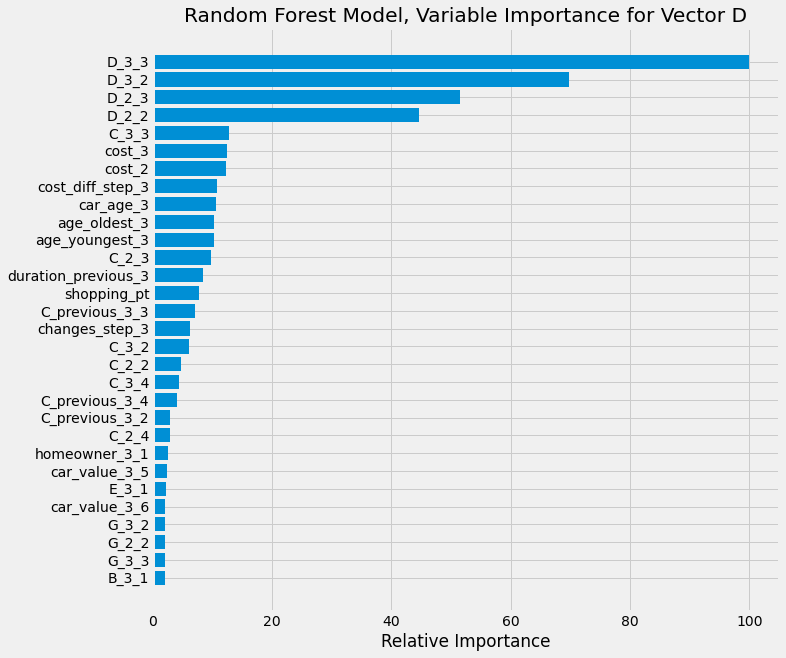

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END min_samples_leaf=1, min_samples_split=3, n_estimators=800;, score=0.906 total time=  29.1s
[CV 2/4] END min_samples_leaf=1, min_samples_split=3, n_estimators=800;, score=0.910 total time=  25.4s
[CV 3/4] END min_samples_leaf=1, min_samples_split=3, n_estimators=800;, score=0.907 total time=  25.4s
[CV 4/4] END min_samples_leaf=1, min_samples_split=3, n_estimators=800;, score=0.911 total time=  25.2s
[CV 1/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=0.905 total time=   9.0s
[CV 2/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=0.909 total time=   9.1s
[CV 3/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=0.907 total time=   9.0s
[CV 4/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=0.911 total time=   9.1s
[CV 1/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=0.905 total time=  15.2s
[C

[CV 4/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=600;, score=0.911 total time=  18.3s
[CV 1/4] END min_samples_leaf=3, min_samples_split=3, n_estimators=700;, score=0.905 total time=  21.0s
[CV 2/4] END min_samples_leaf=3, min_samples_split=3, n_estimators=700;, score=0.910 total time=  20.7s
[CV 3/4] END min_samples_leaf=3, min_samples_split=3, n_estimators=700;, score=0.908 total time=  20.9s
[CV 4/4] END min_samples_leaf=3, min_samples_split=3, n_estimators=700;, score=0.911 total time=  21.0s
[CV 1/4] END min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.906 total time=   9.3s
[CV 2/4] END min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.910 total time=   9.2s
[CV 3/4] END min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.907 total time=   9.3s
[CV 4/4] END min_samples_leaf=1, min_samples_split=5, n_estimators=300;, score=0.911 total time=   9.3s
[CV 1/4] END min_samples_leaf=1, min_samples_split=2, n_estimato

[CV 3/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=0.907 total time=  11.8s
[CV 4/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=0.911 total time=  11.4s
[CV 1/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.906 total time=  12.7s
[CV 2/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.911 total time=  12.6s
[CV 3/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.907 total time=  12.7s
[CV 4/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.911 total time=  12.7s
[CV 1/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.906 total time=  15.8s
[CV 2/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.910 total time=  15.8s
[CV 3/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.908 total time=  15.9s
[CV 4/4] END min_samples_leaf=1, min_samples_split=2, n_estimato

[CV 2/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=300;, score=0.910 total time=   9.2s
[CV 3/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=300;, score=0.908 total time=   9.3s
[CV 4/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=300;, score=0.911 total time=   9.4s
Vector D RandomizedSearchCV: Random Forest Model
Best Score:0.9086824046527487
Best Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1}
Writing file.  "Modelling_data/quotes_2_3\rf_results_q2_q3_vectorD.csv"


In [166]:
# RF Classifier: Predict D using quotes 2 and 3 and then RandomizedSearchCV to find best hyperparameters

vector = 'D'

rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, min_samples_split = 2, plot=True)

results = rf_randomsearch(vector, 60)

datapath="Modelling_data/quotes_2_3"
filename1 = 'rf_results_q2_q3_vector'+vector+'.csv'
save_file(results, filename1, datapath)

In [167]:
# Get scores for test set
vector = 'D'

for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    min_samples_leaf = row['min_samples_leaf']
    min_samples_split = row['min_samples_split']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], rf_probs = rf_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                min_samples_leaf = int(min_samples_leaf), \
                                                                min_samples_split = int(min_samples_split), plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
filename2 = 'rf_results_q2_q3_vector'+vector+'_final.csv'
save_file(results, filename2, datapath)


Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 800,  min_samples_leaf = 1,     min_samples_split = 3
Accuracy=0.9082, f1-score=0.9091
Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 300,  min_samples_leaf = 4,     min_samples_split = 2
Accuracy=0.9079, f1-score=0.9089
Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 500,  min_samples_leaf = 2,     min_samples_split = 2
Accuracy=0.9081, f1-score=0.909
Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 400,  min_samples_leaf = 4,     min_samples_split = 4
Accuracy=0.908, f1-score=0.909
Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.9079, f1-score=0.9089
Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 800,  min_samples_leaf = 3,     min_samples_split = 5
Accuracy=0.9078, f1-score=0.9088
Random Forest

Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 4
Accuracy=0.9081, f1-score=0.909
Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 700,  min_samples_leaf = 4,     min_samples_split = 3
Accuracy=0.9078, f1-score=0.9088
Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 700,  min_samples_leaf = 4,     min_samples_split = 2
Accuracy=0.9078, f1-score=0.9088
Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 700,  min_samples_leaf = 4,     min_samples_split = 5
Accuracy=0.9078, f1-score=0.9088
Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 100,  min_samples_leaf = 2,     min_samples_split = 4
Accuracy=0.9077, f1-score=0.9087
Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 800,  min_samples_leaf = 2,     min_samples_split = 2
Accuracy=0.9081, f1-score=0.9091
Random Fore

In [194]:
results_D_rf = pd.read_csv("Modelling_data/quotes_2_3/rf_results_q2_q3_vectorD_final.csv")
results_D_rf

n_estimators  min_samples_split  min_samples_leaf  train_score  \
0            800                  3                 1     0.908546   
1            300                  2                 4     0.908050   
2            500                  2                 2     0.908546   
3            400                  4                 4     0.908119   
4            300                  2                 1     0.908631   
5            800                  5                 3     0.908409   
6            800                  3                 2     0.908494   
7            400                  3                 3     0.908324   
8            800                  4                 3     0.908409   
9            600                  4                 3     0.908324   
10           700                  5                 3     0.908409   
11           300                  4                 3     0.908392   
12           600                  5                 4     0.908153   
13           100                  5                 1     0.908289   
14           500                  4                 4     0.908221   
15           400                  5                 1     0.908512   
16           600                  3                 4     0.908153   
17           100                  2                 2     0.908443   
18           200                  4                 4     0.908187   
19           600                  4                 2     0.908512   
20           700                  3                 3     0.908409   
21           300                  5                 1     0.908477   
22           600                  2                 1     0.908546   
23           400                  5                 2     0.908426   
24           300                  2                 3     0.908392   
25           600                  4                 4     0.908153   
26           600                  2                 4     0.908153   
27           700                  5                 2     0.908580   
28           100                  4                 3     0.908289   
29           700                  4                 3     0.908409   
30           800                  3                 4     0.908136   
31           500                  5                 3     0.908306   
32           600                  5                 1     0.908631   
33           400                  4                 1     0.908392   
34           700                  5                 1     0.908631   
35           700                  3                 1     0.908682   
36           100                  2                 4     0.908324   
37           600                  2                 3     0.908324   
38           500                  4                 3     0.908306   
39           400                  5                 4     0.908119   
40           400                  2                 1     0.908682   
41           500                  2                 1     0.908665   
42           300                  2                 2     0.908546   
43           800                  3                 3     0.908409   
44           400                  5                 3     0.908324   
45           200                  5                 2     0.908597   
46           100                  3                 4     0.908324   
47           400                  4                 2     0.908477   
48           400                  3                 1     0.908665   
49           600                  5                 2     0.908546   
50           300                  4                 1     0.908563   
51           700                  3                 4     0.908187   
52           700                  2                 4     0.908187   
53           700                  5                 4     0.908187   
54           100                  4                 2     0.908443   
55           800                  2                 2     0.908494   
56           8

Random Forest Classifier results for Vector D
Parameters: No. of Estimators = 600,  min_samples_leaf = 1,     min_samples_split = 5
Accuracy=0.9084, f1-score=0.9094
Confusion Matrix - normalized
 [[0.9038 0.0478 0.0483]
 [0.0676 0.8501 0.0824]
 [0.0243 0.0452 0.9305]]
Confusion Matrix
 [[1739   92   93]
 [ 228 2869  278]
 [ 227  422 8683]]

Classification Report 
               precision    recall  f1-score   support

           0       0.79      0.90      0.84      1924
           1       0.85      0.85      0.85      3375
           2       0.96      0.93      0.94      9332

    accuracy                           0.91     14631
   macro avg       0.87      0.89      0.88     14631
weighted avg       0.91      0.91      0.91     14631

30


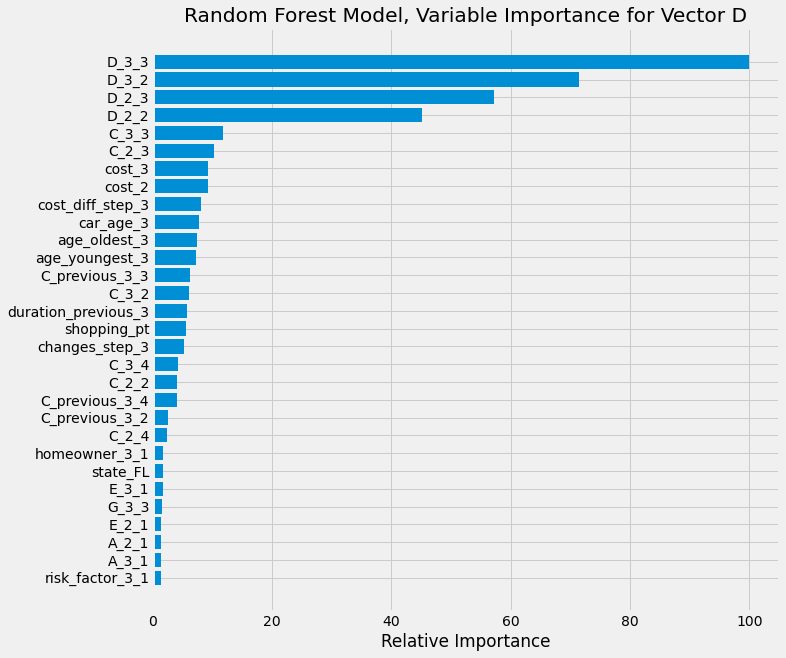

In [195]:
#Let's plot the best model for D using Random Forest Classifier (Iteration 32)

rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=600, min_samples_leaf = 1, min_samples_split = 5, plot=True)

XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 200,  max_depth = 1,     learning_rate = 0.3, colsample_bytree = 1
Accuracy=0.9078, f1-score=0.9088
Confusion Matrix - normalized
 [[0.907  0.0478 0.0452]
 [0.0687 0.8495 0.0818]
 [0.0261 0.0448 0.9291]]
Confusion Matrix
 [[1745   92   87]
 [ 232 2867  276]
 [ 244  418 8670]]

Classification Report 
               precision    recall  f1-score   support

           0       0.79      0.91      0.84      1924
           1       0.85      0.85      0.85      3375
           2       0.96      0.93      0.94      9332

    accuracy                           0.91     14631
   macro avg       0.86      0.90      0.88     14631
weighted avg       0.91      0.91      0.91     14631

30


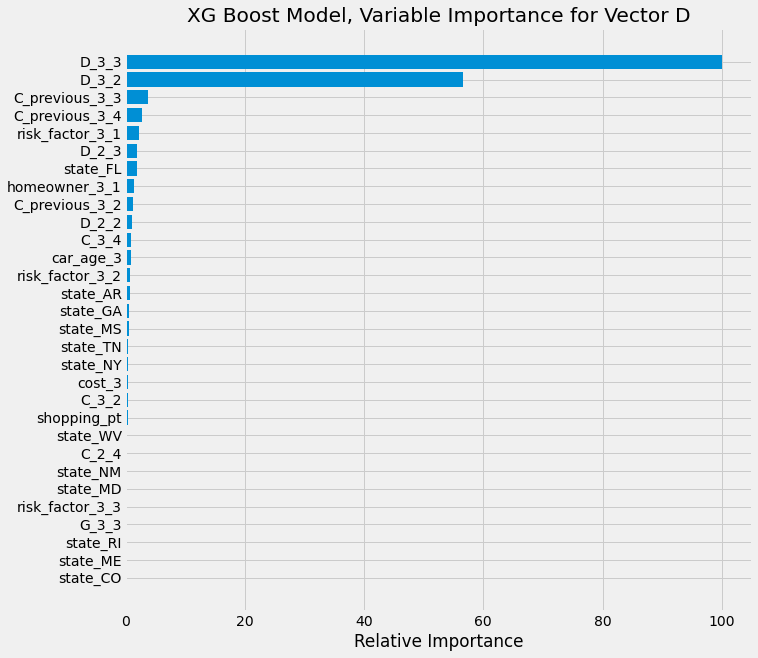

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.905 total time=   5.7s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.908 total time=   5.6s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.905 total time=   5.5s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.909 total time=   5.5s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.904 total time=   3.6s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.909 total time=   3.6s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.907 total time=   3.6s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.910 total time=  

[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=200;, score=0.909 total time=  10.9s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=200;, score=0.905 total time=  11.1s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=5, n_estimators=200;, score=0.909 total time=  11.0s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.907 total time=   3.5s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.910 total time=   3.5s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.908 total time=   3.5s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.5, max_depth=3, n_estimators=100;, score=0.911 total time=   3.6s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.3, max_depth=5, n_estimators=400;, score=0.905 total time=  21.7s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.3

[CV 4/4] END colsample_bytree=0.25, learning_rate=0.35, max_depth=5, n_estimators=100;, score=0.910 total time=   4.6s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.905 total time=   9.4s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.909 total time=   9.3s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.907 total time=   9.4s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.910 total time=   9.3s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.3, max_depth=5, n_estimators=500;, score=0.904 total time=  27.6s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.3, max_depth=5, n_estimators=500;, score=0.908 total time=  27.8s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.3, max_depth=5, n_estimators=500;, score=0.903 total time=  27.1s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.3, 

[CV 2/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=5, n_estimators=200;, score=0.909 total time=   7.0s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=5, n_estimators=200;, score=0.905 total time=   7.0s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=5, n_estimators=200;, score=0.910 total time=   7.3s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.904 total time=   3.6s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.909 total time=   3.7s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.905 total time=   3.6s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.910 total time=   3.5s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=3, n_estimators=300;, score=0.906 total time=  10.4s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.

In [168]:
#Let's predict D using XG Boost Classifier and use RandomizedSearchCV to find the best XGB classifier Hyperparamters 

vector = 'D'
xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=200, max_depth = 1, learning_rate = 0.3, colsample_bytree = 1, plot = True)

results = xgb_randomsearch(vector, 60)

datapath="Modelling_data/quotes_2_3"
filename3 = 'xgboost_results_q2_q3_vector'+vector+'.csv'
save_file(results, filename3, datapath)

In [169]:
# Find scores for the test set
vector = 'D'
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], xg_probs = xg_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                max_depth = int(max_depth), learning_rate = learning_rate, \
                                                                colsample_bytree = colsample_bytree, plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
filename4 = 'xgboost_results_q2_q3_vector'+vector+'_final.csv'
save_file(results, filename4, datapath)

XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 100,  max_depth = 5,     learning_rate = 0.5, colsample_bytree = 0.35
Accuracy=0.9076, f1-score=0.9082
XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 100,  max_depth = 5,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.9081, f1-score=0.9089
XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 300,  max_depth = 5,     learning_rate = 0.3, colsample_bytree = 0.35
Accuracy=0.9067, f1-score=0.9073
XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 200,  max_depth = 4,     learning_rate = 0.35, colsample_bytree = 0.25
Accuracy=0.9075, f1-score=0.9081
XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 300,  max_depth = 5,     learning_rate = 0.5, colsample_bytree = 0.35
Accuracy=0.9041, f1-score=0.9046
XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 300,  max_depth = 3,     learning_rate = 0.3, colsam

XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 300,  max_depth = 4,     learning_rate = 0.5, colsample_bytree = 0.15
Accuracy=0.9053, f1-score=0.9059
XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 300,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.9083, f1-score=0.909
XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 500,  max_depth = 4,     learning_rate = 0.5, colsample_bytree = 0.15
Accuracy=0.9042, f1-score=0.9048
XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 100,  max_depth = 5,     learning_rate = 0.35, colsample_bytree = 0.15
Accuracy=0.9083, f1-score=0.9091
XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 400,  max_depth = 4,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.907, f1-score=0.9076
XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 200,  max_depth = 5,     learning_rate = 0.35, colsam

In [170]:
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            100          5           0.50              0.35     0.906854   
1            100          5           0.30              0.15     0.907435   
2            300          5           0.30              0.35     0.906598   
3            200          4           0.35              0.25     0.907640   
4            300          5           0.50              0.35     0.903317   
5            300          3           0.30              0.25     0.908221   
6            100          4           0.50              0.25     0.908016   
7            500          3           0.25              0.25     0.908016   
8            400          4           0.25              0.15     0.907828   
9            100          5           0.30              0.25     0.908477   
10           400          5           0.50              0.25     0.902138   
11           100          5           0.25              0.50     0.908272   
12           300          4           0.50              0.50     0.904428   
13           400          4           0.35              0.50     0.906085   
14           300          4           0.35              0.25     0.906888   
15           100          5           0.35              0.50     0.907708   
16           200          4           0.25              0.25     0.908187   
17           200          5           0.35              0.35     0.906700   
18           100          3           0.50              0.35     0.908973   
19           400          5           0.30              0.35     0.905863   
20           500          4           0.50              0.25     0.902787   
21           200          3           0.30              0.15     0.908187   
22           500          3           0.35              0.25     0.907452   
23           200          4           0.25              0.50     0.907948   
24           500          5           0.50              0.50     0.900873   
25           500          4           0.35              0.50     0.905060   
26           500          3           0.50              0.35     0.905709   
27           500          5           0.25              0.25     0.905658   
28           200          5           0.50              0.50     0.904171   
29           200          3           0.50              0.35     0.907965   
30           400          5           0.35              0.15     0.905709   
31           100          3           0.50              0.15     0.907931   
32           500          4           0.35              0.25     0.904991   
33           400          4           0.35              0.15     0.906632   
34           100          5           0.35              0.25     0.907965   
35           400          3           0.30              0.15     0.907708   
36           500          5           0.30              0.35     0.905179   
37           400          5           0.25              0.15     0.906786   
38           400          4           0.25              0.50     0.907025   
39           200          3           0.50              0.50     0.907264   
40           200          4           0.50              0.35     0.906598   
41           400          3           0.35              0.15     0.908016   
42           200          4           0.35              0.50     0.907418   
43           100          4           0.35              0.50     0.908699   
44           200          3           0.30              0.35     0.908699   
45           300          3           0.25              0.25     0.908512   
46           200          4           0.25              0.35     0.908324   
47           300          4           0.50              0.15     0.905641   
48           300          3           0.25              0.50     0.908255   
49           500          4           0.50              0.15     0.903607   
50           100          5           0.35              0.15     0.907606   


XGBoost Classifier results for Vector D
Parameters: No. of Estimators = 100,  max_depth = 5,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.9088, f1-score=0.9095
Confusion Matrix - normalized
 [[0.895  0.0478 0.0572]
 [0.0655 0.8474 0.0871]
 [0.0219 0.0443 0.9339]]
Confusion Matrix
 [[1722   92  110]
 [ 221 2860  294]
 [ 204  413 8715]]

Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.90      0.85      1924
           1       0.85      0.85      0.85      3375
           2       0.96      0.93      0.94      9332

    accuracy                           0.91     14631
   macro avg       0.87      0.89      0.88     14631
weighted avg       0.91      0.91      0.91     14631

30


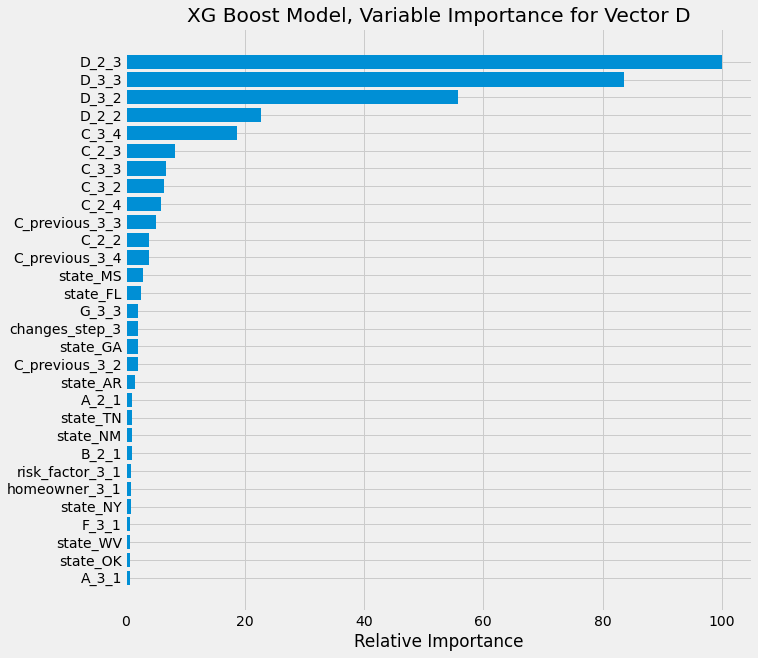

In [171]:
#Let's plot the best model for D using XG Boost Classifier (Iteration 9)

xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=100, max_depth = 5, learning_rate = 0.3, colsample_bytree = 0.25, plot = True)

# Quote 2 & 3: Predict E

In [172]:
vector = 'E'
last_quote = 3
test_set = df_hist_2_3.iloc[y_test.index,:]
x = pd.crosstab(test_set[vector], test_set[vector+'_'+str(last_quote)])
same_as_3 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
print(f"Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_test.shape[0]): 4.4}")
print(f"Confusion_Matrix")
x['total'] = x.sum(axis=1)
x['E0_%'] = np.around(x[0]/ x['total'], 4)
x['E1_%'] = np.around(x[1]/ x['total'], 4)
x

Accuracy based on simply predicting vector E = E_3 :  0.8911
Confusion_Matrix


E_3     0     1  total    E0_%    E1_%
E                                     
0    7226   668   7894  0.9154  0.0846
1     925  5812   6737  0.1373  0.8627

In [178]:
vector = 'E'
last_quote = 3
test_set2 = df_hist_2_3.iloc[y_train.index,:]
x2 = pd.crosstab(test_set2[vector], test_set2[vector+'_'+str(last_quote)])
same_as_3 = [x2.iloc[idx,idx] for idx in range(x2.shape[0])] 
print(f"TRAINING Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_train.shape[0]): 4.4}")
print(f"Confusion_Matrix - TRAINING")
x2['total'] = x2.sum(axis=1)
x2['E0_%'] = np.around(x2[0]/ x2['total'], 4)
x2['E1_%'] = np.around(x2[1]/ x2['total'], 4)
x2

TRAINING Accuracy based on simply predicting vector E = E_3 :  0.8887
Confusion_Matrix - TRAINING


E_3      0      1  total    E0_%    E1_%
E                                       
0    28717   2715  31432  0.9136  0.0864
1     3799  23290  27089  0.1402  0.8598

Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8912, f1-score=0.891
Confusion Matrix - normalized
 [[0.9151 0.0849]
 [0.1369 0.8631]]
Confusion Matrix
 [[7224  670]
 [ 922 5815]]

Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      7894
           1       0.90      0.86      0.88      6737

    accuracy                           0.89     14631
   macro avg       0.89      0.89      0.89     14631
weighted avg       0.89      0.89      0.89     14631

30


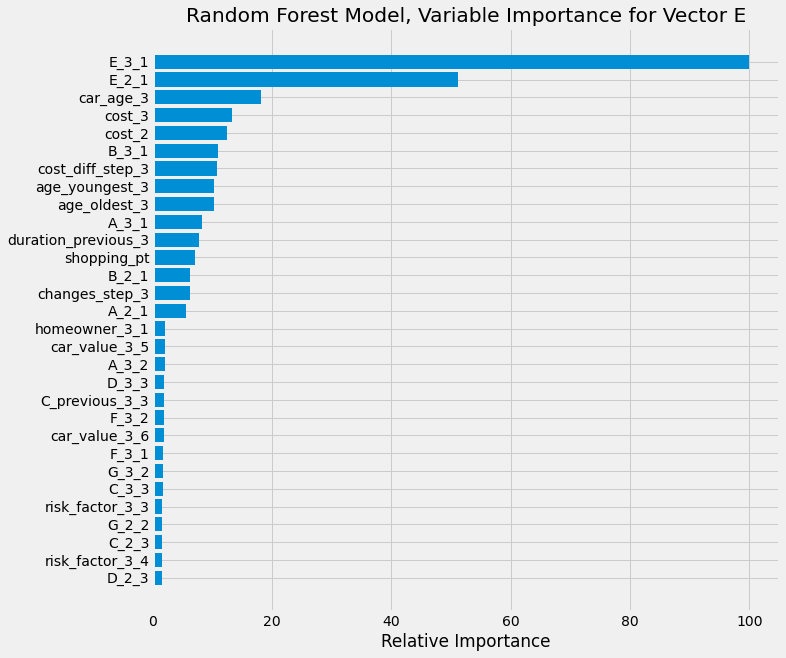

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.887 total time=  18.2s
[CV 2/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.893 total time=   7.7s
[CV 3/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.886 total time=   8.0s
[CV 4/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.889 total time=   8.1s
[CV 1/4] END min_samples_leaf=1, min_samples_split=4, n_estimators=500;, score=0.887 total time=  19.1s
[CV 2/4] END min_samples_leaf=1, min_samples_split=4, n_estimators=500;, score=0.894 total time=  19.4s
[CV 3/4] END min_samples_leaf=1, min_samples_split=4, n_estimators=500;, score=0.886 total time=  18.2s
[CV 4/4] END min_samples_leaf=1, min_samples_split=4, n_estimators=500;, score=0.889 total time=  18.5s
[CV 1/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=0.887 total time=  21.1s
[C

[CV 4/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=200;, score=0.889 total time=   6.1s
[CV 1/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=0.887 total time=  17.4s
[CV 2/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=0.893 total time=  17.3s
[CV 3/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=0.886 total time=  17.4s
[CV 4/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=0.889 total time=  17.8s
[CV 1/4] END min_samples_leaf=1, min_samples_split=3, n_estimators=800;, score=0.887 total time=  25.2s
[CV 2/4] END min_samples_leaf=1, min_samples_split=3, n_estimators=800;, score=0.894 total time=  25.2s
[CV 3/4] END min_samples_leaf=1, min_samples_split=3, n_estimators=800;, score=0.886 total time=  25.2s
[CV 4/4] END min_samples_leaf=1, min_samples_split=3, n_estimators=800;, score=0.889 total time=  25.5s
[CV 1/4] END min_samples_leaf=1, min_samples_split=2, n_estimato

[CV 3/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=200;, score=0.886 total time=   6.2s
[CV 4/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=200;, score=0.889 total time=   6.2s
[CV 1/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=0.887 total time=  23.7s
[CV 2/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=0.893 total time=  24.4s
[CV 3/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=0.886 total time=  24.3s
[CV 4/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=0.889 total time=  24.4s
[CV 1/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=300;, score=0.887 total time=   8.9s
[CV 2/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=300;, score=0.894 total time=   8.9s
[CV 3/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=300;, score=0.886 total time=   9.0s
[CV 4/4] END min_samples_leaf=4, min_samples_split=4, n_estimato

[CV 2/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=0.894 total time=   8.6s
[CV 3/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=0.886 total time=   9.1s
[CV 4/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=0.889 total time=   8.8s
Vector E RandomizedSearchCV: Random Forest Model
Best Score:0.8890484046061244
Best Parameters: {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1}
Writing file.  "Modelling_data/quotes_2_3\rf_results_q2_q3_vectorE.csv"


In [173]:
# RF Classifier: Predict E using quotes 2 and 3 and then RandomizedSearchCV to find best hyperparameters

vector = 'E'

rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, min_samples_split = 2, plot=True)

results = rf_randomsearch(vector, 60)

datapath="Modelling_data/quotes_2_3"
filename1 = 'rf_results_q2_q3_vector'+vector+'.csv'
save_file(results, filename1, datapath)

In [174]:
# Get scores for test set
vector = 'E'

for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    min_samples_leaf = row['min_samples_leaf']
    min_samples_split = row['min_samples_split']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], rf_probs = rf_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                min_samples_leaf = int(min_samples_leaf), \
                                                                min_samples_split = int(min_samples_split), plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
filename2 = 'rf_results_q2_q3_vector'+vector+'_final.csv'
save_file(results, filename2, datapath)

Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 200,  min_samples_leaf = 2,     min_samples_split = 2
Accuracy=0.8913, f1-score=0.8911
Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 500,  min_samples_leaf = 1,     min_samples_split = 4
Accuracy=0.8913, f1-score=0.8911
Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 600,  min_samples_leaf = 4,     min_samples_split = 5
Accuracy=0.8913, f1-score=0.8911
Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 600,  min_samples_leaf = 4,     min_samples_split = 4
Accuracy=0.8913, f1-score=0.8911
Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 100,  min_samples_leaf = 3,     min_samples_split = 5
Accuracy=0.8914, f1-score=0.8912
Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 700,  min_samples_leaf = 3,     min_samples_split = 4
Accuracy=0.8914, f1-score=0.8912
Random For

Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 200,  min_samples_leaf = 4,     min_samples_split = 2
Accuracy=0.8912, f1-score=0.891
Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 100,  min_samples_leaf = 3,     min_samples_split = 3
Accuracy=0.8914, f1-score=0.8912
Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 100,  min_samples_leaf = 2,     min_samples_split = 5
Accuracy=0.8913, f1-score=0.8911
Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 100,  min_samples_leaf = 2,     min_samples_split = 4
Accuracy=0.8911, f1-score=0.8909
Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 500,  min_samples_leaf = 2,     min_samples_split = 4
Accuracy=0.8912, f1-score=0.891
Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 500,  min_samples_leaf = 4,     min_samples_split = 4
Accuracy=0.8912, f1-score=0.891
Random Forest

In [196]:
results_E_rf = pd.read_csv("Modelling_data/quotes_2_3/rf_results_q2_q3_vectorE_final.csv")
results_E_rf

n_estimators  min_samples_split  min_samples_leaf  train_score  \
0            200                  2                 2     0.888843   
1            500                  4                 1     0.888946   
2            600                  5                 4     0.888724   
3            600                  4                 4     0.888724   
4            100                  5                 3     0.888878   
5            700                  4                 3     0.888860   
6            600                  5                 1     0.888997   
7            300                  4                 1     0.888980   
8            700                  4                 2     0.888809   
9            500                  3                 3     0.888843   
10           600                  4                 2     0.888826   
11           300                  5                 2     0.888758   
12           500                  4                 3     0.888843   
13           400                  2                 3     0.888878   
14           300                  4                 3     0.888826   
15           200                  5                 3     0.888843   
16           700                  5                 1     0.889014   
17           800                  4                 4     0.888792   
18           500                  3                 4     0.888775   
19           200                  4                 4     0.888826   
20           600                  2                 4     0.888724   
21           800                  3                 1     0.888963   
22           800                  2                 1     0.888843   
23           500                  5                 4     0.888775   
24           800                  4                 2     0.888792   
25           700                  3                 4     0.888775   
26           600                  3                 3     0.888912   
27           300                  3                 2     0.888809   
28           300                  3                 1     0.889048   
29           500                  2                 1     0.888912   
30           200                  5                 2     0.888860   
31           200                  3                 3     0.888843   
32           400                  3                 4     0.888775   
33           400                  5                 3     0.888878   
34           100                  2                 1     0.888792   
35           300                  3                 3     0.888826   
36           100                  4                 1     0.888912   
37           400                  2                 1     0.888912   
38           800                  3                 2     0.888792   
39           200                  4                 2     0.888843   
40           800                  5                 2     0.888758   
41           300                  4                 4     0.888826   
42           100                  3                 4     0.888843   
43           400                  2                 2     0.888860   
44           400                  4                 1     0.888963   
45           200                  5                 1     0.888912   
46           100                  5                 4     0.888843   
47           100                  4                 3     0.888878   
48           500                  3                 1     0.888946   
49           500                  2                 4     0.888775   
50           200                  2                 4     0.888826   
51           100                  3                 3     0.888878   
52           100                  5                 2     0.888912   
53           100                  4                 2     0.888741   
54           500                  4                 2     0.888792   
55           500                  4                 4     0.888775   
56           6

Random Forest Classifier results for Vector E
Parameters: No. of Estimators = 600,  min_samples_leaf = 1,     min_samples_split = 5
Accuracy=0.8914, f1-score=0.8912
Confusion Matrix - normalized
 [[0.9154 0.0846]
 [0.1367 0.8633]]
Confusion Matrix
 [[7226  668]
 [ 921 5816]]

Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      7894
           1       0.90      0.86      0.88      6737

    accuracy                           0.89     14631
   macro avg       0.89      0.89      0.89     14631
weighted avg       0.89      0.89      0.89     14631

30


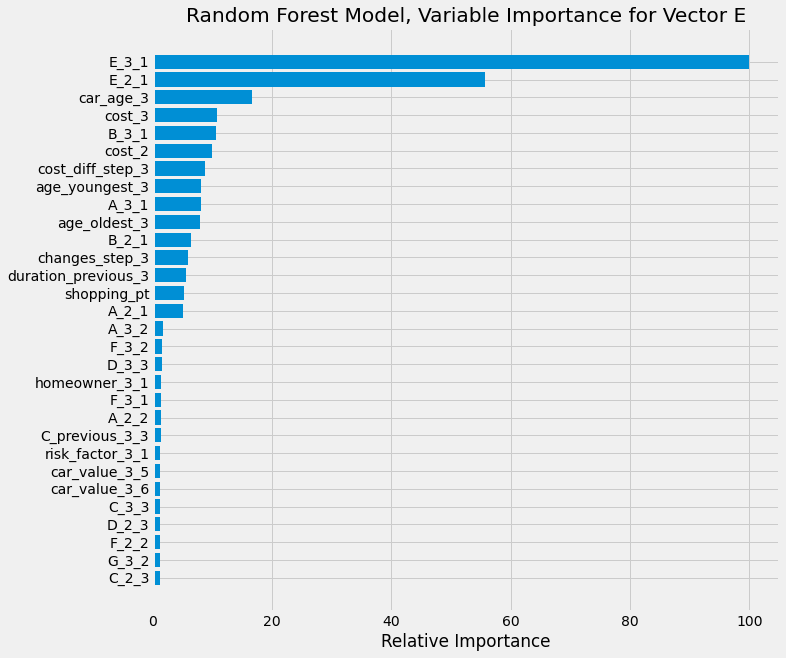

In [201]:
#Let's plot the best model for E using Random Forest Classifier (Iteration 6)
vector = 'E'
rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=600, min_samples_leaf = 1, min_samples_split = 5, plot=True)

XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 200,  max_depth = 1,     learning_rate = 0.3, colsample_bytree = 1
Accuracy=0.8915, f1-score=0.8913
Confusion Matrix - normalized
 [[0.9164 0.0836]
 [0.1377 0.8623]]
Confusion Matrix
 [[7234  660]
 [ 928 5809]]

Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      7894
           1       0.90      0.86      0.88      6737

    accuracy                           0.89     14631
   macro avg       0.89      0.89      0.89     14631
weighted avg       0.89      0.89      0.89     14631

30


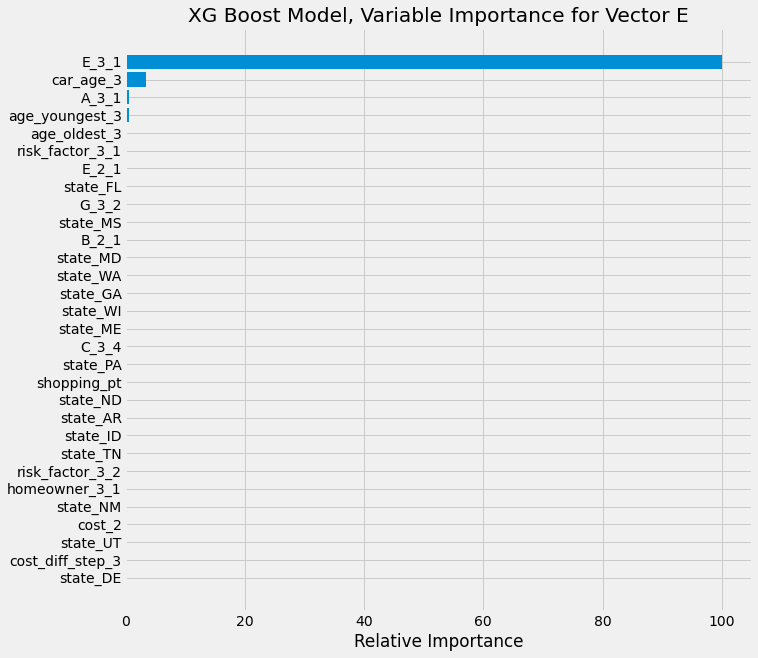

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=100;, score=0.887 total time=   1.4s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=100;, score=0.892 total time=   1.4s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=100;, score=0.886 total time=   1.4s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=3, n_estimators=100;, score=0.888 total time=   1.2s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.884 total time=   3.7s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.892 total time=   3.9s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.886 total time=   3.7s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=5, n_estimators=200;, score=0.887 total tim

[CV 2/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.890 total time=  11.1s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.883 total time=  11.4s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=500;, score=0.885 total time=  11.0s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.883 total time=   8.9s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.890 total time=   8.9s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.884 total time=   8.9s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, n_estimators=400;, score=0.886 total time=   8.9s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=4, n_estimators=500;, score=0.884 total time=   6.5s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.35, max_de

[CV 4/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=5, n_estimators=100;, score=0.886 total time=   2.9s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=5, n_estimators=300;, score=0.883 total time=   4.5s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=5, n_estimators=300;, score=0.889 total time=   4.4s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=5, n_estimators=300;, score=0.882 total time=   4.5s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=5, n_estimators=300;, score=0.884 total time=   4.5s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.886 total time=   2.2s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.893 total time=   2.2s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.886 total time=   2.2s
[CV 4/4] END colsample_bytree=0.35, learning_rate=

[CV 2/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=3, n_estimators=500;, score=0.890 total time=   6.4s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=3, n_estimators=500;, score=0.882 total time=   6.4s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.5, max_depth=3, n_estimators=500;, score=0.885 total time=   6.5s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=3, n_estimators=300;, score=0.883 total time=   3.3s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=3, n_estimators=300;, score=0.892 total time=   3.3s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=3, n_estimators=300;, score=0.886 total time=   3.3s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.5, max_depth=3, n_estimators=300;, score=0.887 total time=   3.3s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.35, max_depth=3, n_estimators=200;, score=0.885 total time=   2.2s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.35,

In [175]:
#Let's predict E using XG Boost Classifier and use RandomizedSearchCV to find the best XGB classifier Hyperparamters 

vector = 'E'
xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=200, max_depth = 1, learning_rate = 0.3, colsample_bytree = 1, plot = True)

results = xgb_randomsearch(vector, 60)

datapath="Modelling_data/quotes_2_3"
filename3 = 'xgboost_results_q2_q3_vector'+vector+'.csv'
save_file(results, filename3, datapath)

In [176]:
# Find scores for the test set
vector = 'E'
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], xg_probs = xg_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                max_depth = int(max_depth), learning_rate = learning_rate, \
                                                                colsample_bytree = colsample_bytree, plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
filename4 = 'xgboost_results_q2_q3_vector'+vector+'_final.csv'
save_file(results, filename4, datapath)

XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 100,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.8915, f1-score=0.8913
XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 200,  max_depth = 5,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.8906, f1-score=0.8905
XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 500,  max_depth = 3,     learning_rate = 0.3, colsample_bytree = 0.25
Accuracy=0.8905, f1-score=0.8903
XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 500,  max_depth = 3,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8911, f1-score=0.8909
XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 500,  max_depth = 5,     learning_rate = 0.35, colsample_bytree = 0.15
Accuracy=0.8873, f1-score=0.8871
XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.25, cols

XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 200,  max_depth = 5,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.8904, f1-score=0.8902
XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 200,  max_depth = 5,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.8903, f1-score=0.8901
XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 100,  max_depth = 3,     learning_rate = 0.35, colsample_bytree = 0.25
Accuracy=0.8915, f1-score=0.8913
XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 400,  max_depth = 5,     learning_rate = 0.25, colsample_bytree = 0.15
Accuracy=0.8896, f1-score=0.8894
XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 500,  max_depth = 3,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.8908, f1-score=0.8906
XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 500,  max_depth = 3,     learning_rate = 0.5, colsamp

In [177]:
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            100          3           0.25              0.25     0.888502   
1            200          5           0.30              0.25     0.886998   
2            500          3           0.30              0.25     0.887733   
3            500          3           0.30              0.15     0.887904   
4            500          5           0.35              0.15     0.882384   
5            200          3           0.25              0.25     0.888707   
6            100          5           0.30              0.25     0.887938   
7            400          4           0.30              0.35     0.885870   
8            400          4           0.35              0.25     0.885716   
9            100          3           0.30              0.35     0.888707   
10           500          3           0.35              0.50     0.886588   
11           500          4           0.25              0.15     0.887271   
12           300          5           0.50              0.50     0.878522   
13           200          3           0.35              0.50     0.887921   
14           500          5           0.25              0.50     0.883700   
15           400          5           0.30              0.35     0.884076   
16           400          4           0.30              0.15     0.887015   
17           500          4           0.30              0.50     0.885033   
18           400          4           0.30              0.50     0.885716   
19           500          4           0.35              0.15     0.886212   
20           200          4           0.50              0.15     0.885562   
21           300          4           0.35              0.35     0.885938   
22           200          4           0.50              0.35     0.885169   
23           400          3           0.35              0.15     0.887938   
24           300          4           0.50              0.15     0.884161   
25           500          5           0.50              0.35     0.874883   
26           300          4           0.30              0.50     0.886554   
27           300          3           0.35              0.35     0.887237   
28           200          3           0.50              0.35     0.886639   
29           500          3           0.25              0.25     0.888006   
30           400          5           0.35              0.35     0.881735   
31           100          4           0.30              0.50     0.888399   
32           200          5           0.35              0.50     0.885016   
33           200          4           0.30              0.50     0.887647   
34           100          5           0.50              0.50     0.885135   
35           300          5           0.35              0.15     0.884708   
36           100          5           0.25              0.35     0.888091   
37           200          5           0.25              0.25     0.887476   
38           500          3           0.50              0.15     0.885904   
39           100          4           0.25              0.35     0.888399   
40           100          3           0.25              0.50     0.888912   
41           400          4           0.35              0.15     0.886656   
42           400          3           0.25              0.15     0.888194   
43           300          3           0.25              0.50     0.888638   
44           200          5           0.50              0.15     0.883632   
45           300          3           0.30              0.25     0.888194   
46           300          4           0.25              0.15     0.887938   
47           200          5           0.25              0.50     0.887169   
48           200          5           0.30              0.50     0.885938   
49           100          3           0.35              0.25     0.888314   
50           400          5           0.25              0.15     0.886143   


XGBoost Classifier results for Vector E
Parameters: No. of Estimators = 100,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.8914, f1-score=0.8912
Confusion Matrix - normalized
 [[0.9172 0.0828]
 [0.1388 0.8612]]
Confusion Matrix
 [[7240  654]
 [ 935 5802]]

Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      7894
           1       0.90      0.86      0.88      6737

    accuracy                           0.89     14631
   macro avg       0.89      0.89      0.89     14631
weighted avg       0.89      0.89      0.89     14631

30


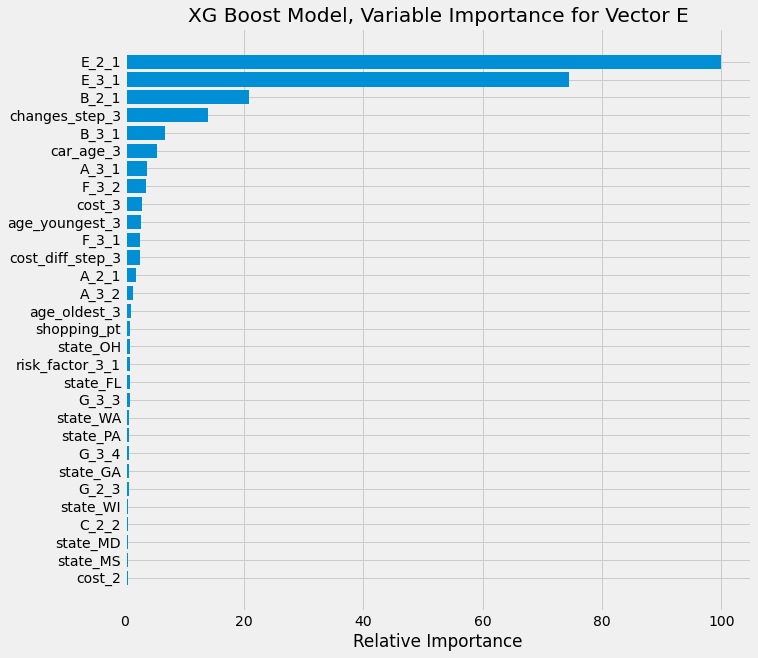

In [200]:
#Let's plot the best model for E using XG Boost Classifier (Iteration 40, overall rank 1)

xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=100, max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.5, plot = True)

In [199]:
# Let's use Logistics Regression to predict vector E

vector = 'E'
lr_ac, lr_f1, lr_probs = lr_predict_plot(vector)

Logistic Regression for vector E
Accuracy = 0.8911, f1-score = 0.8909

Confusion Matrix - normalized
 [[0.9154 0.0846]
 [0.1373 0.8627]]
Confusion Matrix
 [[7226  668]
 [ 925 5812]]

Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      7894
           1       0.90      0.86      0.88      6737

    accuracy                           0.89     14631
   macro avg       0.89      0.89      0.89     14631
weighted avg       0.89      0.89      0.89     14631


Area under ROC: 
 0.9254818906545571


C:\Users\amite\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [202]:
vector = 'E'

fpr_1, tpr_1, thresholds_1 = roc_curve(y_test[vector].astype('int'), rf_probs)
roc_auc1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, thresholds_2 = roc_curve(y_test[vector].astype('int'), xg_probs)
roc_auc2 = auc(fpr_2, tpr_2)

fpr_3, tpr_3, thresholds_3 = roc_curve(y_test[vector].astype('int'), lr_probs)
roc_auc3 = auc(fpr_3, tpr_3)

roc_auc1, roc_auc2, roc_auc3

(0.9283730728726803, 0.9299934838705771, 0.9254818906545571)

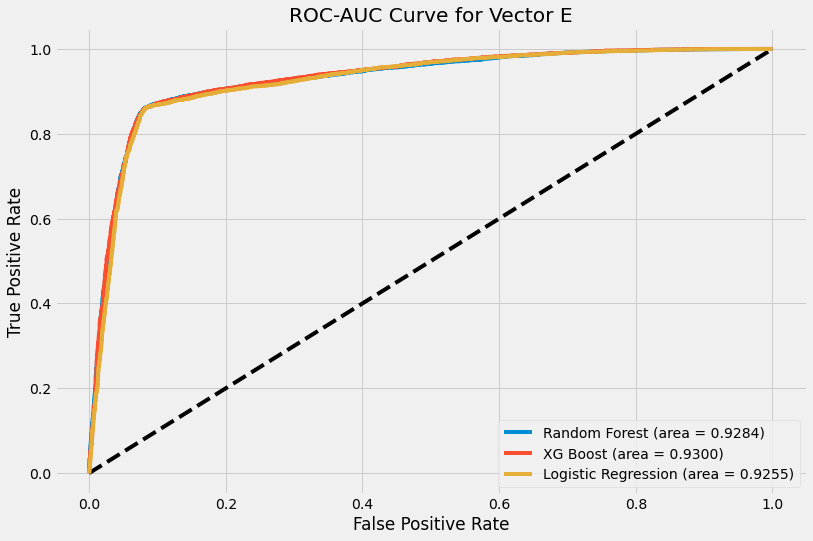

In [203]:
# Let's plot the ROC curve for all the models for vector E
vector = 'E'
plt.figure(figsize=(12,8))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Random Forest (area = 0.9284)')
plt.plot(fpr_2, tpr_2, label='XG Boost (area = 0.9300)')
plt.plot(fpr_3, tpr_3, label='Logistic Regression (area = 0.9255)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Vector '+vector)
plt.legend()
plt.show()

Vector E Logistic Regression Model
Best Accuracy score of 0.8913 occurs for threshold = 0.53
Vector E Random Forest Model
Best Accuracy score of 0.8919 occurs for threshold = 0.557
Vector E XG Boost Model
Best Accuracy score of 0.8915 occurs for threshold = 0.529


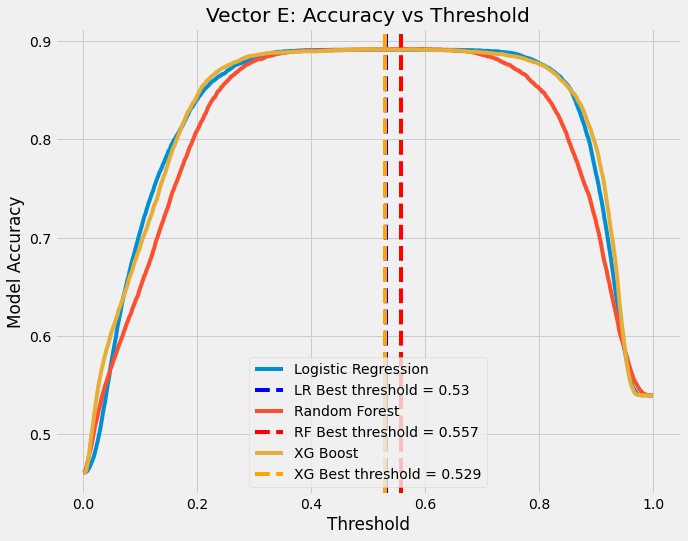

In [204]:
# We are concerned with accuracy of the model i.e. its ability to predict both the 0 and 1 labels correctly
# So we will calculate the accuracy score at different thresholds directly
vector = 'E'
plt.figure(figsize=(10,8))

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = np.arange(0, 1, 0.001)

# for LR model
ac_score_lr = [accuracy_score(y_test[vector].astype('int'), to_labels(lr_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_lr)
print(f"Vector {vector} Logistic Regression Model\nBest Accuracy score of {ac_score_lr[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_lr, label='Logistic Regression')
plt.axvline(thresholds[idx], color='blue', linestyle="--", label = "LR Best threshold = "+str(np.round(thresholds[idx],4)))

# for random forest
thresholds = np.arange(0, 1, 0.001)
ac_score_rf = [accuracy_score(y_test[vector].astype('int'), to_labels(rf_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_rf)
print(f"Vector {vector} Random Forest Model\nBest Accuracy score of {ac_score_rf[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_rf, label='Random Forest')
plt.axvline(thresholds[idx], color='red', linestyle="--", label = "RF Best threshold = "+str(np.round(thresholds[idx],4)))

# for XG Boost
thresholds = np.arange(0, 1, 0.001)
ac_score_xg = [accuracy_score(y_test[vector].astype('int'), to_labels(xg_probs, t)) for t in thresholds]
idx = np.argmax(ac_score_xg)
print(f"Vector {vector} XG Boost Model\nBest Accuracy score of {ac_score_xg[idx]:4.4} occurs for threshold = {thresholds[idx]:4.4}")
plt.plot(thresholds, ac_score_xg, label='XG Boost')
plt.axvline(thresholds[idx], color='orange', linestyle="--", label = "XG Best threshold = "+str(np.round(thresholds[idx],4)))

plt.xlabel('Threshold')
plt.ylabel('Model Accuracy')
plt.title('Vector E: Accuracy vs Threshold')

plt.legend()
plt.show()

# Quote 2 & 3: Predict F

In [182]:
vector = 'F'
last_quote = 3

test_set = df_hist_2_3.iloc[y_test.index,:]

x = pd.crosstab(test_set[vector], test_set[vector+'_'+str(last_quote)])

same_as_3 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_test.shape[0]): 4.4}")
print(f"Confusion_Matrix")

x['total'] = x.sum(axis=1)
x['F0_%'] = np.around(x[0]/ x['total'], 4)
x['F1_%'] = np.around(x[1]/ x['total'], 4)
x['F2_%'] = np.around(x[2]/ x['total'], 4)
x['F3_%'] = np.around(x[3]/ x['total'], 4)
x

Accuracy based on simply predicting vector F = F_3 :  0.8738
Confusion_Matrix


F_3     0     1     2    3  total    F0_%    F1_%    F2_%    F3_%
F                                                                
0    4388    88   239   22   4737  0.9263  0.0186  0.0505  0.0046
1     134  3018   412   40   3604  0.0372  0.8374  0.1143  0.0111
2     226   275  4810  118   5429  0.0416  0.0507  0.8860  0.0217
3      40    41   211  569    861  0.0465  0.0476  0.2451  0.6609

In [181]:
vector = 'F'
last_quote = 3
test_set2 = df_hist_2_3.iloc[y_train.index,:]
x2 = pd.crosstab(test_set2[vector], test_set2[vector+'_'+str(last_quote)])
same_as_3 = [x2.iloc[idx,idx] for idx in range(x2.shape[0])] 
print(f"TRAINING Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_train.shape[0]): 4.4}")
print(f"Confusion_Matrix - TRAINING")
x2['total'] = x2.sum(axis=1)
x2['F0_%'] = np.around(x2[0]/ x2['total'], 4)
x2['F1_%'] = np.around(x2[1]/ x2['total'], 4)
x2['F2_%'] = np.around(x2[2]/ x2['total'], 4)
x2['F3_%'] = np.around(x2[3]/ x2['total'], 4)
x2

TRAINING Accuracy based on simply predicting vector F = F_3 :  0.8776
Confusion_Matrix - TRAINING


F_3      0      1      2     3  total    F0_%    F1_%    F2_%    F3_%
F                                                                    
0    17405    391    855   126  18777  0.9269  0.0208  0.0455  0.0067
1      497  12335   1545   128  14505  0.0343  0.8504  0.1065  0.0088
2      945   1183  19298   419  21845  0.0433  0.0542  0.8834  0.0192
3      176    132    764  2322   3394  0.0519  0.0389  0.2251  0.6841

Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8763, f1-score=0.8757
Confusion Matrix - normalized
 [[0.9255 0.019  0.0513 0.0042]
 [0.0305 0.838  0.1204 0.0111]
 [0.0337 0.0512 0.8932 0.0219]
 [0.0407 0.0476 0.252  0.6597]]
Confusion Matrix
 [[4384   90  243   20]
 [ 110 3020  434   40]
 [ 183  278 4849  119]
 [  35   41  217  568]]

Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      4737
           1       0.88      0.84      0.86      3604
           2       0.84      0.89      0.87      5429
           3       0.76      0.66      0.71       861

    accuracy                           0.88     14631
   macro avg       0.85      0.83      0.84     14631
weighted avg       0.88      0.88      0.88     14631

30


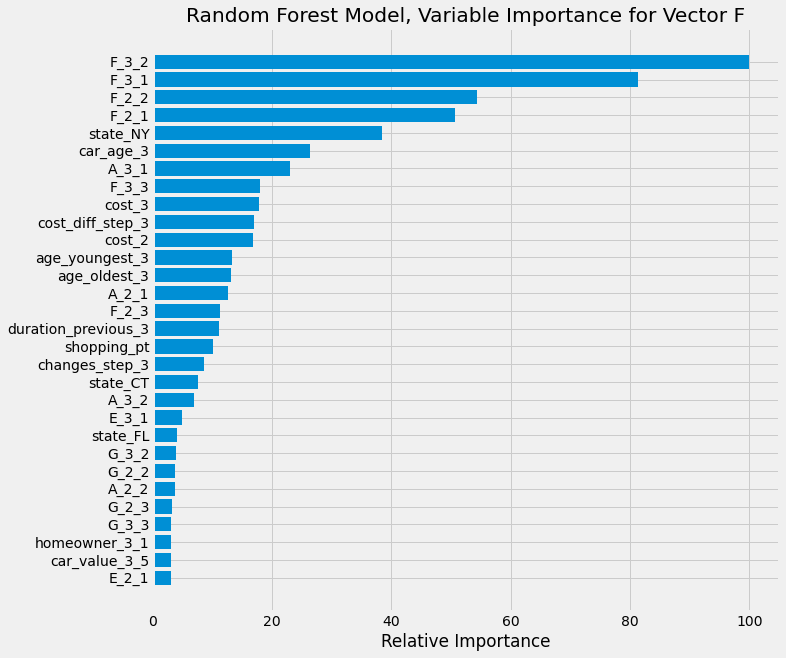

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=700;, score=0.879 total time=  36.3s
[CV 2/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=700;, score=0.878 total time=  25.6s
[CV 3/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=700;, score=0.879 total time=  26.6s
[CV 4/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=700;, score=0.882 total time=  25.1s
[CV 1/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.878 total time=  16.7s
[CV 2/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.878 total time=  16.6s
[CV 3/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.879 total time=  16.8s
[CV 4/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.881 total time=  16.0s
[CV 1/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.879 total time=  14.7s
[C

[CV 4/4] END min_samples_leaf=1, min_samples_split=3, n_estimators=100;, score=0.882 total time=   4.0s
[CV 1/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.879 total time=  16.8s
[CV 2/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.878 total time=  16.7s
[CV 3/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.879 total time=  16.7s
[CV 4/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=0.881 total time=  16.5s
[CV 1/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=400;, score=0.878 total time=  12.7s
[CV 2/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=400;, score=0.878 total time=  12.7s
[CV 3/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=400;, score=0.879 total time=  12.9s
[CV 4/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=400;, score=0.880 total time=  12.8s
[CV 1/4] END min_samples_leaf=3, min_samples_split=4, n_estimato

[CV 3/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.879 total time=  24.3s
[CV 4/4] END min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.881 total time=  24.3s
[CV 1/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=600;, score=0.878 total time=  20.4s
[CV 2/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=600;, score=0.878 total time=  21.1s
[CV 3/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=600;, score=0.879 total time=  20.1s
[CV 4/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=600;, score=0.881 total time=  21.1s
[CV 1/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.879 total time=   7.4s
[CV 2/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.878 total time=   7.4s
[CV 3/4] END min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.880 total time=   7.5s
[CV 4/4] END min_samples_leaf=1, min_samples_split=2, n_estimato

[CV 2/4] END min_samples_leaf=4, min_samples_split=3, n_estimators=200;, score=0.878 total time=   7.3s
[CV 3/4] END min_samples_leaf=4, min_samples_split=3, n_estimators=200;, score=0.878 total time=   7.0s
[CV 4/4] END min_samples_leaf=4, min_samples_split=3, n_estimators=200;, score=0.880 total time=   7.1s
Vector F RandomizedSearchCV: Random Forest Model
Best Score:0.8796500438469186
Best Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1}
Writing file.  "Modelling_data/quotes_2_3\rf_results_q2_q3_vectorF.csv"


In [183]:
# RF Classifier: Predict F using quotes 2 and 3 and then RandomizedSearchCV to find best hyperparameters

vector = 'F'

rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, min_samples_split = 2, plot=True)

results = rf_randomsearch(vector, 60)

datapath="Modelling_data/quotes_2_3"
filename1 = 'rf_results_q2_q3_vector'+vector+'.csv'
save_file(results, filename1, datapath)

In [206]:
# Get scores for test set
vector = 'F'

for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    min_samples_leaf = row['min_samples_leaf']
    min_samples_split = row['min_samples_split']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], rf_probs = rf_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                min_samples_leaf = int(min_samples_leaf), \
                                                                min_samples_split = int(min_samples_split), plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
filename2 = 'rf_results_q2_q3_vector'+vector+'_final.csv'
save_file(results, filename2, datapath)

Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 700,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8762, f1-score=0.8755
Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 500,  min_samples_leaf = 4,     min_samples_split = 2
Accuracy=0.8756, f1-score=0.8749
Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 400,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.876, f1-score=0.8754
Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 200,  min_samples_leaf = 3,     min_samples_split = 4
Accuracy=0.8759, f1-score=0.8752
Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 500,  min_samples_leaf = 1,     min_samples_split = 5
Accuracy=0.8763, f1-score=0.8757
Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 800,  min_samples_leaf = 1,     min_samples_split = 3
Accuracy=0.8763, f1-score=0.8757
Random Fore

Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 300,  min_samples_leaf = 3,     min_samples_split = 4
Accuracy=0.8757, f1-score=0.8751
Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 700,  min_samples_leaf = 1,     min_samples_split = 5
Accuracy=0.8762, f1-score=0.8755
Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 200,  min_samples_leaf = 1,     min_samples_split = 3
Accuracy=0.8763, f1-score=0.8756
Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 200,  min_samples_leaf = 3,     min_samples_split = 2
Accuracy=0.8759, f1-score=0.8752
Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 400,  min_samples_leaf = 2,     min_samples_split = 2
Accuracy=0.8758, f1-score=0.8752
Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 600,  min_samples_leaf = 4,     min_samples_split = 5
Accuracy=0.8756, f1-score=0.8749
Random For

In [207]:
results

n_estimators  min_samples_split  min_samples_leaf  train_score  \
0            700                  2                 1     0.879462   
1            500                  2                 4     0.878796   
2            400                  2                 1     0.879530   
3            200                  4                 3     0.878813   
4            500                  5                 1     0.879479   
5            800                  3                 1     0.879479   
6            300                  3                 1     0.879462   
7            200                  4                 4     0.878693   
8            100                  5                 4     0.878864   
9            700                  4                 4     0.878761   
10           400                  5                 4     0.878727   
11           200                  4                 2     0.879257   
12           400                  3                 3     0.878881   
13           300                  2                 3     0.878847   
14           500                  3                 4     0.878796   
15           300                  4                 2     0.879223   
16           400                  4                 3     0.878881   
17           800                  3                 3     0.878967   
18           600                  3                 4     0.878779   
19           100                  3                 1     0.879428   
20           500                  5                 2     0.879206   
21           400                  4                 4     0.878727   
22           500                  4                 3     0.878881   
23           100                  2                 4     0.878864   
24           300                  2                 4     0.878779   
25           100                  3                 4     0.878864   
26           600                  3                 1     0.879496   
27           800                  2                 2     0.879172   
28           300                  5                 3     0.878847   
29           800                  5                 2     0.879240   
30           100                  3                 3     0.879052   
31           200                  2                 2     0.879257   
32           400                  5                 2     0.879172   
33           300                  4                 1     0.879513   
34           600                  5                 2     0.879206   
35           800                  5                 1     0.879479   
36           600                  5                 3     0.878898   
37           300                  5                 4     0.878779   
38           400                  3                 1     0.879496   
39           700                  5                 2     0.879189   
40           600                  4                 3     0.878898   
41           200                  2                 1     0.879325   
42           200                  4                 1     0.879650   
43           800                  3                 2     0.879172   
44           600                  4                 1     0.879599   
45           200                  5                 4     0.878693   
46           200                  5                 2     0.879308   
47           400                  2                 4     0.878727   
48           500                  4                 2     0.879172   
49           400                  4                 2     0.879154   
50           300                  4                 3     0.878847   
51           700                  5                 1     0.879462   
52           200                  3                 1     0.879394   
53           200                  2                 3     0.878813   
54           400                  2                 2     0.879154   
55           600                  5                 4     0.878779   
56           8

Random Forest Classifier results for Vector F
Parameters: No. of Estimators = 800,  min_samples_leaf = 1,     min_samples_split = 5
Accuracy=0.8763, f1-score=0.8757
Confusion Matrix - normalized
 [[0.9255 0.0186 0.0515 0.0044]
 [0.0302 0.838  0.1207 0.0111]
 [0.0343 0.0507 0.8932 0.0219]
 [0.043  0.0476 0.2497 0.6597]]
Confusion Matrix
 [[4384   88  244   21]
 [ 109 3020  435   40]
 [ 186  275 4849  119]
 [  37   41  215  568]]

Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      4737
           1       0.88      0.84      0.86      3604
           2       0.84      0.89      0.87      5429
           3       0.76      0.66      0.71       861

    accuracy                           0.88     14631
   macro avg       0.85      0.83      0.84     14631
weighted avg       0.88      0.88      0.88     14631

30


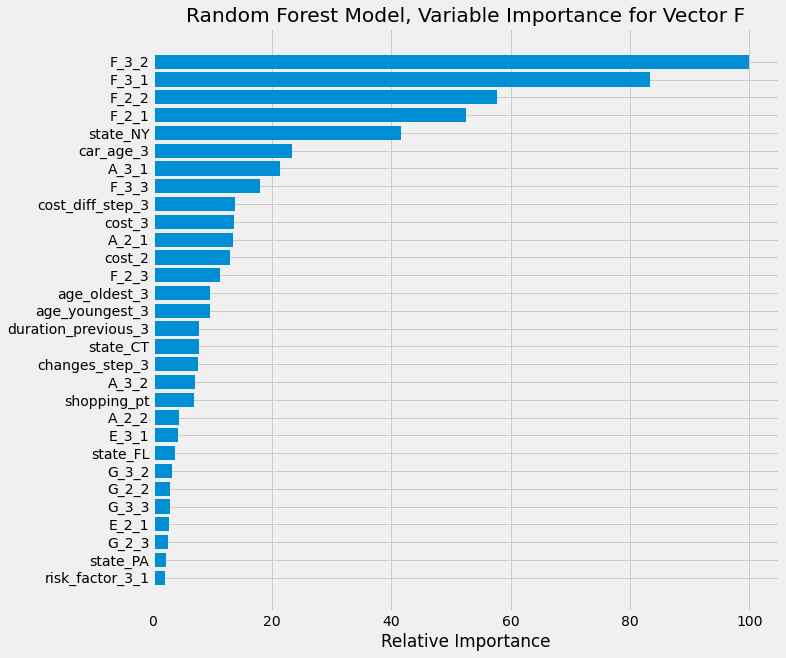

In [208]:
#Let's plot the best model for F using Random Forest Classifier (Iteration 35)

rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=800, min_samples_leaf = 1, min_samples_split = 5, plot=True)

XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 200,  max_depth = 1,     learning_rate = 0.3, colsample_bytree = 1
Accuracy=0.8763, f1-score=0.8756
Confusion Matrix - normalized
 [[0.9251 0.0182 0.0526 0.0042]
 [0.0308 0.8382 0.1199 0.0111]
 [0.0335 0.0512 0.8935 0.0217]
 [0.0418 0.0476 0.252  0.6585]]
Confusion Matrix
 [[4382   86  249   20]
 [ 111 3021  432   40]
 [ 182  278 4851  118]
 [  36   41  217  567]]

Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      4737
           1       0.88      0.84      0.86      3604
           2       0.84      0.89      0.87      5429
           3       0.76      0.66      0.71       861

    accuracy                           0.88     14631
   macro avg       0.85      0.83      0.84     14631
weighted avg       0.88      0.88      0.88     14631

30


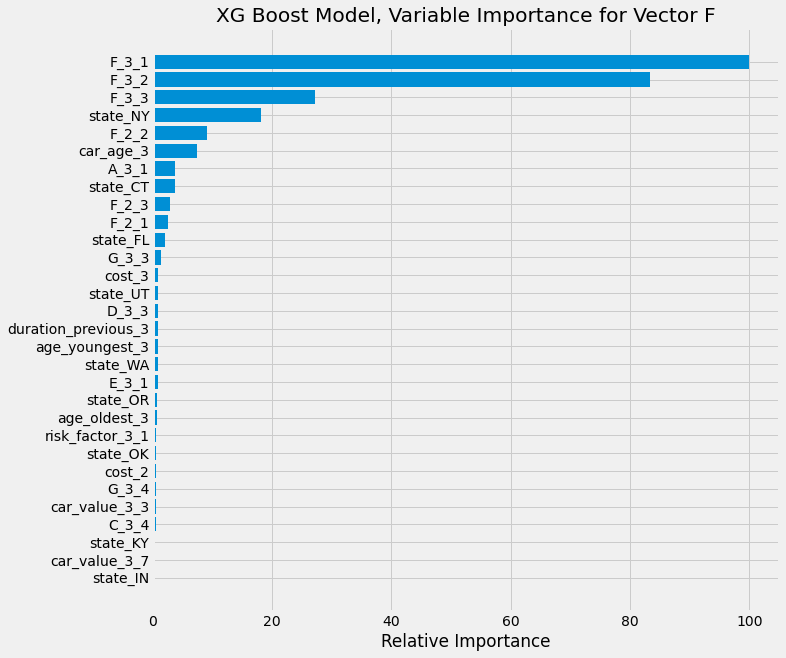

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.880 total time=   7.1s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.878 total time=   8.7s
[CV 3/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.878 total time=   9.5s
[CV 4/4] END colsample_bytree=0.5, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.881 total time=   9.3s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.879 total time=  12.7s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.878 total time=  11.8s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.878 total time=  11.7s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=400;, score=0.880 total time=  

[CV 2/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.878 total time=   9.8s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.878 total time=   9.4s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.880 total time=   9.0s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.879 total time=  14.7s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.878 total time=  14.4s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.878 total time=  15.5s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=500;, score=0.880 total time=  14.6s
[CV 1/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=4, n_estimators=200;, score=0.879 total time=   7.3s
[CV 2/4] END colsample_bytree=0.15, learning_rate=0

[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=3, n_estimators=400;, score=0.880 total time=  17.5s
[CV 1/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.876 total time=  22.4s
[CV 2/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.875 total time=  22.6s
[CV 3/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.874 total time=  26.4s
[CV 4/4] END colsample_bytree=0.35, learning_rate=0.35, max_depth=4, n_estimators=400;, score=0.878 total time=  28.6s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.879 total time=   5.8s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.878 total time=   6.1s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.878 total time=   5.9s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0

[CV 2/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=200;, score=0.878 total time=   9.0s
[CV 3/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=200;, score=0.879 total time=   5.1s
[CV 4/4] END colsample_bytree=0.15, learning_rate=0.25, max_depth=3, n_estimators=200;, score=0.880 total time=   8.9s
[CV 1/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.879 total time=   7.5s
[CV 2/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.878 total time=   9.0s
[CV 3/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.878 total time=   5.2s
[CV 4/4] END colsample_bytree=0.25, learning_rate=0.25, max_depth=5, n_estimators=100;, score=0.881 total time=   9.0s
[CV 1/4] END colsample_bytree=0.5, learning_rate=0.5, max_depth=4, n_estimators=500;, score=0.872 total time=  44.0s
[CV 2/4] END colsample_bytree=0.5, learning_rate=0

In [213]:
#Let's predict F using XG Boost Classifier and use RandomizedSearchCV to find the best XGB classifier Hyperparamters 

vector = 'F'
xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=200, max_depth = 1, learning_rate = 0.3, colsample_bytree = 1, plot = True)

results = xgb_randomsearch(vector, 60)

datapath="Modelling_data/quotes_2_3"
filename3 = 'xgboost_results_q2_q3_vector'+vector+'.csv'
save_file(results, filename3, datapath)

In [214]:
# Find scores for the test set
vector = 'F'
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], xg_probs = xg_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                max_depth = int(max_depth), learning_rate = learning_rate, \
                                                                colsample_bytree = colsample_bytree, plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
filename4 = 'xgboost_results_q2_q3_vector'+vector+'_final.csv'
save_file(results, filename4, datapath)

XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 100,  max_depth = 5,     learning_rate = 0.25, colsample_bytree = 0.5
Accuracy=0.876, f1-score=0.8754
XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 400,  max_depth = 3,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8756, f1-score=0.8749
XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 100,  max_depth = 3,     learning_rate = 0.35, colsample_bytree = 0.35
Accuracy=0.876, f1-score=0.8753
XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 300,  max_depth = 4,     learning_rate = 0.3, colsample_bytree = 0.15
Accuracy=0.8762, f1-score=0.8755
XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 300,  max_depth = 4,     learning_rate = 0.25, colsample_bytree = 0.25
Accuracy=0.8746, f1-score=0.874
XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 500,  max_depth = 4,     learning_rate = 0.25, colsamp

XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 100,  max_depth = 5,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.8755, f1-score=0.8748
XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 300,  max_depth = 5,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.874, f1-score=0.8731
XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 400,  max_depth = 5,     learning_rate = 0.35, colsample_bytree = 0.25
Accuracy=0.8727, f1-score=0.872
XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 100,  max_depth = 4,     learning_rate = 0.25, colsample_bytree = 0.35
Accuracy=0.8761, f1-score=0.8754
XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 300,  max_depth = 3,     learning_rate = 0.3, colsample_bytree = 0.5
Accuracy=0.8753, f1-score=0.8746
XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.25, colsamp

In [215]:
results

n_estimators  max_depth  learning_rate  colsample_bytree  train_score  \
0            100          5           0.25              0.50     0.879086   
1            400          3           0.30              0.15     0.878659   
2            100          3           0.35              0.35     0.879223   
3            300          4           0.30              0.15     0.877907   
4            300          4           0.25              0.25     0.878881   
5            500          4           0.25              0.15     0.878215   
6            200          3           0.35              0.25     0.879189   
7            400          3           0.35              0.25     0.877719   
8            100          5           0.35              0.35     0.878266   
9            100          4           0.30              0.35     0.879154   
10           500          3           0.30              0.35     0.877412   
11           500          4           0.25              0.25     0.877702   
12           200          4           0.25              0.35     0.879052   
13           400          3           0.35              0.15     0.878573   
14           300          5           0.30              0.25     0.876916   
15           500          5           0.50              0.35     0.870747   
16           100          4           0.35              0.35     0.878693   
17           300          3           0.30              0.15     0.878744   
18           500          3           0.25              0.15     0.879001   
19           200          4           0.25              0.15     0.878710   
20           400          4           0.35              0.50     0.875224   
21           200          3           0.50              0.15     0.878915   
22           200          3           0.30              0.35     0.879240   
23           200          4           0.30              0.35     0.878334   
24           100          5           0.30              0.50     0.878727   
25           400          3           0.50              0.35     0.875805   
26           300          4           0.30              0.50     0.877514   
27           400          5           0.30              0.15     0.877565   
28           500          5           0.25              0.25     0.876591   
29           400          5           0.25              0.50     0.875993   
30           100          4           0.30              0.25     0.879086   
31           400          5           0.50              0.50     0.871653   
32           300          3           0.30              0.35     0.878967   
33           400          4           0.35              0.25     0.876130   
34           400          3           0.35              0.35     0.878044   
35           400          4           0.35              0.35     0.875839   
36           100          3           0.30              0.25     0.879018   
37           200          5           0.35              0.50     0.877070   
38           200          5           0.50              0.35     0.874951   
39           200          4           0.25              0.25     0.878949   
40           500          3           0.50              0.25     0.875344   
41           400          4           0.35              0.15     0.877138   
42           200          4           0.35              0.15     0.878522   
43           400          4           0.50              0.50     0.872712   
44           100          5           0.35              0.25     0.878180   
45           500          4           0.50              0.15     0.874250   
46           100          5           0.50              0.15     0.877531   
47           100          5           0.25              0.35     0.879274   
48           300          5           0.30              0.50     0.875925   
49           400          5           0.35              0.25     0.875241   
50           100          4           0.25              0.35     0.879308   


XGBoost Classifier results for Vector F
Parameters: No. of Estimators = 200,  max_depth = 3,     learning_rate = 0.25, colsample_bytree = 0.15
Accuracy=0.8766, f1-score=0.8759
Confusion Matrix - normalized
 [[0.9265 0.0182 0.0515 0.0038]
 [0.0297 0.8382 0.121  0.0111]
 [0.0332 0.0514 0.8939 0.0216]
 [0.0418 0.0476 0.2578 0.6527]]
Confusion Matrix
 [[4389   86  244   18]
 [ 107 3021  436   40]
 [ 180  279 4853  117]
 [  36   41  222  562]]

Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      4737
           1       0.88      0.84      0.86      3604
           2       0.84      0.89      0.87      5429
           3       0.76      0.65      0.70       861

    accuracy                           0.88     14631
   macro avg       0.85      0.83      0.84     14631
weighted avg       0.88      0.88      0.88     14631

30


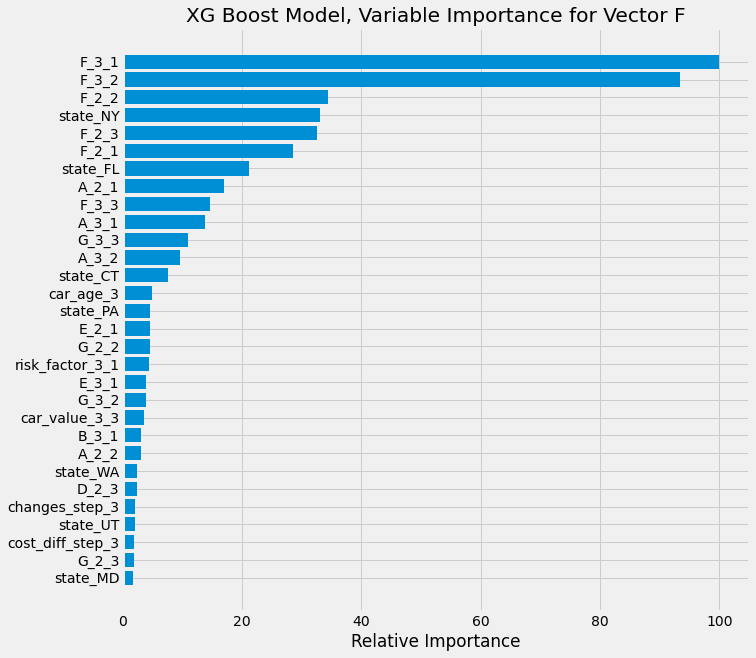

In [216]:
#Let's plot the best model for F using XG Boost Classifier (Iteration 52)

xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=200, max_depth = 3, learning_rate = 0.25, colsample_bytree = 0.15, plot = True)

# Quotes 2 & 3: Predict G

In [209]:
y_train['G'].value_counts()

2    22867
3    18525
1    12179
4     4950
Name: G, dtype: int64

In [210]:
mapping_G = {1:0, 2:1, 3:2, 4:3}

y_train['G'] = y_train['G'].map(lambda x: mapping_G[x] )
y_test['G'] = y_test['G'].map(lambda x: mapping_G[x] )
y_train['G'].value_counts()

C:\Users\amite\AppData\Local\Temp/ipykernel_33952/3531427218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['G'] = y_train['G'].map(lambda x: mapping_G[x] )
C:\Users\amite\AppData\Local\Temp/ipykernel_33952/3531427218.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['G'] = y_test['G'].map(lambda x: mapping_G[x] )


1    22867
2    18525
0    12179
3     4950
Name: G, dtype: int64

In [211]:
vector = 'G'
last_quote = 3
test_set = df_hist_2_3.iloc[y_test.index,:]
x = pd.crosstab(test_set[vector], test_set[vector+'_'+str(last_quote)])
same_as_3 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
print(f"Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_test.shape[0]): 4.4}")
print(f"Confusion_Matrix")
x['total'] = x.sum(axis=1)
x['G1_%'] = np.around(x[1]/ x['total'], 4)
x['G2_%'] = np.around(x[2]/ x['total'], 4)
x['G3_%'] = np.around(x[3]/ x['total'], 4)
x['G4_%'] = np.around(x[4]/ x['total'], 4)
x

Accuracy based on simply predicting vector G = G_3 :  0.797
Confusion_Matrix


G_3     1     2     3    4  total    G1_%    G2_%    G3_%    G4_%
G                                                                
1    2295   540    83   67   2985  0.7688  0.1809  0.0278  0.0224
2     535  4844   184  119   5682  0.0942  0.8525  0.0324  0.0209
3     211   570  3720  198   4699  0.0449  0.1213  0.7917  0.0421
4      71   162   230  802   1265  0.0561  0.1281  0.1818  0.6340

In [212]:
vector = 'G'
last_quote = 3
test_set2 = df_hist_2_3.iloc[y_train.index,:]
x2 = pd.crosstab(test_set2[vector], test_set2[vector+'_'+str(last_quote)])
same_as_3 = [x2.iloc[idx,idx] for idx in range(x2.shape[0])] 
print(f"TRAINING Accuracy based on simply predicting vector {vector} = {vector}_{last_quote} : {(np.sum(same_as_3)/y_train.shape[0]): 4.4}")
print(f"Confusion_Matrix - TRAINING")
x2['total'] = x2.sum(axis=1)
x2['G1_%'] = np.around(x2[1]/ x2['total'], 4)
x2['G2_%'] = np.around(x2[2]/ x2['total'], 4)
x2['G3_%'] = np.around(x2[3]/ x2['total'], 4)
x2['G4_%'] = np.around(x2[4]/ x2['total'], 4)
x2

TRAINING Accuracy based on simply predicting vector G = G_3 :  0.7972
Confusion_Matrix - TRAINING


G_3     1      2      3     4  total    G1_%    G2_%    G3_%    G4_%
G                                                                   
1    9352   2280    317   230  12179  0.7679  0.1872  0.0260  0.0189
2    2176  19397    732   562  22867  0.0952  0.8483  0.0320  0.0246
3     832   2181  14681   831  18525  0.0449  0.1177  0.7925  0.0449
4     207    606    912  3225   4950  0.0418  0.1224  0.1842  0.6515

Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 300,  min_samples_leaf = 1,     min_samples_split = 2
Accuracy=0.8032, f1-score=0.8026
Confusion Matrix - normalized
 [[0.7668 0.1883 0.0295 0.0154]
 [0.092  0.8576 0.0354 0.015 ]
 [0.0445 0.1051 0.8125 0.0379]
 [0.0601 0.1304 0.1992 0.6103]]
Confusion Matrix
 [[2289  562   88   46]
 [ 523 4873  201   85]
 [ 209  494 3818  178]
 [  76  165  252  772]]

Classification Report 
               precision    recall  f1-score   support

           0       0.74      0.77      0.75      2985
           1       0.80      0.86      0.83      5682
           2       0.88      0.81      0.84      4699
           3       0.71      0.61      0.66      1265

    accuracy                           0.80     14631
   macro avg       0.78      0.76      0.77     14631
weighted avg       0.80      0.80      0.80     14631

30


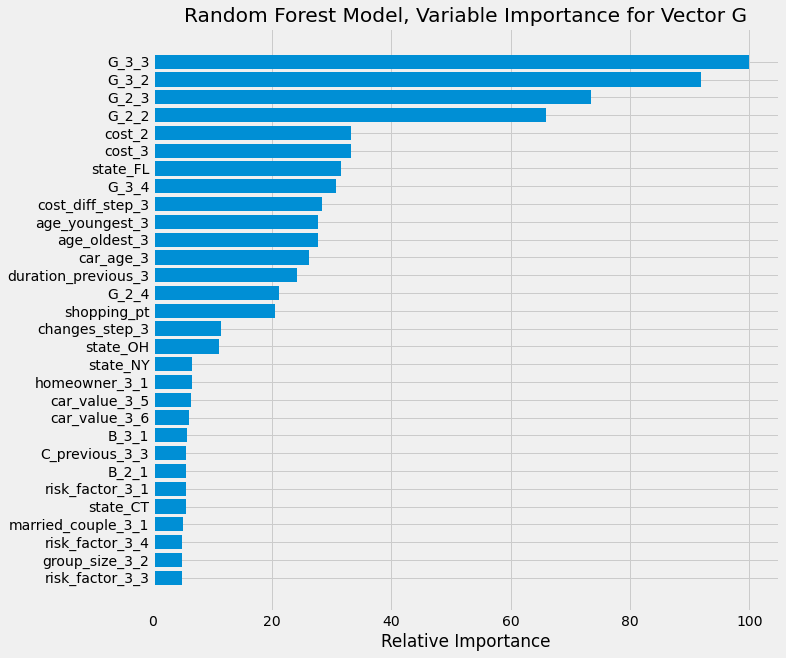

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.800 total time=  25.1s
[CV 2/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.806 total time=  19.5s
[CV 3/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.806 total time=  19.9s
[CV 4/4] END min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=0.802 total time=  19.6s
[CV 1/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=800;, score=0.800 total time=  32.5s
[CV 2/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=800;, score=0.807 total time=  32.1s
[CV 3/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=800;, score=0.806 total time=  32.5s
[CV 4/4] END min_samples_leaf=2, min_samples_split=4, n_estimators=800;, score=0.802 total time=  32.2s
[CV 1/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=800;, score=0.799 total time=  33.7s
[C

[CV 4/4] END min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=0.802 total time=  28.1s
[CV 1/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=100;, score=0.799 total time=   3.6s
[CV 2/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=100;, score=0.806 total time=   3.5s
[CV 3/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=100;, score=0.806 total time=   3.8s
[CV 4/4] END min_samples_leaf=3, min_samples_split=5, n_estimators=100;, score=0.802 total time=   3.5s
[CV 1/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.800 total time=  16.4s
[CV 2/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.806 total time=  16.9s
[CV 3/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.806 total time=  18.1s
[CV 4/4] END min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=0.802 total time=  16.3s
[CV 1/4] END min_samples_leaf=3, min_samples_split=4, n_estimato

[CV 3/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=600;, score=0.806 total time=  21.0s
[CV 4/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=600;, score=0.802 total time=  21.5s
[CV 1/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=500;, score=0.799 total time=  18.0s
[CV 2/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=500;, score=0.807 total time=  17.8s
[CV 3/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=500;, score=0.806 total time=  18.2s
[CV 4/4] END min_samples_leaf=3, min_samples_split=4, n_estimators=500;, score=0.802 total time=  18.3s
[CV 1/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=600;, score=0.799 total time=  20.8s
[CV 2/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=600;, score=0.806 total time=  21.7s
[CV 3/4] END min_samples_leaf=4, min_samples_split=4, n_estimators=600;, score=0.806 total time=  21.3s
[CV 4/4] END min_samples_leaf=4, min_samples_split=4, n_estimato

[CV 2/4] END min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.806 total time=   3.9s
[CV 3/4] END min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.807 total time=   4.2s
[CV 4/4] END min_samples_leaf=2, min_samples_split=3, n_estimators=100;, score=0.802 total time=   4.1s
Vector G RandomizedSearchCV: Random Forest Model
Best Score:0.8039678763333296
Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1}
Writing file.  "Modelling_data/quotes_2_3\rf_results_q2_q3_vectorG.csv"


In [217]:
# RF Classifier: Predict G using quotes 2 and 3 and then RandomizedSearchCV to find best hyperparameters

vector = 'G'

rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, min_samples_split = 2, plot=True)

results = rf_randomsearch(vector, 60)

datapath="Modelling_data/quotes_2_3"
filename1 = 'rf_results_q2_q3_vector'+vector+'.csv'
save_file(results, filename1, datapath)

In [220]:
results

n_estimators  min_samples_split  min_samples_leaf  train_score  train_rank
0            500                  2                 4     0.803216          56
1            800                  4                 2     0.803677          12
2            800                  4                 4     0.803507          25
3            800                  5                 4     0.803507          25
4            500                  3                 4     0.803216          56
5            400                  3                 2     0.803421          36
6            200                  2                 4     0.803267          45
7            800                  3                 1     0.803472          31
8            300                  2                 1     0.803882           3
9            200                  4                 1     0.803848           5
10           400                  2                 4     0.803233          50
11           100                  5                 4     0.803267          42
12           700                  2                 4     0.803558          21
13           100                  2                 2     0.803643          16
14           400                  5                 3     0.803233          47
15           300                  2                 3     0.803301          39
16           500                  5                 2     0.803746           8
17           200                  5                 1     0.803677          11
18           100                  5                 1     0.803045          59
19           700                  2                 2     0.803865           4
20           100                  5                 3     0.803216          54
21           500                  5                 4     0.803216          56
22           800                  4                 3     0.803660          13
23           700                  2                 1     0.803763           6
24           300                  3                 1     0.803336          38
25           100                  3                 3     0.803216          54
26           700                  3                 1     0.803489          29
27           500                  5                 1     0.803968           1
28           400                  2                 3     0.803233          47
29           800                  4                 1     0.803592          19
30           400                  5                 4     0.803233          50
31           200                  2                 3     0.803558          23
32           400                  3                 4     0.803233          50
33           400                  4                 4     0.803233          50
34           100                  3                 1     0.802943          60
35           500                  4                 1     0.803763           7
36           100                  4                 4     0.803267          42
37           100                  3                 4     0.803267          42
38           300                  3                 3     0.803301          39
39           600                  4                 3     0.803507          25
40           500                  4                 3     0.803455          33
41           600                  4                 4     0.803472          32
42           800                  5                 3     0.803660          13
43           400                  4                 3     0.803233          47
44           700                  4                 4     0.803558          21
45           500                  5                 3     0.803455          33
46           200                  5                 4     0.803267          45
47           100                  4                 2     0.803643          16
48           600                  5                 3     0.803507          25
49           500                  2                 3 

In [222]:
# Get scores for test set
vector = 'G'

for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    min_samples_leaf = row['min_samples_leaf']
    min_samples_split = row['min_samples_split']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], rf_probs = rf_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                min_samples_leaf = int(min_samples_leaf), \
                                                                min_samples_split = int(min_samples_split), plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
filename2 = 'rf_results_q2_q3_vector'+vector+'_final.csv'
save_file(results, filename2, datapath)

Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 500,  min_samples_leaf = 4,     min_samples_split = 2
Accuracy=0.8033, f1-score=0.8027
Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 800,  min_samples_leaf = 2,     min_samples_split = 4
Accuracy=0.8037, f1-score=0.8031
Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 800,  min_samples_leaf = 4,     min_samples_split = 4
Accuracy=0.8034, f1-score=0.8029
Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 800,  min_samples_leaf = 4,     min_samples_split = 5
Accuracy=0.8034, f1-score=0.8029
Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 500,  min_samples_leaf = 4,     min_samples_split = 3
Accuracy=0.8033, f1-score=0.8027
Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 400,  min_samples_leaf = 2,     min_samples_split = 3
Accuracy=0.8039, f1-score=0.8033
Random For

Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 400,  min_samples_leaf = 2,     min_samples_split = 2
Accuracy=0.8039, f1-score=0.8033
Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 800,  min_samples_leaf = 2,     min_samples_split = 5
Accuracy=0.8034, f1-score=0.8028
Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 600,  min_samples_leaf = 1,     min_samples_split = 5
Accuracy=0.8036, f1-score=0.803
Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 300,  min_samples_leaf = 2,     min_samples_split = 5
Accuracy=0.8029, f1-score=0.8023
Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 800,  min_samples_leaf = 3,     min_samples_split = 2
Accuracy=0.8035, f1-score=0.8029
Random Forest Classifier results for Vector G
Parameters: No. of Estimators = 400,  min_samples_leaf = 1,     min_samples_split = 5
Accuracy=0.8028, f1-score=0.8022
Random Fore

In [ ]:
#Let's plot the best model for G using Random Forest Classifier

rf_ac, rf_f1, rf_probs = rf_predict_plot(vector, n_estimators=300, min_samples_leaf = 1, min_samples_split = 2, plot=True)

In [ ]:
#Let's predict G using XG Boost Classifier and use RandomizedSearchCV to find the best XGB classifier Hyperparamters 

vector = 'G'
xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=200, max_depth = 1, learning_rate = 0.3, colsample_bytree = 1, plot = True)

results = xgb_randomsearch(vector, 60)

datapath="Modelling_data/quotes_2_3"
filename3 = 'xgboost_results_q2_q3_vector'+vector+'.csv'
save_file(results, filename3, datapath)

In [ ]:
# Find scores for the test set
vector = 'G'
for i, row in results.iterrows():
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    colsample_bytree = row['colsample_bytree']
    
    results.loc[i, 'test_score'], results.loc[i, 'f1_score'], xg_probs = xg_predict_plot(vector, n_estimators=int(n_estimators), \
                                                                max_depth = int(max_depth), learning_rate = learning_rate, \
                                                                colsample_bytree = colsample_bytree, plot=False)
    
results['test_rank']= results['test_score'].rank(method='dense', ascending=False)
results['tr_te_avg_score'] = (results['test_score']+results['train_score'])/2
results['overall_rank']= results['tr_te_avg_score'].rank(method='dense', ascending=False)
datapath="Modelling_data/quotes_2_3"
filename4 = 'xgboost_results_q2_q3_vector'+vector+'_final.csv'
save_file(results, filename4, datapath)

In [ ]:
#Let's plot the best model for G using XG Boost Classifier

xg_ac, xg_f1, xg_probs = xg_predict_plot(vector, n_estimators=200, max_depth = 1, learning_rate = 0.3, colsample_bytree = 1, plot = True)

# Summary: Predicting with Quotes 2 and 3

In [41]:
# test_set = df_hist_2_3.iloc[y_test.index,:]
X_test['shopping_pt'].value_counts()

-0.051107    2974
 0.501449    2760
-0.603664    2500
 1.054006    1918
-1.156220    1803
-1.708777    1280
 1.606563     971
 2.159119     341
 2.711676      76
 3.264232       8
Name: shopping_pt, dtype: int64

In [43]:
df_hist_2_3.tail()

customer_ID  shopping_pt state  A  B  C  D  E  F  G  ...  D_2  D_3  \
73147     10037589            9    NY  2  1  3  3  1  0  4  ...    3    3   
73148     10079341            8    CT  1  0  2  3  0  0  2  ...    3    3   
73149     10050448            9    FL  1  1  3  3  1  1  4  ...    3    3   
73150     10119621            7    WA  1  1  4  3  1  2  3  ...    3    3   
73151     10097783            5    ID  1  0  3  2  0  1  1  ...    2    2   

       E_2  E_3  F_2  F_3  G_2  G_3  cost_2  cost_3  
73147    1    1    0    0    2    4     705     716  
73148    0    0    0    0    1    1     648     657  
73149    1    1    1    1    4    4     634     631  
73150    1    1    1    1    3    3     594     601  
73151    0    0    1    1    1    1     567     567  

[5 rows x 37 columns]

In [44]:
df_hist_2_3.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            73142, 73143, 73144, 73145, 73146, 73147, 73148, 73149, 73150,
            73151],
           dtype='int64', length=73152)

In [45]:
X_test.index

Int64Index([53058, 29437, 29320, 24863, 54551,  1686, 60697, 22375, 65468,
             8116,
            ...
            40449, 18790, 19816,  7728,  1295, 45038, 68447,  9954, 67173,
            32913],
           dtype='int64', length=14631)

In [46]:
np.max(X_test.index)

73139

In [47]:
np.max(X_train.index)

73151

In [51]:
sp_map = X_test[['shopping_pt']].merge(df_hist_2_3[['customer_ID', 'shopping_pt']], left_index=True, right_index=True, how='left')


shopping_pt_x  customer_ID  shopping_pt_y
53058       1.054006     10022118              9
29437       0.501449     10026861              8
29320      -1.156220     10124076              5
24863      -0.603664     10121762              6
54551       2.159119     10094826             11

In [76]:
sp_map.sample(20)

shopping_pt_x  customer_ID  shopping_pt_y
69645      -0.603664     10127450              6
9623        0.501449     10038510              8
30227       2.711676     10089076             12
35707      -0.603664     10010122              6
942        -1.708777     10016256              4
37394       1.054006     10114553              9
18742      -1.708777     10003464              4
36790      -1.156220     10139771              5
4337        1.054006     10002731              9
24623      -1.708777     10074257              4
21095       1.606563     10018676             10
62417       1.054006     10094523              9
37258       1.054006     10137440              9
35432       1.606563     10121928             10
69889       1.054006     10073851              9
67909       1.054006     10032511              9
25120       0.501449     10104063              8
42988       0.501449     10100258              8
59043       0.501449     10037436              8
20690      -0.051107     10030178              7

In [70]:
unique_sp = X_test['shopping_pt'].unique()

for s_pt in unique_sp:
    
    X_pred = X_test[X_test['shopping_pt'] == s_pt]
    
    y_pred = model_res.predict(X_pred.to_numpy())
    ac = accuracy_score(y_test.loc[X_pred.index, vector].astype('int'), y_pred)

    #f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    #cm = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"\nRandom Forest Classifier results for Vector {vector}\n")
    print(f'Shopping Point = {s_pt}, Accuracy = {ac:4.3f}' )

    #print('f1-score=%.3f' % (f1))

    #print("Confusion Matrix\n", cm)

    #cr = classification_report(y_test[vector].astype('int'), y_pred)

    #print("\nClassification Report \n", cr)
    


Random Forest Classifier results for Vector D

Shopping Point = 1.0540059365189363, Accuracy = 0.896

Random Forest Classifier results for Vector D

Shopping Point = 0.5014493406939049, Accuracy = 0.896

Random Forest Classifier results for Vector D

Shopping Point = -1.1562204467811896, Accuracy = 0.923

Random Forest Classifier results for Vector D

Shopping Point = -0.6036638509561582, Accuracy = 0.916

Random Forest Classifier results for Vector D

Shopping Point = 2.1591191281689994, Accuracy = 0.874

Random Forest Classifier results for Vector D

Shopping Point = -0.05110725513112662, Accuracy = 0.918

Random Forest Classifier results for Vector D

Shopping Point = 1.6065625323439678, Accuracy = 0.891

Random Forest Classifier results for Vector D

Shopping Point = 2.7116757239940306, Accuracy = 0.776

Random Forest Classifier results for Vector D

Shopping Point = -1.708777042606221, Accuracy = 0.923

Random Forest Classifier results for Vector D

Shopping Point = 3.26423231981

In [88]:

for sp in range(4,14):
        df_select = df_wide[df_wide['shopping_pt'] == sp]
        x = pd.crosstab(df_select['D_3'], df_select['D_'+str(sp)])
        same_as_3 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 
        print(f"Accuracy for exit point = {sp}, based on simply predicting vector {vector}_{sp} = {vector}_3 : {(np.sum(same_as_3)/df_select.shape[0]): 4.4}")


Accuracy for exit point = 4, based on simply predicting vector D_4 = D_3 :  0.9258
Accuracy for exit point = 5, based on simply predicting vector D_5 = D_3 :  0.9295
Accuracy for exit point = 6, based on simply predicting vector D_6 = D_3 :  0.9162
Accuracy for exit point = 7, based on simply predicting vector D_7 = D_3 :  0.9114
Accuracy for exit point = 8, based on simply predicting vector D_8 = D_3 :  0.8993
Accuracy for exit point = 9, based on simply predicting vector D_9 = D_3 :  0.8877
Accuracy for exit point = 10, based on simply predicting vector D_10 = D_3 :  0.8754
Accuracy for exit point = 11, based on simply predicting vector D_11 = D_3 :  0.8538
Accuracy for exit point = 12, based on simply predicting vector D_12 = D_3 :  0.8447
Accuracy for exit point = 13, based on simply predicting vector D_13 = D_3 :  0.875


In [87]:
df_select = df_wide[df_wide['shopping_pt'] == 4]
df_select.shape

(6401, 259)

In [83]:
df_wide.shape[0]

77607

In [99]:
df_2 = QuoteHistory2()
df_2.pass_data(df_wide)

df_hist_2_3_4 = df_2.get_history(how='specific', quote_nos=[2,3,4])
df_hist_2_3_4.head()

customer_ID  shopping_pt state  A  B  C  D  E  F  G  ...  E_4  F_2  F_3  \
0     10109793            9    CO  1  1  3  3  0  2  1  ...  0.0    2    2   
1     10002231            8    OH  0  0  1  3  0  0  3  ...  0.0    0    0   
2     10150024            8    OH  1  1  2  3  0  2  3  ...  0.0    3    3   
3     10003949            8    FL  1  1  2  2  1  2  3  ...  1.0    2    2   
4     10103809           10    FL  1  1  1  3  1  1  3  ...  1.0    1    1   

   F_4  G_2  G_3  G_4  cost_2  cost_3  cost_4  
0  2.0    1    1  1.0     656     656   656.0  
1  0.0    3    3  3.0     557     564   564.0  
2  2.0    3    3  2.0     617     617   624.0  
3  2.0    3    3  3.0     675     675   675.0  
4  1.0    3    3  3.0     617     617   617.0  

[5 rows x 45 columns]

In [100]:
df_hist_2_3_4 = df_hist_2_3_4.drop(columns=['A','B','C','D','E','F','G','cost'])
df_hist_2_3_4.head()

customer_ID  shopping_pt state  group_size_4  homeowner_4  car_age_4  \
0     10109793            9    CO           1.0          1.0        3.0   
1     10002231            8    OH           1.0          0.0       13.0   
2     10150024            8    OH           3.0          1.0       20.0   
3     10003949            8    FL           2.0          1.0        7.0   
4     10103809           10    FL           1.0          1.0        9.0   

   car_value_4  risk_factor_4  age_oldest_4  age_youngest_4  ...  E_4  F_2  \
0          5.0            0.0          45.0            45.0  ...  0.0    2   
1          4.0            0.0          24.0            24.0  ...  0.0    0   
2          5.0            0.0          44.0            19.0  ...  0.0    3   
3          6.0            3.0          33.0            32.0  ...  1.0    2   
4          6.0            1.0          27.0            27.0  ...  1.0    1   

   F_3  F_4  G_2  G_3  G_4  cost_2  cost_3  cost_4  
0    2  2.0    1    1  1.0     656     656   656.0  
1    0  0.0    3    3  3.0     557     564   564.0  
2    3  2.0    3    3  2.0     617     617   624.0  
3    2  2.0    3    3  3.0     675     675   675.0  
4    1  1.0    3    3  3.0     617     617   617.0  

[5 rows x 37 columns]

In [140]:
df_hist_2_3_4.shape


(73152, 37)

In [102]:
pp2 = PreProcess2()
pp2.fit(df_hist_2_3_4)

X3, y3 = pp2.transform(quote_nos=[2,3], target=4)


X3.shape, y3.shape  

((73152, 94), (73152, 8))

In [103]:
X3.head()

shopping_pt  car_age_4  age_oldest_4  age_youngest_4  duration_previous_4  \
0     1.054006  -0.894633     -0.002381        0.135086            -0.643210   
1     0.501449   0.828689     -1.209673       -1.067958             0.854494   
2     0.501449   2.035014     -0.059871       -1.354397            -0.643210   
3     0.501449  -0.205304     -0.692262       -0.609655            -0.643210   
4     1.606563   0.139360     -1.037203       -0.896094            -0.429252   

     cost_2    cost_3  changes_step_3  cost_diff_step_3  state_AR  ...  F_2_3  \
0  0.459097  0.443265       -0.531869         -0.072856         0  ...      0   
1 -1.622300 -1.564636       -0.531869          0.261214         0  ...      0   
2 -0.360847 -0.407910       -0.531869         -0.072856         0  ...      1   
3  0.858557  0.857941       -0.531869         -0.072856         0  ...      0   
4 -0.360847 -0.407910       -0.531869         -0.072856         0  ...      0   

   F_3_1  F_3_2  F_3_3  G_2_2  G_2_3  G_2_4  G_3_2  G_3_3  G_3_4  
0      0      1      0      0      0      0      0      0      0  
1      0      0      0      0      1      0      0      1      0  
2      0      0      1      0      1      0      0      1      0  
3      0      1      0      0      1      0      0      1      0  
4      1      0      0      0      1      0      0      1      0  

[5 rows x 94 columns]

In [141]:
y3.head() 

A_4  B_4  C_4  D_4  E_4  F_4  G_4 cost_4
0  1.0  0.0  3.0  3.0  0.0  2.0  1.0  656.0
1  0.0  0.0  1.0  3.0  0.0  0.0  3.0  564.0
2  1.0  1.0  2.0  3.0  0.0  2.0  2.0  624.0
3  1.0  1.0  2.0  2.0  1.0  2.0  3.0  675.0
4  1.0  1.0  1.0  3.0  1.0  1.0  3.0  617.0

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.2, random_state = 123, stratify = X2['shopping_pt'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((58521, 94), (14631, 94), (58521, 8), (14631, 8))

Random Forest Classifier results for Vector A_4, min_samples_leaf = 1

Accuracy=0.946
f1-score=0.945
Confusion Matrix
 [[2964  183   34]
 [ 171 9013  131]
 [  37  241 1857]]

Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      3181
           1       0.96      0.97      0.96      9315
           2       0.92      0.87      0.89      2135

    accuracy                           0.95     14631
   macro avg       0.94      0.92      0.93     14631
weighted avg       0.95      0.95      0.95     14631

30


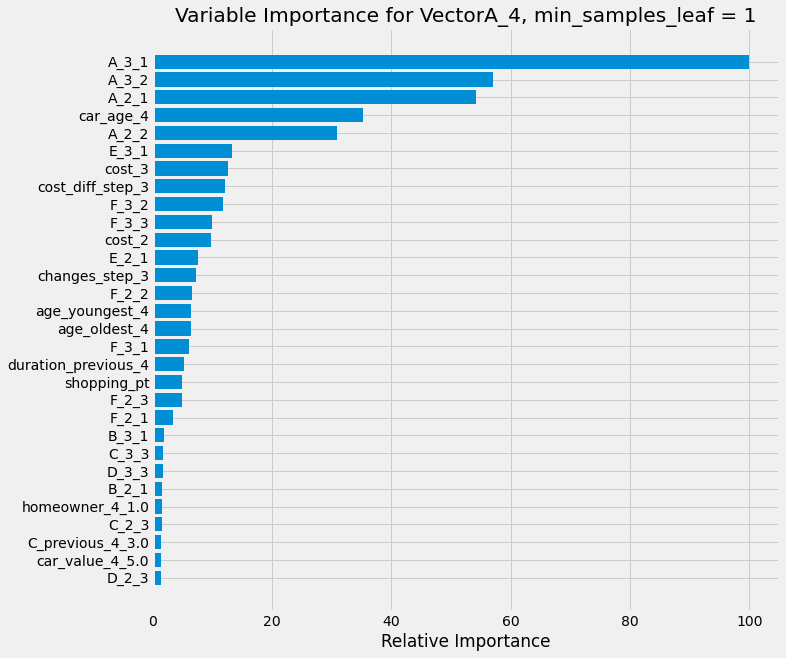

Random Forest Classifier results for Vector A_4, min_samples_leaf = 2

Accuracy=0.945
f1-score=0.945
Confusion Matrix
 [[2964  183   34]
 [ 173 9011  131]
 [  38  240 1857]]

Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      3181
           1       0.96      0.97      0.96      9315
           2       0.92      0.87      0.89      2135

    accuracy                           0.95     14631
   macro avg       0.94      0.92      0.93     14631
weighted avg       0.95      0.95      0.95     14631

30


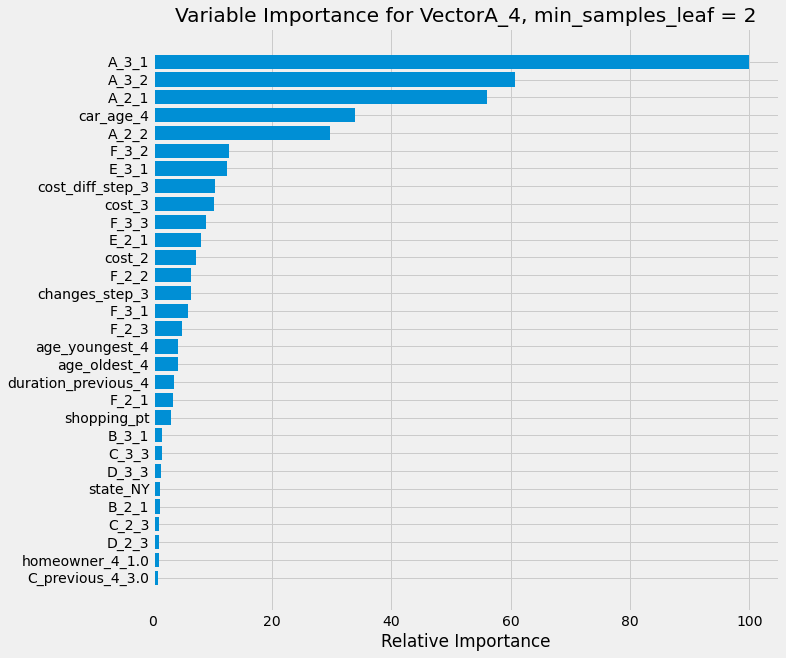

In [143]:
plt.style.use("fivethirtyeight")

vector = 'A_4'

for min_leaf in range(1,3):
    
    clf = RandomForestClassifier(n_estimators=300,  min_samples_leaf=min_leaf, random_state = 1,n_jobs=-1)
    model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Random Forest Classifier results for Vector {vector}, min_samples_leaf = {min_leaf}\n")
    print('Accuracy=%.3f' % (ac))

    print('f1-score=%.3f' % (f1))

    print("Confusion Matrix\n", cm)

    cr = classification_report(y_test[vector].astype('int'), y_pred)

    print("\nClassification Report \n", cr)

    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[64:]

    pos = np.arange(sorted_idx.shape[0]) + .5
    print(pos.size)
    sorted_idx.size
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance for Vector'+vector+', min_samples_leaf = %d'%min_leaf)
    plt.show()


In [144]:
test_set = df_hist_2_3_4.iloc[y_test.index, :]
x = pd.crosstab(test_set['A_4'], test_set['A_3'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_3 : {(np.sum(same_as_2)/test_set.shape[0]): 4.4}")


Accuracy based on simply predicting vector A_4 = A_4_3 :  0.9446


In [145]:
x

A_3     0     1     2
A_4                  
0.0  2967   180    34
1.0   188  8996   131
2.0    40   238  1857

Random Forest Classifier results for Vector D_4, min_samples_leaf = 1

Accuracy=0.962
f1-score=0.962
Confusion Matrix
 [[2053   45   38]
 [  85 3189  115]
 [ 128  145 8833]]

Classification Report 
               precision    recall  f1-score   support

           1       0.91      0.96      0.93      2136
           2       0.94      0.94      0.94      3389
           3       0.98      0.97      0.98      9106

    accuracy                           0.96     14631
   macro avg       0.94      0.96      0.95     14631
weighted avg       0.96      0.96      0.96     14631

30


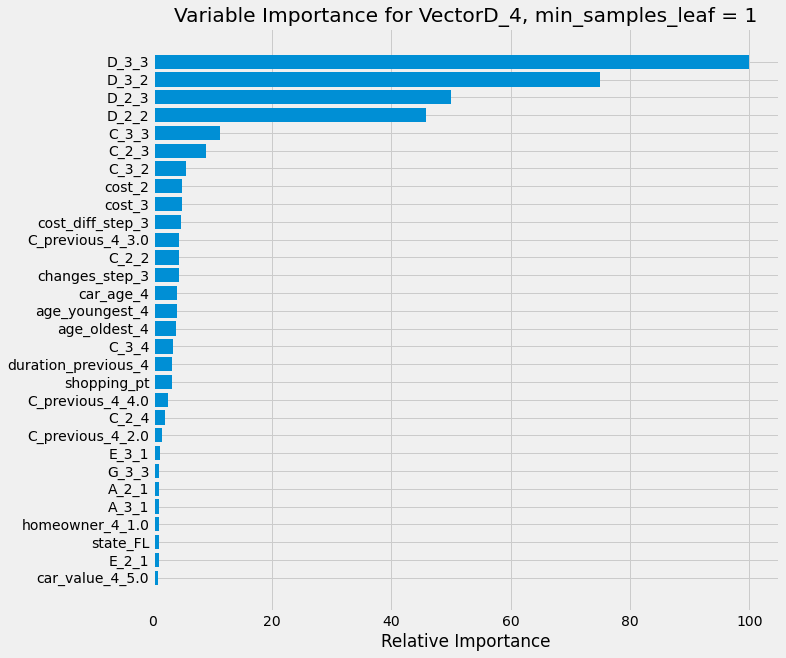

Random Forest Classifier results for Vector D_4, min_samples_leaf = 2

Accuracy=0.962
f1-score=0.962
Confusion Matrix
 [[2053   44   39]
 [  85 3189  115]
 [ 132  145 8829]]

Classification Report 
               precision    recall  f1-score   support

           1       0.90      0.96      0.93      2136
           2       0.94      0.94      0.94      3389
           3       0.98      0.97      0.98      9106

    accuracy                           0.96     14631
   macro avg       0.94      0.96      0.95     14631
weighted avg       0.96      0.96      0.96     14631

30


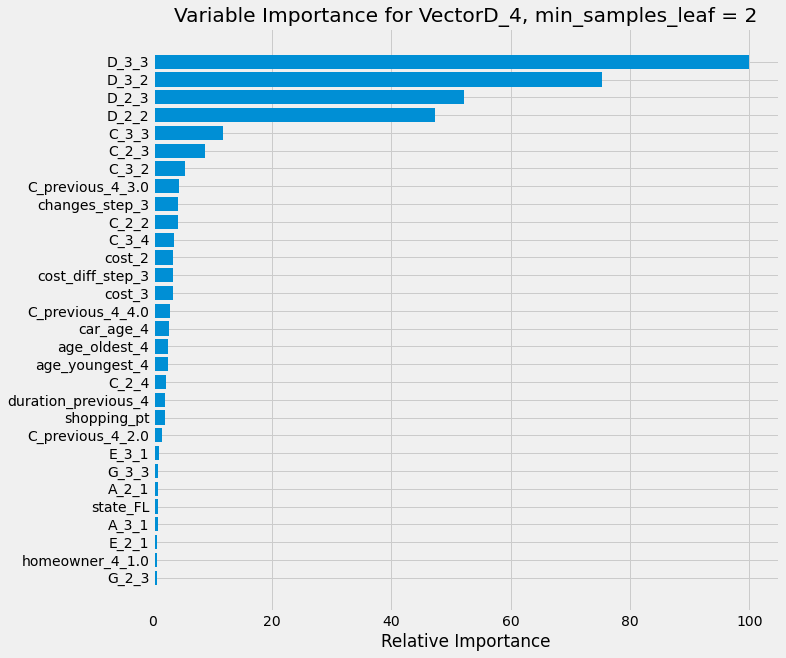

In [106]:
plt.style.use("fivethirtyeight")

vector = 'D_4'

for min_leaf in range(1,3):
    
    clf = RandomForestClassifier(n_estimators=300,  min_samples_leaf=min_leaf, random_state = 1,n_jobs=-1)
    model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Random Forest Classifier results for Vector {vector}, min_samples_leaf = {min_leaf}\n")
    print('Accuracy=%.3f' % (ac))

    print('f1-score=%.3f' % (f1))

    print("Confusion Matrix\n", cm)

    cr = classification_report(y_test[vector].astype('int'), y_pred)

    print("\nClassification Report \n", cr)

    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[64:]

    pos = np.arange(sorted_idx.shape[0]) + .5
    print(pos.size)
    sorted_idx.size
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance for Vector'+vector+', min_samples_leaf = %d'%min_leaf)
    plt.show()


In [117]:
test_set = df_hist_2_3_4.iloc[y_test.index, :]
x = pd.crosstab(test_set['D_4'], test_set['D_3'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_3 : {(np.sum(same_as_2)/test_set.shape[0]): 4.4}")


Accuracy based on simply predicting vector D_4 = D_4_3 :  0.9617


In [118]:
x

D_3     1     2     3
D_4                  
1.0  2057    44    35
2.0    87  3189   113
3.0   136   145  8825

In [119]:
test_set['D_3'].value_counts()

3    8973
2    3378
1    2280
Name: D_3, dtype: int64

Random Forest Classifier results for Vector G_4, min_samples_leaf = 1

Accuracy=0.912
f1-score=0.912
Confusion Matrix
 [[2803  247   41   39]
 [ 214 5613  130   75]
 [  69  161 3966   97]
 [  29   84  102  961]]

Classification Report 
               precision    recall  f1-score   support

           1       0.90      0.90      0.90      3130
           2       0.92      0.93      0.92      6032
           3       0.94      0.92      0.93      4293
           4       0.82      0.82      0.82      1176

    accuracy                           0.91     14631
   macro avg       0.89      0.89      0.89     14631
weighted avg       0.91      0.91      0.91     14631

30


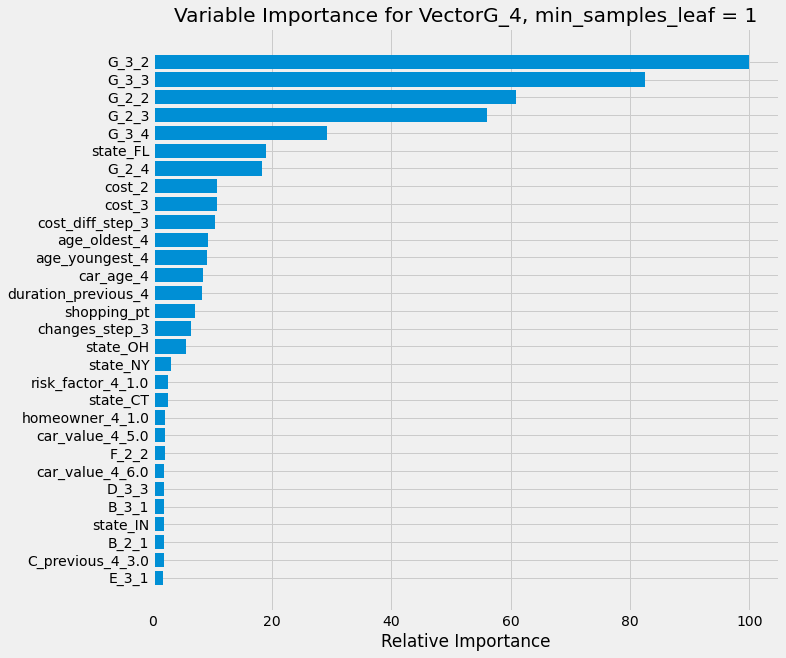

Random Forest Classifier results for Vector G_4, min_samples_leaf = 2

Accuracy=0.912
f1-score=0.912
Confusion Matrix
 [[2804  247   41   38]
 [ 214 5612  130   76]
 [  69  162 3961  101]
 [  31   83  101  961]]

Classification Report 
               precision    recall  f1-score   support

           1       0.90      0.90      0.90      3130
           2       0.92      0.93      0.92      6032
           3       0.94      0.92      0.93      4293
           4       0.82      0.82      0.82      1176

    accuracy                           0.91     14631
   macro avg       0.89      0.89      0.89     14631
weighted avg       0.91      0.91      0.91     14631

30


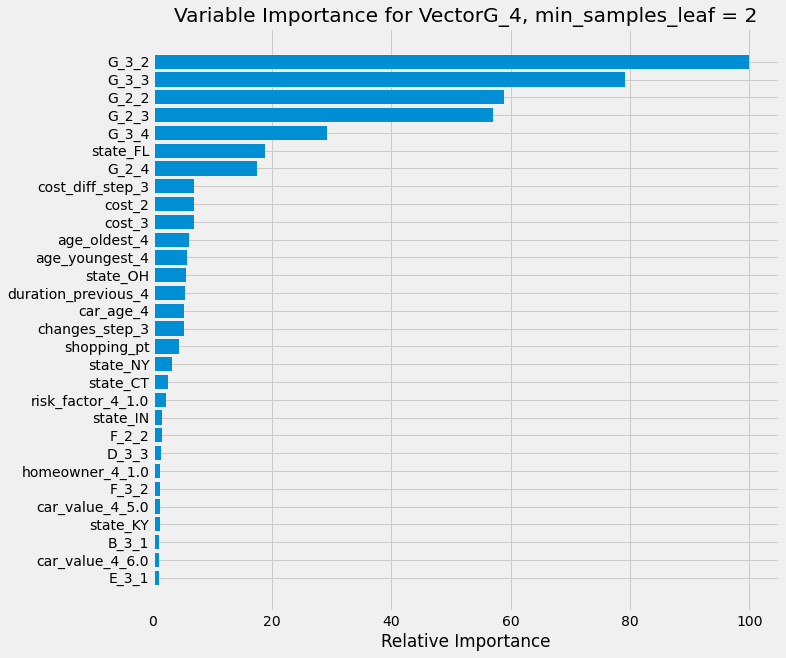

In [120]:
plt.style.use("fivethirtyeight")

vector = 'G_4'

for min_leaf in range(1,3):
    
    clf = RandomForestClassifier(n_estimators=300,  min_samples_leaf=min_leaf, random_state = 1,n_jobs=-1)
    model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Random Forest Classifier results for Vector {vector}, min_samples_leaf = {min_leaf}\n")
    print('Accuracy=%.3f' % (ac))

    print('f1-score=%.3f' % (f1))

    print("Confusion Matrix\n", cm)

    cr = classification_report(y_test[vector].astype('int'), y_pred)

    print("\nClassification Report \n", cr)

    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[64:]

    pos = np.arange(sorted_idx.shape[0]) + .5
    print(pos.size)
    sorted_idx.size
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance for Vector'+vector+', min_samples_leaf = %d'%min_leaf)
    plt.show()


In [121]:
x = pd.crosstab(test_set['G_4'], test_set['G_3'])

same_as_2 = [x.iloc[idx,idx] for idx in range(x.shape[0])] 

print(f"Accuracy based on simply predicting vector {vector} = {vector}_3 : {(np.sum(same_as_2)/test_set.shape[0]): 4.4}")


Accuracy based on simply predicting vector G_4 = G_4_3 :  0.9113


In [122]:
x

G_3     1     2     3    4
G_4                       
1.0  2801   247    41   41
2.0   212  5616   126   78
3.0    69   169  3952  103
4.0    30    84    98  964

In [123]:
df_2 = QuoteHistory2()
df_2.pass_data(df_wide)

df_hist_1_to_4 = df_2.get_history(how='specific', quote_nos=[1,2,3,4])
df_hist_1_to_4.head()


customer_ID  shopping_pt state  A  B  C  D  E  F  G  ...  F_3  F_4  G_1  \
0     10109793            9    CO  1  1  3  3  0  2  1  ...    2  2.0    1   
1     10002231            8    OH  0  0  1  3  0  0  3  ...    0  0.0    3   
2     10150024            8    OH  1  1  2  3  0  2  3  ...    3  2.0    3   
3     10003949            8    FL  1  1  2  2  1  2  3  ...    2  2.0    4   
4     10103809           10    FL  1  1  1  3  1  1  3  ...    1  1.0    4   

   G_2  G_3  G_4  cost_1  cost_2  cost_3  cost_4  
0    1    1  1.0     656     656     656   656.0  
1    3    3  3.0     598     557     564   564.0  
2    3    3  2.0     617     617     617   624.0  
3    3    3  3.0     647     675     675   675.0  
4    3    3  3.0     637     617     617   617.0  

[5 rows x 53 columns]

In [124]:
df_hist_1_to_4 = df_hist_1_to_4.drop(columns=['A','B','C','D','E','F','G','cost'])
df_hist_1_to_4.head()

customer_ID  shopping_pt state  group_size_4  homeowner_4  car_age_4  \
0     10109793            9    CO           1.0          1.0        3.0   
1     10002231            8    OH           1.0          0.0       13.0   
2     10150024            8    OH           3.0          1.0       20.0   
3     10003949            8    FL           2.0          1.0        7.0   
4     10103809           10    FL           1.0          1.0        9.0   

   car_value_4  risk_factor_4  age_oldest_4  age_youngest_4  ...  F_3  F_4  \
0          5.0            0.0          45.0            45.0  ...    2  2.0   
1          4.0            0.0          24.0            24.0  ...    0  0.0   
2          5.0            0.0          44.0            19.0  ...    3  2.0   
3          6.0            3.0          33.0            32.0  ...    2  2.0   
4          6.0            1.0          27.0            27.0  ...    1  1.0   

   G_1  G_2  G_3  G_4  cost_1  cost_2  cost_3  cost_4  
0    1    1    1  1.0     656     656     656   656.0  
1    3    3    3  3.0     598     557     564   564.0  
2    3    3    3  2.0     617     617     617   624.0  
3    4    3    3  3.0     647     675     675   675.0  
4    4    3    3  3.0     637     617     617   617.0  

[5 rows x 45 columns]

In [129]:
pp3 = PreProcess2()
pp3.fit(df_hist_1_to_4)

X4, y4 = pp3.transform(quote_nos=[1,2,3], target=4)


X4.shape, y4.shape  

((73152, 112), (73152, 8))

In [132]:
X4.head()

shopping_pt  car_age_4  age_oldest_4  age_youngest_4  duration_previous_4  \
0     1.054006  -0.894633     -0.002381        0.135086            -0.643210   
1     0.501449   0.828689     -1.209673       -1.067958             0.854494   
2     0.501449   2.035014     -0.059871       -1.354397            -0.643210   
3     0.501449  -0.205304     -0.692262       -0.609655            -0.643210   
4     1.606563   0.139360     -1.037203       -0.896094            -0.429252   

     cost_1    cost_2    cost_3  changes_step_2  changes_step_3  ...  F_3_3  \
0  0.455087  0.459097  0.443265       -0.870990       -0.531869  ...      0   
1 -0.686211 -1.622300 -1.564636        0.905639       -0.531869  ...      0   
2 -0.312337 -0.360847 -0.407910       -0.870990       -0.531869  ...      1   
3  0.277989  0.858557  0.857941       -0.278780       -0.531869  ...      0   
4  0.081214 -0.360847 -0.407910        0.313429       -0.531869  ...      0   

   G_1_2  G_1_3  G_1_4  G_2_2  G_2_3  G_2_4  G_3_2  G_3_3  G_3_4  
0      0      0      0      0      0      0      0      0      0  
1      0      1      0      0      1      0      0      1      0  
2      0      1      0      0      1      0      0      1      0  
3      0      0      1      0      1      0      0      1      0  
4      0      0      1      0      1      0      0      1      0  

[5 rows x 112 columns]

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X4, y4, test_size = 0.2, random_state = 123, stratify = X2['shopping_pt'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((58521, 112), (14631, 112), (58521, 8), (14631, 8))

Random Forest Classifier results for Vector D_4, min_samples_leaf = 1

Accuracy=0.962
f1-score=0.962
Confusion Matrix
 [[2055   44   37]
 [  86 3189  114]
 [ 127  145 8834]]

Classification Report 
               precision    recall  f1-score   support

           1       0.91      0.96      0.93      2136
           2       0.94      0.94      0.94      3389
           3       0.98      0.97      0.98      9106

    accuracy                           0.96     14631
   macro avg       0.94      0.96      0.95     14631
weighted avg       0.96      0.96      0.96     14631

30


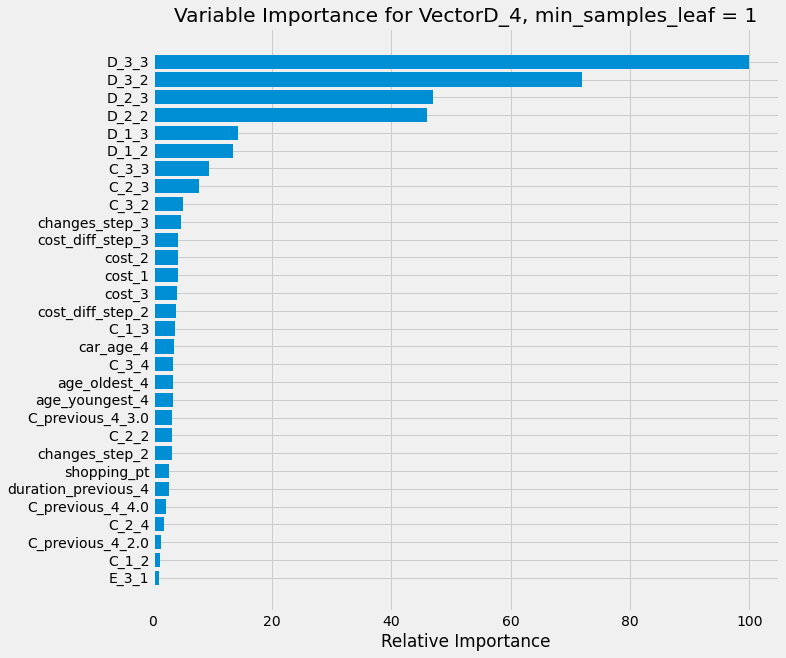

Random Forest Classifier results for Vector D_4, min_samples_leaf = 2

Accuracy=0.962
f1-score=0.962
Confusion Matrix
 [[2052   44   40]
 [  86 3189  114]
 [ 131  145 8830]]

Classification Report 
               precision    recall  f1-score   support

           1       0.90      0.96      0.93      2136
           2       0.94      0.94      0.94      3389
           3       0.98      0.97      0.98      9106

    accuracy                           0.96     14631
   macro avg       0.94      0.96      0.95     14631
weighted avg       0.96      0.96      0.96     14631

30


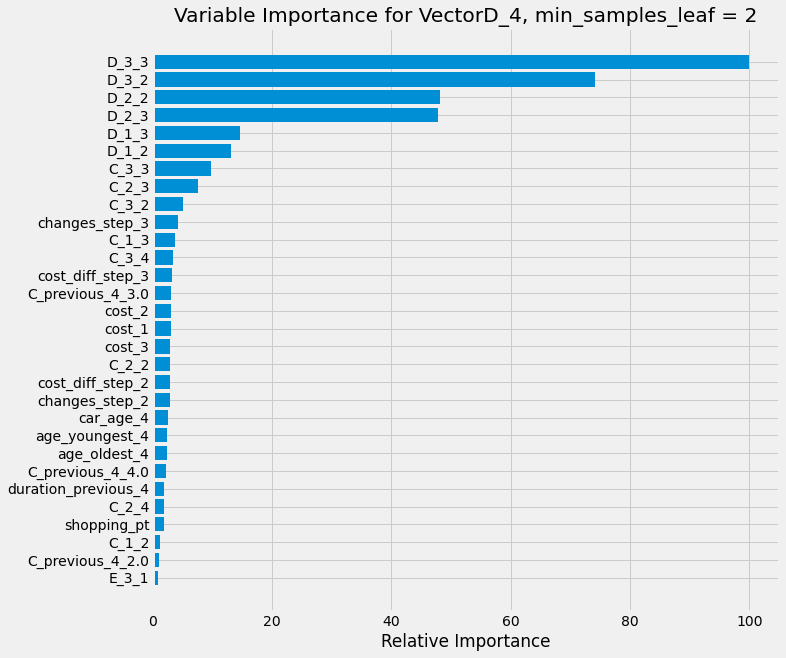

In [138]:
plt.style.use("fivethirtyeight")

vector = 'D_4'

for min_leaf in range(1,3):
    
    clf = RandomForestClassifier(n_estimators=300,  min_samples_leaf=min_leaf, random_state = 1,n_jobs=-1)
    model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Random Forest Classifier results for Vector {vector}, min_samples_leaf = {min_leaf}\n")
    print('Accuracy=%.3f' % (ac))

    print('f1-score=%.3f' % (f1))

    print("Confusion Matrix\n", cm)

    cr = classification_report(y_test[vector].astype('int'), y_pred)

    print("\nClassification Report \n", cr)

    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[82:]

    pos = np.arange(sorted_idx.shape[0]) + .5
    print(pos.size)
    sorted_idx.size
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance for Vector'+vector+', min_samples_leaf = %d'%min_leaf)
    plt.show()


Random Forest Classifier results for Vector G_4, min_samples_leaf = 1

Accuracy=0.912
f1-score=0.912
Confusion Matrix
 [[2803  247   41   39]
 [ 213 5610  133   76]
 [  69  161 3965   98]
 [  30   83  102  961]]

Classification Report 
               precision    recall  f1-score   support

           1       0.90      0.90      0.90      3130
           2       0.92      0.93      0.92      6032
           3       0.93      0.92      0.93      4293
           4       0.82      0.82      0.82      1176

    accuracy                           0.91     14631
   macro avg       0.89      0.89      0.89     14631
weighted avg       0.91      0.91      0.91     14631

30


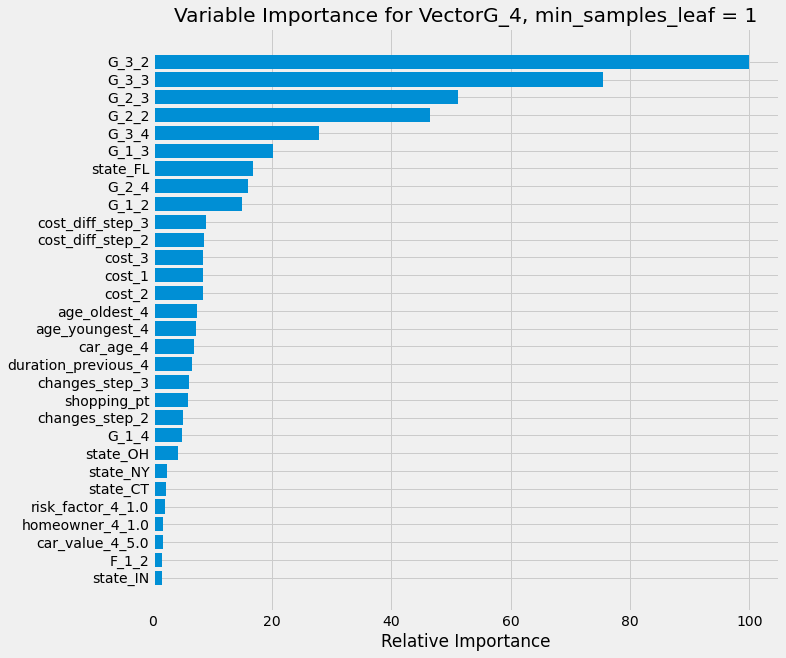

Random Forest Classifier results for Vector G_4, min_samples_leaf = 2

Accuracy=0.912
f1-score=0.912
Confusion Matrix
 [[2804  247   41   38]
 [ 214 5610  132   76]
 [  70  161 3962  100]
 [  30   83  100  963]]

Classification Report 
               precision    recall  f1-score   support

           1       0.90      0.90      0.90      3130
           2       0.92      0.93      0.92      6032
           3       0.94      0.92      0.93      4293
           4       0.82      0.82      0.82      1176

    accuracy                           0.91     14631
   macro avg       0.89      0.89      0.89     14631
weighted avg       0.91      0.91      0.91     14631

30


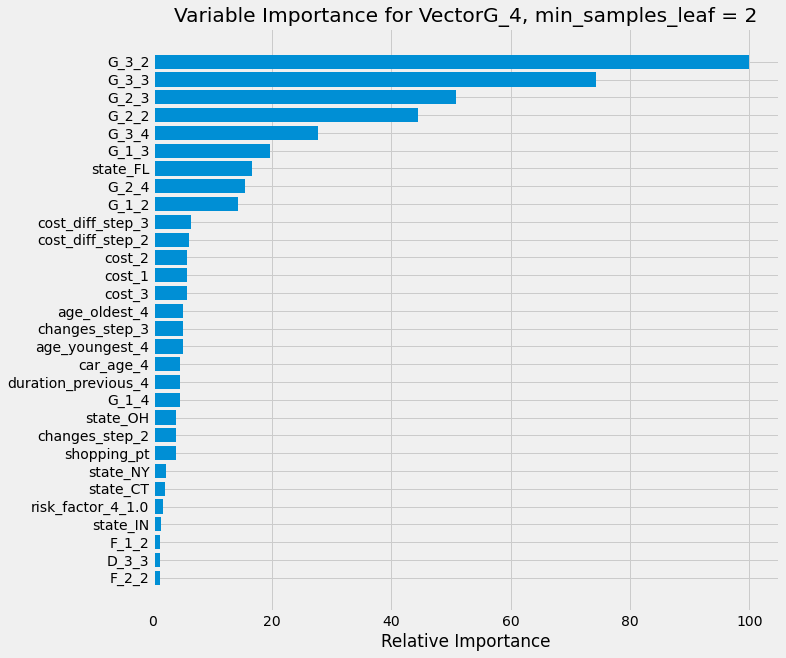

In [139]:
plt.style.use("fivethirtyeight")

vector = 'G_4'

for min_leaf in range(1,3):
    
    clf = RandomForestClassifier(n_estimators=300,  min_samples_leaf=min_leaf, random_state = 1,n_jobs=-1)
    model_res = clf.fit(X_train.to_numpy(), y_train[vector].astype('int'))
    y_pred = model_res.predict(X_test.to_numpy())
    y_pred_prob = model_res.predict_proba(X_test.to_numpy())
    lr_probs = y_pred_prob[:,1]
    ac = accuracy_score(y_test[vector].astype('int'), y_pred)

    f1 = f1_score(y_test[vector].astype('int'), y_pred, average='weighted')
    cm = confusion_matrix(y_test[vector].astype('int'), y_pred)

    print(f"Random Forest Classifier results for Vector {vector}, min_samples_leaf = {min_leaf}\n")
    print('Accuracy=%.3f' % (ac))

    print('f1-score=%.3f' % (f1))

    print("Confusion Matrix\n", cm)

    cr = classification_report(y_test[vector].astype('int'), y_pred)

    print("\nClassification Report \n", cr)

    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[82:]

    pos = np.arange(sorted_idx.shape[0]) + .5
    print(pos.size)
    sorted_idx.size
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance for Vector'+vector+', min_samples_leaf = %d'%min_leaf)
    plt.show()


In [ ]:

# GB old code

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    no_of_estimators = [20, 50, 100, 150]
    for num in no_of_estimators:
        gb = GradientBoostingClassifier(n_estimators=num, learning_rate = learning_rate, max_features=4, max_depth = 2, random_state = 0)
        gb.fit(X_train.to_numpy(), y_train['B'].astype('int'))
        print(f"Learning rate: {learning_rate}, estimators: {num}")
        print("Accuracy score (training): {0:.3f}".format(gb.score(X_train.to_numpy(), y_train['B'].astype('int'))))
        print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test.to_numpy(), y_test['B'].astype('int'))))
        print()
  